# Exoplanet-stars detection
In this notebook, we will analyze the light-intensity time series of stars in order to detect whether it has exoplanets or not.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage
import xgboost as xg
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('./data/exoTrain.csv')
test =  pd.read_csv('./data/exoTest.csv')

In [3]:
train.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


The 'Label' row is the one we are trying to predict, so we must split up the data:

In [4]:
X_train = train.drop('LABEL', axis=1)
y_train = train.LABEL
X_test = test.drop('LABEL', axis=1)
y_test = test.LABEL

Now, let us explore which stars have exoplanets:

In [5]:
z=train[train.LABEL==2]
z

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
5,2,211.10,163.57,179.16,187.82,188.46,168.13,203.46,178.65,166.49,...,-98.45,30.34,30.34,29.62,28.80,19.27,-43.90,-41.63,-52.90,-16.16
6,2,9.34,49.96,33.30,9.63,37.64,20.85,4.54,22.42,10.11,...,-58.56,9.93,9.93,23.50,5.28,-0.44,10.90,-11.77,-9.25,-36.69
7,2,238.77,262.16,277.80,190.16,180.98,123.27,103.95,50.70,59.91,...,-72.48,31.77,31.77,53.48,27.88,95.30,48.86,-10.62,-112.02,-229.92
8,2,-103.54,-118.97,-108.93,-72.25,-61.46,-50.16,-20.61,-12.44,1.48,...,43.92,7.24,7.24,-7.45,-18.82,4.53,21.95,26.94,34.08,44.65
9,2,-265.91,-318.59,-335.66,-450.47,-453.09,-561.47,-606.03,-712.72,-685.97,...,3671.03,2249.28,2249.28,2437.78,2584.22,3162.53,3398.28,3648.34,3671.97,3781.91


We now graph the light intensities of some stars, just to check whether the difference between exoplanet and non-exoplanet stars can be "seen".

## Plots of 5 exoplanet stars.

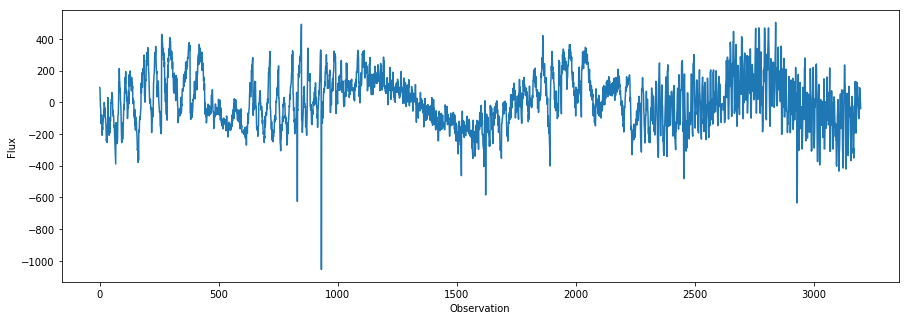

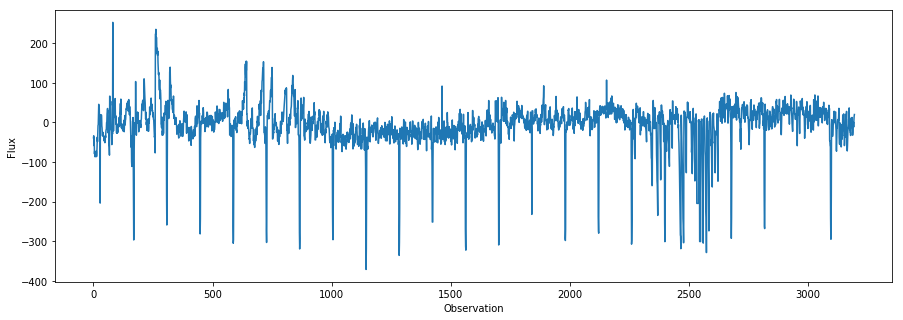

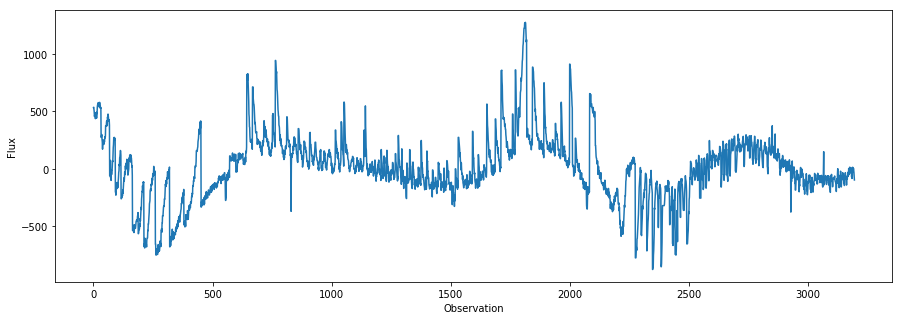

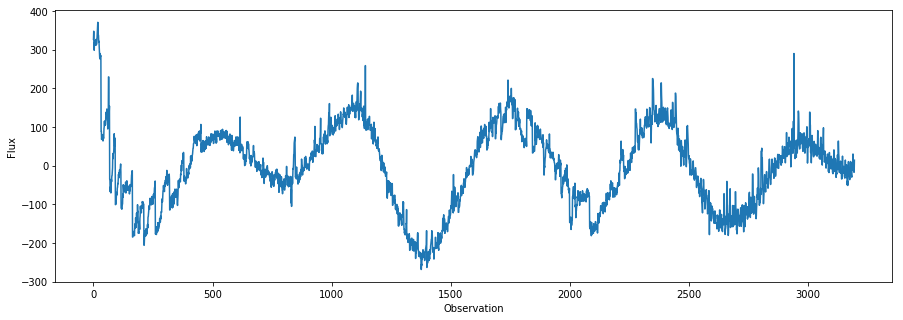

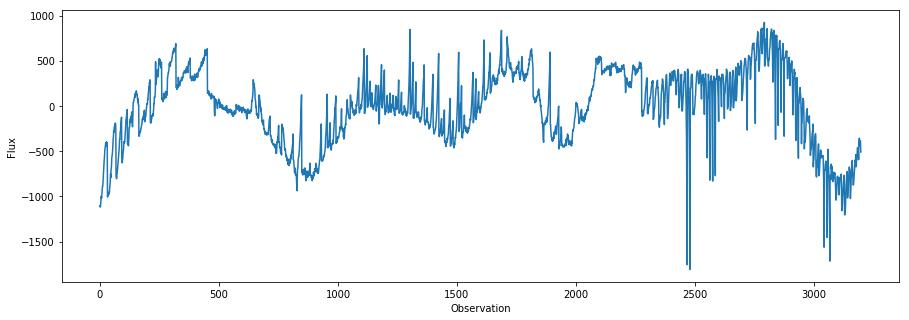

In [6]:
for i in [0,1,2,3,4]:
    Y = X_train.iloc[i]
    X = np.arange(len(Y)) 
    plt.figure(figsize=(15,5))
    plt.ylabel('Flux')
    plt.xlabel('Observation')
    plt.plot(X, Y)
    plt.show()



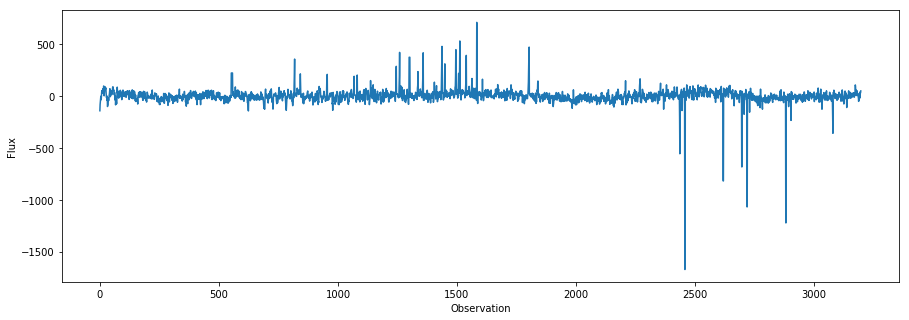

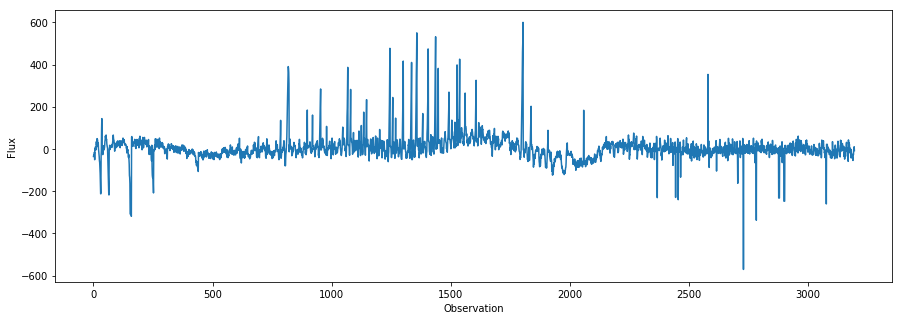

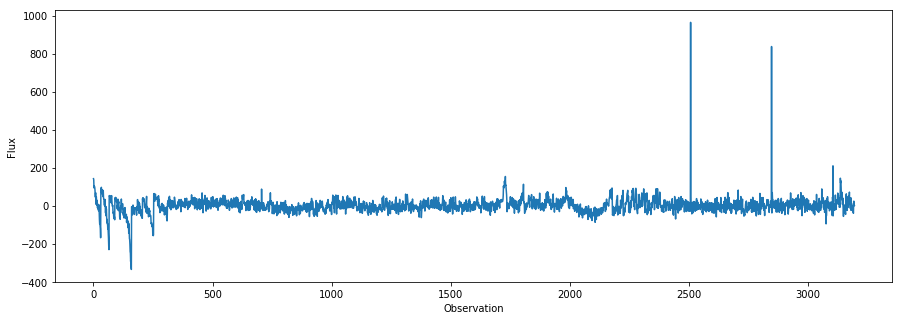

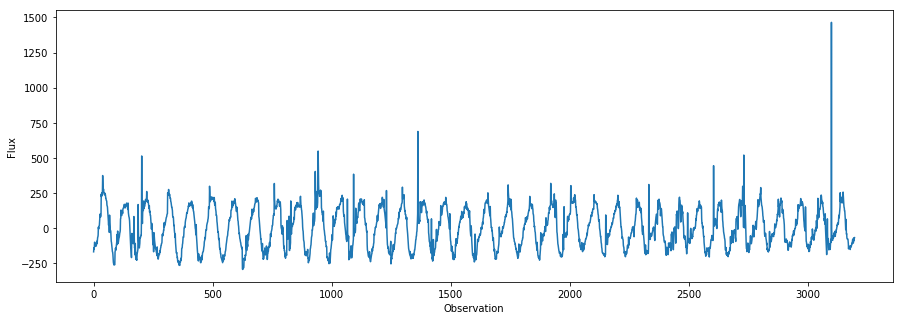

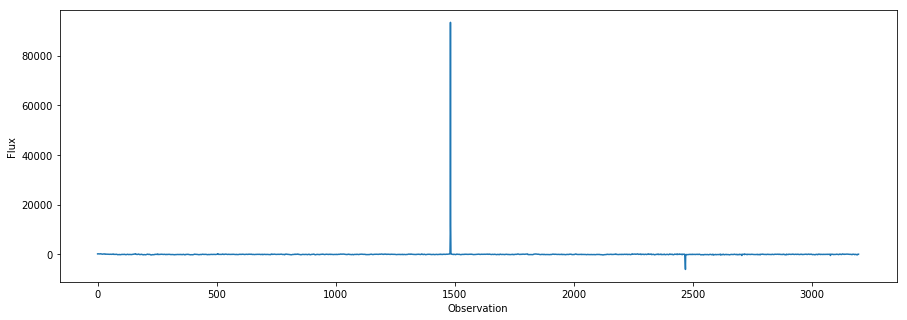

In [8]:
for i in [j for j in range (37,42)]:    
    Y = X_train.iloc[i]
    X = np.arange(len(Y)) 
    plt.figure(figsize=(15,5))
    plt.ylabel('Flux')
    plt.xlabel('Observation')
    plt.plot(X, Y)
    plt.show()

## Normalization

The light intensities varies a lot between stars, it is better to normalize them.

In [9]:
def normal(X):
    Y= (X-np.mean(X))/(np.max(X)-np.min(X))
    return Y

In [10]:
X_train= X_train.apply(normal,axis=1)


In [11]:
X_test= X_test.apply(normal,axis=1)

## Fourier Transform
Now, we use the fft function from scipy, in order to obtain the spectrum of the signals. This will produce more useful data for our machine learning algorithms.

In [12]:
def fourier(X):
    Y = scipy.fft(X, n=X.size)
    return np.abs(Y)

In [13]:
X_train = X_train.apply(fourier,axis=1)

In [14]:
X_test = X_test.apply(fourier,axis=1)

# Plot Fourier Series of the 5 exoplanet stars

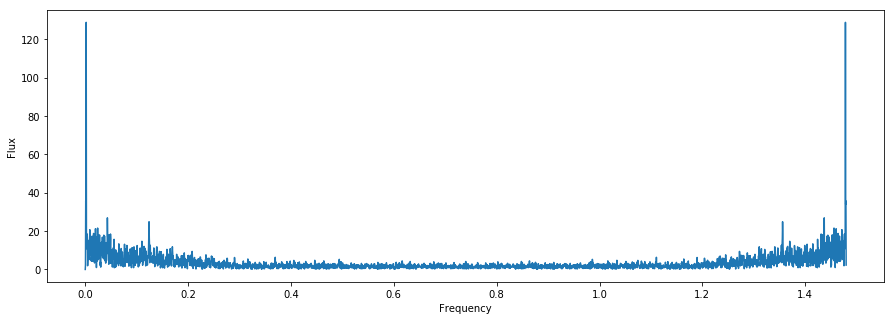

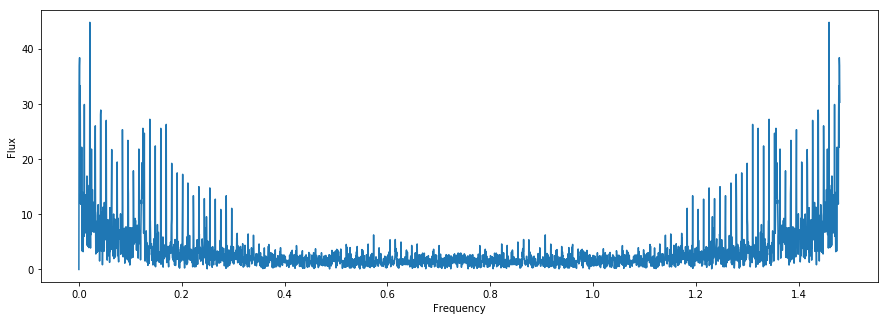

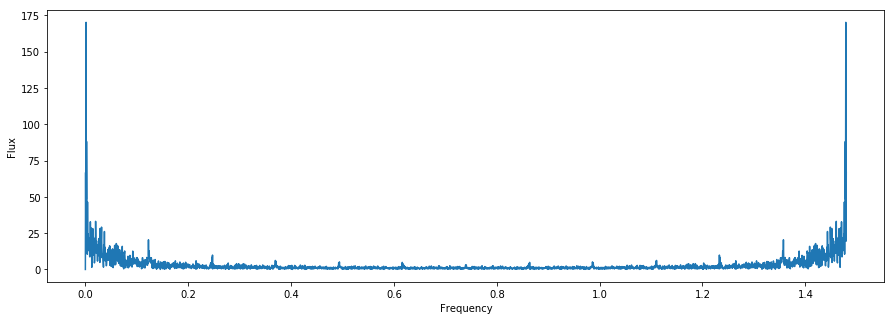

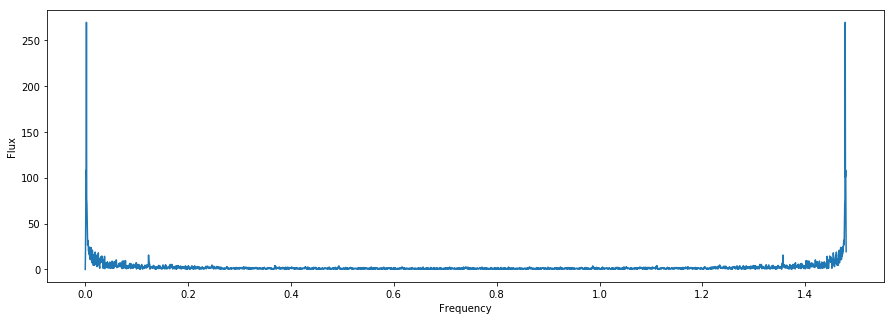

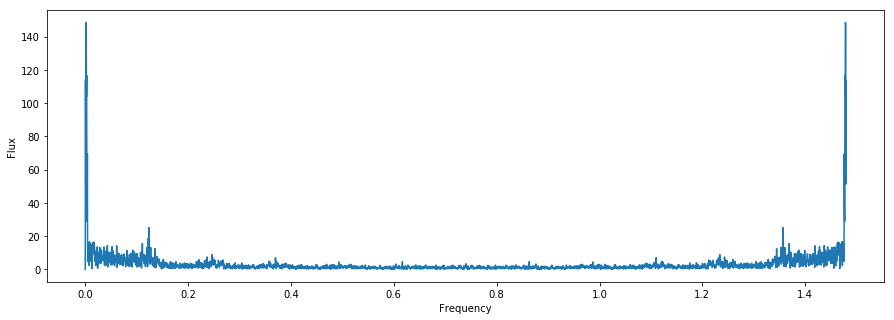

In [15]:
for i in [0,1,2,3,4]:
    Y = X_train.iloc[i]
    X = np.arange(len(Y))*(1/(36.0*60.0)) 
    plt.figure(figsize=(15,5))
    plt.ylabel('Flux')
    plt.xlabel('Frequency')
    plt.plot(X, Y)
    plt.show()

# Plot Fourier Series of the 5 non-exoplanet stars


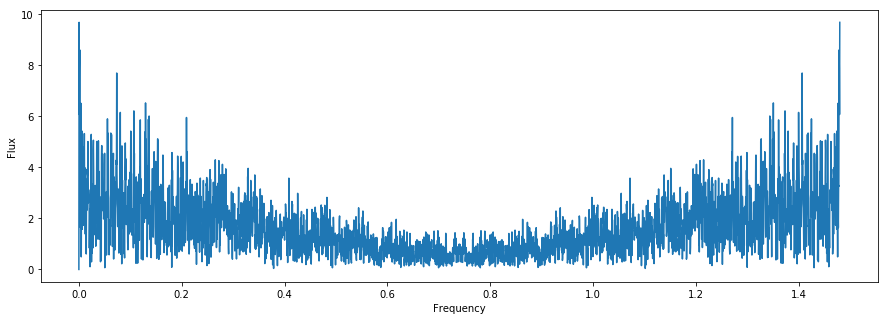

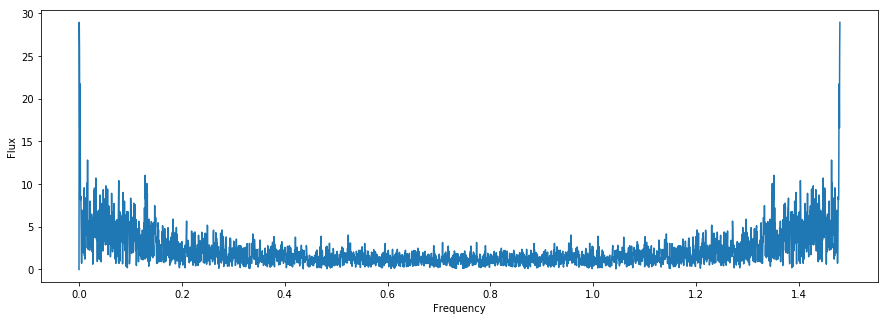

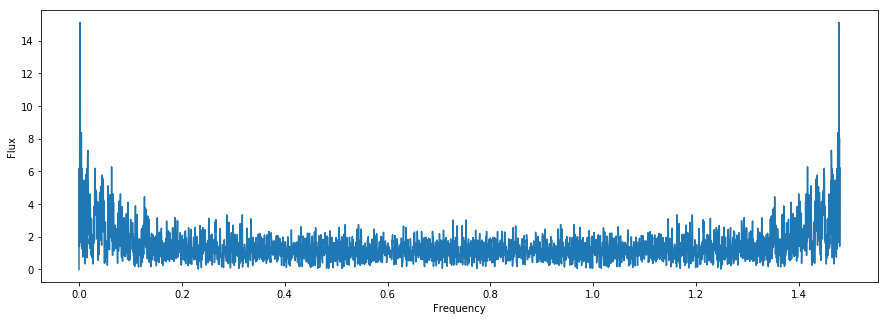

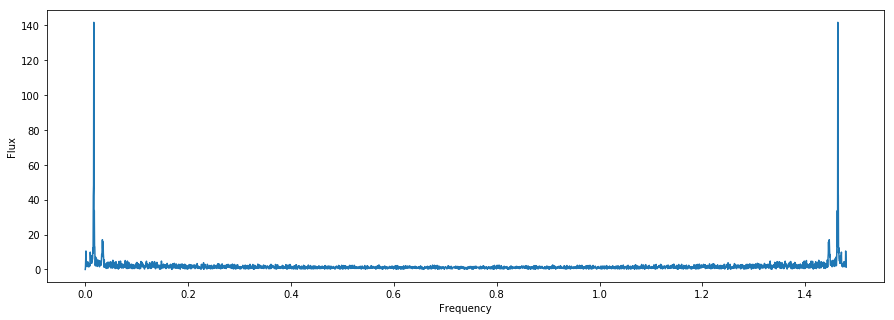

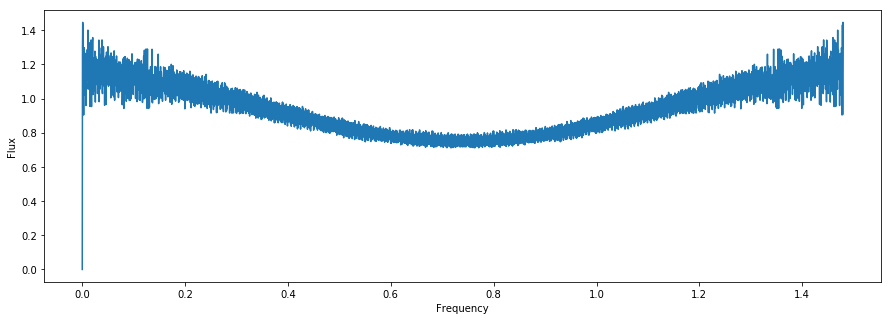

In [16]:
for i in [j for j in range (37,42)]:
    Y = X_train.iloc[i]
    X = np.arange(len(Y))*(1/(36.0*60.0)) 
    plt.figure(figsize=(15,5))
    plt.ylabel('Flux')
    plt.xlabel('Frequency')
    plt.plot(X, Y)
    plt.show()

## By symmetry of the Fourier Series, we can remove half of the columns:

In [17]:
X_train = X_train.drop(X_train.columns[1601:], axis=1)

In [18]:
X_test = X_test.drop(X_test.columns[1601:], axis=1)

## A little bit more preprocessing
Since the diming of the flux due to an exostar must have a low frequency on the signal, we remove the first columns, which represent the higher frequencies:

In [19]:
X_train = X_train.drop(X_train.columns[1:250], axis=1)

In [20]:
X_test = X_test.drop(X_test.columns[1:250], axis=1)

# Plot Fourier Series of the 5 exoplanet stars without the first 250 columns:

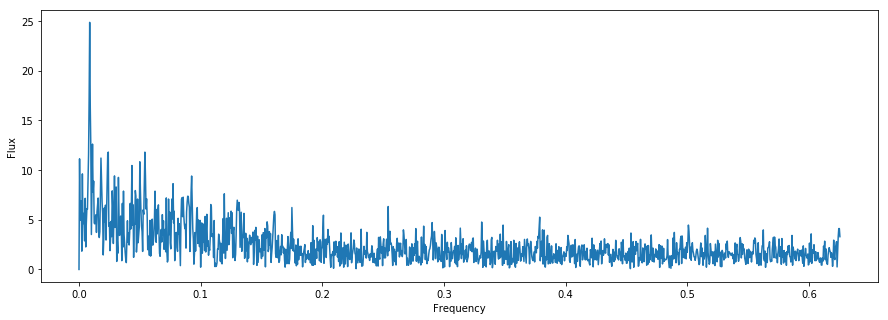

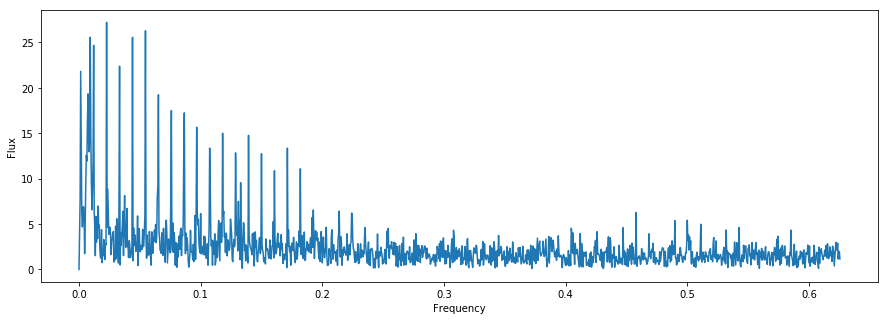

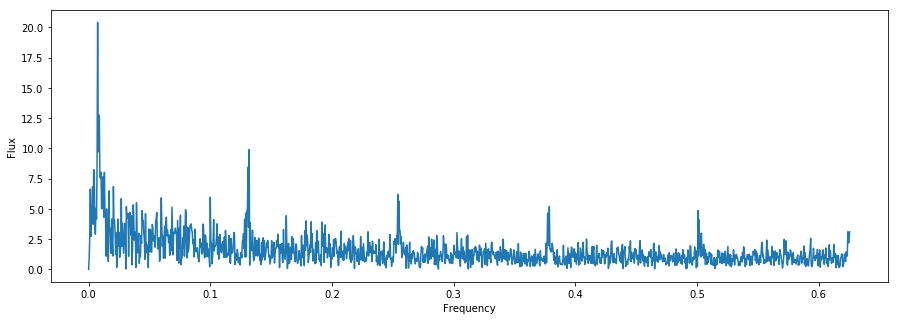

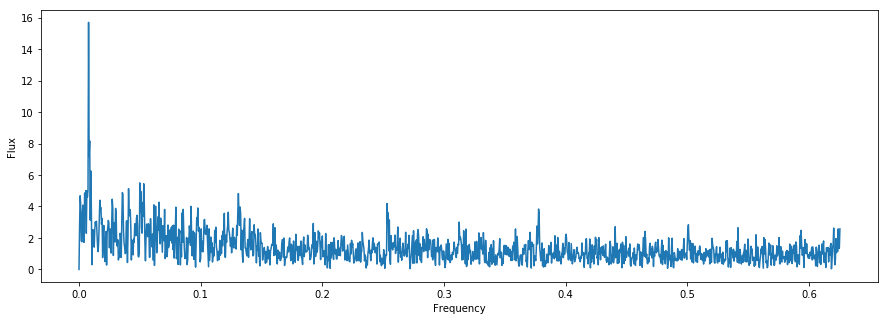

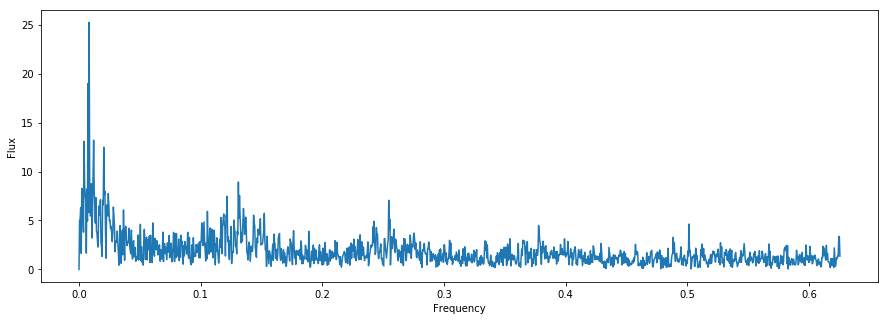

In [21]:
for i in [0,1,2,3,4]:
    Y = X_train.iloc[i]
    X = np.arange(len(Y))*(1/(36.0*60.0)) 
    plt.figure(figsize=(15,5))
    plt.ylabel('Flux')
    plt.xlabel('Frequency')
    plt.plot(X, Y)
    plt.show()

# Plot Fourier Series of the 5 non-exoplanet stars without the first 250 columns:

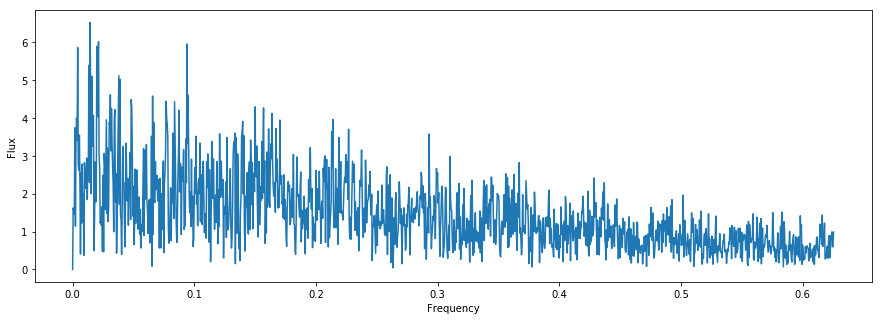

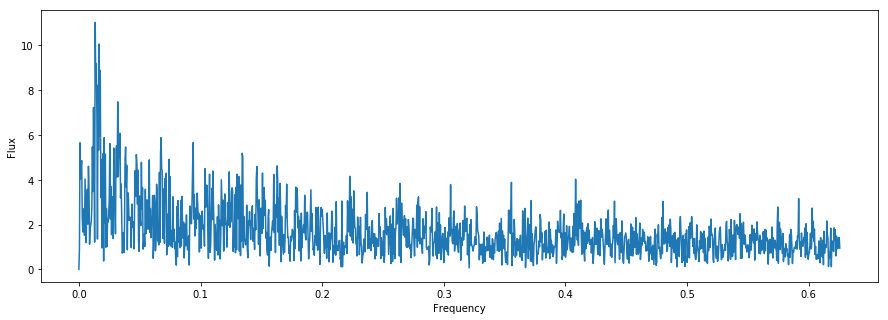

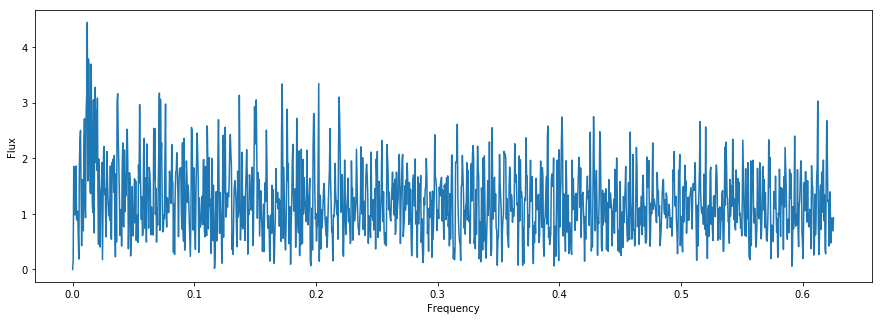

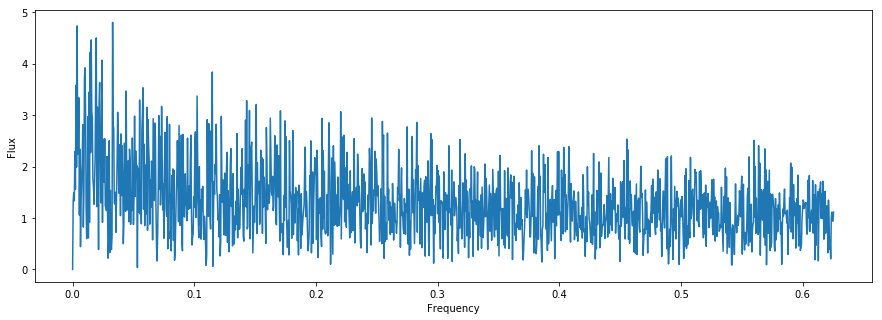

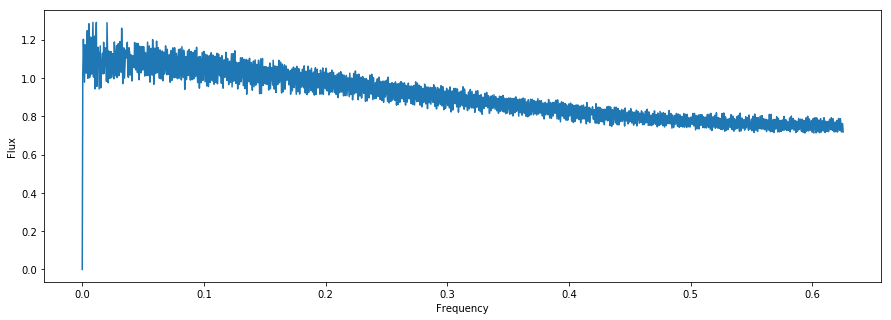

In [22]:
for i in [j for j in range (37,42)]:
    Y = X_train.iloc[i]
    X = np.arange(len(Y))*(1/(36.0*60.0)) 
    plt.figure(figsize=(15,5))
    plt.ylabel('Flux')
    plt.xlabel('Frequency')
    plt.plot(X, Y)
    plt.show()

## Oversampling

In [103]:
sm = SMOTE(ratio =1.0)
X_r, y_r = sm.fit_sample(X_train, y_train)
print (y_train.value_counts(), np.bincount(y_r))

1    5050
2      37
Name: LABEL, dtype: int64 [   0 5050 5050]


/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [106]:
X_test=X_test.as_matrix()
#X_test = X_test[X_r.columns]

https://www.kaggle.com/aleksod/0-75-precision-0-60-recall-linear-svc

In [13]:
from sklearn.model_selection import StratifiedKFold
def model_evaluator(X, y, model, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits)
    
    
    bootstrapped_f1s        = list()
    
    
    SMOTE_f1s        = list()
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
                
        df_train    = X_train.join(y_train)
        df_planet   = df_train[df_train.LABEL == 2].reset_index(drop=True)
        df_noplanet = df_train[df_train.LABEL == 1].reset_index(drop=True)
        df_boot     = df_noplanet
                        
        index = np.arange(0, df_planet.shape[0])
        temp_index = np.random.choice(index, size=df_noplanet.shape[0])
        df_boot = df_boot.append(df_planet.iloc[temp_index])
        
        df_boot = df_boot.reset_index(drop=True)
        X_train_boot = df_boot.drop('LABEL', axis=1)
        y_train_boot = df_boot.LABEL
                    
        est_boot = model.fit(X_train_boot, y_train_boot)
        y_test_pred = est_boot.predict(X_test)
        
        
        bootstrapped_f1s.append(f1_score(y_test, y_test_pred, pos_label=2))
    
        sm = SMOTE(ratio = 1.0)
        X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)
                    
        est_sm = model.fit(X_train_sm, y_train_sm)
        y_test_pred = est_sm.predict(X_test)
        
        
        SMOTE_f1s.append(f1_score(y_test, y_test_pred, pos_label=2))
        
    print('\t\t\t Bootstrapped \t SMOTE')
    
    print("Average F1:\t\t", "{:0.10f}".format(np.mean(bootstrapped_f1s)),
          '\t', "{:0.10f}".format(np.mean(SMOTE_f1s)))

In [14]:
model_evaluator(X_train, y_train, xg.XGBClassifier())


/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f329', 'f330', 'f331', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 'f340', 'f341', 'f342', 'f343', 'f344', 'f345', 'f346', 'f347', 'f348', 'f349', 'f350', 'f351', 'f352', 'f353', 'f354', 'f355', 'f356', 'f357', 'f358', 'f359', 'f360', 'f361', 'f362', 'f363', 'f364', 'f365', 'f366', 'f367', 'f368', 'f369', 'f370', 'f371', 'f372', 'f373', 'f374', 'f375', 'f376', 'f377', 'f378', 'f379', 'f380', 'f381', 'f382', 'f383', 'f384', 'f385', 'f386', 'f387', 'f388', 'f389', 'f390', 'f391', 'f392', 'f393', 'f394', 'f395', 'f396', 'f397', 'f398', 'f399', 'f400', 'f401', 'f402', 'f403', 'f404', 'f405', 'f406', 'f407', 'f408', 'f409', 'f410', 'f411', 'f412', 'f413', 'f414', 'f415', 'f416', 'f417', 'f418', 'f419', 'f420', 'f421', 'f422', 'f423', 'f424', 'f425', 'f426', 'f427', 'f428', 'f429', 'f430', 'f431', 'f432', 'f433', 'f434', 'f435', 'f436', 'f437', 'f438', 'f439', 'f440', 'f441', 'f442', 'f443', 'f444', 'f445', 'f446', 'f447', 'f448', 'f449', 'f450', 'f451', 'f452', 'f453', 'f454', 'f455', 'f456', 'f457', 'f458', 'f459', 'f460', 'f461', 'f462', 'f463', 'f464', 'f465', 'f466', 'f467', 'f468', 'f469', 'f470', 'f471', 'f472', 'f473', 'f474', 'f475', 'f476', 'f477', 'f478', 'f479', 'f480', 'f481', 'f482', 'f483', 'f484', 'f485', 'f486', 'f487', 'f488', 'f489', 'f490', 'f491', 'f492', 'f493', 'f494', 'f495', 'f496', 'f497', 'f498', 'f499', 'f500', 'f501', 'f502', 'f503', 'f504', 'f505', 'f506', 'f507', 'f508', 'f509', 'f510', 'f511', 'f512', 'f513', 'f514', 'f515', 'f516', 'f517', 'f518', 'f519', 'f520', 'f521', 'f522', 'f523', 'f524', 'f525', 'f526', 'f527', 'f528', 'f529', 'f530', 'f531', 'f532', 'f533', 'f534', 'f535', 'f536', 'f537', 'f538', 'f539', 'f540', 'f541', 'f542', 'f543', 'f544', 'f545', 'f546', 'f547', 'f548', 'f549', 'f550', 'f551', 'f552', 'f553', 'f554', 'f555', 'f556', 'f557', 'f558', 'f559', 'f560', 'f561', 'f562', 'f563', 'f564', 'f565', 'f566', 'f567', 'f568', 'f569', 'f570', 'f571', 'f572', 'f573', 'f574', 'f575', 'f576', 'f577', 'f578', 'f579', 'f580', 'f581', 'f582', 'f583', 'f584', 'f585', 'f586', 'f587', 'f588', 'f589', 'f590', 'f591', 'f592', 'f593', 'f594', 'f595', 'f596', 'f597', 'f598', 'f599', 'f600', 'f601', 'f602', 'f603', 'f604', 'f605', 'f606', 'f607', 'f608', 'f609', 'f610', 'f611', 'f612', 'f613', 'f614', 'f615', 'f616', 'f617', 'f618', 'f619', 'f620', 'f621', 'f622', 'f623', 'f624', 'f625', 'f626', 'f627', 'f628', 'f629', 'f630', 'f631', 'f632', 'f633', 'f634', 'f635', 'f636', 'f637', 'f638', 'f639', 'f640', 'f641', 'f642', 'f643', 'f644', 'f645', 'f646', 'f647', 'f648', 'f649', 'f650', 'f651', 'f652', 'f653', 'f654', 'f655', 'f656', 'f657', 'f658', 'f659', 'f660', 'f661', 'f662', 'f663', 'f664', 'f665', 'f666', 'f667', 'f668', 'f669', 'f670', 'f671', 'f672', 'f673', 'f674', 'f675', 'f676', 'f677', 'f678', 'f679', 'f680', 'f681', 'f682', 'f683', 'f684', 'f685', 'f686', 'f687', 'f688', 'f689', 'f690', 'f691', 'f692', 'f693', 'f694', 'f695', 'f696', 'f697', 'f698', 'f699', 'f700', 'f701', 'f702', 'f703', 'f704', 'f705', 'f706', 'f707', 'f708', 'f709', 'f710', 'f711', 'f712', 'f713', 'f714', 'f715', 'f716', 'f717', 'f718', 'f719', 'f720', 'f721', 'f722', 'f723', 'f724', 'f725', 'f726', 'f727', 'f728', 'f729', 'f730', 'f731', 'f732', 'f733', 'f734', 'f735', 'f736', 'f737', 'f738', 'f739', 'f740', 'f741', 'f742', 'f743', 'f744', 'f745', 'f746', 'f747', 'f748', 'f749', 'f750', 'f751', 'f752', 'f753', 'f754', 'f755', 'f756', 'f757', 'f758', 'f759', 'f760', 'f761', 'f762', 'f763', 'f764', 'f765', 'f766', 'f767', 'f768', 'f769', 'f770', 'f771', 'f772', 'f773', 'f774', 'f775', 'f776', 'f777', 'f778', 'f779', 'f780', 'f781', 'f782', 'f783', 'f784', 'f785', 'f786', 'f787', 'f788', 'f789', 'f790', 'f791', 'f792', 'f793', 'f794', 'f795', 'f796', 'f797', 'f798', 'f799', 'f800', 'f801', 'f802', 'f803', 'f804', 'f805', 'f806', 'f807', 'f808', 'f809', 'f810', 'f811', 'f812', 'f813', 'f814', 'f815', 'f816', 'f817', 'f818', 'f819', 'f820', 'f821', 'f822', 'f823', 'f824', 'f825', 'f826', 'f827', 'f828', 'f829', 'f830', 'f831', 'f832', 'f833', 'f834', 'f835', 'f836', 'f837', 'f838', 'f839', 'f840', 'f841', 'f842', 'f843', 'f844', 'f845', 'f846', 'f847', 'f848', 'f849', 'f850', 'f851', 'f852', 'f853', 'f854', 'f855', 'f856', 'f857', 'f858', 'f859', 'f860', 'f861', 'f862', 'f863', 'f864', 'f865', 'f866', 'f867', 'f868', 'f869', 'f870', 'f871', 'f872', 'f873', 'f874', 'f875', 'f876', 'f877', 'f878', 'f879', 'f880', 'f881', 'f882', 'f883', 'f884', 'f885', 'f886', 'f887', 'f888', 'f889', 'f890', 'f891', 'f892', 'f893', 'f894', 'f895', 'f896', 'f897', 'f898', 'f899', 'f900', 'f901', 'f902', 'f903', 'f904', 'f905', 'f906', 'f907', 'f908', 'f909', 'f910', 'f911', 'f912', 'f913', 'f914', 'f915', 'f916', 'f917', 'f918', 'f919', 'f920', 'f921', 'f922', 'f923', 'f924', 'f925', 'f926', 'f927', 'f928', 'f929', 'f930', 'f931', 'f932', 'f933', 'f934', 'f935', 'f936', 'f937', 'f938', 'f939', 'f940', 'f941', 'f942', 'f943', 'f944', 'f945', 'f946', 'f947', 'f948', 'f949', 'f950', 'f951', 'f952', 'f953', 'f954', 'f955', 'f956', 'f957', 'f958', 'f959', 'f960', 'f961', 'f962', 'f963', 'f964', 'f965', 'f966', 'f967', 'f968', 'f969', 'f970', 'f971', 'f972', 'f973', 'f974', 'f975', 'f976', 'f977', 'f978', 'f979', 'f980', 'f981', 'f982', 'f983', 'f984', 'f985', 'f986', 'f987', 'f988', 'f989', 'f990', 'f991', 'f992', 'f993', 'f994', 'f995', 'f996', 'f997', 'f998', 'f999', 'f1000', 'f1001', 'f1002', 'f1003', 'f1004', 'f1005', 'f1006', 'f1007', 'f1008', 'f1009', 'f1010', 'f1011', 'f1012', 'f1013', 'f1014', 'f1015', 'f1016', 'f1017', 'f1018', 'f1019', 'f1020', 'f1021', 'f1022', 'f1023', 'f1024', 'f1025', 'f1026', 'f1027', 'f1028', 'f1029', 'f1030', 'f1031', 'f1032', 'f1033', 'f1034', 'f1035', 'f1036', 'f1037', 'f1038', 'f1039', 'f1040', 'f1041', 'f1042', 'f1043', 'f1044', 'f1045', 'f1046', 'f1047', 'f1048', 'f1049', 'f1050', 'f1051', 'f1052', 'f1053', 'f1054', 'f1055', 'f1056', 'f1057', 'f1058', 'f1059', 'f1060', 'f1061', 'f1062', 'f1063', 'f1064', 'f1065', 'f1066', 'f1067', 'f1068', 'f1069', 'f1070', 'f1071', 'f1072', 'f1073', 'f1074', 'f1075', 'f1076', 'f1077', 'f1078', 'f1079', 'f1080', 'f1081', 'f1082', 'f1083', 'f1084', 'f1085', 'f1086', 'f1087', 'f1088', 'f1089', 'f1090', 'f1091', 'f1092', 'f1093', 'f1094', 'f1095', 'f1096', 'f1097', 'f1098', 'f1099', 'f1100', 'f1101', 'f1102', 'f1103', 'f1104', 'f1105', 'f1106', 'f1107', 'f1108', 'f1109', 'f1110', 'f1111', 'f1112', 'f1113', 'f1114', 'f1115', 'f1116', 'f1117', 'f1118', 'f1119', 'f1120', 'f1121', 'f1122', 'f1123', 'f1124', 'f1125', 'f1126', 'f1127', 'f1128', 'f1129', 'f1130', 'f1131', 'f1132', 'f1133', 'f1134', 'f1135', 'f1136', 'f1137', 'f1138', 'f1139', 'f1140', 'f1141', 'f1142', 'f1143', 'f1144', 'f1145', 'f1146', 'f1147', 'f1148', 'f1149', 'f1150', 'f1151', 'f1152', 'f1153', 'f1154', 'f1155', 'f1156', 'f1157', 'f1158', 'f1159', 'f1160', 'f1161', 'f1162', 'f1163', 'f1164', 'f1165', 'f1166', 'f1167', 'f1168', 'f1169', 'f1170', 'f1171', 'f1172', 'f1173', 'f1174', 'f1175', 'f1176', 'f1177', 'f1178', 'f1179', 'f1180', 'f1181', 'f1182', 'f1183', 'f1184', 'f1185', 'f1186', 'f1187', 'f1188', 'f1189', 'f1190', 'f1191', 'f1192', 'f1193', 'f1194', 'f1195', 'f1196', 'f1197', 'f1198', 'f1199', 'f1200', 'f1201', 'f1202', 'f1203', 'f1204', 'f1205', 'f1206', 'f1207', 'f1208', 'f1209', 'f1210', 'f1211', 'f1212', 'f1213', 'f1214', 'f1215', 'f1216', 'f1217', 'f1218', 'f1219', 'f1220', 'f1221', 'f1222', 'f1223', 'f1224', 'f1225', 'f1226', 'f1227', 'f1228', 'f1229', 'f1230', 'f1231', 'f1232', 'f1233', 'f1234', 'f1235', 'f1236', 'f1237', 'f1238', 'f1239', 'f1240', 'f1241', 'f1242', 'f1243', 'f1244', 'f1245', 'f1246', 'f1247', 'f1248', 'f1249', 'f1250', 'f1251', 'f1252', 'f1253', 'f1254', 'f1255', 'f1256', 'f1257', 'f1258', 'f1259', 'f1260', 'f1261', 'f1262', 'f1263', 'f1264', 'f1265', 'f1266', 'f1267', 'f1268', 'f1269', 'f1270', 'f1271', 'f1272', 'f1273', 'f1274', 'f1275', 'f1276', 'f1277', 'f1278', 'f1279', 'f1280', 'f1281', 'f1282', 'f1283', 'f1284', 'f1285', 'f1286', 'f1287', 'f1288', 'f1289', 'f1290', 'f1291', 'f1292', 'f1293', 'f1294', 'f1295', 'f1296', 'f1297', 'f1298', 'f1299', 'f1300', 'f1301', 'f1302', 'f1303', 'f1304', 'f1305', 'f1306', 'f1307', 'f1308', 'f1309', 'f1310', 'f1311', 'f1312', 'f1313', 'f1314', 'f1315', 'f1316', 'f1317', 'f1318', 'f1319', 'f1320', 'f1321', 'f1322', 'f1323', 'f1324', 'f1325', 'f1326', 'f1327', 'f1328', 'f1329', 'f1330', 'f1331', 'f1332', 'f1333', 'f1334', 'f1335', 'f1336', 'f1337', 'f1338', 'f1339', 'f1340', 'f1341', 'f1342', 'f1343', 'f1344', 'f1345', 'f1346', 'f1347', 'f1348', 'f1349', 'f1350', 'f1351', 'f1352', 'f1353', 'f1354', 'f1355', 'f1356', 'f1357', 'f1358', 'f1359', 'f1360', 'f1361', 'f1362', 'f1363', 'f1364', 'f1365', 'f1366', 'f1367', 'f1368', 'f1369', 'f1370', 'f1371', 'f1372', 'f1373', 'f1374', 'f1375', 'f1376', 'f1377', 'f1378', 'f1379', 'f1380', 'f1381', 'f1382', 'f1383', 'f1384', 'f1385', 'f1386', 'f1387', 'f1388', 'f1389', 'f1390', 'f1391', 'f1392', 'f1393', 'f1394', 'f1395', 'f1396', 'f1397', 'f1398', 'f1399', 'f1400', 'f1401', 'f1402', 'f1403', 'f1404', 'f1405', 'f1406', 'f1407', 'f1408', 'f1409', 'f1410', 'f1411', 'f1412', 'f1413', 'f1414', 'f1415', 'f1416', 'f1417', 'f1418', 'f1419', 'f1420', 'f1421', 'f1422', 'f1423', 'f1424', 'f1425', 'f1426', 'f1427', 'f1428', 'f1429', 'f1430', 'f1431', 'f1432', 'f1433', 'f1434', 'f1435', 'f1436', 'f1437', 'f1438', 'f1439', 'f1440', 'f1441', 'f1442', 'f1443', 'f1444', 'f1445', 'f1446', 'f1447', 'f1448', 'f1449', 'f1450', 'f1451', 'f1452', 'f1453', 'f1454', 'f1455', 'f1456', 'f1457', 'f1458', 'f1459', 'f1460', 'f1461', 'f1462', 'f1463', 'f1464', 'f1465', 'f1466', 'f1467', 'f1468', 'f1469', 'f1470', 'f1471', 'f1472', 'f1473', 'f1474', 'f1475', 'f1476', 'f1477', 'f1478', 'f1479', 'f1480', 'f1481', 'f1482', 'f1483', 'f1484', 'f1485', 'f1486', 'f1487', 'f1488', 'f1489', 'f1490', 'f1491', 'f1492', 'f1493', 'f1494', 'f1495', 'f1496', 'f1497', 'f1498', 'f1499', 'f1500', 'f1501', 'f1502', 'f1503', 'f1504', 'f1505', 'f1506', 'f1507', 'f1508', 'f1509', 'f1510', 'f1511', 'f1512', 'f1513', 'f1514', 'f1515', 'f1516', 'f1517', 'f1518', 'f1519', 'f1520', 'f1521', 'f1522', 'f1523', 'f1524', 'f1525', 'f1526', 'f1527', 'f1528', 'f1529', 'f1530', 'f1531', 'f1532', 'f1533', 'f1534', 'f1535', 'f1536', 'f1537', 'f1538', 'f1539', 'f1540', 'f1541', 'f1542', 'f1543', 'f1544', 'f1545', 'f1546', 'f1547', 'f1548', 'f1549', 'f1550', 'f1551', 'f1552', 'f1553', 'f1554', 'f1555', 'f1556', 'f1557', 'f1558', 'f1559', 'f1560', 'f1561', 'f1562', 'f1563', 'f1564', 'f1565', 'f1566', 'f1567', 'f1568', 'f1569', 'f1570', 'f1571', 'f1572', 'f1573', 'f1574', 'f1575', 'f1576', 'f1577', 'f1578', 'f1579', 'f1580', 'f1581', 'f1582', 'f1583', 'f1584', 'f1585', 'f1586', 'f1587', 'f1588', 'f1589', 'f1590', 'f1591', 'f1592', 'f1593', 'f1594', 'f1595', 'f1596', 'f1597', 'f1598', 'f1599', 'f1600', 'f1601', 'f1602', 'f1603', 'f1604', 'f1605', 'f1606', 'f1607', 'f1608', 'f1609', 'f1610', 'f1611', 'f1612', 'f1613', 'f1614', 'f1615', 'f1616', 'f1617', 'f1618', 'f1619', 'f1620', 'f1621', 'f1622', 'f1623', 'f1624', 'f1625', 'f1626', 'f1627', 'f1628', 'f1629', 'f1630', 'f1631', 'f1632', 'f1633', 'f1634', 'f1635', 'f1636', 'f1637', 'f1638', 'f1639', 'f1640', 'f1641', 'f1642', 'f1643', 'f1644', 'f1645', 'f1646', 'f1647', 'f1648', 'f1649', 'f1650', 'f1651', 'f1652', 'f1653', 'f1654', 'f1655', 'f1656', 'f1657', 'f1658', 'f1659', 'f1660', 'f1661', 'f1662', 'f1663', 'f1664', 'f1665', 'f1666', 'f1667', 'f1668', 'f1669', 'f1670', 'f1671', 'f1672', 'f1673', 'f1674', 'f1675', 'f1676', 'f1677', 'f1678', 'f1679', 'f1680', 'f1681', 'f1682', 'f1683', 'f1684', 'f1685', 'f1686', 'f1687', 'f1688', 'f1689', 'f1690', 'f1691', 'f1692', 'f1693', 'f1694', 'f1695', 'f1696', 'f1697', 'f1698', 'f1699', 'f1700', 'f1701', 'f1702', 'f1703', 'f1704', 'f1705', 'f1706', 'f1707', 'f1708', 'f1709', 'f1710', 'f1711', 'f1712', 'f1713', 'f1714', 'f1715', 'f1716', 'f1717', 'f1718', 'f1719', 'f1720', 'f1721', 'f1722', 'f1723', 'f1724', 'f1725', 'f1726', 'f1727', 'f1728', 'f1729', 'f1730', 'f1731', 'f1732', 'f1733', 'f1734', 'f1735', 'f1736', 'f1737', 'f1738', 'f1739', 'f1740', 'f1741', 'f1742', 'f1743', 'f1744', 'f1745', 'f1746', 'f1747', 'f1748', 'f1749', 'f1750', 'f1751', 'f1752', 'f1753', 'f1754', 'f1755', 'f1756', 'f1757', 'f1758', 'f1759', 'f1760', 'f1761', 'f1762', 'f1763', 'f1764', 'f1765', 'f1766', 'f1767', 'f1768', 'f1769', 'f1770', 'f1771', 'f1772', 'f1773', 'f1774', 'f1775', 'f1776', 'f1777', 'f1778', 'f1779', 'f1780', 'f1781', 'f1782', 'f1783', 'f1784', 'f1785', 'f1786', 'f1787', 'f1788', 'f1789', 'f1790', 'f1791', 'f1792', 'f1793', 'f1794', 'f1795', 'f1796', 'f1797', 'f1798', 'f1799', 'f1800', 'f1801', 'f1802', 'f1803', 'f1804', 'f1805', 'f1806', 'f1807', 'f1808', 'f1809', 'f1810', 'f1811', 'f1812', 'f1813', 'f1814', 'f1815', 'f1816', 'f1817', 'f1818', 'f1819', 'f1820', 'f1821', 'f1822', 'f1823', 'f1824', 'f1825', 'f1826', 'f1827', 'f1828', 'f1829', 'f1830', 'f1831', 'f1832', 'f1833', 'f1834', 'f1835', 'f1836', 'f1837', 'f1838', 'f1839', 'f1840', 'f1841', 'f1842', 'f1843', 'f1844', 'f1845', 'f1846', 'f1847', 'f1848', 'f1849', 'f1850', 'f1851', 'f1852', 'f1853', 'f1854', 'f1855', 'f1856', 'f1857', 'f1858', 'f1859', 'f1860', 'f1861', 'f1862', 'f1863', 'f1864', 'f1865', 'f1866', 'f1867', 'f1868', 'f1869', 'f1870', 'f1871', 'f1872', 'f1873', 'f1874', 'f1875', 'f1876', 'f1877', 'f1878', 'f1879', 'f1880', 'f1881', 'f1882', 'f1883', 'f1884', 'f1885', 'f1886', 'f1887', 'f1888', 'f1889', 'f1890', 'f1891', 'f1892', 'f1893', 'f1894', 'f1895', 'f1896', 'f1897', 'f1898', 'f1899', 'f1900', 'f1901', 'f1902', 'f1903', 'f1904', 'f1905', 'f1906', 'f1907', 'f1908', 'f1909', 'f1910', 'f1911', 'f1912', 'f1913', 'f1914', 'f1915', 'f1916', 'f1917', 'f1918', 'f1919', 'f1920', 'f1921', 'f1922', 'f1923', 'f1924', 'f1925', 'f1926', 'f1927', 'f1928', 'f1929', 'f1930', 'f1931', 'f1932', 'f1933', 'f1934', 'f1935', 'f1936', 'f1937', 'f1938', 'f1939', 'f1940', 'f1941', 'f1942', 'f1943', 'f1944', 'f1945', 'f1946', 'f1947', 'f1948', 'f1949', 'f1950', 'f1951', 'f1952', 'f1953', 'f1954', 'f1955', 'f1956', 'f1957', 'f1958', 'f1959', 'f1960', 'f1961', 'f1962', 'f1963', 'f1964', 'f1965', 'f1966', 'f1967', 'f1968', 'f1969', 'f1970', 'f1971', 'f1972', 'f1973', 'f1974', 'f1975', 'f1976', 'f1977', 'f1978', 'f1979', 'f1980', 'f1981', 'f1982', 'f1983', 'f1984', 'f1985', 'f1986', 'f1987', 'f1988', 'f1989', 'f1990', 'f1991', 'f1992', 'f1993', 'f1994', 'f1995', 'f1996', 'f1997', 'f1998', 'f1999', 'f2000', 'f2001', 'f2002', 'f2003', 'f2004', 'f2005', 'f2006', 'f2007', 'f2008', 'f2009', 'f2010', 'f2011', 'f2012', 'f2013', 'f2014', 'f2015', 'f2016', 'f2017', 'f2018', 'f2019', 'f2020', 'f2021', 'f2022', 'f2023', 'f2024', 'f2025', 'f2026', 'f2027', 'f2028', 'f2029', 'f2030', 'f2031', 'f2032', 'f2033', 'f2034', 'f2035', 'f2036', 'f2037', 'f2038', 'f2039', 'f2040', 'f2041', 'f2042', 'f2043', 'f2044', 'f2045', 'f2046', 'f2047', 'f2048', 'f2049', 'f2050', 'f2051', 'f2052', 'f2053', 'f2054', 'f2055', 'f2056', 'f2057', 'f2058', 'f2059', 'f2060', 'f2061', 'f2062', 'f2063', 'f2064', 'f2065', 'f2066', 'f2067', 'f2068', 'f2069', 'f2070', 'f2071', 'f2072', 'f2073', 'f2074', 'f2075', 'f2076', 'f2077', 'f2078', 'f2079', 'f2080', 'f2081', 'f2082', 'f2083', 'f2084', 'f2085', 'f2086', 'f2087', 'f2088', 'f2089', 'f2090', 'f2091', 'f2092', 'f2093', 'f2094', 'f2095', 'f2096', 'f2097', 'f2098', 'f2099', 'f2100', 'f2101', 'f2102', 'f2103', 'f2104', 'f2105', 'f2106', 'f2107', 'f2108', 'f2109', 'f2110', 'f2111', 'f2112', 'f2113', 'f2114', 'f2115', 'f2116', 'f2117', 'f2118', 'f2119', 'f2120', 'f2121', 'f2122', 'f2123', 'f2124', 'f2125', 'f2126', 'f2127', 'f2128', 'f2129', 'f2130', 'f2131', 'f2132', 'f2133', 'f2134', 'f2135', 'f2136', 'f2137', 'f2138', 'f2139', 'f2140', 'f2141', 'f2142', 'f2143', 'f2144', 'f2145', 'f2146', 'f2147', 'f2148', 'f2149', 'f2150', 'f2151', 'f2152', 'f2153', 'f2154', 'f2155', 'f2156', 'f2157', 'f2158', 'f2159', 'f2160', 'f2161', 'f2162', 'f2163', 'f2164', 'f2165', 'f2166', 'f2167', 'f2168', 'f2169', 'f2170', 'f2171', 'f2172', 'f2173', 'f2174', 'f2175', 'f2176', 'f2177', 'f2178', 'f2179', 'f2180', 'f2181', 'f2182', 'f2183', 'f2184', 'f2185', 'f2186', 'f2187', 'f2188', 'f2189', 'f2190', 'f2191', 'f2192', 'f2193', 'f2194', 'f2195', 'f2196', 'f2197', 'f2198', 'f2199', 'f2200', 'f2201', 'f2202', 'f2203', 'f2204', 'f2205', 'f2206', 'f2207', 'f2208', 'f2209', 'f2210', 'f2211', 'f2212', 'f2213', 'f2214', 'f2215', 'f2216', 'f2217', 'f2218', 'f2219', 'f2220', 'f2221', 'f2222', 'f2223', 'f2224', 'f2225', 'f2226', 'f2227', 'f2228', 'f2229', 'f2230', 'f2231', 'f2232', 'f2233', 'f2234', 'f2235', 'f2236', 'f2237', 'f2238', 'f2239', 'f2240', 'f2241', 'f2242', 'f2243', 'f2244', 'f2245', 'f2246', 'f2247', 'f2248', 'f2249', 'f2250', 'f2251', 'f2252', 'f2253', 'f2254', 'f2255', 'f2256', 'f2257', 'f2258', 'f2259', 'f2260', 'f2261', 'f2262', 'f2263', 'f2264', 'f2265', 'f2266', 'f2267', 'f2268', 'f2269', 'f2270', 'f2271', 'f2272', 'f2273', 'f2274', 'f2275', 'f2276', 'f2277', 'f2278', 'f2279', 'f2280', 'f2281', 'f2282', 'f2283', 'f2284', 'f2285', 'f2286', 'f2287', 'f2288', 'f2289', 'f2290', 'f2291', 'f2292', 'f2293', 'f2294', 'f2295', 'f2296', 'f2297', 'f2298', 'f2299', 'f2300', 'f2301', 'f2302', 'f2303', 'f2304', 'f2305', 'f2306', 'f2307', 'f2308', 'f2309', 'f2310', 'f2311', 'f2312', 'f2313', 'f2314', 'f2315', 'f2316', 'f2317', 'f2318', 'f2319', 'f2320', 'f2321', 'f2322', 'f2323', 'f2324', 'f2325', 'f2326', 'f2327', 'f2328', 'f2329', 'f2330', 'f2331', 'f2332', 'f2333', 'f2334', 'f2335', 'f2336', 'f2337', 'f2338', 'f2339', 'f2340', 'f2341', 'f2342', 'f2343', 'f2344', 'f2345', 'f2346', 'f2347', 'f2348', 'f2349', 'f2350', 'f2351', 'f2352', 'f2353', 'f2354', 'f2355', 'f2356', 'f2357', 'f2358', 'f2359', 'f2360', 'f2361', 'f2362', 'f2363', 'f2364', 'f2365', 'f2366', 'f2367', 'f2368', 'f2369', 'f2370', 'f2371', 'f2372', 'f2373', 'f2374', 'f2375', 'f2376', 'f2377', 'f2378', 'f2379', 'f2380', 'f2381', 'f2382', 'f2383', 'f2384', 'f2385', 'f2386', 'f2387', 'f2388', 'f2389', 'f2390', 'f2391', 'f2392', 'f2393', 'f2394', 'f2395', 'f2396', 'f2397', 'f2398', 'f2399', 'f2400', 'f2401', 'f2402', 'f2403', 'f2404', 'f2405', 'f2406', 'f2407', 'f2408', 'f2409', 'f2410', 'f2411', 'f2412', 'f2413', 'f2414', 'f2415', 'f2416', 'f2417', 'f2418', 'f2419', 'f2420', 'f2421', 'f2422', 'f2423', 'f2424', 'f2425', 'f2426', 'f2427', 'f2428', 'f2429', 'f2430', 'f2431', 'f2432', 'f2433', 'f2434', 'f2435', 'f2436', 'f2437', 'f2438', 'f2439', 'f2440', 'f2441', 'f2442', 'f2443', 'f2444', 'f2445', 'f2446', 'f2447', 'f2448', 'f2449', 'f2450', 'f2451', 'f2452', 'f2453', 'f2454', 'f2455', 'f2456', 'f2457', 'f2458', 'f2459', 'f2460', 'f2461', 'f2462', 'f2463', 'f2464', 'f2465', 'f2466', 'f2467', 'f2468', 'f2469', 'f2470', 'f2471', 'f2472', 'f2473', 'f2474', 'f2475', 'f2476', 'f2477', 'f2478', 'f2479', 'f2480', 'f2481', 'f2482', 'f2483', 'f2484', 'f2485', 'f2486', 'f2487', 'f2488', 'f2489', 'f2490', 'f2491', 'f2492', 'f2493', 'f2494', 'f2495', 'f2496', 'f2497', 'f2498', 'f2499', 'f2500', 'f2501', 'f2502', 'f2503', 'f2504', 'f2505', 'f2506', 'f2507', 'f2508', 'f2509', 'f2510', 'f2511', 'f2512', 'f2513', 'f2514', 'f2515', 'f2516', 'f2517', 'f2518', 'f2519', 'f2520', 'f2521', 'f2522', 'f2523', 'f2524', 'f2525', 'f2526', 'f2527', 'f2528', 'f2529', 'f2530', 'f2531', 'f2532', 'f2533', 'f2534', 'f2535', 'f2536', 'f2537', 'f2538', 'f2539', 'f2540', 'f2541', 'f2542', 'f2543', 'f2544', 'f2545', 'f2546', 'f2547', 'f2548', 'f2549', 'f2550', 'f2551', 'f2552', 'f2553', 'f2554', 'f2555', 'f2556', 'f2557', 'f2558', 'f2559', 'f2560', 'f2561', 'f2562', 'f2563', 'f2564', 'f2565', 'f2566', 'f2567', 'f2568', 'f2569', 'f2570', 'f2571', 'f2572', 'f2573', 'f2574', 'f2575', 'f2576', 'f2577', 'f2578', 'f2579', 'f2580', 'f2581', 'f2582', 'f2583', 'f2584', 'f2585', 'f2586', 'f2587', 'f2588', 'f2589', 'f2590', 'f2591', 'f2592', 'f2593', 'f2594', 'f2595', 'f2596', 'f2597', 'f2598', 'f2599', 'f2600', 'f2601', 'f2602', 'f2603', 'f2604', 'f2605', 'f2606', 'f2607', 'f2608', 'f2609', 'f2610', 'f2611', 'f2612', 'f2613', 'f2614', 'f2615', 'f2616', 'f2617', 'f2618', 'f2619', 'f2620', 'f2621', 'f2622', 'f2623', 'f2624', 'f2625', 'f2626', 'f2627', 'f2628', 'f2629', 'f2630', 'f2631', 'f2632', 'f2633', 'f2634', 'f2635', 'f2636', 'f2637', 'f2638', 'f2639', 'f2640', 'f2641', 'f2642', 'f2643', 'f2644', 'f2645', 'f2646', 'f2647', 'f2648', 'f2649', 'f2650', 'f2651', 'f2652', 'f2653', 'f2654', 'f2655', 'f2656', 'f2657', 'f2658', 'f2659', 'f2660', 'f2661', 'f2662', 'f2663', 'f2664', 'f2665', 'f2666', 'f2667', 'f2668', 'f2669', 'f2670', 'f2671', 'f2672', 'f2673', 'f2674', 'f2675', 'f2676', 'f2677', 'f2678', 'f2679', 'f2680', 'f2681', 'f2682', 'f2683', 'f2684', 'f2685', 'f2686', 'f2687', 'f2688', 'f2689', 'f2690', 'f2691', 'f2692', 'f2693', 'f2694', 'f2695', 'f2696', 'f2697', 'f2698', 'f2699', 'f2700', 'f2701', 'f2702', 'f2703', 'f2704', 'f2705', 'f2706', 'f2707', 'f2708', 'f2709', 'f2710', 'f2711', 'f2712', 'f2713', 'f2714', 'f2715', 'f2716', 'f2717', 'f2718', 'f2719', 'f2720', 'f2721', 'f2722', 'f2723', 'f2724', 'f2725', 'f2726', 'f2727', 'f2728', 'f2729', 'f2730', 'f2731', 'f2732', 'f2733', 'f2734', 'f2735', 'f2736', 'f2737', 'f2738', 'f2739', 'f2740', 'f2741', 'f2742', 'f2743', 'f2744', 'f2745', 'f2746', 'f2747', 'f2748', 'f2749', 'f2750', 'f2751', 'f2752', 'f2753', 'f2754', 'f2755', 'f2756', 'f2757', 'f2758', 'f2759', 'f2760', 'f2761', 'f2762', 'f2763', 'f2764', 'f2765', 'f2766', 'f2767', 'f2768', 'f2769', 'f2770', 'f2771', 'f2772', 'f2773', 'f2774', 'f2775', 'f2776', 'f2777', 'f2778', 'f2779', 'f2780', 'f2781', 'f2782', 'f2783', 'f2784', 'f2785', 'f2786', 'f2787', 'f2788', 'f2789', 'f2790', 'f2791', 'f2792', 'f2793', 'f2794', 'f2795', 'f2796', 'f2797', 'f2798', 'f2799', 'f2800', 'f2801', 'f2802', 'f2803', 'f2804', 'f2805', 'f2806', 'f2807', 'f2808', 'f2809', 'f2810', 'f2811', 'f2812', 'f2813', 'f2814', 'f2815', 'f2816', 'f2817', 'f2818', 'f2819', 'f2820', 'f2821', 'f2822', 'f2823', 'f2824', 'f2825', 'f2826', 'f2827', 'f2828', 'f2829', 'f2830', 'f2831', 'f2832', 'f2833', 'f2834', 'f2835', 'f2836', 'f2837', 'f2838', 'f2839', 'f2840', 'f2841', 'f2842', 'f2843', 'f2844', 'f2845', 'f2846', 'f2847', 'f2848', 'f2849', 'f2850', 'f2851', 'f2852', 'f2853', 'f2854', 'f2855', 'f2856', 'f2857', 'f2858', 'f2859', 'f2860', 'f2861', 'f2862', 'f2863', 'f2864', 'f2865', 'f2866', 'f2867', 'f2868', 'f2869', 'f2870', 'f2871', 'f2872', 'f2873', 'f2874', 'f2875', 'f2876', 'f2877', 'f2878', 'f2879', 'f2880', 'f2881', 'f2882', 'f2883', 'f2884', 'f2885', 'f2886', 'f2887', 'f2888', 'f2889', 'f2890', 'f2891', 'f2892', 'f2893', 'f2894', 'f2895', 'f2896', 'f2897', 'f2898', 'f2899', 'f2900', 'f2901', 'f2902', 'f2903', 'f2904', 'f2905', 'f2906', 'f2907', 'f2908', 'f2909', 'f2910', 'f2911', 'f2912', 'f2913', 'f2914', 'f2915', 'f2916', 'f2917', 'f2918', 'f2919', 'f2920', 'f2921', 'f2922', 'f2923', 'f2924', 'f2925', 'f2926', 'f2927', 'f2928', 'f2929', 'f2930', 'f2931', 'f2932', 'f2933', 'f2934', 'f2935', 'f2936', 'f2937', 'f2938', 'f2939', 'f2940', 'f2941', 'f2942', 'f2943', 'f2944', 'f2945', 'f2946', 'f2947', 'f2948', 'f2949', 'f2950', 'f2951', 'f2952', 'f2953', 'f2954', 'f2955', 'f2956', 'f2957', 'f2958', 'f2959', 'f2960', 'f2961', 'f2962', 'f2963', 'f2964', 'f2965', 'f2966', 'f2967', 'f2968', 'f2969', 'f2970', 'f2971', 'f2972', 'f2973', 'f2974', 'f2975', 'f2976', 'f2977', 'f2978', 'f2979', 'f2980', 'f2981', 'f2982', 'f2983', 'f2984', 'f2985', 'f2986', 'f2987', 'f2988', 'f2989', 'f2990', 'f2991', 'f2992', 'f2993', 'f2994', 'f2995', 'f2996', 'f2997', 'f2998', 'f2999', 'f3000', 'f3001', 'f3002', 'f3003', 'f3004', 'f3005', 'f3006', 'f3007', 'f3008', 'f3009', 'f3010', 'f3011', 'f3012', 'f3013', 'f3014', 'f3015', 'f3016', 'f3017', 'f3018', 'f3019', 'f3020', 'f3021', 'f3022', 'f3023', 'f3024', 'f3025', 'f3026', 'f3027', 'f3028', 'f3029', 'f3030', 'f3031', 'f3032', 'f3033', 'f3034', 'f3035', 'f3036', 'f3037', 'f3038', 'f3039', 'f3040', 'f3041', 'f3042', 'f3043', 'f3044', 'f3045', 'f3046', 'f3047', 'f3048', 'f3049', 'f3050', 'f3051', 'f3052', 'f3053', 'f3054', 'f3055', 'f3056', 'f3057', 'f3058', 'f3059', 'f3060', 'f3061', 'f3062', 'f3063', 'f3064', 'f3065', 'f3066', 'f3067', 'f3068', 'f3069', 'f3070', 'f3071', 'f3072', 'f3073', 'f3074', 'f3075', 'f3076', 'f3077', 'f3078', 'f3079', 'f3080', 'f3081', 'f3082', 'f3083', 'f3084', 'f3085', 'f3086', 'f3087', 'f3088', 'f3089', 'f3090', 'f3091', 'f3092', 'f3093', 'f3094', 'f3095', 'f3096', 'f3097', 'f3098', 'f3099', 'f3100', 'f3101', 'f3102', 'f3103', 'f3104', 'f3105', 'f3106', 'f3107', 'f3108', 'f3109', 'f3110', 'f3111', 'f3112', 'f3113', 'f3114', 'f3115', 'f3116', 'f3117', 'f3118', 'f3119', 'f3120', 'f3121', 'f3122', 'f3123', 'f3124', 'f3125', 'f3126', 'f3127', 'f3128', 'f3129', 'f3130', 'f3131', 'f3132', 'f3133', 'f3134', 'f3135', 'f3136', 'f3137', 'f3138', 'f3139', 'f3140', 'f3141', 'f3142', 'f3143', 'f3144', 'f3145', 'f3146', 'f3147', 'f3148', 'f3149', 'f3150', 'f3151', 'f3152', 'f3153', 'f3154', 'f3155', 'f3156', 'f3157', 'f3158', 'f3159', 'f3160', 'f3161', 'f3162', 'f3163', 'f3164', 'f3165', 'f3166', 'f3167', 'f3168', 'f3169', 'f3170', 'f3171', 'f3172', 'f3173', 'f3174', 'f3175', 'f3176', 'f3177', 'f3178', 'f3179', 'f3180', 'f3181', 'f3182', 'f3183', 'f3184', 'f3185', 'f3186', 'f3187', 'f3188', 'f3189', 'f3190', 'f3191', 'f3192', 'f3193', 'f3194', 'f3195', 'f3196'] ['FLUX.1', 'FLUX.2', 'FLUX.3', 'FLUX.4', 'FLUX.5', 'FLUX.6', 'FLUX.7', 'FLUX.8', 'FLUX.9', 'FLUX.10', 'FLUX.11', 'FLUX.12', 'FLUX.13', 'FLUX.14', 'FLUX.15', 'FLUX.16', 'FLUX.17', 'FLUX.18', 'FLUX.19', 'FLUX.20', 'FLUX.21', 'FLUX.22', 'FLUX.23', 'FLUX.24', 'FLUX.25', 'FLUX.26', 'FLUX.27', 'FLUX.28', 'FLUX.29', 'FLUX.30', 'FLUX.31', 'FLUX.32', 'FLUX.33', 'FLUX.34', 'FLUX.35', 'FLUX.36', 'FLUX.37', 'FLUX.38', 'FLUX.39', 'FLUX.40', 'FLUX.41', 'FLUX.42', 'FLUX.43', 'FLUX.44', 'FLUX.45', 'FLUX.46', 'FLUX.47', 'FLUX.48', 'FLUX.49', 'FLUX.50', 'FLUX.51', 'FLUX.52', 'FLUX.53', 'FLUX.54', 'FLUX.55', 'FLUX.56', 'FLUX.57', 'FLUX.58', 'FLUX.59', 'FLUX.60', 'FLUX.61', 'FLUX.62', 'FLUX.63', 'FLUX.64', 'FLUX.65', 'FLUX.66', 'FLUX.67', 'FLUX.68', 'FLUX.69', 'FLUX.70', 'FLUX.71', 'FLUX.72', 'FLUX.73', 'FLUX.74', 'FLUX.75', 'FLUX.76', 'FLUX.77', 'FLUX.78', 'FLUX.79', 'FLUX.80', 'FLUX.81', 'FLUX.82', 'FLUX.83', 'FLUX.84', 'FLUX.85', 'FLUX.86', 'FLUX.87', 'FLUX.88', 'FLUX.89', 'FLUX.90', 'FLUX.91', 'FLUX.92', 'FLUX.93', 'FLUX.94', 'FLUX.95', 'FLUX.96', 'FLUX.97', 'FLUX.98', 'FLUX.99', 'FLUX.100', 'FLUX.101', 'FLUX.102', 'FLUX.103', 'FLUX.104', 'FLUX.105', 'FLUX.106', 'FLUX.107', 'FLUX.108', 'FLUX.109', 'FLUX.110', 'FLUX.111', 'FLUX.112', 'FLUX.113', 'FLUX.114', 'FLUX.115', 'FLUX.116', 'FLUX.117', 'FLUX.118', 'FLUX.119', 'FLUX.120', 'FLUX.121', 'FLUX.122', 'FLUX.123', 'FLUX.124', 'FLUX.125', 'FLUX.126', 'FLUX.127', 'FLUX.128', 'FLUX.129', 'FLUX.130', 'FLUX.131', 'FLUX.132', 'FLUX.133', 'FLUX.134', 'FLUX.135', 'FLUX.136', 'FLUX.137', 'FLUX.138', 'FLUX.139', 'FLUX.140', 'FLUX.141', 'FLUX.142', 'FLUX.143', 'FLUX.144', 'FLUX.145', 'FLUX.146', 'FLUX.147', 'FLUX.148', 'FLUX.149', 'FLUX.150', 'FLUX.151', 'FLUX.152', 'FLUX.153', 'FLUX.154', 'FLUX.155', 'FLUX.156', 'FLUX.157', 'FLUX.158', 'FLUX.159', 'FLUX.160', 'FLUX.161', 'FLUX.162', 'FLUX.163', 'FLUX.164', 'FLUX.165', 'FLUX.166', 'FLUX.167', 'FLUX.168', 'FLUX.169', 'FLUX.170', 'FLUX.171', 'FLUX.172', 'FLUX.173', 'FLUX.174', 'FLUX.175', 'FLUX.176', 'FLUX.177', 'FLUX.178', 'FLUX.179', 'FLUX.180', 'FLUX.181', 'FLUX.182', 'FLUX.183', 'FLUX.184', 'FLUX.185', 'FLUX.186', 'FLUX.187', 'FLUX.188', 'FLUX.189', 'FLUX.190', 'FLUX.191', 'FLUX.192', 'FLUX.193', 'FLUX.194', 'FLUX.195', 'FLUX.196', 'FLUX.197', 'FLUX.198', 'FLUX.199', 'FLUX.200', 'FLUX.201', 'FLUX.202', 'FLUX.203', 'FLUX.204', 'FLUX.205', 'FLUX.206', 'FLUX.207', 'FLUX.208', 'FLUX.209', 'FLUX.210', 'FLUX.211', 'FLUX.212', 'FLUX.213', 'FLUX.214', 'FLUX.215', 'FLUX.216', 'FLUX.217', 'FLUX.218', 'FLUX.219', 'FLUX.220', 'FLUX.221', 'FLUX.222', 'FLUX.223', 'FLUX.224', 'FLUX.225', 'FLUX.226', 'FLUX.227', 'FLUX.228', 'FLUX.229', 'FLUX.230', 'FLUX.231', 'FLUX.232', 'FLUX.233', 'FLUX.234', 'FLUX.235', 'FLUX.236', 'FLUX.237', 'FLUX.238', 'FLUX.239', 'FLUX.240', 'FLUX.241', 'FLUX.242', 'FLUX.243', 'FLUX.244', 'FLUX.245', 'FLUX.246', 'FLUX.247', 'FLUX.248', 'FLUX.249', 'FLUX.250', 'FLUX.251', 'FLUX.252', 'FLUX.253', 'FLUX.254', 'FLUX.255', 'FLUX.256', 'FLUX.257', 'FLUX.258', 'FLUX.259', 'FLUX.260', 'FLUX.261', 'FLUX.262', 'FLUX.263', 'FLUX.264', 'FLUX.265', 'FLUX.266', 'FLUX.267', 'FLUX.268', 'FLUX.269', 'FLUX.270', 'FLUX.271', 'FLUX.272', 'FLUX.273', 'FLUX.274', 'FLUX.275', 'FLUX.276', 'FLUX.277', 'FLUX.278', 'FLUX.279', 'FLUX.280', 'FLUX.281', 'FLUX.282', 'FLUX.283', 'FLUX.284', 'FLUX.285', 'FLUX.286', 'FLUX.287', 'FLUX.288', 'FLUX.289', 'FLUX.290', 'FLUX.291', 'FLUX.292', 'FLUX.293', 'FLUX.294', 'FLUX.295', 'FLUX.296', 'FLUX.297', 'FLUX.298', 'FLUX.299', 'FLUX.300', 'FLUX.301', 'FLUX.302', 'FLUX.303', 'FLUX.304', 'FLUX.305', 'FLUX.306', 'FLUX.307', 'FLUX.308', 'FLUX.309', 'FLUX.310', 'FLUX.311', 'FLUX.312', 'FLUX.313', 'FLUX.314', 'FLUX.315', 'FLUX.316', 'FLUX.317', 'FLUX.318', 'FLUX.319', 'FLUX.320', 'FLUX.321', 'FLUX.322', 'FLUX.323', 'FLUX.324', 'FLUX.325', 'FLUX.326', 'FLUX.327', 'FLUX.328', 'FLUX.329', 'FLUX.330', 'FLUX.331', 'FLUX.332', 'FLUX.333', 'FLUX.334', 'FLUX.335', 'FLUX.336', 'FLUX.337', 'FLUX.338', 'FLUX.339', 'FLUX.340', 'FLUX.341', 'FLUX.342', 'FLUX.343', 'FLUX.344', 'FLUX.345', 'FLUX.346', 'FLUX.347', 'FLUX.348', 'FLUX.349', 'FLUX.350', 'FLUX.351', 'FLUX.352', 'FLUX.353', 'FLUX.354', 'FLUX.355', 'FLUX.356', 'FLUX.357', 'FLUX.358', 'FLUX.359', 'FLUX.360', 'FLUX.361', 'FLUX.362', 'FLUX.363', 'FLUX.364', 'FLUX.365', 'FLUX.366', 'FLUX.367', 'FLUX.368', 'FLUX.369', 'FLUX.370', 'FLUX.371', 'FLUX.372', 'FLUX.373', 'FLUX.374', 'FLUX.375', 'FLUX.376', 'FLUX.377', 'FLUX.378', 'FLUX.379', 'FLUX.380', 'FLUX.381', 'FLUX.382', 'FLUX.383', 'FLUX.384', 'FLUX.385', 'FLUX.386', 'FLUX.387', 'FLUX.388', 'FLUX.389', 'FLUX.390', 'FLUX.391', 'FLUX.392', 'FLUX.393', 'FLUX.394', 'FLUX.395', 'FLUX.396', 'FLUX.397', 'FLUX.398', 'FLUX.399', 'FLUX.400', 'FLUX.401', 'FLUX.402', 'FLUX.403', 'FLUX.404', 'FLUX.405', 'FLUX.406', 'FLUX.407', 'FLUX.408', 'FLUX.409', 'FLUX.410', 'FLUX.411', 'FLUX.412', 'FLUX.413', 'FLUX.414', 'FLUX.415', 'FLUX.416', 'FLUX.417', 'FLUX.418', 'FLUX.419', 'FLUX.420', 'FLUX.421', 'FLUX.422', 'FLUX.423', 'FLUX.424', 'FLUX.425', 'FLUX.426', 'FLUX.427', 'FLUX.428', 'FLUX.429', 'FLUX.430', 'FLUX.431', 'FLUX.432', 'FLUX.433', 'FLUX.434', 'FLUX.435', 'FLUX.436', 'FLUX.437', 'FLUX.438', 'FLUX.439', 'FLUX.440', 'FLUX.441', 'FLUX.442', 'FLUX.443', 'FLUX.444', 'FLUX.445', 'FLUX.446', 'FLUX.447', 'FLUX.448', 'FLUX.449', 'FLUX.450', 'FLUX.451', 'FLUX.452', 'FLUX.453', 'FLUX.454', 'FLUX.455', 'FLUX.456', 'FLUX.457', 'FLUX.458', 'FLUX.459', 'FLUX.460', 'FLUX.461', 'FLUX.462', 'FLUX.463', 'FLUX.464', 'FLUX.465', 'FLUX.466', 'FLUX.467', 'FLUX.468', 'FLUX.469', 'FLUX.470', 'FLUX.471', 'FLUX.472', 'FLUX.473', 'FLUX.474', 'FLUX.475', 'FLUX.476', 'FLUX.477', 'FLUX.478', 'FLUX.479', 'FLUX.480', 'FLUX.481', 'FLUX.482', 'FLUX.483', 'FLUX.484', 'FLUX.485', 'FLUX.486', 'FLUX.487', 'FLUX.488', 'FLUX.489', 'FLUX.490', 'FLUX.491', 'FLUX.492', 'FLUX.493', 'FLUX.494', 'FLUX.495', 'FLUX.496', 'FLUX.497', 'FLUX.498', 'FLUX.499', 'FLUX.500', 'FLUX.501', 'FLUX.502', 'FLUX.503', 'FLUX.504', 'FLUX.505', 'FLUX.506', 'FLUX.507', 'FLUX.508', 'FLUX.509', 'FLUX.510', 'FLUX.511', 'FLUX.512', 'FLUX.513', 'FLUX.514', 'FLUX.515', 'FLUX.516', 'FLUX.517', 'FLUX.518', 'FLUX.519', 'FLUX.520', 'FLUX.521', 'FLUX.522', 'FLUX.523', 'FLUX.524', 'FLUX.525', 'FLUX.526', 'FLUX.527', 'FLUX.528', 'FLUX.529', 'FLUX.530', 'FLUX.531', 'FLUX.532', 'FLUX.533', 'FLUX.534', 'FLUX.535', 'FLUX.536', 'FLUX.537', 'FLUX.538', 'FLUX.539', 'FLUX.540', 'FLUX.541', 'FLUX.542', 'FLUX.543', 'FLUX.544', 'FLUX.545', 'FLUX.546', 'FLUX.547', 'FLUX.548', 'FLUX.549', 'FLUX.550', 'FLUX.551', 'FLUX.552', 'FLUX.553', 'FLUX.554', 'FLUX.555', 'FLUX.556', 'FLUX.557', 'FLUX.558', 'FLUX.559', 'FLUX.560', 'FLUX.561', 'FLUX.562', 'FLUX.563', 'FLUX.564', 'FLUX.565', 'FLUX.566', 'FLUX.567', 'FLUX.568', 'FLUX.569', 'FLUX.570', 'FLUX.571', 'FLUX.572', 'FLUX.573', 'FLUX.574', 'FLUX.575', 'FLUX.576', 'FLUX.577', 'FLUX.578', 'FLUX.579', 'FLUX.580', 'FLUX.581', 'FLUX.582', 'FLUX.583', 'FLUX.584', 'FLUX.585', 'FLUX.586', 'FLUX.587', 'FLUX.588', 'FLUX.589', 'FLUX.590', 'FLUX.591', 'FLUX.592', 'FLUX.593', 'FLUX.594', 'FLUX.595', 'FLUX.596', 'FLUX.597', 'FLUX.598', 'FLUX.599', 'FLUX.600', 'FLUX.601', 'FLUX.602', 'FLUX.603', 'FLUX.604', 'FLUX.605', 'FLUX.606', 'FLUX.607', 'FLUX.608', 'FLUX.609', 'FLUX.610', 'FLUX.611', 'FLUX.612', 'FLUX.613', 'FLUX.614', 'FLUX.615', 'FLUX.616', 'FLUX.617', 'FLUX.618', 'FLUX.619', 'FLUX.620', 'FLUX.621', 'FLUX.622', 'FLUX.623', 'FLUX.624', 'FLUX.625', 'FLUX.626', 'FLUX.627', 'FLUX.628', 'FLUX.629', 'FLUX.630', 'FLUX.631', 'FLUX.632', 'FLUX.633', 'FLUX.634', 'FLUX.635', 'FLUX.636', 'FLUX.637', 'FLUX.638', 'FLUX.639', 'FLUX.640', 'FLUX.641', 'FLUX.642', 'FLUX.643', 'FLUX.644', 'FLUX.645', 'FLUX.646', 'FLUX.647', 'FLUX.648', 'FLUX.649', 'FLUX.650', 'FLUX.651', 'FLUX.652', 'FLUX.653', 'FLUX.654', 'FLUX.655', 'FLUX.656', 'FLUX.657', 'FLUX.658', 'FLUX.659', 'FLUX.660', 'FLUX.661', 'FLUX.662', 'FLUX.663', 'FLUX.664', 'FLUX.665', 'FLUX.666', 'FLUX.667', 'FLUX.668', 'FLUX.669', 'FLUX.670', 'FLUX.671', 'FLUX.672', 'FLUX.673', 'FLUX.674', 'FLUX.675', 'FLUX.676', 'FLUX.677', 'FLUX.678', 'FLUX.679', 'FLUX.680', 'FLUX.681', 'FLUX.682', 'FLUX.683', 'FLUX.684', 'FLUX.685', 'FLUX.686', 'FLUX.687', 'FLUX.688', 'FLUX.689', 'FLUX.690', 'FLUX.691', 'FLUX.692', 'FLUX.693', 'FLUX.694', 'FLUX.695', 'FLUX.696', 'FLUX.697', 'FLUX.698', 'FLUX.699', 'FLUX.700', 'FLUX.701', 'FLUX.702', 'FLUX.703', 'FLUX.704', 'FLUX.705', 'FLUX.706', 'FLUX.707', 'FLUX.708', 'FLUX.709', 'FLUX.710', 'FLUX.711', 'FLUX.712', 'FLUX.713', 'FLUX.714', 'FLUX.715', 'FLUX.716', 'FLUX.717', 'FLUX.718', 'FLUX.719', 'FLUX.720', 'FLUX.721', 'FLUX.722', 'FLUX.723', 'FLUX.724', 'FLUX.725', 'FLUX.726', 'FLUX.727', 'FLUX.728', 'FLUX.729', 'FLUX.730', 'FLUX.731', 'FLUX.732', 'FLUX.733', 'FLUX.734', 'FLUX.735', 'FLUX.736', 'FLUX.737', 'FLUX.738', 'FLUX.739', 'FLUX.740', 'FLUX.741', 'FLUX.742', 'FLUX.743', 'FLUX.744', 'FLUX.745', 'FLUX.746', 'FLUX.747', 'FLUX.748', 'FLUX.749', 'FLUX.750', 'FLUX.751', 'FLUX.752', 'FLUX.753', 'FLUX.754', 'FLUX.755', 'FLUX.756', 'FLUX.757', 'FLUX.758', 'FLUX.759', 'FLUX.760', 'FLUX.761', 'FLUX.762', 'FLUX.763', 'FLUX.764', 'FLUX.765', 'FLUX.766', 'FLUX.767', 'FLUX.768', 'FLUX.769', 'FLUX.770', 'FLUX.771', 'FLUX.772', 'FLUX.773', 'FLUX.774', 'FLUX.775', 'FLUX.776', 'FLUX.777', 'FLUX.778', 'FLUX.779', 'FLUX.780', 'FLUX.781', 'FLUX.782', 'FLUX.783', 'FLUX.784', 'FLUX.785', 'FLUX.786', 'FLUX.787', 'FLUX.788', 'FLUX.789', 'FLUX.790', 'FLUX.791', 'FLUX.792', 'FLUX.793', 'FLUX.794', 'FLUX.795', 'FLUX.796', 'FLUX.797', 'FLUX.798', 'FLUX.799', 'FLUX.800', 'FLUX.801', 'FLUX.802', 'FLUX.803', 'FLUX.804', 'FLUX.805', 'FLUX.806', 'FLUX.807', 'FLUX.808', 'FLUX.809', 'FLUX.810', 'FLUX.811', 'FLUX.812', 'FLUX.813', 'FLUX.814', 'FLUX.815', 'FLUX.816', 'FLUX.817', 'FLUX.818', 'FLUX.819', 'FLUX.820', 'FLUX.821', 'FLUX.822', 'FLUX.823', 'FLUX.824', 'FLUX.825', 'FLUX.826', 'FLUX.827', 'FLUX.828', 'FLUX.829', 'FLUX.830', 'FLUX.831', 'FLUX.832', 'FLUX.833', 'FLUX.834', 'FLUX.835', 'FLUX.836', 'FLUX.837', 'FLUX.838', 'FLUX.839', 'FLUX.840', 'FLUX.841', 'FLUX.842', 'FLUX.843', 'FLUX.844', 'FLUX.845', 'FLUX.846', 'FLUX.847', 'FLUX.848', 'FLUX.849', 'FLUX.850', 'FLUX.851', 'FLUX.852', 'FLUX.853', 'FLUX.854', 'FLUX.855', 'FLUX.856', 'FLUX.857', 'FLUX.858', 'FLUX.859', 'FLUX.860', 'FLUX.861', 'FLUX.862', 'FLUX.863', 'FLUX.864', 'FLUX.865', 'FLUX.866', 'FLUX.867', 'FLUX.868', 'FLUX.869', 'FLUX.870', 'FLUX.871', 'FLUX.872', 'FLUX.873', 'FLUX.874', 'FLUX.875', 'FLUX.876', 'FLUX.877', 'FLUX.878', 'FLUX.879', 'FLUX.880', 'FLUX.881', 'FLUX.882', 'FLUX.883', 'FLUX.884', 'FLUX.885', 'FLUX.886', 'FLUX.887', 'FLUX.888', 'FLUX.889', 'FLUX.890', 'FLUX.891', 'FLUX.892', 'FLUX.893', 'FLUX.894', 'FLUX.895', 'FLUX.896', 'FLUX.897', 'FLUX.898', 'FLUX.899', 'FLUX.900', 'FLUX.901', 'FLUX.902', 'FLUX.903', 'FLUX.904', 'FLUX.905', 'FLUX.906', 'FLUX.907', 'FLUX.908', 'FLUX.909', 'FLUX.910', 'FLUX.911', 'FLUX.912', 'FLUX.913', 'FLUX.914', 'FLUX.915', 'FLUX.916', 'FLUX.917', 'FLUX.918', 'FLUX.919', 'FLUX.920', 'FLUX.921', 'FLUX.922', 'FLUX.923', 'FLUX.924', 'FLUX.925', 'FLUX.926', 'FLUX.927', 'FLUX.928', 'FLUX.929', 'FLUX.930', 'FLUX.931', 'FLUX.932', 'FLUX.933', 'FLUX.934', 'FLUX.935', 'FLUX.936', 'FLUX.937', 'FLUX.938', 'FLUX.939', 'FLUX.940', 'FLUX.941', 'FLUX.942', 'FLUX.943', 'FLUX.944', 'FLUX.945', 'FLUX.946', 'FLUX.947', 'FLUX.948', 'FLUX.949', 'FLUX.950', 'FLUX.951', 'FLUX.952', 'FLUX.953', 'FLUX.954', 'FLUX.955', 'FLUX.956', 'FLUX.957', 'FLUX.958', 'FLUX.959', 'FLUX.960', 'FLUX.961', 'FLUX.962', 'FLUX.963', 'FLUX.964', 'FLUX.965', 'FLUX.966', 'FLUX.967', 'FLUX.968', 'FLUX.969', 'FLUX.970', 'FLUX.971', 'FLUX.972', 'FLUX.973', 'FLUX.974', 'FLUX.975', 'FLUX.976', 'FLUX.977', 'FLUX.978', 'FLUX.979', 'FLUX.980', 'FLUX.981', 'FLUX.982', 'FLUX.983', 'FLUX.984', 'FLUX.985', 'FLUX.986', 'FLUX.987', 'FLUX.988', 'FLUX.989', 'FLUX.990', 'FLUX.991', 'FLUX.992', 'FLUX.993', 'FLUX.994', 'FLUX.995', 'FLUX.996', 'FLUX.997', 'FLUX.998', 'FLUX.999', 'FLUX.1000', 'FLUX.1001', 'FLUX.1002', 'FLUX.1003', 'FLUX.1004', 'FLUX.1005', 'FLUX.1006', 'FLUX.1007', 'FLUX.1008', 'FLUX.1009', 'FLUX.1010', 'FLUX.1011', 'FLUX.1012', 'FLUX.1013', 'FLUX.1014', 'FLUX.1015', 'FLUX.1016', 'FLUX.1017', 'FLUX.1018', 'FLUX.1019', 'FLUX.1020', 'FLUX.1021', 'FLUX.1022', 'FLUX.1023', 'FLUX.1024', 'FLUX.1025', 'FLUX.1026', 'FLUX.1027', 'FLUX.1028', 'FLUX.1029', 'FLUX.1030', 'FLUX.1031', 'FLUX.1032', 'FLUX.1033', 'FLUX.1034', 'FLUX.1035', 'FLUX.1036', 'FLUX.1037', 'FLUX.1038', 'FLUX.1039', 'FLUX.1040', 'FLUX.1041', 'FLUX.1042', 'FLUX.1043', 'FLUX.1044', 'FLUX.1045', 'FLUX.1046', 'FLUX.1047', 'FLUX.1048', 'FLUX.1049', 'FLUX.1050', 'FLUX.1051', 'FLUX.1052', 'FLUX.1053', 'FLUX.1054', 'FLUX.1055', 'FLUX.1056', 'FLUX.1057', 'FLUX.1058', 'FLUX.1059', 'FLUX.1060', 'FLUX.1061', 'FLUX.1062', 'FLUX.1063', 'FLUX.1064', 'FLUX.1065', 'FLUX.1066', 'FLUX.1067', 'FLUX.1068', 'FLUX.1069', 'FLUX.1070', 'FLUX.1071', 'FLUX.1072', 'FLUX.1073', 'FLUX.1074', 'FLUX.1075', 'FLUX.1076', 'FLUX.1077', 'FLUX.1078', 'FLUX.1079', 'FLUX.1080', 'FLUX.1081', 'FLUX.1082', 'FLUX.1083', 'FLUX.1084', 'FLUX.1085', 'FLUX.1086', 'FLUX.1087', 'FLUX.1088', 'FLUX.1089', 'FLUX.1090', 'FLUX.1091', 'FLUX.1092', 'FLUX.1093', 'FLUX.1094', 'FLUX.1095', 'FLUX.1096', 'FLUX.1097', 'FLUX.1098', 'FLUX.1099', 'FLUX.1100', 'FLUX.1101', 'FLUX.1102', 'FLUX.1103', 'FLUX.1104', 'FLUX.1105', 'FLUX.1106', 'FLUX.1107', 'FLUX.1108', 'FLUX.1109', 'FLUX.1110', 'FLUX.1111', 'FLUX.1112', 'FLUX.1113', 'FLUX.1114', 'FLUX.1115', 'FLUX.1116', 'FLUX.1117', 'FLUX.1118', 'FLUX.1119', 'FLUX.1120', 'FLUX.1121', 'FLUX.1122', 'FLUX.1123', 'FLUX.1124', 'FLUX.1125', 'FLUX.1126', 'FLUX.1127', 'FLUX.1128', 'FLUX.1129', 'FLUX.1130', 'FLUX.1131', 'FLUX.1132', 'FLUX.1133', 'FLUX.1134', 'FLUX.1135', 'FLUX.1136', 'FLUX.1137', 'FLUX.1138', 'FLUX.1139', 'FLUX.1140', 'FLUX.1141', 'FLUX.1142', 'FLUX.1143', 'FLUX.1144', 'FLUX.1145', 'FLUX.1146', 'FLUX.1147', 'FLUX.1148', 'FLUX.1149', 'FLUX.1150', 'FLUX.1151', 'FLUX.1152', 'FLUX.1153', 'FLUX.1154', 'FLUX.1155', 'FLUX.1156', 'FLUX.1157', 'FLUX.1158', 'FLUX.1159', 'FLUX.1160', 'FLUX.1161', 'FLUX.1162', 'FLUX.1163', 'FLUX.1164', 'FLUX.1165', 'FLUX.1166', 'FLUX.1167', 'FLUX.1168', 'FLUX.1169', 'FLUX.1170', 'FLUX.1171', 'FLUX.1172', 'FLUX.1173', 'FLUX.1174', 'FLUX.1175', 'FLUX.1176', 'FLUX.1177', 'FLUX.1178', 'FLUX.1179', 'FLUX.1180', 'FLUX.1181', 'FLUX.1182', 'FLUX.1183', 'FLUX.1184', 'FLUX.1185', 'FLUX.1186', 'FLUX.1187', 'FLUX.1188', 'FLUX.1189', 'FLUX.1190', 'FLUX.1191', 'FLUX.1192', 'FLUX.1193', 'FLUX.1194', 'FLUX.1195', 'FLUX.1196', 'FLUX.1197', 'FLUX.1198', 'FLUX.1199', 'FLUX.1200', 'FLUX.1201', 'FLUX.1202', 'FLUX.1203', 'FLUX.1204', 'FLUX.1205', 'FLUX.1206', 'FLUX.1207', 'FLUX.1208', 'FLUX.1209', 'FLUX.1210', 'FLUX.1211', 'FLUX.1212', 'FLUX.1213', 'FLUX.1214', 'FLUX.1215', 'FLUX.1216', 'FLUX.1217', 'FLUX.1218', 'FLUX.1219', 'FLUX.1220', 'FLUX.1221', 'FLUX.1222', 'FLUX.1223', 'FLUX.1224', 'FLUX.1225', 'FLUX.1226', 'FLUX.1227', 'FLUX.1228', 'FLUX.1229', 'FLUX.1230', 'FLUX.1231', 'FLUX.1232', 'FLUX.1233', 'FLUX.1234', 'FLUX.1235', 'FLUX.1236', 'FLUX.1237', 'FLUX.1238', 'FLUX.1239', 'FLUX.1240', 'FLUX.1241', 'FLUX.1242', 'FLUX.1243', 'FLUX.1244', 'FLUX.1245', 'FLUX.1246', 'FLUX.1247', 'FLUX.1248', 'FLUX.1249', 'FLUX.1250', 'FLUX.1251', 'FLUX.1252', 'FLUX.1253', 'FLUX.1254', 'FLUX.1255', 'FLUX.1256', 'FLUX.1257', 'FLUX.1258', 'FLUX.1259', 'FLUX.1260', 'FLUX.1261', 'FLUX.1262', 'FLUX.1263', 'FLUX.1264', 'FLUX.1265', 'FLUX.1266', 'FLUX.1267', 'FLUX.1268', 'FLUX.1269', 'FLUX.1270', 'FLUX.1271', 'FLUX.1272', 'FLUX.1273', 'FLUX.1274', 'FLUX.1275', 'FLUX.1276', 'FLUX.1277', 'FLUX.1278', 'FLUX.1279', 'FLUX.1280', 'FLUX.1281', 'FLUX.1282', 'FLUX.1283', 'FLUX.1284', 'FLUX.1285', 'FLUX.1286', 'FLUX.1287', 'FLUX.1288', 'FLUX.1289', 'FLUX.1290', 'FLUX.1291', 'FLUX.1292', 'FLUX.1293', 'FLUX.1294', 'FLUX.1295', 'FLUX.1296', 'FLUX.1297', 'FLUX.1298', 'FLUX.1299', 'FLUX.1300', 'FLUX.1301', 'FLUX.1302', 'FLUX.1303', 'FLUX.1304', 'FLUX.1305', 'FLUX.1306', 'FLUX.1307', 'FLUX.1308', 'FLUX.1309', 'FLUX.1310', 'FLUX.1311', 'FLUX.1312', 'FLUX.1313', 'FLUX.1314', 'FLUX.1315', 'FLUX.1316', 'FLUX.1317', 'FLUX.1318', 'FLUX.1319', 'FLUX.1320', 'FLUX.1321', 'FLUX.1322', 'FLUX.1323', 'FLUX.1324', 'FLUX.1325', 'FLUX.1326', 'FLUX.1327', 'FLUX.1328', 'FLUX.1329', 'FLUX.1330', 'FLUX.1331', 'FLUX.1332', 'FLUX.1333', 'FLUX.1334', 'FLUX.1335', 'FLUX.1336', 'FLUX.1337', 'FLUX.1338', 'FLUX.1339', 'FLUX.1340', 'FLUX.1341', 'FLUX.1342', 'FLUX.1343', 'FLUX.1344', 'FLUX.1345', 'FLUX.1346', 'FLUX.1347', 'FLUX.1348', 'FLUX.1349', 'FLUX.1350', 'FLUX.1351', 'FLUX.1352', 'FLUX.1353', 'FLUX.1354', 'FLUX.1355', 'FLUX.1356', 'FLUX.1357', 'FLUX.1358', 'FLUX.1359', 'FLUX.1360', 'FLUX.1361', 'FLUX.1362', 'FLUX.1363', 'FLUX.1364', 'FLUX.1365', 'FLUX.1366', 'FLUX.1367', 'FLUX.1368', 'FLUX.1369', 'FLUX.1370', 'FLUX.1371', 'FLUX.1372', 'FLUX.1373', 'FLUX.1374', 'FLUX.1375', 'FLUX.1376', 'FLUX.1377', 'FLUX.1378', 'FLUX.1379', 'FLUX.1380', 'FLUX.1381', 'FLUX.1382', 'FLUX.1383', 'FLUX.1384', 'FLUX.1385', 'FLUX.1386', 'FLUX.1387', 'FLUX.1388', 'FLUX.1389', 'FLUX.1390', 'FLUX.1391', 'FLUX.1392', 'FLUX.1393', 'FLUX.1394', 'FLUX.1395', 'FLUX.1396', 'FLUX.1397', 'FLUX.1398', 'FLUX.1399', 'FLUX.1400', 'FLUX.1401', 'FLUX.1402', 'FLUX.1403', 'FLUX.1404', 'FLUX.1405', 'FLUX.1406', 'FLUX.1407', 'FLUX.1408', 'FLUX.1409', 'FLUX.1410', 'FLUX.1411', 'FLUX.1412', 'FLUX.1413', 'FLUX.1414', 'FLUX.1415', 'FLUX.1416', 'FLUX.1417', 'FLUX.1418', 'FLUX.1419', 'FLUX.1420', 'FLUX.1421', 'FLUX.1422', 'FLUX.1423', 'FLUX.1424', 'FLUX.1425', 'FLUX.1426', 'FLUX.1427', 'FLUX.1428', 'FLUX.1429', 'FLUX.1430', 'FLUX.1431', 'FLUX.1432', 'FLUX.1433', 'FLUX.1434', 'FLUX.1435', 'FLUX.1436', 'FLUX.1437', 'FLUX.1438', 'FLUX.1439', 'FLUX.1440', 'FLUX.1441', 'FLUX.1442', 'FLUX.1443', 'FLUX.1444', 'FLUX.1445', 'FLUX.1446', 'FLUX.1447', 'FLUX.1448', 'FLUX.1449', 'FLUX.1450', 'FLUX.1451', 'FLUX.1452', 'FLUX.1453', 'FLUX.1454', 'FLUX.1455', 'FLUX.1456', 'FLUX.1457', 'FLUX.1458', 'FLUX.1459', 'FLUX.1460', 'FLUX.1461', 'FLUX.1462', 'FLUX.1463', 'FLUX.1464', 'FLUX.1465', 'FLUX.1466', 'FLUX.1467', 'FLUX.1468', 'FLUX.1469', 'FLUX.1470', 'FLUX.1471', 'FLUX.1472', 'FLUX.1473', 'FLUX.1474', 'FLUX.1475', 'FLUX.1476', 'FLUX.1477', 'FLUX.1478', 'FLUX.1479', 'FLUX.1480', 'FLUX.1481', 'FLUX.1482', 'FLUX.1483', 'FLUX.1484', 'FLUX.1485', 'FLUX.1486', 'FLUX.1487', 'FLUX.1488', 'FLUX.1489', 'FLUX.1490', 'FLUX.1491', 'FLUX.1492', 'FLUX.1493', 'FLUX.1494', 'FLUX.1495', 'FLUX.1496', 'FLUX.1497', 'FLUX.1498', 'FLUX.1499', 'FLUX.1500', 'FLUX.1501', 'FLUX.1502', 'FLUX.1503', 'FLUX.1504', 'FLUX.1505', 'FLUX.1506', 'FLUX.1507', 'FLUX.1508', 'FLUX.1509', 'FLUX.1510', 'FLUX.1511', 'FLUX.1512', 'FLUX.1513', 'FLUX.1514', 'FLUX.1515', 'FLUX.1516', 'FLUX.1517', 'FLUX.1518', 'FLUX.1519', 'FLUX.1520', 'FLUX.1521', 'FLUX.1522', 'FLUX.1523', 'FLUX.1524', 'FLUX.1525', 'FLUX.1526', 'FLUX.1527', 'FLUX.1528', 'FLUX.1529', 'FLUX.1530', 'FLUX.1531', 'FLUX.1532', 'FLUX.1533', 'FLUX.1534', 'FLUX.1535', 'FLUX.1536', 'FLUX.1537', 'FLUX.1538', 'FLUX.1539', 'FLUX.1540', 'FLUX.1541', 'FLUX.1542', 'FLUX.1543', 'FLUX.1544', 'FLUX.1545', 'FLUX.1546', 'FLUX.1547', 'FLUX.1548', 'FLUX.1549', 'FLUX.1550', 'FLUX.1551', 'FLUX.1552', 'FLUX.1553', 'FLUX.1554', 'FLUX.1555', 'FLUX.1556', 'FLUX.1557', 'FLUX.1558', 'FLUX.1559', 'FLUX.1560', 'FLUX.1561', 'FLUX.1562', 'FLUX.1563', 'FLUX.1564', 'FLUX.1565', 'FLUX.1566', 'FLUX.1567', 'FLUX.1568', 'FLUX.1569', 'FLUX.1570', 'FLUX.1571', 'FLUX.1572', 'FLUX.1573', 'FLUX.1574', 'FLUX.1575', 'FLUX.1576', 'FLUX.1577', 'FLUX.1578', 'FLUX.1579', 'FLUX.1580', 'FLUX.1581', 'FLUX.1582', 'FLUX.1583', 'FLUX.1584', 'FLUX.1585', 'FLUX.1586', 'FLUX.1587', 'FLUX.1588', 'FLUX.1589', 'FLUX.1590', 'FLUX.1591', 'FLUX.1592', 'FLUX.1593', 'FLUX.1594', 'FLUX.1595', 'FLUX.1596', 'FLUX.1597', 'FLUX.1598', 'FLUX.1599', 'FLUX.1600', 'FLUX.1601', 'FLUX.1602', 'FLUX.1603', 'FLUX.1604', 'FLUX.1605', 'FLUX.1606', 'FLUX.1607', 'FLUX.1608', 'FLUX.1609', 'FLUX.1610', 'FLUX.1611', 'FLUX.1612', 'FLUX.1613', 'FLUX.1614', 'FLUX.1615', 'FLUX.1616', 'FLUX.1617', 'FLUX.1618', 'FLUX.1619', 'FLUX.1620', 'FLUX.1621', 'FLUX.1622', 'FLUX.1623', 'FLUX.1624', 'FLUX.1625', 'FLUX.1626', 'FLUX.1627', 'FLUX.1628', 'FLUX.1629', 'FLUX.1630', 'FLUX.1631', 'FLUX.1632', 'FLUX.1633', 'FLUX.1634', 'FLUX.1635', 'FLUX.1636', 'FLUX.1637', 'FLUX.1638', 'FLUX.1639', 'FLUX.1640', 'FLUX.1641', 'FLUX.1642', 'FLUX.1643', 'FLUX.1644', 'FLUX.1645', 'FLUX.1646', 'FLUX.1647', 'FLUX.1648', 'FLUX.1649', 'FLUX.1650', 'FLUX.1651', 'FLUX.1652', 'FLUX.1653', 'FLUX.1654', 'FLUX.1655', 'FLUX.1656', 'FLUX.1657', 'FLUX.1658', 'FLUX.1659', 'FLUX.1660', 'FLUX.1661', 'FLUX.1662', 'FLUX.1663', 'FLUX.1664', 'FLUX.1665', 'FLUX.1666', 'FLUX.1667', 'FLUX.1668', 'FLUX.1669', 'FLUX.1670', 'FLUX.1671', 'FLUX.1672', 'FLUX.1673', 'FLUX.1674', 'FLUX.1675', 'FLUX.1676', 'FLUX.1677', 'FLUX.1678', 'FLUX.1679', 'FLUX.1680', 'FLUX.1681', 'FLUX.1682', 'FLUX.1683', 'FLUX.1684', 'FLUX.1685', 'FLUX.1686', 'FLUX.1687', 'FLUX.1688', 'FLUX.1689', 'FLUX.1690', 'FLUX.1691', 'FLUX.1692', 'FLUX.1693', 'FLUX.1694', 'FLUX.1695', 'FLUX.1696', 'FLUX.1697', 'FLUX.1698', 'FLUX.1699', 'FLUX.1700', 'FLUX.1701', 'FLUX.1702', 'FLUX.1703', 'FLUX.1704', 'FLUX.1705', 'FLUX.1706', 'FLUX.1707', 'FLUX.1708', 'FLUX.1709', 'FLUX.1710', 'FLUX.1711', 'FLUX.1712', 'FLUX.1713', 'FLUX.1714', 'FLUX.1715', 'FLUX.1716', 'FLUX.1717', 'FLUX.1718', 'FLUX.1719', 'FLUX.1720', 'FLUX.1721', 'FLUX.1722', 'FLUX.1723', 'FLUX.1724', 'FLUX.1725', 'FLUX.1726', 'FLUX.1727', 'FLUX.1728', 'FLUX.1729', 'FLUX.1730', 'FLUX.1731', 'FLUX.1732', 'FLUX.1733', 'FLUX.1734', 'FLUX.1735', 'FLUX.1736', 'FLUX.1737', 'FLUX.1738', 'FLUX.1739', 'FLUX.1740', 'FLUX.1741', 'FLUX.1742', 'FLUX.1743', 'FLUX.1744', 'FLUX.1745', 'FLUX.1746', 'FLUX.1747', 'FLUX.1748', 'FLUX.1749', 'FLUX.1750', 'FLUX.1751', 'FLUX.1752', 'FLUX.1753', 'FLUX.1754', 'FLUX.1755', 'FLUX.1756', 'FLUX.1757', 'FLUX.1758', 'FLUX.1759', 'FLUX.1760', 'FLUX.1761', 'FLUX.1762', 'FLUX.1763', 'FLUX.1764', 'FLUX.1765', 'FLUX.1766', 'FLUX.1767', 'FLUX.1768', 'FLUX.1769', 'FLUX.1770', 'FLUX.1771', 'FLUX.1772', 'FLUX.1773', 'FLUX.1774', 'FLUX.1775', 'FLUX.1776', 'FLUX.1777', 'FLUX.1778', 'FLUX.1779', 'FLUX.1780', 'FLUX.1781', 'FLUX.1782', 'FLUX.1783', 'FLUX.1784', 'FLUX.1785', 'FLUX.1786', 'FLUX.1787', 'FLUX.1788', 'FLUX.1789', 'FLUX.1790', 'FLUX.1791', 'FLUX.1792', 'FLUX.1793', 'FLUX.1794', 'FLUX.1795', 'FLUX.1796', 'FLUX.1797', 'FLUX.1798', 'FLUX.1799', 'FLUX.1800', 'FLUX.1801', 'FLUX.1802', 'FLUX.1803', 'FLUX.1804', 'FLUX.1805', 'FLUX.1806', 'FLUX.1807', 'FLUX.1808', 'FLUX.1809', 'FLUX.1810', 'FLUX.1811', 'FLUX.1812', 'FLUX.1813', 'FLUX.1814', 'FLUX.1815', 'FLUX.1816', 'FLUX.1817', 'FLUX.1818', 'FLUX.1819', 'FLUX.1820', 'FLUX.1821', 'FLUX.1822', 'FLUX.1823', 'FLUX.1824', 'FLUX.1825', 'FLUX.1826', 'FLUX.1827', 'FLUX.1828', 'FLUX.1829', 'FLUX.1830', 'FLUX.1831', 'FLUX.1832', 'FLUX.1833', 'FLUX.1834', 'FLUX.1835', 'FLUX.1836', 'FLUX.1837', 'FLUX.1838', 'FLUX.1839', 'FLUX.1840', 'FLUX.1841', 'FLUX.1842', 'FLUX.1843', 'FLUX.1844', 'FLUX.1845', 'FLUX.1846', 'FLUX.1847', 'FLUX.1848', 'FLUX.1849', 'FLUX.1850', 'FLUX.1851', 'FLUX.1852', 'FLUX.1853', 'FLUX.1854', 'FLUX.1855', 'FLUX.1856', 'FLUX.1857', 'FLUX.1858', 'FLUX.1859', 'FLUX.1860', 'FLUX.1861', 'FLUX.1862', 'FLUX.1863', 'FLUX.1864', 'FLUX.1865', 'FLUX.1866', 'FLUX.1867', 'FLUX.1868', 'FLUX.1869', 'FLUX.1870', 'FLUX.1871', 'FLUX.1872', 'FLUX.1873', 'FLUX.1874', 'FLUX.1875', 'FLUX.1876', 'FLUX.1877', 'FLUX.1878', 'FLUX.1879', 'FLUX.1880', 'FLUX.1881', 'FLUX.1882', 'FLUX.1883', 'FLUX.1884', 'FLUX.1885', 'FLUX.1886', 'FLUX.1887', 'FLUX.1888', 'FLUX.1889', 'FLUX.1890', 'FLUX.1891', 'FLUX.1892', 'FLUX.1893', 'FLUX.1894', 'FLUX.1895', 'FLUX.1896', 'FLUX.1897', 'FLUX.1898', 'FLUX.1899', 'FLUX.1900', 'FLUX.1901', 'FLUX.1902', 'FLUX.1903', 'FLUX.1904', 'FLUX.1905', 'FLUX.1906', 'FLUX.1907', 'FLUX.1908', 'FLUX.1909', 'FLUX.1910', 'FLUX.1911', 'FLUX.1912', 'FLUX.1913', 'FLUX.1914', 'FLUX.1915', 'FLUX.1916', 'FLUX.1917', 'FLUX.1918', 'FLUX.1919', 'FLUX.1920', 'FLUX.1921', 'FLUX.1922', 'FLUX.1923', 'FLUX.1924', 'FLUX.1925', 'FLUX.1926', 'FLUX.1927', 'FLUX.1928', 'FLUX.1929', 'FLUX.1930', 'FLUX.1931', 'FLUX.1932', 'FLUX.1933', 'FLUX.1934', 'FLUX.1935', 'FLUX.1936', 'FLUX.1937', 'FLUX.1938', 'FLUX.1939', 'FLUX.1940', 'FLUX.1941', 'FLUX.1942', 'FLUX.1943', 'FLUX.1944', 'FLUX.1945', 'FLUX.1946', 'FLUX.1947', 'FLUX.1948', 'FLUX.1949', 'FLUX.1950', 'FLUX.1951', 'FLUX.1952', 'FLUX.1953', 'FLUX.1954', 'FLUX.1955', 'FLUX.1956', 'FLUX.1957', 'FLUX.1958', 'FLUX.1959', 'FLUX.1960', 'FLUX.1961', 'FLUX.1962', 'FLUX.1963', 'FLUX.1964', 'FLUX.1965', 'FLUX.1966', 'FLUX.1967', 'FLUX.1968', 'FLUX.1969', 'FLUX.1970', 'FLUX.1971', 'FLUX.1972', 'FLUX.1973', 'FLUX.1974', 'FLUX.1975', 'FLUX.1976', 'FLUX.1977', 'FLUX.1978', 'FLUX.1979', 'FLUX.1980', 'FLUX.1981', 'FLUX.1982', 'FLUX.1983', 'FLUX.1984', 'FLUX.1985', 'FLUX.1986', 'FLUX.1987', 'FLUX.1988', 'FLUX.1989', 'FLUX.1990', 'FLUX.1991', 'FLUX.1992', 'FLUX.1993', 'FLUX.1994', 'FLUX.1995', 'FLUX.1996', 'FLUX.1997', 'FLUX.1998', 'FLUX.1999', 'FLUX.2000', 'FLUX.2001', 'FLUX.2002', 'FLUX.2003', 'FLUX.2004', 'FLUX.2005', 'FLUX.2006', 'FLUX.2007', 'FLUX.2008', 'FLUX.2009', 'FLUX.2010', 'FLUX.2011', 'FLUX.2012', 'FLUX.2013', 'FLUX.2014', 'FLUX.2015', 'FLUX.2016', 'FLUX.2017', 'FLUX.2018', 'FLUX.2019', 'FLUX.2020', 'FLUX.2021', 'FLUX.2022', 'FLUX.2023', 'FLUX.2024', 'FLUX.2025', 'FLUX.2026', 'FLUX.2027', 'FLUX.2028', 'FLUX.2029', 'FLUX.2030', 'FLUX.2031', 'FLUX.2032', 'FLUX.2033', 'FLUX.2034', 'FLUX.2035', 'FLUX.2036', 'FLUX.2037', 'FLUX.2038', 'FLUX.2039', 'FLUX.2040', 'FLUX.2041', 'FLUX.2042', 'FLUX.2043', 'FLUX.2044', 'FLUX.2045', 'FLUX.2046', 'FLUX.2047', 'FLUX.2048', 'FLUX.2049', 'FLUX.2050', 'FLUX.2051', 'FLUX.2052', 'FLUX.2053', 'FLUX.2054', 'FLUX.2055', 'FLUX.2056', 'FLUX.2057', 'FLUX.2058', 'FLUX.2059', 'FLUX.2060', 'FLUX.2061', 'FLUX.2062', 'FLUX.2063', 'FLUX.2064', 'FLUX.2065', 'FLUX.2066', 'FLUX.2067', 'FLUX.2068', 'FLUX.2069', 'FLUX.2070', 'FLUX.2071', 'FLUX.2072', 'FLUX.2073', 'FLUX.2074', 'FLUX.2075', 'FLUX.2076', 'FLUX.2077', 'FLUX.2078', 'FLUX.2079', 'FLUX.2080', 'FLUX.2081', 'FLUX.2082', 'FLUX.2083', 'FLUX.2084', 'FLUX.2085', 'FLUX.2086', 'FLUX.2087', 'FLUX.2088', 'FLUX.2089', 'FLUX.2090', 'FLUX.2091', 'FLUX.2092', 'FLUX.2093', 'FLUX.2094', 'FLUX.2095', 'FLUX.2096', 'FLUX.2097', 'FLUX.2098', 'FLUX.2099', 'FLUX.2100', 'FLUX.2101', 'FLUX.2102', 'FLUX.2103', 'FLUX.2104', 'FLUX.2105', 'FLUX.2106', 'FLUX.2107', 'FLUX.2108', 'FLUX.2109', 'FLUX.2110', 'FLUX.2111', 'FLUX.2112', 'FLUX.2113', 'FLUX.2114', 'FLUX.2115', 'FLUX.2116', 'FLUX.2117', 'FLUX.2118', 'FLUX.2119', 'FLUX.2120', 'FLUX.2121', 'FLUX.2122', 'FLUX.2123', 'FLUX.2124', 'FLUX.2125', 'FLUX.2126', 'FLUX.2127', 'FLUX.2128', 'FLUX.2129', 'FLUX.2130', 'FLUX.2131', 'FLUX.2132', 'FLUX.2133', 'FLUX.2134', 'FLUX.2135', 'FLUX.2136', 'FLUX.2137', 'FLUX.2138', 'FLUX.2139', 'FLUX.2140', 'FLUX.2141', 'FLUX.2142', 'FLUX.2143', 'FLUX.2144', 'FLUX.2145', 'FLUX.2146', 'FLUX.2147', 'FLUX.2148', 'FLUX.2149', 'FLUX.2150', 'FLUX.2151', 'FLUX.2152', 'FLUX.2153', 'FLUX.2154', 'FLUX.2155', 'FLUX.2156', 'FLUX.2157', 'FLUX.2158', 'FLUX.2159', 'FLUX.2160', 'FLUX.2161', 'FLUX.2162', 'FLUX.2163', 'FLUX.2164', 'FLUX.2165', 'FLUX.2166', 'FLUX.2167', 'FLUX.2168', 'FLUX.2169', 'FLUX.2170', 'FLUX.2171', 'FLUX.2172', 'FLUX.2173', 'FLUX.2174', 'FLUX.2175', 'FLUX.2176', 'FLUX.2177', 'FLUX.2178', 'FLUX.2179', 'FLUX.2180', 'FLUX.2181', 'FLUX.2182', 'FLUX.2183', 'FLUX.2184', 'FLUX.2185', 'FLUX.2186', 'FLUX.2187', 'FLUX.2188', 'FLUX.2189', 'FLUX.2190', 'FLUX.2191', 'FLUX.2192', 'FLUX.2193', 'FLUX.2194', 'FLUX.2195', 'FLUX.2196', 'FLUX.2197', 'FLUX.2198', 'FLUX.2199', 'FLUX.2200', 'FLUX.2201', 'FLUX.2202', 'FLUX.2203', 'FLUX.2204', 'FLUX.2205', 'FLUX.2206', 'FLUX.2207', 'FLUX.2208', 'FLUX.2209', 'FLUX.2210', 'FLUX.2211', 'FLUX.2212', 'FLUX.2213', 'FLUX.2214', 'FLUX.2215', 'FLUX.2216', 'FLUX.2217', 'FLUX.2218', 'FLUX.2219', 'FLUX.2220', 'FLUX.2221', 'FLUX.2222', 'FLUX.2223', 'FLUX.2224', 'FLUX.2225', 'FLUX.2226', 'FLUX.2227', 'FLUX.2228', 'FLUX.2229', 'FLUX.2230', 'FLUX.2231', 'FLUX.2232', 'FLUX.2233', 'FLUX.2234', 'FLUX.2235', 'FLUX.2236', 'FLUX.2237', 'FLUX.2238', 'FLUX.2239', 'FLUX.2240', 'FLUX.2241', 'FLUX.2242', 'FLUX.2243', 'FLUX.2244', 'FLUX.2245', 'FLUX.2246', 'FLUX.2247', 'FLUX.2248', 'FLUX.2249', 'FLUX.2250', 'FLUX.2251', 'FLUX.2252', 'FLUX.2253', 'FLUX.2254', 'FLUX.2255', 'FLUX.2256', 'FLUX.2257', 'FLUX.2258', 'FLUX.2259', 'FLUX.2260', 'FLUX.2261', 'FLUX.2262', 'FLUX.2263', 'FLUX.2264', 'FLUX.2265', 'FLUX.2266', 'FLUX.2267', 'FLUX.2268', 'FLUX.2269', 'FLUX.2270', 'FLUX.2271', 'FLUX.2272', 'FLUX.2273', 'FLUX.2274', 'FLUX.2275', 'FLUX.2276', 'FLUX.2277', 'FLUX.2278', 'FLUX.2279', 'FLUX.2280', 'FLUX.2281', 'FLUX.2282', 'FLUX.2283', 'FLUX.2284', 'FLUX.2285', 'FLUX.2286', 'FLUX.2287', 'FLUX.2288', 'FLUX.2289', 'FLUX.2290', 'FLUX.2291', 'FLUX.2292', 'FLUX.2293', 'FLUX.2294', 'FLUX.2295', 'FLUX.2296', 'FLUX.2297', 'FLUX.2298', 'FLUX.2299', 'FLUX.2300', 'FLUX.2301', 'FLUX.2302', 'FLUX.2303', 'FLUX.2304', 'FLUX.2305', 'FLUX.2306', 'FLUX.2307', 'FLUX.2308', 'FLUX.2309', 'FLUX.2310', 'FLUX.2311', 'FLUX.2312', 'FLUX.2313', 'FLUX.2314', 'FLUX.2315', 'FLUX.2316', 'FLUX.2317', 'FLUX.2318', 'FLUX.2319', 'FLUX.2320', 'FLUX.2321', 'FLUX.2322', 'FLUX.2323', 'FLUX.2324', 'FLUX.2325', 'FLUX.2326', 'FLUX.2327', 'FLUX.2328', 'FLUX.2329', 'FLUX.2330', 'FLUX.2331', 'FLUX.2332', 'FLUX.2333', 'FLUX.2334', 'FLUX.2335', 'FLUX.2336', 'FLUX.2337', 'FLUX.2338', 'FLUX.2339', 'FLUX.2340', 'FLUX.2341', 'FLUX.2342', 'FLUX.2343', 'FLUX.2344', 'FLUX.2345', 'FLUX.2346', 'FLUX.2347', 'FLUX.2348', 'FLUX.2349', 'FLUX.2350', 'FLUX.2351', 'FLUX.2352', 'FLUX.2353', 'FLUX.2354', 'FLUX.2355', 'FLUX.2356', 'FLUX.2357', 'FLUX.2358', 'FLUX.2359', 'FLUX.2360', 'FLUX.2361', 'FLUX.2362', 'FLUX.2363', 'FLUX.2364', 'FLUX.2365', 'FLUX.2366', 'FLUX.2367', 'FLUX.2368', 'FLUX.2369', 'FLUX.2370', 'FLUX.2371', 'FLUX.2372', 'FLUX.2373', 'FLUX.2374', 'FLUX.2375', 'FLUX.2376', 'FLUX.2377', 'FLUX.2378', 'FLUX.2379', 'FLUX.2380', 'FLUX.2381', 'FLUX.2382', 'FLUX.2383', 'FLUX.2384', 'FLUX.2385', 'FLUX.2386', 'FLUX.2387', 'FLUX.2388', 'FLUX.2389', 'FLUX.2390', 'FLUX.2391', 'FLUX.2392', 'FLUX.2393', 'FLUX.2394', 'FLUX.2395', 'FLUX.2396', 'FLUX.2397', 'FLUX.2398', 'FLUX.2399', 'FLUX.2400', 'FLUX.2401', 'FLUX.2402', 'FLUX.2403', 'FLUX.2404', 'FLUX.2405', 'FLUX.2406', 'FLUX.2407', 'FLUX.2408', 'FLUX.2409', 'FLUX.2410', 'FLUX.2411', 'FLUX.2412', 'FLUX.2413', 'FLUX.2414', 'FLUX.2415', 'FLUX.2416', 'FLUX.2417', 'FLUX.2418', 'FLUX.2419', 'FLUX.2420', 'FLUX.2421', 'FLUX.2422', 'FLUX.2423', 'FLUX.2424', 'FLUX.2425', 'FLUX.2426', 'FLUX.2427', 'FLUX.2428', 'FLUX.2429', 'FLUX.2430', 'FLUX.2431', 'FLUX.2432', 'FLUX.2433', 'FLUX.2434', 'FLUX.2435', 'FLUX.2436', 'FLUX.2437', 'FLUX.2438', 'FLUX.2439', 'FLUX.2440', 'FLUX.2441', 'FLUX.2442', 'FLUX.2443', 'FLUX.2444', 'FLUX.2445', 'FLUX.2446', 'FLUX.2447', 'FLUX.2448', 'FLUX.2449', 'FLUX.2450', 'FLUX.2451', 'FLUX.2452', 'FLUX.2453', 'FLUX.2454', 'FLUX.2455', 'FLUX.2456', 'FLUX.2457', 'FLUX.2458', 'FLUX.2459', 'FLUX.2460', 'FLUX.2461', 'FLUX.2462', 'FLUX.2463', 'FLUX.2464', 'FLUX.2465', 'FLUX.2466', 'FLUX.2467', 'FLUX.2468', 'FLUX.2469', 'FLUX.2470', 'FLUX.2471', 'FLUX.2472', 'FLUX.2473', 'FLUX.2474', 'FLUX.2475', 'FLUX.2476', 'FLUX.2477', 'FLUX.2478', 'FLUX.2479', 'FLUX.2480', 'FLUX.2481', 'FLUX.2482', 'FLUX.2483', 'FLUX.2484', 'FLUX.2485', 'FLUX.2486', 'FLUX.2487', 'FLUX.2488', 'FLUX.2489', 'FLUX.2490', 'FLUX.2491', 'FLUX.2492', 'FLUX.2493', 'FLUX.2494', 'FLUX.2495', 'FLUX.2496', 'FLUX.2497', 'FLUX.2498', 'FLUX.2499', 'FLUX.2500', 'FLUX.2501', 'FLUX.2502', 'FLUX.2503', 'FLUX.2504', 'FLUX.2505', 'FLUX.2506', 'FLUX.2507', 'FLUX.2508', 'FLUX.2509', 'FLUX.2510', 'FLUX.2511', 'FLUX.2512', 'FLUX.2513', 'FLUX.2514', 'FLUX.2515', 'FLUX.2516', 'FLUX.2517', 'FLUX.2518', 'FLUX.2519', 'FLUX.2520', 'FLUX.2521', 'FLUX.2522', 'FLUX.2523', 'FLUX.2524', 'FLUX.2525', 'FLUX.2526', 'FLUX.2527', 'FLUX.2528', 'FLUX.2529', 'FLUX.2530', 'FLUX.2531', 'FLUX.2532', 'FLUX.2533', 'FLUX.2534', 'FLUX.2535', 'FLUX.2536', 'FLUX.2537', 'FLUX.2538', 'FLUX.2539', 'FLUX.2540', 'FLUX.2541', 'FLUX.2542', 'FLUX.2543', 'FLUX.2544', 'FLUX.2545', 'FLUX.2546', 'FLUX.2547', 'FLUX.2548', 'FLUX.2549', 'FLUX.2550', 'FLUX.2551', 'FLUX.2552', 'FLUX.2553', 'FLUX.2554', 'FLUX.2555', 'FLUX.2556', 'FLUX.2557', 'FLUX.2558', 'FLUX.2559', 'FLUX.2560', 'FLUX.2561', 'FLUX.2562', 'FLUX.2563', 'FLUX.2564', 'FLUX.2565', 'FLUX.2566', 'FLUX.2567', 'FLUX.2568', 'FLUX.2569', 'FLUX.2570', 'FLUX.2571', 'FLUX.2572', 'FLUX.2573', 'FLUX.2574', 'FLUX.2575', 'FLUX.2576', 'FLUX.2577', 'FLUX.2578', 'FLUX.2579', 'FLUX.2580', 'FLUX.2581', 'FLUX.2582', 'FLUX.2583', 'FLUX.2584', 'FLUX.2585', 'FLUX.2586', 'FLUX.2587', 'FLUX.2588', 'FLUX.2589', 'FLUX.2590', 'FLUX.2591', 'FLUX.2592', 'FLUX.2593', 'FLUX.2594', 'FLUX.2595', 'FLUX.2596', 'FLUX.2597', 'FLUX.2598', 'FLUX.2599', 'FLUX.2600', 'FLUX.2601', 'FLUX.2602', 'FLUX.2603', 'FLUX.2604', 'FLUX.2605', 'FLUX.2606', 'FLUX.2607', 'FLUX.2608', 'FLUX.2609', 'FLUX.2610', 'FLUX.2611', 'FLUX.2612', 'FLUX.2613', 'FLUX.2614', 'FLUX.2615', 'FLUX.2616', 'FLUX.2617', 'FLUX.2618', 'FLUX.2619', 'FLUX.2620', 'FLUX.2621', 'FLUX.2622', 'FLUX.2623', 'FLUX.2624', 'FLUX.2625', 'FLUX.2626', 'FLUX.2627', 'FLUX.2628', 'FLUX.2629', 'FLUX.2630', 'FLUX.2631', 'FLUX.2632', 'FLUX.2633', 'FLUX.2634', 'FLUX.2635', 'FLUX.2636', 'FLUX.2637', 'FLUX.2638', 'FLUX.2639', 'FLUX.2640', 'FLUX.2641', 'FLUX.2642', 'FLUX.2643', 'FLUX.2644', 'FLUX.2645', 'FLUX.2646', 'FLUX.2647', 'FLUX.2648', 'FLUX.2649', 'FLUX.2650', 'FLUX.2651', 'FLUX.2652', 'FLUX.2653', 'FLUX.2654', 'FLUX.2655', 'FLUX.2656', 'FLUX.2657', 'FLUX.2658', 'FLUX.2659', 'FLUX.2660', 'FLUX.2661', 'FLUX.2662', 'FLUX.2663', 'FLUX.2664', 'FLUX.2665', 'FLUX.2666', 'FLUX.2667', 'FLUX.2668', 'FLUX.2669', 'FLUX.2670', 'FLUX.2671', 'FLUX.2672', 'FLUX.2673', 'FLUX.2674', 'FLUX.2675', 'FLUX.2676', 'FLUX.2677', 'FLUX.2678', 'FLUX.2679', 'FLUX.2680', 'FLUX.2681', 'FLUX.2682', 'FLUX.2683', 'FLUX.2684', 'FLUX.2685', 'FLUX.2686', 'FLUX.2687', 'FLUX.2688', 'FLUX.2689', 'FLUX.2690', 'FLUX.2691', 'FLUX.2692', 'FLUX.2693', 'FLUX.2694', 'FLUX.2695', 'FLUX.2696', 'FLUX.2697', 'FLUX.2698', 'FLUX.2699', 'FLUX.2700', 'FLUX.2701', 'FLUX.2702', 'FLUX.2703', 'FLUX.2704', 'FLUX.2705', 'FLUX.2706', 'FLUX.2707', 'FLUX.2708', 'FLUX.2709', 'FLUX.2710', 'FLUX.2711', 'FLUX.2712', 'FLUX.2713', 'FLUX.2714', 'FLUX.2715', 'FLUX.2716', 'FLUX.2717', 'FLUX.2718', 'FLUX.2719', 'FLUX.2720', 'FLUX.2721', 'FLUX.2722', 'FLUX.2723', 'FLUX.2724', 'FLUX.2725', 'FLUX.2726', 'FLUX.2727', 'FLUX.2728', 'FLUX.2729', 'FLUX.2730', 'FLUX.2731', 'FLUX.2732', 'FLUX.2733', 'FLUX.2734', 'FLUX.2735', 'FLUX.2736', 'FLUX.2737', 'FLUX.2738', 'FLUX.2739', 'FLUX.2740', 'FLUX.2741', 'FLUX.2742', 'FLUX.2743', 'FLUX.2744', 'FLUX.2745', 'FLUX.2746', 'FLUX.2747', 'FLUX.2748', 'FLUX.2749', 'FLUX.2750', 'FLUX.2751', 'FLUX.2752', 'FLUX.2753', 'FLUX.2754', 'FLUX.2755', 'FLUX.2756', 'FLUX.2757', 'FLUX.2758', 'FLUX.2759', 'FLUX.2760', 'FLUX.2761', 'FLUX.2762', 'FLUX.2763', 'FLUX.2764', 'FLUX.2765', 'FLUX.2766', 'FLUX.2767', 'FLUX.2768', 'FLUX.2769', 'FLUX.2770', 'FLUX.2771', 'FLUX.2772', 'FLUX.2773', 'FLUX.2774', 'FLUX.2775', 'FLUX.2776', 'FLUX.2777', 'FLUX.2778', 'FLUX.2779', 'FLUX.2780', 'FLUX.2781', 'FLUX.2782', 'FLUX.2783', 'FLUX.2784', 'FLUX.2785', 'FLUX.2786', 'FLUX.2787', 'FLUX.2788', 'FLUX.2789', 'FLUX.2790', 'FLUX.2791', 'FLUX.2792', 'FLUX.2793', 'FLUX.2794', 'FLUX.2795', 'FLUX.2796', 'FLUX.2797', 'FLUX.2798', 'FLUX.2799', 'FLUX.2800', 'FLUX.2801', 'FLUX.2802', 'FLUX.2803', 'FLUX.2804', 'FLUX.2805', 'FLUX.2806', 'FLUX.2807', 'FLUX.2808', 'FLUX.2809', 'FLUX.2810', 'FLUX.2811', 'FLUX.2812', 'FLUX.2813', 'FLUX.2814', 'FLUX.2815', 'FLUX.2816', 'FLUX.2817', 'FLUX.2818', 'FLUX.2819', 'FLUX.2820', 'FLUX.2821', 'FLUX.2822', 'FLUX.2823', 'FLUX.2824', 'FLUX.2825', 'FLUX.2826', 'FLUX.2827', 'FLUX.2828', 'FLUX.2829', 'FLUX.2830', 'FLUX.2831', 'FLUX.2832', 'FLUX.2833', 'FLUX.2834', 'FLUX.2835', 'FLUX.2836', 'FLUX.2837', 'FLUX.2838', 'FLUX.2839', 'FLUX.2840', 'FLUX.2841', 'FLUX.2842', 'FLUX.2843', 'FLUX.2844', 'FLUX.2845', 'FLUX.2846', 'FLUX.2847', 'FLUX.2848', 'FLUX.2849', 'FLUX.2850', 'FLUX.2851', 'FLUX.2852', 'FLUX.2853', 'FLUX.2854', 'FLUX.2855', 'FLUX.2856', 'FLUX.2857', 'FLUX.2858', 'FLUX.2859', 'FLUX.2860', 'FLUX.2861', 'FLUX.2862', 'FLUX.2863', 'FLUX.2864', 'FLUX.2865', 'FLUX.2866', 'FLUX.2867', 'FLUX.2868', 'FLUX.2869', 'FLUX.2870', 'FLUX.2871', 'FLUX.2872', 'FLUX.2873', 'FLUX.2874', 'FLUX.2875', 'FLUX.2876', 'FLUX.2877', 'FLUX.2878', 'FLUX.2879', 'FLUX.2880', 'FLUX.2881', 'FLUX.2882', 'FLUX.2883', 'FLUX.2884', 'FLUX.2885', 'FLUX.2886', 'FLUX.2887', 'FLUX.2888', 'FLUX.2889', 'FLUX.2890', 'FLUX.2891', 'FLUX.2892', 'FLUX.2893', 'FLUX.2894', 'FLUX.2895', 'FLUX.2896', 'FLUX.2897', 'FLUX.2898', 'FLUX.2899', 'FLUX.2900', 'FLUX.2901', 'FLUX.2902', 'FLUX.2903', 'FLUX.2904', 'FLUX.2905', 'FLUX.2906', 'FLUX.2907', 'FLUX.2908', 'FLUX.2909', 'FLUX.2910', 'FLUX.2911', 'FLUX.2912', 'FLUX.2913', 'FLUX.2914', 'FLUX.2915', 'FLUX.2916', 'FLUX.2917', 'FLUX.2918', 'FLUX.2919', 'FLUX.2920', 'FLUX.2921', 'FLUX.2922', 'FLUX.2923', 'FLUX.2924', 'FLUX.2925', 'FLUX.2926', 'FLUX.2927', 'FLUX.2928', 'FLUX.2929', 'FLUX.2930', 'FLUX.2931', 'FLUX.2932', 'FLUX.2933', 'FLUX.2934', 'FLUX.2935', 'FLUX.2936', 'FLUX.2937', 'FLUX.2938', 'FLUX.2939', 'FLUX.2940', 'FLUX.2941', 'FLUX.2942', 'FLUX.2943', 'FLUX.2944', 'FLUX.2945', 'FLUX.2946', 'FLUX.2947', 'FLUX.2948', 'FLUX.2949', 'FLUX.2950', 'FLUX.2951', 'FLUX.2952', 'FLUX.2953', 'FLUX.2954', 'FLUX.2955', 'FLUX.2956', 'FLUX.2957', 'FLUX.2958', 'FLUX.2959', 'FLUX.2960', 'FLUX.2961', 'FLUX.2962', 'FLUX.2963', 'FLUX.2964', 'FLUX.2965', 'FLUX.2966', 'FLUX.2967', 'FLUX.2968', 'FLUX.2969', 'FLUX.2970', 'FLUX.2971', 'FLUX.2972', 'FLUX.2973', 'FLUX.2974', 'FLUX.2975', 'FLUX.2976', 'FLUX.2977', 'FLUX.2978', 'FLUX.2979', 'FLUX.2980', 'FLUX.2981', 'FLUX.2982', 'FLUX.2983', 'FLUX.2984', 'FLUX.2985', 'FLUX.2986', 'FLUX.2987', 'FLUX.2988', 'FLUX.2989', 'FLUX.2990', 'FLUX.2991', 'FLUX.2992', 'FLUX.2993', 'FLUX.2994', 'FLUX.2995', 'FLUX.2996', 'FLUX.2997', 'FLUX.2998', 'FLUX.2999', 'FLUX.3000', 'FLUX.3001', 'FLUX.3002', 'FLUX.3003', 'FLUX.3004', 'FLUX.3005', 'FLUX.3006', 'FLUX.3007', 'FLUX.3008', 'FLUX.3009', 'FLUX.3010', 'FLUX.3011', 'FLUX.3012', 'FLUX.3013', 'FLUX.3014', 'FLUX.3015', 'FLUX.3016', 'FLUX.3017', 'FLUX.3018', 'FLUX.3019', 'FLUX.3020', 'FLUX.3021', 'FLUX.3022', 'FLUX.3023', 'FLUX.3024', 'FLUX.3025', 'FLUX.3026', 'FLUX.3027', 'FLUX.3028', 'FLUX.3029', 'FLUX.3030', 'FLUX.3031', 'FLUX.3032', 'FLUX.3033', 'FLUX.3034', 'FLUX.3035', 'FLUX.3036', 'FLUX.3037', 'FLUX.3038', 'FLUX.3039', 'FLUX.3040', 'FLUX.3041', 'FLUX.3042', 'FLUX.3043', 'FLUX.3044', 'FLUX.3045', 'FLUX.3046', 'FLUX.3047', 'FLUX.3048', 'FLUX.3049', 'FLUX.3050', 'FLUX.3051', 'FLUX.3052', 'FLUX.3053', 'FLUX.3054', 'FLUX.3055', 'FLUX.3056', 'FLUX.3057', 'FLUX.3058', 'FLUX.3059', 'FLUX.3060', 'FLUX.3061', 'FLUX.3062', 'FLUX.3063', 'FLUX.3064', 'FLUX.3065', 'FLUX.3066', 'FLUX.3067', 'FLUX.3068', 'FLUX.3069', 'FLUX.3070', 'FLUX.3071', 'FLUX.3072', 'FLUX.3073', 'FLUX.3074', 'FLUX.3075', 'FLUX.3076', 'FLUX.3077', 'FLUX.3078', 'FLUX.3079', 'FLUX.3080', 'FLUX.3081', 'FLUX.3082', 'FLUX.3083', 'FLUX.3084', 'FLUX.3085', 'FLUX.3086', 'FLUX.3087', 'FLUX.3088', 'FLUX.3089', 'FLUX.3090', 'FLUX.3091', 'FLUX.3092', 'FLUX.3093', 'FLUX.3094', 'FLUX.3095', 'FLUX.3096', 'FLUX.3097', 'FLUX.3098', 'FLUX.3099', 'FLUX.3100', 'FLUX.3101', 'FLUX.3102', 'FLUX.3103', 'FLUX.3104', 'FLUX.3105', 'FLUX.3106', 'FLUX.3107', 'FLUX.3108', 'FLUX.3109', 'FLUX.3110', 'FLUX.3111', 'FLUX.3112', 'FLUX.3113', 'FLUX.3114', 'FLUX.3115', 'FLUX.3116', 'FLUX.3117', 'FLUX.3118', 'FLUX.3119', 'FLUX.3120', 'FLUX.3121', 'FLUX.3122', 'FLUX.3123', 'FLUX.3124', 'FLUX.3125', 'FLUX.3126', 'FLUX.3127', 'FLUX.3128', 'FLUX.3129', 'FLUX.3130', 'FLUX.3131', 'FLUX.3132', 'FLUX.3133', 'FLUX.3134', 'FLUX.3135', 'FLUX.3136', 'FLUX.3137', 'FLUX.3138', 'FLUX.3139', 'FLUX.3140', 'FLUX.3141', 'FLUX.3142', 'FLUX.3143', 'FLUX.3144', 'FLUX.3145', 'FLUX.3146', 'FLUX.3147', 'FLUX.3148', 'FLUX.3149', 'FLUX.3150', 'FLUX.3151', 'FLUX.3152', 'FLUX.3153', 'FLUX.3154', 'FLUX.3155', 'FLUX.3156', 'FLUX.3157', 'FLUX.3158', 'FLUX.3159', 'FLUX.3160', 'FLUX.3161', 'FLUX.3162', 'FLUX.3163', 'FLUX.3164', 'FLUX.3165', 'FLUX.3166', 'FLUX.3167', 'FLUX.3168', 'FLUX.3169', 'FLUX.3170', 'FLUX.3171', 'FLUX.3172', 'FLUX.3173', 'FLUX.3174', 'FLUX.3175', 'FLUX.3176', 'FLUX.3177', 'FLUX.3178', 'FLUX.3179', 'FLUX.3180', 'FLUX.3181', 'FLUX.3182', 'FLUX.3183', 'FLUX.3184', 'FLUX.3185', 'FLUX.3186', 'FLUX.3187', 'FLUX.3188', 'FLUX.3189', 'FLUX.3190', 'FLUX.3191', 'FLUX.3192', 'FLUX.3193', 'FLUX.3194', 'FLUX.3195', 'FLUX.3196', 'FLUX.3197']
expected f789, f2656, f755, f1783, f322, f1105, f1265, f891, f865, f3091, f478, f2666, f844, f2934, f1014, f1658, f2632, f369, f699, f641, f1295, f1791, f2910, f3064, f3168, f1618, f1093, f1868, f2462, f1830, f2425, f2762, f330, f1352, f431, f520, f1199, f1502, f1934, f2372, f2165, f80, f1639, f2404, f2951, f1519, f36, f1640, f823, f578, f118, f3132, f691, f1706, f734, f2702, f2799, f602, f860, f2949, f213, f2021, f1517, f2432, f1574, f2959, f1998, f195, f2993, f557, f22, f2470, f110, f591, f872, f3052, f37, f300, f2911, f47, f2385, f1022, f376, f1394, f2138, f2167, f2250, f2711, f1396, f302, f52, f66, f491, f1141, f1773, f603, f1416, f2389, f3193, f794, f3086, f1055, f1092, f463, f615, f539, f139, f483, f2661, f235, f2183, f784, f998, f2120, f1490, f622, f2412, f2496, f2488, f247, f2991, f1772, f2732, f150, f1788, f1994, f2855, f2497, f981, f271, f2461, f406, f8, f1177, f1550, f1798, f2474, f638, f1825, f303, f1221, f1727, f1764, f1861, f2330, f2797, f1813, f636, f1794, f936, f1149, f3142, f1075, f2291, f2718, f1211, f1644, f2626, f1508, f2284, f156, f2106, f848, f151, f597, f1289, f1542, f2199, f2295, f1223, f1236, f329, f2689, f2467, f1902, f2126, f2066, f2892, f2417, f686, f2599, f744, f2068, f263, f733, f1046, f127, f604, f1912, f1148, f2327, f2597, f326, f337, f945, f1068, f1357, f1413, f1983, f2784, f2466, f1530, f2000, f856, f700, f2363, f3060, f1989, f2339, f878, f2568, f3023, f2043, f590, f323, f3022, f2508, f3102, f773, f2974, f2752, f1220, f231, f740, f1408, f2875, f978, f1146, f1303, f1760, f2848, f217, f395, f2368, f1669, f1898, f1372, f2234, f2937, f1870, f919, f1210, f1634, f2602, f1522, f1981, f531, f772, f1296, f1315, f1744, f2399, f995, f2034, f1873, f2472, f2763, f2283, f955, f625, f2942, f2321, f1549, f1999, f2134, f3117, f1035, f2714, f1326, f2793, f1150, f756, f2803, f1422, f486, f774, f616, f2427, f2572, f2697, f501, f1171, f1737, f2331, f1215, f2554, f1186, f2926, f2334, f1409, f3093, f2375, f1374, f984, f1410, f1518, f2031, f125, f1713, f1876, f2204, f3110, f1505, f143, f1460, f2382, f1433, f1153, f1907, f2616, f181, f1499, f1279, f1643, f397, f1102, f1495, f1768, f2152, f2315, f2244, f261, f170, f1660, f2185, f2525, f365, f2536, f1685, f1949, f63, f1961, f45, f2046, f2790, f851, f2615, f1012, f880, f1789, f1995, f2816, f1421, f966, f1313, f2582, f430, f2135, f1946, f1393, f1414, f2040, f1956, f1716, f866, f2513, f1366, f1684, f2791, f3148, f1391, f410, f2297, f2326, f2533, f97, f1485, f1520, f1196, f1238, f1205, f1320, f3194, f285, f1179, f1625, f842, f1705, f845, f2008, f2647, f1059, f1619, f2195, f2408, f2158, f2683, f1758, f462, f1350, f3113, f411, f201, f2237, f2369, f985, f2907, f1571, f2042, f2411, f644, f2643, f122, f915, f1078, f3075, f2455, f67, f3129, f185, f2477, f2464, f82, f1641, f583, f1528, f2447, f3114, f832, f2156, f2725, f1793, f2263, f2831, f2475, f1747, f146, f798, f1015, f1893, f3071, f2598, f3085, f2638, f2933, f2592, f1101, f2018, f883, f606, f2011, f2495, f2217, f1031, f341, f579, f2546, f3139, f1973, f979, f1111, f868, f141, f2184, f1451, f2196, f49, f2062, f571, f2932, f2880, f120, f2012, f2290, f2698, f808, f1126, f1387, f2882, f969, f1586, f1721, f2096, f2058, f445, f2460, f1128, f2337, f492, f357, f162, f2050, f154, f2594, f1521, f72, f418, f1790, f339, f74, f2547, f2198, f581, f2133, f1651, f1285, f1509, f2787, f196, f1224, f2298, f19, f2318, f204, f658, f1027, f1438, f748, f1676, f1122, f3097, f1945, f2814, f612, f3172, f1792, f953, f532, f767, f1832, f1570, f838, f51, f135, f1074, f1610, f960, f2900, f3122, f3157, f468, f937, f417, f2730, f1449, f353, f1424, f1437, f2712, f2770, f1174, f3186, f2395, f1541, f1135, f2792, f3048, f1701, f1811, f858, f188, f2494, f3121, f3153, f1062, f1034, f1087, f2121, f1943, f2208, f2775, f3164, f1239, f490, f2479, f2340, f2996, f890, f241, f115, f2189, f2117, f1633, f2852, f980, f2193, f1531, f2154, f3008, f3188, f268, f2526, f2726, f3167, f738, f2514, f3074, f157, f124, f1063, f1312, f1479, f1763, f1913, f1803, f1976, f1293, f901, f708, f877, f1382, f2320, f38, f2303, f1365, f1395, f2004, f3039, f1601, f1298, f48, f1024, f1432, f2063, f1665, f2200, f2060, f2438, f1878, f2142, f2194, f2493, f2650, f3146, f1649, f2574, f232, f1942, f116, f1679, f1844, f2610, f894, f752, f2213, f1708, f2978, f18, f1032, f2440, f1336, f659, f327, f1915, f967, f988, f2884, f1475, f85, f88, f1412, f1600, f1248, f1064, f407, f2271, f1167, f1718, f2906, f2845, f3137, f1933, f2521, f1565, f451, f1988, f2773, f1636, f765, f457, f949, f2275, f2336, f2580, f614, f2055, f1067, f1351, f2355, f2782, f1534, f1316, f1095, f3020, f2013, f2992, f983, f1646, f2640, f1539, f2418, f422, f2456, f815, f676, f2238, f2902, f1342, f1709, f2553, f2478, f2419, f573, f672, f2074, f273, f1157, f1209, f2734, f722, f1728, f561, f1448, f731, f821, f1950, f2584, f1923, f875, f262, f1137, f2603, f2341, f1815, f3145, f252, f318, f2300, f387, f964, f1163, f1233, f2155, f1753, f1434, f932, f685, f1472, f3072, f1005, f113, f764, f1164, f1750, f2299, f1677, f2929, f2853, f1085, f2214, f258, f2952, f2685, f2556, f3195, f1477, f2003, f1698, f1777, f211, f541, f2506, f1581, f415, f1384, f2535, f149, f1752, f1334, f2701, f1695, f6, f1454, f2922, f1318, f315, f428, f3027, f1629, f2124, f3032, f1283, f425, f3155, f459, f2748, f1079, f2492, f2941, f825, f2904, f2304, f53, f1459, f61, f634, f1328, f1681, f873, f109, f2982, f2229, f2282, f2947, f2093, f2961, f2538, f2253, f105, f3160, f2272, f2110, f471, f674, f1577, f2841, f3047, f2781, f1465, f1535, f1036, f218, f724, f681, f1362, f1527, f1097, f709, f2373, f2620, f2828, f437, f2197, f2617, f2392, f3034, f2329, f2601, f504, f3063, f816, f3187, f1447, f1872, f89, f137, f923, f187, f2847, f1723, f611, f2609, f2328, f1038, f1762, f2454, f1178, f2101, f314, f2686, f2662, f556, f1028, f2955, f546, f1787, f1110, f513, f2019, f2459, f2703, f769, f959, f730, f595, f1663, f289, f703, f2316, f1812, f2245, f1300, f2801, f1858, f265, f1269, f2111, f481, f566, f666, f2264, f57, f2788, f871, f2898, f133, f1908, f1955, f2161, f448, f781, f695, f1911, f1921, f2905, f770, f1954, f1687, f2310, f2075, f3111, f1621, f2069, f800, f897, f1889, f1446, f1002, f117, f1938, f2785, f1567, f841, f694, f627, f129, f805, f1559, f2945, f161, f1403, f2691, f255, f714, f1282, f3171, f2736, f450, f362, f3035, f2376, f2983, f525, f1931, f1963, f1969, f1834, f2690, f528, f599, f2749, f727, f2094, f580, f1545, f3134, f876, f2865, f1004, f138, f1480, f2895, f2901, f158, f184, f2979, f5, f2821, f761, f1389, f970, f1741, f2319, f2921, f2973, f1088, f1887, f54, f2694, f1962, f1780, f2822, f2191, f2920, f2754, f1569, f498, f1494, f370, f697, f1306, f1587, f2839, f1159, f1927, f2772, f1526, f1218, f913, f1091, f1208, f629, f1551, f3001, f2504, f1216, f2025, f515, f1661, f2061, f2829, f167, f2939, f312, f1305, f2173, f987, f2054, f244, f1383, f2346, f3081, f168, f1671, f1836, f3126, f705, f349, f908, f721, f281, f2035, f618, f2883, f826, f1047, f2669, f2143, f1487, f1388, f3009, f1280, f2757, f1471, f7, f2433, f2625, f42, f2796, f759, f1257, f621, f1072, f2179, f2416, f1050, f1455, f1867, f2896, f1052, f737, f3109, f707, f1390, f12, f1488, f1645, f2324, f348, f938, f2180, f1978, f664, f859, f94, f2776, f114, f3149, f299, f1402, f2190, f1084, f1673, f56, f1556, f325, f1069, f2909, f954, f2358, f3070, f2153, f852, f2864, f3189, f2943, f562, f3053, f2641, f962, f3083, f3100, f1880, f661, f2090, f453, f1947, f2984, f2485, f2540, f2545, f2206, f93, f2619, f1696, f3112, f2294, f2083, f335, f1740, f2088, f874, f343, f790, f1043, f1268, f1428, f364, f2737, f3031, f3056, f1013, f646, f1423, f1883, f1894, f2832, f560, f867, f2360, f1697, f2122, f1380, f904, f3099, f1666, f2473, f142, f2600, f2729, f2812, f2891, f39, f1113, f70, f1483, f1560, f2458, f760, f2149, f2394, f2103, f586, f1206, f2503, f2361, f378, f2278, f3046, f802, f2518, f2421, f2758, f654, f3059, f1187, f1951, f1011, f2160, f1462, f1796, f2402, f2016, f2912, f1003, f221, f1895, f2675, f2490, f2614, f346, f1086, f2965, f662, f382, f1715, f1690, f667, f820, f1176, f1185, f2236, f2, f1612, f178, f1371, f380, f1623, f1255, f745, f1959, f2107, f1860, f2633, f1331, f2098, f1319, f152, f2764, f40, f2695, f725, f1757, f3158, f2429, f264, f948, f1784, f331, f1439, f2210, f3105, f3124, f2247, f253, f2359, f2537, f637, f1722, f1739, f2047, f1611, f2570, f2567, f1435, f3192, f381, f319, f2452, f1991, f2728, f1607, f2287, f886, f2824, f1348, f2168, f1937, f1851, f23, f2897, f2972, f1359, f631, f2175, f1724, f1160, f783, f2888, f2350, f1136, f939, f1745, f1356, f2242, f1523, f103, f2136, f1775, f1850, f46, f1914, f2072, f902, f753, f2128, f1903, f1704, f963, f630, f2783, f2308, f931, f2585, f1219, f2192, f1925, f776, f1264, f2163, f3169, f2819, f941, f1478, f2014, f385, f2825, f1441, f179, f2235, f2164, f538, f1886, f1980, f2969, f544, f787, f2379, f1882, f2252, f338, f1117, f1501, f543, f1175, f1189, f1476, f906, f1823, f1820, f564, f2765, f1847, f2663, f942, f921, f1899, f2970, f2722, f2682, f582, f1877, f2861, f3162, f3152, f173, f3049, f840, f2622, f1922, f508, f2807, f847, f524, f2837, f1990, f2800, f896, f1375, f3042, f324, f2719, f2576, f2347, f1670, f2544, f710, f3104, f2579, f356, f1290, f1147, f2079, f2836, f58, f2500, f2644, f1779, f895, f1808, f193, f683, f78, f2505, f2621, f180, f718, f1680, f1668, f1235, f2871, f2281, f1536, f819, f1714, f3017, f176, f3076, f2481, f1363, f885, f3161, f500, f589, f1431, f668, f2565, f607, f1019, f2099, f1033, f2108, f2919, f155, f35, f1985, f2258, f2051, f345, f803, f3026, f1604, f1009, f3141, f1736, f1875, f651, f929, f2374, f2397, f2778, f2780, f1322, f2381, f1771, f2029, f2766, f77, f910, f1201, f1347, f1532, f2639, f2948, f3156, f623, f394, f1170, f2795, f2406, f91, f2653, f628, f997, f1801, f974, f2357, f2463, f2735, f3013, f1166, f2964, f1656, f1512, f982, f10, f466, f3082, f1814, f943, f2420, f510, f2835, f1213, f1576, f1473, f227, f1548, f726, f973, f2767, f729, f2873, f106, f2309, f1515, f1104, f2962, f3178, f1588, f198, f1127, f2487, f2530, f75, f926, f1250, f1930, f1984, f2091, f2833, f1972, f2889, f160, f577, f1631, f2306, f2501, f712, f1142, f266, f1653, f3108, f965, f2141, f272, f680, f1564, f3177, f961, f2879, f1615, f660, f812, f1734, f282, f279, f336, f1025, f1222, f2002, f224, f352, f610, f1125, f1672, f269, f1065, f2413, f3057, f522, f2742, f688, f223, f732, f2039, f359, f2956, f1227, f1259, f1856, f308, f917, f2529, f99, f2936, f835, f2450, f375, f3115, f553, f1010, f999, f2045, f2435, f1602, f1700, f1948, f111, f298, f1657, f862, f1936, f2140, f2097, f2658, f3131, f505, f1191, f3096, f2843, f480, f1622, f2498, f2345, f2549, f2589, f1533, f2353, f2512, f669, f1881, f2717, f1609, f2860, f1083, f785, f828, f191, f2367, f2507, f548, f237, f1659, f1461, f1563, f1096, f2881, f239, f930, f2092, f3002, f905, f968, f2445, f65, f2755, f1573, f1885, f280, f1168, f2144, f3138, f585, f806, f1370, f1106, f290, f2840, f2335, f2660, f855, f1583, f2453, f2289, f2364, f107, f2668, f2804, f990, f1603, f1606, f2502, f1852, f2743, f1299, f2890, f677, f1172, f1513, f2624, f1481, f2908, f3088, f1301, f1232, f1243, f296, f1635, f1891, f2370, f2449, f2387, f3175, f2687, f1732, f2157, f1613, f3119, f1006, f73, f256, f920, f1130, f1054, f1204, f402, f2390, f484, f809, f1767, f2448, f1770, f2067, f2674, f2771, f1592, f1251, f1817, f3135, f1355, f1774, f1620, f2203, f569, f2256, f2239, f377, f2649, f435, f2756, f1341, f1652, f2424, f609, f2279, f2789, f1717, f2400, f2688, f1568, f2216, f1944, f925, f3143, f1711, f476, f1234, f9, f374, f509, f2225, f424, f2342, f1498, f3163, f1026, f246, f1746, f2087, f2646, f3036, f1919, f793, f3165, f1121, f2186, f1720, f3185, f870, f1642, f2348, f2927, f502, f1242, f2583, f403, f2137, f1430, f516, f780, f1503, f436, f2986, f1200, f971, f1655, f203, f2056, f2923, f355, f368, f911, f741, f1637, f2769, f1321, f1558, f2174, f1240, f2963, f3050, f843, f2441, f1338, f1761, f1765, f2221, f2483, f3151, f472, f2637, f1543, f2741, f2218, f408, f1260, f992, f1399, f2628, f166, f41, f2116, f650, f119, f2209, f1360, f3000, f1007, f682, f1049, f2260, f2809, f2768, f361, f1404, f2917, f837, f2559, f986, f206, f2065, f2415, f1397, f2476, f2805, f134, f460, f2393, f207, f536, f2715, f293, f2516, f1952, f2747, f2007, f1725, f1781, f2539, f1173, f2868, f587, f1061, f1686, f2631, f2723, f739, f34, f1869, f3077, f540, f2664, f2041, f2659, f1591, f822, f854, f11, f219, f1493, f2266, f1710, f2866, f2115, f2362, f1292, f527, f340, f1920, f555, f2102, f2596, f1749, f2968, f1197, f1910, f2700, f3154, f529, f853, f413, f1511, f55, f2270, f2696, f2794, f692, f1337, f2274, f216, f600, f2854, f1138, f2020, f1896, f2994, f3066, f1800, f2629, f1525, f754, f2352, f946, f25, f446, f2177, f892, f1116, f2566, f3191, f2123, f2551, f1330, f1524, f1726, f814, f210, f2145, f225, f1044, f2499, f2552, f1982, f1364, f924, f1103, f640, f3147, f861, f2810, f670, f927, f1266, f2044, f898, f655, f278, f1845, f1514, f689, f1967, f2676, f2311, f2779, f2844, f635, f864, f277, f1426, f165, f1040, f1082, f1492, f2451, f2251, f1504, f2750, f2332, f1822, f2112, f2201, f1595, f2026, f1929, f747, f1795, f393, f1941, f2171, f316, f62, f1217, f2468, f100, f2751, f1662, f2998, f1311, f675, f243, f2437, f903, f1335, f3092, f2078, f786, f1140, f647, f951, f2220, f1281, f2028, f568, f2957, f1378, f698, f693, f1892, f1099, f92, f84, f957, f1193, f1123, f592, f3, f551, f60, f1440, f933, f1926, f2255, f2838, f2954, f83, f31, f464, f807, f1325, f2648, f1109, f2798, f1207, f1614, f1924, f2059, f1291, f1575, f2842, f1419, f2811, f836, f1401, f1152, f194, f687, f1053, f1114, f328, f817, f1143, f1516, f1806, f2105, f2076, f2226, f994, f1846, f3019, f1935, f2857, f2444, f1225, f136, f373, f2446, f1582, f2885, f2684, f396, f240, f496, f893, f2288, f916, f940, f518, f1566, f2428, f757, f1884, f2009, f469, f648, f2731, f2555, f1188, f21, f1309, f477, f1484, f101, f473, f233, f2893, f2286, f3030, f2707, f1694, f1284, f427, f2613, f123, f2627, f1917, f2713, f1156, f2391, f797, f2588, f1308, f286, f3028, f2405, f519, f1133, f1839, f2980, f1345, f1874, f3084, f801, f2977, f1369, f1692, f384, f565, f743, f383, f2634, f104, f294, f222, f354, f2830, f236, f1865, f570, f617, f1678, f2150, f419, f1018, f1398, f421, f1703, f2471, f1866, f2753, f1552, f3136, f132, f2384, f1155, f1507, f830, f257, f3159, f311, f1584, f601, f2187, f811, f2254, f1824, f671, f1278, f2178, f1553, f3069, f95, f2211, f900, f24, f2434, f782, f183, f444, f2774, f1252, f679, f888, f208, f1707, f2760, f310, f1489, f642, f3014, f1689, f3007, f1045, f479, f2037, f763, f447, f1343, f1691, f2151, f2147, f1547, f276, f1272, f2314, f1562, f2212, f1833, f1966, f750, f2745, f2261, f59, f2548, f1098, f260, f1247, f3087, f696, f702, f1837, f287, f613, f2642, f3089, f3120, f2001, f1361, f567, f2431, f390, f2510, f1090, f1457, f283, f2240, f2246, f131, f1332, f3098, f1349, f248, f71, f907, f1596, f507, f2591, f1202, f3045, f914, f1905, f102, f768, f1841, f441, f1855, f2759, f575, f1246, f1425, f2740, f3196, f1277, f827, f2870, f1262, f2017, f2820, f2930, f1165, f1537, f2918, f2851, f1904, f1463, f2786, f1597, f1450, f28, f2733, f1254, f749, f433, f977, f1145, f90, f824, f2388, f1797, f2071, f1909, f3183, f439, f958, f2586, f2887, f3190, f2607, f1849, f1826, f1407, f1482, f3181, f2243, f3038, f1307, f1000, f735, f2227, f475, f1916, f1538, f2265, f144, f1975, f1628, f2618, f2693, f1271, f701, f503, f1452, f398, f2333, f87, f2048, f1589, f297, f2914, f334, f485, f1828, f27, f455, f1194, f2313, f3055, f857, f996, f274, f2571, f3140, f2482, f2541, f991, f1229, f1993, f2302, f3080, f1616, f1042, f1965, f2515, f2960, f2557, f43, f1469, f189, f409, f1020, f2307, f3037, f3184, f200, f494, f64, f309, f1464, f1624, f652, f3106, f3061, f2985, f653, f2528, f639, f3033, f487, f1016, f3044, f2913, f438, f1699, f2351, f576, f3065, f779, f2578, f474, f2457, f2630, f2015, f456, f2486, f2802, f563, f2522, f1442, f2205, f2228, f238, f429, f649, f2006, f2338, f881, f1119, f2709, f3011, f796, f412, f1273, f1214, f209, f2182, f2716, f3005, f1730, f153, f360, f1953, f2924, f1270, f869, f2080, f559, f2222, f2380, f2869, f3144, f1100, f2273, f813, f2520, f1879, f1376, f1304, f2172, f126, f175, f795, f1816, f2109, f190, f2130, f2635, f2550, f2564, f1056, f1862, f2874, f1776, f1557, f2721, f775, f169, f720, f1964, f944, f2409, f1848, f1112, f1323, f2356, f934, f1453, f2739, f2104, f1785, f2928, f1076, f1427, f192, f317, f1997, f1154, f2989, f2414, f656, f2667, f2325, f1572, f2563, f392, f716, f488, f2064, f1632, f2652, f1131, f3176, f1048, f2073, f2241, f44, f3127, f2005, f1267, f588, f1302, f2086, f3015, f818, f1415, f1017, f1802, f1368, f2231, f212, f1897, f1184, f2230, f2680, f620, f1977, f1144, f947, f399, f2611, f1241, f1854, f1329, f1617, f68, f1888, f400, f2095, f2181, f2312, f2509, f550, f17, f1754, f1353, f432, f20, f918, f2269, f2863, f736, f846, f332, f1274, f742, f288, f1842, f1928, f2692, f2223, f829, f98, f2562, f1555, f1529, f1540, f833, f1029, f950, f1510, f3130, f596, f350, f414, f1429, f2383, f909, f1132, f514, f1386, f2057, f778, f2033, f2010, f2987, f1377, f108, f506, f1041, f1857, f2997, f2655, f690, f2704, f2558, f2207, f537, f2114, f2990, f3040, f2605, f2577, f291, f2657, f2681, f14, f164, f1162, f3125, f1491, f1190, f1940, f2950, f1182, f799, f1979, f1827, f2436, f489, f2465, f214, f549, f1630, f2569, f2542, f1578, f1297, f2070, f758, f1638, f2587, f2089, f2827, f928, f2519, f321, f128, f1840, f1756, f2724, f521, f2280, f3043, f1008, f751, f130, f1340, f1261, f234, f1060, f2027, f420, f182, f2323, f1275, f2946, f1058, f1599, f882, f1766, f2826, f643, f386, f2077, f1627, f26, f229, f2604, f2636, f728, f1580, f975, f1418, f2590, f2443, f717, f3166, f1443, f1835, f1971, f29, f810, f2293, f2317, f1258, f163, f2531, f1203, f2872, f404, f1667, f1593, f2257, f1939, f1467, f1829, f2672, f2931, f347, f2940, f1712, f2484, f673, f1230, f1444, f1139, f1169, f1733, f440, f2023, f267, f3067, f792, f391, f2859, f2903, f3025, f1853, f574, f3054, f2119, f197, f1346, f1108, f454, f79, f1838, f1458, f1470, f1073, f358, f426, f2032, f2233, f935, f1317, f2527, f2761, f230, f342, f2081, f270, f1743, f2166, f199, f884, f2036, f2159, f172, f1253, f1310, f1805, f2665, f2746, f2981, f228, f2971, f972, f605, f1496, f2995, f2532, f771, f2343, f1605, f2292, f1554, f2430, f434, f2671, f465, f2170, f3116, f552, f1742, f2396, f1474, f2608, f512, f1778, f804, f275, f1400, f1688, f3058, f1228, f1871, f205, f1544, f1245, f545, f202, f306, f2215, f989, f3041, f2371, f1385, f1996, f2894, f493, f2834, f2850, f372, f2958, f2967, f1244, f2169, f1249, f2738, f2744, f1237, f2966, f2975, f3128, f2953, f1287, f2100, f952, f1344, f4, f482, f2305, f547, f1782, f2053, f2162, f2491, f3133, f2285, f2925, f254, f1804, f1970, f678, f186, f1654, f2118, f307, f2523, f2916, f1039, f2560, f976, f3021, f2706, f1080, f1585, f1333, f1288, f1354, f379, f1807, f1134, f2561, f1071, f1546, f2224, f1682, f1339, f3170, f1986, f3079, f2999, f2886, f1859, f1129, f1118, f2806, f2817, f711, f1417, f2673, f363, f2976, f1212, f351, f526, f2867, f1992, f423, f69, f461, f2085, f2846, f863, f2296, f1987, f226, f746, f3103, f251, f2534, f831, f171, f1420, f2038, f665, f2403, f572, f1864, f2489, f320, f2030, f495, f174, f13, f887, f2276, f1497, f1901, f2524, f2401, f1094, f1089, f3107, f1, f1195, f16, f249, f715, f458, f2612, f140, f452, f2022, f1500, f389, f1738, f1918, f2232, f2442, f2378, f2858, f3090, f3118, f762, f1818, f2708, f1392, f1324, f3062, f401, f2301, f2202, f32, f554, f530, f1107, f2777, f301, f3018, f1115, f3078, f1932, f1821, f1406, f112, f2052, f220, f2423, f1077, f145, f2366, f3016, f2354, f2322, f1968, f598, f663, f2469, f1960, f1974, f3051, f259, f558, f2856, f3003, f2049, f2511, f2595, f899, f2422, f76, f713, f684, f2543, f30, f2849, f148, f3179, f1023, f1786, f791, f497, f1890, f1594, f1957, f608, f2938, f2127, f366, f657, f534, f2651, f1466, f1030, f159, f3094, f1664, f2176, f449, f2677, f1900, f2377, f3024, f2899, f2219, f1198, f304, f2710, f292, f1183, f2277, f2915, f3004, f2581, f2398, f1843, f1819, f1276, f1579, f305, f993, f2082, f1192, f1358, f1608, f15, f1810, f1381, f2727, f2129, f3180, f1648, f1373, f523, f1120, f879, f632, f2439, f1021, f2573, f1037, f147, f1181, f533, f245, f1683, f1161, f1314, f1906, f511, f313, f2113, f2606, f2410, f1598, f2678, f86, f1751, f922, f2670, f2268, f2188, f2815, f121, f594, f50, f284, f777, f1231, f1468, f344, f1180, f2131, f723, f2862, f1051, f1755, f849, f2480, f242, f96, f250, f371, f584, f2623, f1263, f2426, f1379, f2024, f2349, f2813, f1675, f0, f367, f1735, f2407, f889, f3101, f2705, f3095, f470, f706, f1081, f1001, f1445, f3006, f912, f1799, f2386, f3029, f1066, f2593, f2645, f1729, f1070, f2575, f766, f633, f3123, f626, f2679, f2944, f1719, f2139, f2699, f1057, f1486, f2720, f2876, f295, f2808, f1626, f2267, f1327, f388, f2262, f416, f1831, f177, f2146, f1650, f3012, f1506, f1286, f542, f2344, f1411, f1436, f704, f1294, f719, f839, f2517, f1256, f443, f1759, f2259, f1809, f1693, f1158, f2125, f3173, f2818, f624, f442, f1561, f1590, f1456, f3068, f2365, f834, f1367, f1769, f1958, f2248, f467, f2823, f2132, f593, f2935, f2654, f3182, f1748, f1863, f1674, f2877, f850, f1702, f788, f215, f405, f3073, f33, f2988, f1731, f3174, f2878, f956, f3010, f1124, f2148, f81, f517, f619, f2084, f535, f645, f3150, f1405, f1151, f1226, f333, f499, f2249, f1647 in input data
training data did not have the following fields: FLUX.3086, FLUX.2477, FLUX.1888, FLUX.1423, FLUX.1340, FLUX.2210, FLUX.2683, FLUX.1225, FLUX.128, FLUX.1171, FLUX.1402, FLUX.657, FLUX.2393, FLUX.197, FLUX.1614, FLUX.44, FLUX.1407, FLUX.763, FLUX.1944, FLUX.2684, FLUX.1612, FLUX.1179, FLUX.2610, FLUX.2880, FLUX.94, FLUX.717, FLUX.2095, FLUX.2748, FLUX.2694, FLUX.2762, FLUX.1280, FLUX.3067, FLUX.2778, FLUX.1127, FLUX.1463, FLUX.2472, FLUX.400, FLUX.1176, FLUX.2940, FLUX.24, FLUX.962, FLUX.1603, FLUX.676, FLUX.2307, FLUX.1252, FLUX.2763, FLUX.1727, FLUX.1752, FLUX.2633, FLUX.3006, FLUX.2607, FLUX.2922, FLUX.2675, FLUX.2222, FLUX.1666, FLUX.131, FLUX.402, FLUX.1967, FLUX.127, FLUX.2471, FLUX.852, FLUX.531, FLUX.2427, FLUX.2522, FLUX.1193, FLUX.1443, FLUX.1946, FLUX.240, FLUX.2919, FLUX.2981, FLUX.2146, FLUX.2550, FLUX.1081, FLUX.879, FLUX.1761, FLUX.1904, FLUX.178, FLUX.420, FLUX.1860, FLUX.72, FLUX.476, FLUX.2992, FLUX.59, FLUX.817, FLUX.149, FLUX.292, FLUX.1928, FLUX.1016, FLUX.1138, FLUX.1389, FLUX.2574, FLUX.789, FLUX.2207, FLUX.236, FLUX.1260, FLUX.3066, FLUX.1360, FLUX.1213, FLUX.1878, FLUX.78, FLUX.876, FLUX.1771, FLUX.8, FLUX.1576, FLUX.2348, FLUX.1139, FLUX.1622, FLUX.881, FLUX.1509, FLUX.342, FLUX.2689, FLUX.2664, FLUX.784, FLUX.2295, FLUX.2364, FLUX.2527, FLUX.169, FLUX.1546, FLUX.1195, FLUX.964, FLUX.899, FLUX.2672, FLUX.1244, FLUX.2462, FLUX.262, FLUX.1942, FLUX.749, FLUX.1401, FLUX.825, FLUX.2897, FLUX.161, FLUX.1744, FLUX.3094, FLUX.242, FLUX.1624, FLUX.2870, FLUX.2948, FLUX.239, FLUX.662, FLUX.1079, FLUX.2238, FLUX.2917, FLUX.1012, FLUX.1769, FLUX.1959, FLUX.773, FLUX.2405, FLUX.1232, FLUX.1396, FLUX.1850, FLUX.1362, FLUX.1590, FLUX.518, FLUX.1945, FLUX.2580, FLUX.1718, FLUX.2414, FLUX.990, FLUX.1063, FLUX.1548, FLUX.737, FLUX.2656, FLUX.1077, FLUX.255, FLUX.51, FLUX.1223, FLUX.1792, FLUX.2876, FLUX.1242, FLUX.1819, FLUX.142, FLUX.132, FLUX.1579, FLUX.1115, FLUX.1273, FLUX.2125, FLUX.2931, FLUX.139, FLUX.1007, FLUX.2920, FLUX.2322, FLUX.2537, FLUX.103, FLUX.2896, FLUX.2584, FLUX.1441, FLUX.728, FLUX.416, FLUX.2359, FLUX.1061, FLUX.2745, FLUX.940, FLUX.1325, FLUX.1140, FLUX.983, FLUX.1203, FLUX.581, FLUX.1885, FLUX.942, FLUX.2469, FLUX.839, FLUX.1606, FLUX.565, FLUX.2670, FLUX.1088, FLUX.528, FLUX.1239, FLUX.2701, FLUX.1921, FLUX.3062, FLUX.3139, FLUX.143, FLUX.2783, FLUX.1832, FLUX.2062, FLUX.3058, FLUX.82, FLUX.2059, FLUX.2883, FLUX.1270, FLUX.2841, FLUX.65, FLUX.2926, FLUX.1529, FLUX.1449, FLUX.2461, FLUX.3155, FLUX.2337, FLUX.1137, FLUX.49, FLUX.2857, FLUX.1932, FLUX.2085, FLUX.975, FLUX.75, FLUX.640, FLUX.144, FLUX.1229, FLUX.2716, FLUX.30, FLUX.847, FLUX.3010, FLUX.182, FLUX.338, FLUX.627, FLUX.1895, FLUX.1935, FLUX.2047, FLUX.2812, FLUX.305, FLUX.1098, FLUX.2516, FLUX.2379, FLUX.650, FLUX.897, FLUX.1365, FLUX.1267, FLUX.171, FLUX.889, FLUX.891, FLUX.244, FLUX.1212, FLUX.1993, FLUX.2911, FLUX.1323, FLUX.1918, FLUX.885, FLUX.1532, FLUX.1694, FLUX.2621, FLUX.1947, FLUX.860, FLUX.2814, FLUX.970, FLUX.1517, FLUX.2765, FLUX.1992, FLUX.2150, FLUX.710, FLUX.945, FLUX.1659, FLUX.1164, FLUX.664, FLUX.534, FLUX.3179, FLUX.1996, FLUX.2799, FLUX.2789, FLUX.892, FLUX.2302, FLUX.1979, FLUX.3050, FLUX.1022, FLUX.1281, FLUX.1578, FLUX.2563, FLUX.1452, FLUX.2823, FLUX.1618, FLUX.2759, FLUX.608, FLUX.2198, FLUX.1123, FLUX.752, FLUX.2649, FLUX.2569, FLUX.2412, FLUX.1326, FLUX.1861, FLUX.2470, FLUX.2541, FLUX.1257, FLUX.1166, FLUX.2402, FLUX.2893, FLUX.744, FLUX.951, FLUX.1329, FLUX.3082, FLUX.428, FLUX.1639, FLUX.2576, FLUX.2003, FLUX.1836, FLUX.1668, FLUX.3126, FLUX.361, FLUX.2390, FLUX.1315, FLUX.649, FLUX.1951, FLUX.1493, FLUX.811, FLUX.2346, FLUX.3090, FLUX.841, FLUX.1157, FLUX.1477, FLUX.2899, FLUX.551, FLUX.138, FLUX.978, FLUX.1231, FLUX.1484, FLUX.1604, FLUX.1000, FLUX.3046, FLUX.327, FLUX.887, FLUX.2837, FLUX.398, FLUX.291, FLUX.1882, FLUX.790, FLUX.456, FLUX.1565, FLUX.963, FLUX.2518, FLUX.129, FLUX.1953, FLUX.13, FLUX.533, FLUX.2323, FLUX.2651, FLUX.297, FLUX.19, FLUX.1134, FLUX.2585, FLUX.3130, FLUX.2127, FLUX.1760, FLUX.2075, FLUX.2452, FLUX.834, FLUX.1782, FLUX.504, FLUX.1235, FLUX.1808, FLUX.1373, FLUX.2523, FLUX.1403, FLUX.2717, FLUX.7, FLUX.1987, FLUX.2955, FLUX.2624, FLUX.1440, FLUX.2314, FLUX.176, FLUX.2797, FLUX.2595, FLUX.500, FLUX.2005, FLUX.2042, FLUX.2052, FLUX.2225, FLUX.2860, FLUX.2294, FLUX.1435, FLUX.656, FLUX.418, FLUX.1021, FLUX.1531, FLUX.2129, FLUX.1999, FLUX.2594, FLUX.2667, FLUX.2392, FLUX.2058, FLUX.1684, FLUX.2102, FLUX.2543, FLUX.1439, FLUX.488, FLUX.229, FLUX.2665, FLUX.1767, FLUX.3045, FLUX.1053, FLUX.1998, FLUX.2208, FLUX.3100, FLUX.1810, FLUX.1646, FLUX.2035, FLUX.1762, FLUX.3125, FLUX.564, FLUX.1862, FLUX.1533, FLUX.238, FLUX.2018, FLUX.1816, FLUX.490, FLUX.2277, FLUX.2938, FLUX.967, FLUX.1221, FLUX.2244, FLUX.2287, FLUX.672, FLUX.2587, FLUX.1430, FLUX.2360, FLUX.272, FLUX.2555, FLUX.2077, FLUX.1380, FLUX.668, FLUX.2192, FLUX.1444, FLUX.2929, FLUX.2867, FLUX.1485, FLUX.2043, FLUX.2036, FLUX.1809, FLUX.2318, FLUX.1902, FLUX.288, FLUX.786, FLUX.1151, FLUX.9, FLUX.39, FLUX.2801, FLUX.1319, FLUX.324, FLUX.1250, FLUX.2395, FLUX.69, FLUX.259, FLUX.1518, FLUX.1879, FLUX.2214, FLUX.473, FLUX.702, FLUX.508, FLUX.2915, FLUX.3173, FLUX.2368, FLUX.2965, FLUX.1889, FLUX.1734, FLUX.2905, FLUX.1656, FLUX.818, FLUX.2927, FLUX.2714, FLUX.1085, FLUX.98, FLUX.2354, FLUX.804, FLUX.2026, FLUX.904, FLUX.3159, FLUX.241, FLUX.2853, FLUX.2265, FLUX.2810, FLUX.99, FLUX.2591, FLUX.1060, FLUX.3055, FLUX.364, FLUX.2892, FLUX.1163, FLUX.859, FLUX.884, FLUX.52, FLUX.1585, FLUX.2843, FLUX.2386, FLUX.350, FLUX.1309, FLUX.1714, FLUX.211, FLUX.376, FLUX.15, FLUX.1233, FLUX.2199, FLUX.2791, FLUX.1742, FLUX.1746, FLUX.1041, FLUX.943, FLUX.1198, FLUX.559, FLUX.900, FLUX.1873, FLUX.2800, FLUX.3132, FLUX.1480, FLUX.1634, FLUX.2099, FLUX.224, FLUX.639, FLUX.1019, FLUX.3085, FLUX.1097, FLUX.1558, FLUX.722, FLUX.1385, FLUX.1867, FLUX.851, FLUX.2211, FLUX.216, FLUX.524, FLUX.573, FLUX.2356, FLUX.3003, FLUX.3031, FLUX.3059, FLUX.3184, FLUX.539, FLUX.1356, FLUX.1572, FLUX.2113, FLUX.2160, FLUX.2839, FLUX.2166, FLUX.3178, FLUX.641, FLUX.3168, FLUX.2425, FLUX.703, FLUX.1282, FLUX.2061, FLUX.1464, FLUX.3129, FLUX.806, FLUX.2253, FLUX.3033, FLUX.173, FLUX.313, FLUX.448, FLUX.449, FLUX.624, FLUX.2889, FLUX.775, FLUX.1683, FLUX.2622, FLUX.2023, FLUX.3103, FLUX.2415, FLUX.1805, FLUX.2502, FLUX.2750, FLUX.1087, FLUX.2983, FLUX.669, FLUX.941, FLUX.517, FLUX.654, FLUX.753, FLUX.1917, FLUX.3024, FLUX.3166, FLUX.2548, FLUX.453, FLUX.2422, FLUX.830, FLUX.2968, FLUX.60, FLUX.2871, FLUX.609, FLUX.1751, FLUX.386, FLUX.2371, FLUX.282, FLUX.1116, FLUX.2593, FLUX.610, FLUX.1758, FLUX.3104, FLUX.866, FLUX.325, FLUX.25, FLUX.2361, FLUX.3007, FLUX.2815, FLUX.1981, FLUX.2300, FLUX.2130, FLUX.246, FLUX.1049, FLUX.2264, FLUX.388, FLUX.2615, FLUX.38, FLUX.487, FLUX.2501, FLUX.1159, FLUX.1557, FLUX.1276, FLUX.355, FLUX.546, FLUX.477, FLUX.930, FLUX.2619, FLUX.2626, FLUX.1148, FLUX.92, FLUX.987, FLUX.2290, FLUX.1847, FLUX.424, FLUX.1570, FLUX.1230, FLUX.2200, FLUX.849, FLUX.1550, FLUX.1567, FLUX.180, FLUX.106, FLUX.596, FLUX.1217, FLUX.2229, FLUX.3069, FLUX.1410, FLUX.1977, FLUX.2226, FLUX.77, FLUX.1023, FLUX.3080, FLUX.357, FLUX.2116, FLUX.2952, FLUX.1556, FLUX.2015, FLUX.1748, FLUX.878, FLUX.2108, FLUX.247, FLUX.1645, FLUX.684, FLUX.1980, FLUX.2620, FLUX.2803, FLUX.1759, FLUX.311, FLUX.832, FLUX.2575, FLUX.1336, FLUX.1146, FLUX.1422, FLUX.378, FLUX.503, FLUX.1113, FLUX.303, FLUX.1984, FLUX.411, FLUX.2834, FLUX.638, FLUX.1412, FLUX.1938, FLUX.579, FLUX.199, FLUX.2598, FLUX.1814, FLUX.1833, FLUX.2487, FLUX.1377, FLUX.2707, FLUX.2692, FLUX.1003, FLUX.1933, FLUX.2358, FLUX.377, FLUX.509, FLUX.2216, FLUX.1561, FLUX.2971, FLUX.3032, FLUX.935, FLUX.602, FLUX.2122, FLUX.1121, FLUX.2202, FLUX.932, FLUX.1631, FLUX.2536, FLUX.520, FLUX.692, FLUX.399, FLUX.2321, FLUX.2490, FLUX.2046, FLUX.1183, FLUX.1240, FLUX.1852, FLUX.273, FLUX.2830, FLUX.977, FLUX.997, FLUX.2, FLUX.1149, FLUX.3195, FLUX.1504, FLUX.406, FLUX.2439, FLUX.1368, FLUX.1005, FLUX.444, FLUX.405, FLUX.1505, FLUX.961, FLUX.1207, FLUX.1788, FLUX.2366, FLUX.2646, FLUX.1067, FLUX.2852, FLUX.1851, FLUX.778, FLUX.2090, FLUX.1366, FLUX.461, FLUX.1841, FLUX.1700, FLUX.2271, FLUX.2914, FLUX.2219, FLUX.226, FLUX.360, FLUX.2065, FLUX.1128, FLUX.422, FLUX.208, FLUX.1072, FLUX.2445, FLUX.2705, FLUX.1158, FLUX.1794, FLUX.821, FLUX.3037, FLUX.2531, FLUX.227, FLUX.341, FLUX.762, FLUX.1592, FLUX.2495, FLUX.1685, FLUX.2512, FLUX.653, FLUX.1726, FLUX.1, FLUX.215, FLUX.1438, FLUX.233, FLUX.1384, FLUX.464, FLUX.2966, FLUX.1420, FLUX.302, FLUX.2936, FLUX.2254, FLUX.2234, FLUX.2737, FLUX.738, FLUX.3060, FLUX.1707, FLUX.708, FLUX.1919, FLUX.761, FLUX.2141, FLUX.2623, FLUX.1789, FLUX.1467, FLUX.1297, FLUX.426, FLUX.833, FLUX.2231, FLUX.1090, FLUX.580, FLUX.391, FLUX.690, FLUX.706, FLUX.871, FLUX.2634, FLUX.2442, FLUX.1370, FLUX.27, FLUX.955, FLUX.1015, FLUX.2172, FLUX.2326, FLUX.2020, FLUX.645, FLUX.2752, FLUX.1255, FLUX.1876, FLUX.2997, FLUX.1729, FLUX.1929, FLUX.2196, FLUX.1311, FLUX.2084, FLUX.2483, FLUX.1216, FLUX.3109, FLUX.1226, FLUX.353, FLUX.212, FLUX.1446, FLUX.37, FLUX.203, FLUX.994, FLUX.996, FLUX.3070, FLUX.1786, FLUX.3136, FLUX.3152, FLUX.1259, FLUX.2188, FLUX.726, FLUX.2459, FLUX.592, FLUX.758, FLUX.29, FLUX.375, FLUX.857, FLUX.1208, FLUX.1698, FLUX.1434, FLUX.261, FLUX.2351, FLUX.2493, FLUX.1723, FLUX.1105, FLUX.100, FLUX.2232, FLUX.108, FLUX.1831, FLUX.2739, FLUX.369, FLUX.1599, FLUX.2432, FLUX.1219, FLUX.2137, FLUX.1516, FLUX.2545, FLUX.918, FLUX.926, FLUX.1095, FLUX.979, FLUX.2182, FLUX.896, FLUX.3169, FLUX.3092, FLUX.3124, FLUX.2128, FLUX.1248, FLUX.1117, FLUX.1417, FLUX.1974, FLUX.2686, FLUX.3038, FLUX.1643, FLUX.153, FLUX.372, FLUX.1042, FLUX.2499, FLUX.735, FLUX.922, FLUX.1154, FLUX.183, FLUX.392, FLUX.2049, FLUX.1318, FLUX.1691, FLUX.842, FLUX.382, FLUX.1312, FLUX.323, FLUX.1843, FLUX.2532, FLUX.471, FLUX.2973, FLUX.62, FLUX.3118, FLUX.1972, FLUX.800, FLUX.1573, FLUX.2158, FLUX.2813, FLUX.1084, FLUX.280, FLUX.2561, FLUX.2934, FLUX.2605, FLUX.1623, FLUX.2726, FLUX.893, FLUX.1693, FLUX.1671, FLUX.1702, FLUX.3164, FLUX.1414, FLUX.2334, FLUX.1126, FLUX.2357, FLUX.623, FLUX.1296, FLUX.2890, FLUX.1062, FLUX.2262, FLUX.1503, FLUX.3072, FLUX.2793, FLUX.989, FLUX.730, FLUX.1582, FLUX.3197, FLUX.2540, FLUX.54, FLUX.2961, FLUX.2583, FLUX.3057, FLUX.921, FLUX.1339, FLUX.1382, FLUX.2875, FLUX.666, FLUX.600, FLUX.2508, FLUX.2551, FLUX.2976, FLUX.2894, FLUX.225, FLUX.771, FLUX.1508, FLUX.2703, FLUX.498, FLUX.2826, FLUX.3187, FLUX.1696, FLUX.3160, FLUX.3039, FLUX.2251, FLUX.220, FLUX.1901, FLUX.1528, FLUX.2964, FLUX.2609, FLUX.2388, FLUX.691, FLUX.12, FLUX.2009, FLUX.258, FLUX.2747, FLUX.1741, FLUX.3182, FLUX.651, FLUX.1442, FLUX.2457, FLUX.1381, FLUX.3027, FLUX.3041, FLUX.2028, FLUX.584, FLUX.1102, FLUX.2492, FLUX.3008, FLUX.101, FLUX.591, FLUX.1665, FLUX.2256, FLUX.2666, FLUX.163, FLUX.748, FLUX.1510, FLUX.619, FLUX.1458, FLUX.2565, FLUX.1320, FLUX.2155, FLUX.1826, FLUX.1934, FLUX.604, FLUX.1848, FLUX.575, FLUX.793, FLUX.3142, FLUX.1632, FLUX.194, FLUX.894, FLUX.2833, FLUX.299, FLUX.1364, FLUX.2552, FLUX.3190, FLUX.769, FLUX.511, FLUX.2706, FLUX.281, FLUX.414, FLUX.595, FLUX.365, FLUX.911, FLUX.1033, FLUX.1080, FLUX.1821, FLUX.2181, FLUX.160, FLUX.634, FLUX.2106, FLUX.1357, FLUX.1415, FLUX.2283, FLUX.2503, FLUX.661, FLUX.629, FLUX.824, FLUX.1197, FLUX.1971, FLUX.2145, FLUX.2473, FLUX.1227, FLUX.1345, FLUX.637, FLUX.3121, FLUX.157, FLUX.192, FLUX.1046, FLUX.1871, FLUX.993, FLUX.2248, FLUX.2380, FLUX.50, FLUX.2790, FLUX.1472, FLUX.470, FLUX.2474, FLUX.351, FLUX.913, FLUX.973, FLUX.1285, FLUX.2696, FLUX.1236, FLUX.1650, FLUX.1575, FLUX.1466, FLUX.1781, FLUX.1922, FLUX.3028, FLUX.3098, FLUX.959, FLUX.1641, FLUX.207, FLUX.3026, FLUX.2723, FLUX.696, FLUX.1827, FLUX.2022, FLUX.2117, FLUX.2568, FLUX.1908, FLUX.2710, FLUX.927, FLUX.250, FLUX.1056, FLUX.2796, FLUX.856, FLUX.2479, FLUX.2546, FLUX.2828, FLUX.2753, FLUX.2054, FLUX.2825, FLUX.1872, FLUX.2863, FLUX.1595, FLUX.2041, FLUX.920, FLUX.1724, FLUX.1830, FLUX.11, FLUX.1824, FLUX.2139, FLUX.2168, FLUX.837, FLUX.189, FLUX.914, FLUX.36, FLUX.2276, FLUX.1940, FLUX.2743, FLUX.1710, FLUX.114, FLUX.1393, FLUX.1125, FLUX.45, FLUX.2204, FLUX.1142, FLUX.43, FLUX.707, FLUX.104, FLUX.397, FLUX.1489, FLUX.252, FLUX.1055, FLUX.570, FLUX.1450, FLUX.1388, FLUX.2719, FLUX.2178, FLUX.2498, FLUX.3110, FLUX.1461, FLUX.2019, FLUX.451, FLUX.929, FLUX.2712, FLUX.484, FLUX.880, FLUX.1266, FLUX.2418, FLUX.1913, FLUX.265, FLUX.135, FLUX.462, FLUX.907, FLUX.188, FLUX.1008, FLUX.1153, FLUX.2792, FLUX.465, FLUX.2174, FLUX.2998, FLUX.2423, FLUX.1330, FLUX.677, FLUX.195, FLUX.630, FLUX.3001, FLUX.2846, FLUX.505, FLUX.554, FLUX.1070, FLUX.2190, FLUX.326, FLUX.79, FLUX.2258, FLUX.113, FLUX.2573, FLUX.1220, FLUX.2179, FLUX.2735, FLUX.2838, FLUX.2721, FLUX.1058, FLUX.1181, FLUX.1897, FLUX.1408, FLUX.3035, FLUX.2962, FLUX.3002, FLUX.2135, FLUX.781, FLUX.2636, FLUX.1757, FLUX.3131, FLUX.1036, FLUX.2428, FLUX.134, FLUX.1719, FLUX.2164, FLUX.2184, FLUX.1555, FLUX.2217, FLUX.1290, FLUX.450, FLUX.1798, FLUX.583, FLUX.1294, FLUX.2895, FLUX.202, FLUX.660, FLUX.359, FLUX.958, FLUX.1661, FLUX.1073, FLUX.1704, FLUX.2292, FLUX.2399, FLUX.593, FLUX.1652, FLUX.3116, FLUX.1129, FLUX.1025, FLUX.522, FLUX.1200, FLUX.700, FLUX.318, FLUX.514, FLUX.535, FLUX.184, FLUX.2275, FLUX.1298, FLUX.2773, FLUX.1593, FLUX.330, FLUX.2840, FLUX.1664, FLUX.1837, FLUX.263, FLUX.1920, FLUX.2491, FLUX.1469, FLUX.3091, FLUX.2909, FLUX.868, FLUX.556, FLUX.515, FLUX.1224, FLUX.1725, FLUX.622, FLUX.2942, FLUX.2777, FLUX.3170, FLUX.1925, FLUX.1522, FLUX.1554, FLUX.2554, FLUX.2630, FLUX.1347, FLUX.2677, FLUX.2362, FLUX.1096, FLUX.271, FLUX.421, FLUX.2854, FLUX.2902, FLUX.845, FLUX.2170, FLUX.912, FLUX.2230, FLUX.2520, FLUX.1331, FLUX.1184, FLUX.715, FLUX.2051, FLUX.284, FLUX.903, FLUX.2505, FLUX.1284, FLUX.268, FLUX.2795, FLUX.695, FLUX.3020, FLUX.2355, FLUX.1261, FLUX.18, FLUX.2835, FLUX.2972, FLUX.2908, FLUX.693, FLUX.2260, FLUX.1840, FLUX.2349, FLUX.1486, FLUX.3149, FLUX.2044, FLUX.1642, FLUX.370, FLUX.1473, FLUX.1293, FLUX.1801, FLUX.2556, FLUX.3193, FLUX.2640, FLUX.867, FLUX.3108, FLUX.1611, FLUX.679, FLUX.1337, FLUX.2768, FLUX.2603, FLUX.3042, FLUX.1490, FLUX.234, FLUX.890, FLUX.2201, FLUX.31, FLUX.2121, FLUX.2751, FLUX.2891, FLUX.3097, FLUX.902, FLUX.2319, FLUX.2645, FLUX.631, FLUX.3076, FLUX.2676, FLUX.1045, FLUX.858, FLUX.736, FLUX.1790, FLUX.210, FLUX.1964, FLUX.2396, FLUX.527, FLUX.3128, FLUX.2291, FLUX.430, FLUX.2173, FLUX.2119, FLUX.2535, FLUX.107, FLUX.1587, FLUX.3161, FLUX.1243, FLUX.1014, FLUX.547, FLUX.2333, FLUX.2144, FLUX.2697, FLUX.3141, FLUX.401, FLUX.366, FLUX.886, FLUX.2599, FLUX.1927, FLUX.1654, FLUX.2611, FLUX.1660, FLUX.256, FLUX.1566, FLUX.1178, FLUX.1328, FLUX.2227, FLUX.530, FLUX.2980, FLUX.1028, FLUX.2218, FLUX.3005, FLUX.937, FLUX.2868, FLUX.334, FLUX.3183, FLUX.1962, FLUX.2444, FLUX.1577, FLUX.1839, FLUX.698, FLUX.124, FLUX.2297, FLUX.2507, FLUX.3017, FLUX.543, FLUX.1969, FLUX.2079, FLUX.2197, FLUX.1799, FLUX.1405, FLUX.1817, FLUX.2924, FLUX.984, FLUX.1845, FLUX.1371, FLUX.2080, FLUX.1954, FLUX.337, FLUX.2111, FLUX.2734, FLUX.1495, FLUX.2544, FLUX.3156, FLUX.1300, FLUX.1699, FLUX.957, FLUX.1324, FLUX.1074, FLUX.130, FLUX.667, FLUX.678, FLUX.2993, FLUX.2553, FLUX.1853, FLUX.3022, FLUX.909, FLUX.1649, FLUX.1829, FLUX.2618, FLUX.2252, FLUX.2862, FLUX.827, FLUX.1703, FLUX.2736, FLUX.3054, FLUX.1774, FLUX.3, FLUX.980, FLUX.1460, FLUX.1530, FLUX.2056, FLUX.561, FLUX.733, FLUX.776, FLUX.3137, FLUX.1409, FLUX.23, FLUX.2343, FLUX.147, FLUX.206, FLUX.2261, FLUX.2978, FLUX.2249, FLUX.2913, FLUX.222, FLUX.2693, FLUX.870, FLUX.2148, FLUX.686, FLUX.1686, FLUX.1930, FLUX.2436, FLUX.2687, FLUX.3107, FLUX.3099, FLUX.906, FLUX.316, FLUX.2577, FLUX.844, FLUX.2950, FLUX.697, FLUX.966, FLUX.862, FLUX.80, FLUX.1355, FLUX.2804, FLUX.2070, FLUX.1709, FLUX.404, FLUX.356, FLUX.1258, FLUX.2339, FLUX.2142, FLUX.165, FLUX.1711, FLUX.2280, FLUX.2659, FLUX.1580, FLUX.2578, FLUX.711, FLUX.2547, FLUX.1941, FLUX.2088, FLUX.2663, FLUX.3191, FLUX.2330, FLUX.2317, FLUX.601, FLUX.1253, FLUX.2589, FLUX.2820, FLUX.3021, FLUX.2451, FLUX.2478, FLUX.442, FLUX.1583, FLUX.933, FLUX.1835, FLUX.213, FLUX.2514, FLUX.616, FLUX.1960, FLUX.1400, FLUX.1051, FLUX.2855, FLUX.1205, FLUX.2449, FLUX.2000, FLUX.2014, FLUX.1854, FLUX.2679, FLUX.276, FLUX.2951, FLUX.766, FLUX.2600, FLUX.415, FLUX.1162, FLUX.26, FLUX.1479, FLUX.2039, FLUX.2463, FLUX.803, FLUX.960, FLUX.2057, FLUX.2233, FLUX.2344, FLUX.680, FLUX.682, FLUX.742, FLUX.1411, FLUX.1803, FLUX.1262, FLUX.2657, FLUX.2807, FLUX.76, FLUX.1708, FLUX.181, FLUX.1936, FLUX.642, FLUX.999, FLUX.2648, FLUX.562, FLUX.3133, FLUX.1753, FLUX.1303, FLUX.510, FLUX.1875, FLUX.1272, FLUX.2781, FLUX.1032, FLUX.269, FLUX.158, FLUX.2149, FLUX.2406, FLUX.2151, FLUX.409, FLUX.1247, FLUX.3151, FLUX.264, FLUX.2241, FLUX.1568, FLUX.2096, FLUX.542, FLUX.3189, FLUX.447, FLUX.1332, FLUX.467, FLUX.1628, FLUX.1119, FLUX.2907, FLUX.1636, FLUX.64, FLUX.33, FLUX.628, FLUX.2898, FLUX.343, FLUX.1915, FLUX.2169, FLUX.1169, FLUX.1828, FLUX.2308, FLUX.1970, FLUX.3043, FLUX.2378, FLUX.2945, FLUX.835, FLUX.1094, FLUX.1131, FLUX.854, FLUX.374, FLUX.435, FLUX.2918, FLUX.2350, FLUX.807, FLUX.1926, FLUX.713, FLUX.3167, FLUX.1133, FLUX.2426, FLUX.3119, FLUX.1950, FLUX.829, FLUX.1883, FLUX.266, FLUX.209, FLUX.2045, FLUX.2960, FLUX.2094, FLUX.1457, FLUX.145, FLUX.1031, FLUX.2486, FLUX.2861, FLUX.3023, FLUX.1914, FLUX.597, FLUX.1359, FLUX.1202, FLUX.2497, FLUX.2407, FLUX.716, FLUX.2450, FLUX.2312, FLUX.938, FLUX.2601, FLUX.1206, FLUX.2389, FLUX.1596, FLUX.1544, FLUX.2653, FLUX.70, FLUX.1588, FLUX.58, FLUX.1640, FLUX.2004, FLUX.3165, FLUX.1755, FLUX.785, FLUX.768, FLUX.1342, FLUX.1448, FLUX.1581, FLUX.2082, FLUX.1174, FLUX.1523, FLUX.2328, FLUX.1211, FLUX.2109, FLUX.1245, FLUX.802, FLUX.1187, FLUX.1602, FLUX.2073, FLUX.1982, FLUX.2744, FLUX.613, FLUX.934, FLUX.1488, FLUX.643, FLUX.2987, FLUX.2100, FLUX.2794, FLUX.2468, FLUX.2087, FLUX.156, FLUX.154, FLUX.1047, FLUX.810, FLUX.1152, FLUX.898, FLUX.976, FLUX.1275, FLUX.1064, FLUX.115, FLUX.2999, FLUX.2534, FLUX.3074, FLUX.117, FLUX.249, FLUX.166, FLUX.274, FLUX.328, FLUX.2143, FLUX.725, FLUX.747, FLUX.322, FLUX.915, FLUX.536, FLUX.1165, FLUX.53, FLUX.1574, FLUX.2267, FLUX.1617, FLUX.1560, FLUX.1288, FLUX.2162, FLUX.2194, FLUX.333, FLUX.782, FLUX.2805, FLUX.1018, FLUX.585, FLUX.632, FLUX.485, FLUX.1471, FLUX.331, FLUX.1092, FLUX.2851, FLUX.2455, FLUX.2669, FLUX.295, FLUX.2529, FLUX.1010, FLUX.617, FLUX.358, FLUX.848, FLUX.1218, FLUX.1745, FLUX.1629, FLUX.1689, FLUX.1569, FLUX.1906, FLUX.2382, FLUX.3115, FLUX.408, FLUX.2040, FLUX.111, FLUX.283, FLUX.116, FLUX.86, FLUX.1199, FLUX.1765, FLUX.1939, FLUX.1756, FLUX.148, FLUX.1780, FLUX.750, FLUX.2246, FLUX.2884, FLUX.3084, FLUX.1011, FLUX.541, FLUX.1797, FLUX.618, FLUX.2668, FLUX.1372, FLUX.3053, FLUX.152, FLUX.2320, FLUX.2982, FLUX.501, FLUX.2126, FLUX.760, FLUX.2068, FLUX.2212, FLUX.1082, FLUX.2616, FLUX.2539, FLUX.3120, FLUX.2279, FLUX.294, FLUX.1173, FLUX.2817, FLUX.349, FLUX.2702, FLUX.167, FLUX.2284, FLUX.741, FLUX.1114, FLUX.2266, FLUX.2509, FLUX.946, FLUX.1316, FLUX.491, FLUX.3019, FLUX.1428, FLUX.267, FLUX.714, FLUX.2131, FLUX.2083, FLUX.2147, FLUX.2811, FLUX.3111, FLUX.770, FLUX.1301, FLUX.2363, FLUX.2383, FLUX.2724, FLUX.2156, FLUX.1892, FLUX.2050, FLUX.587, FLUX.1492, FLUX.2373, FLUX.2912, FLUX.141, FLUX.1733, FLUX.3106, FLUX.1009, FLUX.1706, FLUX.1306, FLUX.2310, FLUX.791, FLUX.1806, FLUX.2377, FLUX.3052, FLUX.2829, FLUX.2872, FLUX.1766, FLUX.1069, FLUX.1931, FLUX.2798, FLUX.2515, FLUX.2822, FLUX.1813, FLUX.3009, FLUX.494, FLUX.1289, FLUX.568, FLUX.2521, FLUX.2958, FLUX.2161, FLUX.3101, FLUX.2074, FLUX.1681, FLUX.1265, FLUX.2237, FLUX.2118, FLUX.2818, FLUX.403, FLUX.2001, FLUX.512, FLUX.502, FLUX.232, FLUX.3044, FLUX.2031, FLUX.1776, FLUX.2848, FLUX.2757, FLUX.1130, FLUX.1447, FLUX.2754, FLUX.2582, FLUX.754, FLUX.2076, FLUX.1511, FLUX.1896, FLUX.457, FLUX.2654, FLUX.2220, FLUX.2579, FLUX.1537, FLUX.439, FLUX.646, FLUX.2053, FLUX.2112, FLUX.2223, FLUX.3061, FLUX.1773, FLUX.296, FLUX.2180, FLUX.73, FLUX.1990, FLUX.2566, FLUX.2533, FLUX.312, FLUX.2397, FLUX.2309, FLUX.306, FLUX.2140, FLUX.516, FLUX.1369, FLUX.2289, FLUX.3147, FLUX.2071, FLUX.2369, FLUX.2446, FLUX.2953, FLUX.780, FLUX.89, FLUX.1571, FLUX.1536, FLUX.1182, FLUX.1305, FLUX.709, FLUX.1584, FLUX.3000, FLUX.2098, FLUX.248, FLUX.1676, FLUX.2027, FLUX.1793, FLUX.1269, FLUX.1514, FLUX.3144, FLUX.1966, FLUX.1135, FLUX.2489, FLUX.2581, FLUX.1104, FLUX.1214, FLUX.2110, FLUX.1124, FLUX.931, FLUX.1432, FLUX.2930, FLUX.1002, FLUX.1029, FLUX.185, FLUX.1378, FLUX.2165, FLUX.560, FLUX.1891, FLUX.2903, FLUX.2103, FLUX.2115, FLUX.91, FLUX.2977, FLUX.2063, FLUX.552, FLUX.2661, FLUX.1663, FLUX.278, FLUX.413, FLUX.2269, FLUX.687, FLUX.2996, FLUX.1787, FLUX.1844, FLUX.2305, FLUX.445, FLUX.1196, FLUX.1552, FLUX.368, FLUX.1292, FLUX.28, FLUX.2935, FLUX.5, FLUX.34, FLUX.379, FLUX.843, FLUX.1591, FLUX.2433, FLUX.2588, FLUX.348, FLUX.1321, FLUX.950, FLUX.840, FLUX.2311, FLUX.2481, FLUX.2413, FLUX.3056, FLUX.2086, FLUX.2526, FLUX.2771, FLUX.2985, FLUX.644, FLUX.635, FLUX.1626, FLUX.1068, FLUX.718, FLUX.2882, FLUX.1352, FLUX.10, FLUX.46, FLUX.2315, FLUX.2278, FLUX.765, FLUX.2336, FLUX.523, FLUX.2419, FLUX.1112, FLUX.1050, FLUX.1669, FLUX.1865, FLUX.2329, FLUX.2092, FLUX.1170, FLUX.2443, FLUX.2708, FLUX.1563, FLUX.460, FLUX.2496, FLUX.3081, FLUX.998, FLUX.1881, FLUX.1675, FLUX.2954, FLUX.1483, FLUX.1189, FLUX.40, FLUX.1559, FLUX.155, FLUX.1658, FLUX.2941, FLUX.3176, FLUX.1476, FLUX.2802, FLUX.2133, FLUX.3185, FLUX.179, FLUX.3049, FLUX.3071, FLUX.2901, FLUX.1308, FLUX.289, FLUX.2590, FLUX.2454, FLUX.2524, FLUX.1066, FLUX.576, FLUX.443, FLUX.2410, FLUX.2704, FLUX.162, FLUX.823, FLUX.2923, FLUX.2411, FLUX.475, FLUX.1943, FLUX.2628, FLUX.2504, FLUX.3196, FLUX.1768, FLUX.493, FLUX.3180, FLUX.2821, FLUX.2652, FLUX.1350, FLUX.1392, FLUX.1800, FLUX.557, FLUX.2991, FLUX.1687, FLUX.968, FLUX.2274, FLUX.2560, FLUX.314, FLUX.1963, FLUX.939, FLUX.948, FLUX.2010, FLUX.1118, FLUX.2904, FLUX.1026, FLUX.2488, FLUX.826, FLUX.2024, FLUX.729, FLUX.1228, FLUX.2007, FLUX.2240, FLUX.1874, FLUX.2301, FLUX.2306, FLUX.936, FLUX.689, FLUX.1995, FLUX.1421, FLUX.2727, FLUX.1994, FLUX.2685, FLUX.2937, FLUX.1419, FLUX.2641, FLUX.3051, FLUX.1858, FLUX.468, FLUX.1738, FLUX.3013, FLUX.1651, FLUX.66, FLUX.2695, FLUX.1670, FLUX.681, FLUX.2448, FLUX.1106, FLUX.2511, FLUX.1815, FLUX.731, FLUX.2167, FLUX.2342, FLUX.614, FLUX.187, FLUX.1341, FLUX.2731, FLUX.407, FLUX.1655, FLUX.41, FLUX.2761, FLUX.1855, FLUX.1394, FLUX.872, FLUX.1625, FLUX.235, FLUX.352, FLUX.1644, FLUX.2205, FLUX.549, FLUX.88, FLUX.109, FLUX.394, FLUX.2107, FLUX.1078, FLUX.1445, FLUX.779, FLUX.1343, FLUX.2187, FLUX.992, FLUX.1027, FLUX.298, FLUX.95, FLUX.170, FLUX.1100, FLUX.875, FLUX.917, FLUX.1690, FLUX.1730, FLUX.1101, FLUX.2347, FLUX.309, FLUX.751, FLUX.3063, FLUX.2979, FLUX.3036, FLUX.2298, FLUX.201, FLUX.1065, FLUX.553, FLUX.1791, FLUX.2215, FLUX.2711, FLUX.2562, FLUX.83, FLUX.2650, FLUX.882, FLUX.772, FLUX.2567, FLUX.2403, FLUX.1351, FLUX.1274, FLUX.1937, FLUX.2157, FLUX.105, FLUX.2296, FLUX.1716, FLUX.1775, FLUX.2067, FLUX.270, FLUX.2816, FLUX.2928, FLUX.1712, FLUX.1976, FLUX.231, FLUX.1406, FLUX.1398, FLUX.2460, FLUX.2586, FLUX.1638, FLUX.2718, FLUX.2740, FLUX.2592, FLUX.2224, FLUX.1190, FLUX.2932, FLUX.497, FLUX.385, FLUX.2152, FLUX.317, FLUX.380, FLUX.1048, FLUX.1086, FLUX.569, FLUX.861, FLUX.137, FLUX.320, FLUX.3014, FLUX.193, FLUX.2878, FLUX.2809, FLUX.61, FLUX.186, FLUX.1887, FLUX.3145, FLUX.2769, FLUX.2093, FLUX.740, FLUX.2408, FLUX.2435, FLUX.2066, FLUX.3112, FLUX.2235, FLUX.544, FLUX.2429, FLUX.2957, FLUX.2989, FLUX.1605, FLUX.2647, FLUX.112, FLUX.720, FLUX.1168, FLUX.1621, FLUX.743, FLUX.3134, FLUX.901, FLUX.395, FLUX.2947, FLUX.675, FLUX.795, FLUX.2385, FLUX.525, FLUX.685, FLUX.2558, FLUX.919, FLUX.755, FLUX.905, FLUX.1395, FLUX.3096, FLUX.1052, FLUX.2808, FLUX.1866, FLUX.2728, FLUX.2245, FLUX.1327, FLUX.2434, FLUX.2886, FLUX.3177, FLUX.952, FLUX.2662, FLUX.2627, FLUX.340, FLUX.17, FLUX.1783, FLUX.393, FLUX.1526, FLUX.2209, FLUX.168, FLUX.2175, FLUX.164, FLUX.2453, FLUX.1147, FLUX.2681, FLUX.2842, FLUX.1894, FLUX.822, FLUX.2756, FLUX.1387, FLUX.2177, FLUX.1956, FLUX.1465, FLUX.354, FLUX.2153, FLUX.910, FLUX.2680, FLUX.598, FLUX.2732, FLUX.1397, FLUX.146, FLUX.572, FLUX.2887, FLUX.2770, FLUX.526, FLUX.953, FLUX.1749, FLUX.2635, FLUX.1973, FLUX.1764, FLUX.2774, FLUX.1024, FLUX.2437, FLUX.567, FLUX.2006, FLUX.2438, FLUX.2273, FLUX.2700, FLUX.2967, FLUX.2186, FLUX.1156, FLUX.529, FLUX.787, FLUX.3113, FLUX.2788, FLUX.2138, FLUX.705, FLUX.125, FLUX.2916, FLUX.2730, FLUX.1222, FLUX.820, FLUX.452, FLUX.3172, FLUX.214, FLUX.1474, FLUX.2824, FLUX.1739, FLUX.2381, FLUX.1107, FLUX.3047, FLUX.1697, FLUX.1948, FLUX.2078, FLUX.888, FLUX.198, FLUX.3181, FLUX.674, FLUX.1099, FLUX.1491, FLUX.1728, FLUX.2538, FLUX.1682, FLUX.3135, FLUX.1001, FLUX.1859, FLUX.545, FLUX.2760, FLUX.410, FLUX.1551, FLUX.974, FLUX.1376, FLUX.275, FLUX.81, FLUX.1777, FLUX.2387, FLUX.1426, FLUX.433, FLUX.1333, FLUX.2123, FLUX.2316, FLUX.1524, FLUX.1804, FLUX.850, FLUX.2338, FLUX.1823, FLUX.1795, FLUX.48, FLUX.1589, FLUX.1238, FLUX.1886, FLUX.767, FLUX.797, FLUX.759, FLUX.279, FLUX.204, FLUX.1089, FLUX.1241, FLUX.2203, FLUX.908, FLUX.2845, FLUX.1071, FLUX.1983, FLUX.812, FLUX.1455, FLUX.3146, FLUX.2163, FLUX.869, FLUX.1540, FLUX.1607, FLUX.308, FLUX.1731, FLUX.2885, FLUX.230, FLUX.537, FLUX.2733, FLUX.293, FLUX.90, FLUX.2873, FLUX.2136, FLUX.1586, FLUX.1825, FLUX.2025, FLUX.1553, FLUX.437, FLUX.389, FLUX.1006, FLUX.590, FLUX.1988, FLUX.1991, FLUX.2013, FLUX.2421, FLUX.2637, FLUX.783, FLUX.2688, FLUX.3117, FLUX.469, FLUX.659, FLUX.794, FLUX.1348, FLUX.307, FLUX.3174, FLUX.1868, FLUX.928, FLUX.253, FLUX.947, FLUX.2713, FLUX.615, FLUX.1616, FLUX.2660, FLUX.1180, FLUX.606, FLUX.982, FLUX.1549, FLUX.1802, FLUX.2189, FLUX.42, FLUX.1905, FLUX.1997, FLUX.1475, FLUX.2519, FLUX.1013, FLUX.1020, FLUX.1677, FLUX.55, FLUX.1191, FLUX.205, FLUX.290, FLUX.96, FLUX.417, FLUX.1122, FLUX.1507, FLUX.2060, FLUX.2352, FLUX.2132, FLUX.1743, FLUX.1338, FLUX.367, FLUX.1880, FLUX.332, FLUX.1600, FLUX.3162, FLUX.2767, FLUX.1111, FLUX.1386, FLUX.454, FLUX.1132, FLUX.663, FLUX.865, FLUX.1680, FLUX.2678, FLUX.2602, FLUX.1877, FLUX.2431, FLUX.2572, FLUX.1834, FLUX.482, FLUX.2766, FLUX.1547, FLUX.3157, FLUX.1038, FLUX.2081, FLUX.2725, FLUX.1678, FLUX.3077, FLUX.478, FLUX.540, FLUX.1155, FLUX.701, FLUX.1633, FLUX.1713, FLUX.3029, FLUX.1679, FLUX.1796, FLUX.2921, FLUX.126, FLUX.1907, FLUX.586, FLUX.652, FLUX.799, FLUX.1916, FLUX.429, FLUX.2819, FLUX.1034, FLUX.300, FLUX.2943, FLUX.2485, FLUX.2986, FLUX.3186, FLUX.1120, FLUX.594, FLUX.2506, FLUX.2671, FLUX.3030, FLUX.110, FLUX.1314, FLUX.1985, FLUX.2722, FLUX.1657, FLUX.777, FLUX.1313, FLUX.2089, FLUX.819, FLUX.2447, FLUX.2866, FLUX.2956, FLUX.1353, FLUX.1075, FLUX.1497, FLUX.2984, FLUX.723, FLUX.704, FLUX.1673, FLUX.2831, FLUX.2441, FLUX.2484, FLUX.335, FLUX.2475, FLUX.1820, FLUX.1722, FLUX.2720, FLUX.1286, FLUX.200, FLUX.2888, FLUX.954, FLUX.625, FLUX.2400, FLUX.2255, FLUX.446, FLUX.986, FLUX.1374, FLUX.3011, FLUX.1302, FLUX.3093, FLUX.815, FLUX.3123, FLUX.1989, FLUX.1513, FLUX.658, FLUX.671, FLUX.670, FLUX.3048, FLUX.68, FLUX.2779, FLUX.373, FLUX.665, FLUX.1955, FLUX.2994, FLUX.1842, FLUX.599, FLUX.2440, FLUX.1334, FLUX.1175, FLUX.2064, FLUX.2332, FLUX.3154, FLUX.577, FLUX.2699, FLUX.459, FLUX.1648, FLUX.1662, FLUX.16, FLUX.1720, FLUX.2154, FLUX.71, FLUX.3138, FLUX.172, FLUX.1454, FLUX.949, FLUX.2963, FLUX.499, FLUX.2613, FLUX.304, FLUX.1482, FLUX.3087, FLUX.1322, FLUX.2530, FLUX.513, FLUX.1609, FLUX.1838, FLUX.1515, FLUX.1637, FLUX.2370, FLUX.74, FLUX.724, FLUX.956, FLUX.1924, FLUX.3018, FLUX.2430, FLUX.2742, FLUX.2159, FLUX.2353, FLUX.2374, FLUX.2933, FLUX.2195, FLUX.739, FLUX.1736, FLUX.2900, FLUX.1468, FLUX.2674, FLUX.2340, FLUX.412, FLUX.2597, FLUX.1307, FLUX.2617, FLUX.1456, FLUX.2787, FLUX.1619, FLUX.566, FLUX.1610, FLUX.1635, FLUX.87, FLUX.2869, FLUX.2327, FLUX.2500, FLUX.1310, FLUX.1433, FLUX.2281, FLUX.2021, FLUX.1108, FLUX.1344, FLUX.3122, FLUX.688, FLUX.792, FLUX.985, FLUX.1494, FLUX.2367, FLUX.1620, FLUX.93, FLUX.2011, FLUX.1732, FLUX.2069, FLUX.1136, FLUX.1763, FLUX.1234, FLUX.1254, FLUX.2286, FLUX.1909, FLUX.2874, FLUX.571, FLUX.1418, FLUX.2877, FLUX.346, FLUX.260, FLUX.2786, FLUX.3127, FLUX.965, FLUX.2959, FLUX.1598, FLUX.423, FLUX.1143, FLUX.864, FLUX.2037, FLUX.2571, FLUX.1890, FLUX.2596, FLUX.2780, FLUX.1145, FLUX.2002, FLUX.2376, FLUX.2272, FLUX.732, FLUX.190, FLUX.1496, FLUX.1701, FLUX.1361, FLUX.636, FLUX.1754, FLUX.1910, FLUX.1519, FLUX.2549, FLUX.2995, FLUX.1807, FLUX.2755, FLUX.383, FLUX.626, FLUX.2517, FLUX.2612, FLUX.555, FLUX.1543, FLUX.764, FLUX.133, FLUX.607, FLUX.1249, FLUX.2288, FLUX.492, FLUX.846, FLUX.1335, FLUX.1054, FLUX.3016, FLUX.120, FLUX.1597, FLUX.2134, FLUX.175, FLUX.2458, FLUX.648, FLUX.916, FLUX.2456, FLUX.2738, FLUX.479, FLUX.816, FLUX.1784, FLUX.924, FLUX.441, FLUX.2658, FLUX.734, FLUX.1346, FLUX.3065, FLUX.2409, FLUX.2564, FLUX.1192, FLUX.3150, FLUX.1863, FLUX.1542, FLUX.582, FLUX.1737, FLUX.2988, FLUX.694, FLUX.2466, FLUX.2827, FLUX.2849, FLUX.2424, FLUX.371, FLUX.1194, FLUX.1539, FLUX.2990, FLUX.1039, FLUX.874, FLUX.1201, FLUX.809, FLUX.2247, FLUX.57, FLUX.1437, FLUX.2171, FLUX.2097, FLUX.620, FLUX.2906, FLUX.831, FLUX.2513, FLUX.2709, FLUX.3004, FLUX.1035, FLUX.2384, FLUX.1427, FLUX.440, FLUX.673, FLUX.1672, FLUX.1109, FLUX.2467, FLUX.2690, FLUX.1562, FLUX.719, FLUX.381, FLUX.3073, FLUX.1279, FLUX.363, FLUX.463, FLUX.2625, FLUX.1502, FLUX.1521, FLUX.1538, FLUX.196, FLUX.2715, FLUX.1160, FLUX.2091, FLUX.3194, FLUX.1481, FLUX.2642, FLUX.3102, FLUX.1613, FLUX.1399, FLUX.2236, FLUX.1501, FLUX.633, FLUX.2698, FLUX.1017, FLUX.85, FLUX.1903, FLUX.1379, FLUX.877, FLUX.1093, FLUX.1462, FLUX.1893, FLUX.521, FLUX.2465, FLUX.2525, FLUX.1846, FLUX.2638, FLUX.1692, FLUX.2268, FLUX.2401, FLUX.427, FLUX.621, FLUX.2048, FLUX.1545, FLUX.801, FLUX.2510, FLUX.3064, FLUX.1256, FLUX.1535, FLUX.2124, FLUX.814, FLUX.481, FLUX.712, FLUX.788, FLUX.1869, FLUX.2528, FLUX.362, FLUX.1459, FLUX.2034, FLUX.2557, FLUX.563, FLUX.1167, FLUX.2559, FLUX.3079, FLUX.2191, FLUX.1358, FLUX.1185, FLUX.2682, FLUX.2398, FLUX.2476, FLUX.1037, FLUX.798, FLUX.387, FLUX.1478, FLUX.2631, FLUX.1059, FLUX.102, FLUX.2482, FLUX.2206, FLUX.3158, FLUX.655, FLUX.1144, FLUX.1770, FLUX.2263, FLUX.925, FLUX.1246, FLUX.1608, FLUX.1541, FLUX.287, FLUX.1898, FLUX.2213, FLUX.1500, FLUX.1811, FLUX.1091, FLUX.2776, FLUX.3192, FLUX.119, FLUX.1487, FLUX.2974, FLUX.991, FLUX.177, FLUX.2944, FLUX.2925, FLUX.2285, FLUX.329, FLUX.2464, FLUX.1674, FLUX.1367, FLUX.1172, FLUX.123, FLUX.2239, FLUX.35, FLUX.4, FLUX.2784, FLUX.2970, FLUX.3088, FLUX.136, FLUX.1525, FLUX.3040, FLUX.390, FLUX.310, FLUX.455, FLUX.1287, FLUX.589, FLUX.2764, FLUX.745, FLUX.2120, FLUX.1779, FLUX.2101, FLUX.2228, FLUX.425, FLUX.2372, FLUX.588, FLUX.923, FLUX.1750, FLUX.1818, FLUX.2608, FLUX.1375, FLUX.1110, FLUX.458, FLUX.1076, FLUX.2847, FLUX.757, FLUX.1390, FLUX.1695, FLUX.895, FLUX.2758, FLUX.3089, FLUX.2394, FLUX.2939, FLUX.22, FLUX.219, FLUX.1653, FLUX.3034, FLUX.336, FLUX.2055, FLUX.432, FLUX.2282, FLUX.345, FLUX.1237, FLUX.251, FLUX.1416, FLUX.245, FLUX.1527, FLUX.2782, FLUX.1975, FLUX.285, FLUX.855, FLUX.1520, FLUX.1715, FLUX.2420, FLUX.217, FLUX.122, FLUX.301, FLUX.2304, FLUX.2176, FLUX.483, FLUX.2864, FLUX.1436, FLUX.981, FLUX.1030, FLUX.286, FLUX.813, FLUX.507, FLUX.67, FLUX.1717, FLUX.721, FLUX.191, FLUX.2243, FLUX.14, FLUX.121, FLUX.2836, FLUX.1209, FLUX.1263, FLUX.969, FLUX.805, FLUX.1705, FLUX.1978, FLUX.2391, FLUX.2729, FLUX.1043, FLUX.2975, FLUX.1849, FLUX.254, FLUX.466, FLUX.1277, FLUX.1615, FLUX.1083, FLUX.2417, FLUX.1451, FLUX.1188, FLUX.2104, FLUX.2033, FLUX.2375, FLUX.1057, FLUX.1304, FLUX.1912, FLUX.118, FLUX.1778, FLUX.2772, FLUX.2250, FLUX.2016, FLUX.2949, FLUX.699, FLUX.1968, FLUX.2643, FLUX.1812, FLUX.1499, FLUX.2030, FLUX.1857, FLUX.2691, FLUX.972, FLUX.344, FLUX.277, FLUX.1822, FLUX.1986, FLUX.1264, FLUX.319, FLUX.532, FLUX.2865, FLUX.150, FLUX.558, FLUX.2072, FLUX.1899, FLUX.756, FLUX.2185, FLUX.237, FLUX.611, FLUX.1268, FLUX.32, FLUX.548, FLUX.1667, FLUX.436, FLUX.506, FLUX.2299, FLUX.1772, FLUX.1884, FLUX.2644, FLUX.2749, FLUX.2331, FLUX.1470, FLUX.223, FLUX.1647, FLUX.1740, FLUX.2365, FLUX.1506, FLUX.971, FLUX.218, FLUX.2629, FLUX.2806, FLUX.1404, FLUX.2303, FLUX.2325, FLUX.3114, FLUX.1564, FLUX.2639, FLUX.1278, FLUX.1429, FLUX.1044, FLUX.1210, FLUX.1299, FLUX.605, FLUX.243, FLUX.431, FLUX.1735, FLUX.2032, FLUX.2257, FLUX.2259, FLUX.151, FLUX.3188, FLUX.21, FLUX.1413, FLUX.2858, FLUX.140, FLUX.2785, FLUX.838, FLUX.1141, FLUX.2012, FLUX.1498, FLUX.2114, FLUX.603, FLUX.1594, FLUX.84, FLUX.1295, FLUX.1349, FLUX.550, FLUX.836, FLUX.3140, FLUX.808, FLUX.2345, FLUX.727, FLUX.883, FLUX.480, FLUX.1150, FLUX.1900, FLUX.3078, FLUX.1952, FLUX.1271, FLUX.746, FLUX.496, FLUX.159, FLUX.1383, FLUX.2017, FLUX.2105, FLUX.2879, FLUX.434, FLUX.995, FLUX.2293, FLUX.1363, FLUX.384, FLUX.2029, FLUX.2193, FLUX.2480, FLUX.1747, FLUX.796, FLUX.2335, FLUX.2324, FLUX.519, FLUX.2570, FLUX.2183, FLUX.2604, FLUX.3171, FLUX.1283, FLUX.2632, FLUX.2655, FLUX.2404, FLUX.774, FLUX.988, FLUX.257, FLUX.1923, FLUX.2270, FLUX.1186, FLUX.1424, FLUX.2775, FLUX.2969, FLUX.3153, FLUX.1317, FLUX.3068, FLUX.1534, FLUX.1251, FLUX.2542, FLUX.419, FLUX.3095, FLUX.1453, FLUX.1957, FLUX.2008, FLUX.1911, FLUX.1949, FLUX.2221, FLUX.2673, FLUX.2946, FLUX.1512, FLUX.1204, FLUX.2313, FLUX.853, FLUX.1425, FLUX.2614, FLUX.1354, FLUX.347, FLUX.1864, FLUX.574, FLUX.474, FLUX.1965, FLUX.1040, FLUX.2910, FLUX.2416, FLUX.1103, FLUX.2606, FLUX.2881, FLUX.1785, FLUX.3025, FLUX.489, FLUX.2242, FLUX.321, FLUX.1177, FLUX.63, FLUX.174, FLUX.221, FLUX.1958, FLUX.2741, FLUX.1961, FLUX.1627, FLUX.315, FLUX.228, FLUX.438, FLUX.1215, FLUX.47, FLUX.2856, FLUX.1630, FLUX.339, FLUX.538, FLUX.578, FLUX.1721, FLUX.1291, FLUX.1870, FLUX.6, FLUX.3175, FLUX.20, FLUX.1688, FLUX.486, FLUX.3075, FLUX.612, FLUX.863, FLUX.1431, FLUX.1004, FLUX.2832, FLUX.3163, FLUX.1601, FLUX.647, FLUX.495, FLUX.873, FLUX.1856, FLUX.56, FLUX.2341, FLUX.2494, FLUX.2844, FLUX.396, FLUX.2038, FLUX.3083, FLUX.3143, FLUX.2746, FLUX.2859, FLUX.1161, FLUX.3015, FLUX.472, FLUX.97, FLUX.3105, FLUX.944, FLUX.828, FLUX.683, FLUX.1391, FLUX.3012, FLUX.2850, FLUX.3148

In [5]:
model = xg.XGBClassifier()
model.fit(X_r, y_r)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
f1_score = f1_score(y_test, predictions)
print("f1_score: %.2f%%" % (f1_score * 100.0))

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f329', 'f330', 'f331', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 'f340', 'f341', 'f342', 'f343', 'f344', 'f345', 'f346', 'f347', 'f348', 'f349', 'f350', 'f351', 'f352', 'f353', 'f354', 'f355', 'f356', 'f357', 'f358', 'f359', 'f360', 'f361', 'f362', 'f363', 'f364', 'f365', 'f366', 'f367', 'f368', 'f369', 'f370', 'f371', 'f372', 'f373', 'f374', 'f375', 'f376', 'f377', 'f378', 'f379', 'f380', 'f381', 'f382', 'f383', 'f384', 'f385', 'f386', 'f387', 'f388', 'f389', 'f390', 'f391', 'f392', 'f393', 'f394', 'f395', 'f396', 'f397', 'f398', 'f399', 'f400', 'f401', 'f402', 'f403', 'f404', 'f405', 'f406', 'f407', 'f408', 'f409', 'f410', 'f411', 'f412', 'f413', 'f414', 'f415', 'f416', 'f417', 'f418', 'f419', 'f420', 'f421', 'f422', 'f423', 'f424', 'f425', 'f426', 'f427', 'f428', 'f429', 'f430', 'f431', 'f432', 'f433', 'f434', 'f435', 'f436', 'f437', 'f438', 'f439', 'f440', 'f441', 'f442', 'f443', 'f444', 'f445', 'f446', 'f447', 'f448', 'f449', 'f450', 'f451', 'f452', 'f453', 'f454', 'f455', 'f456', 'f457', 'f458', 'f459', 'f460', 'f461', 'f462', 'f463', 'f464', 'f465', 'f466', 'f467', 'f468', 'f469', 'f470', 'f471', 'f472', 'f473', 'f474', 'f475', 'f476', 'f477', 'f478', 'f479', 'f480', 'f481', 'f482', 'f483', 'f484', 'f485', 'f486', 'f487', 'f488', 'f489', 'f490', 'f491', 'f492', 'f493', 'f494', 'f495', 'f496', 'f497', 'f498', 'f499', 'f500', 'f501', 'f502', 'f503', 'f504', 'f505', 'f506', 'f507', 'f508', 'f509', 'f510', 'f511', 'f512', 'f513', 'f514', 'f515', 'f516', 'f517', 'f518', 'f519', 'f520', 'f521', 'f522', 'f523', 'f524', 'f525', 'f526', 'f527', 'f528', 'f529', 'f530', 'f531', 'f532', 'f533', 'f534', 'f535', 'f536', 'f537', 'f538', 'f539', 'f540', 'f541', 'f542', 'f543', 'f544', 'f545', 'f546', 'f547', 'f548', 'f549', 'f550', 'f551', 'f552', 'f553', 'f554', 'f555', 'f556', 'f557', 'f558', 'f559', 'f560', 'f561', 'f562', 'f563', 'f564', 'f565', 'f566', 'f567', 'f568', 'f569', 'f570', 'f571', 'f572', 'f573', 'f574', 'f575', 'f576', 'f577', 'f578', 'f579', 'f580', 'f581', 'f582', 'f583', 'f584', 'f585', 'f586', 'f587', 'f588', 'f589', 'f590', 'f591', 'f592', 'f593', 'f594', 'f595', 'f596', 'f597', 'f598', 'f599', 'f600', 'f601', 'f602', 'f603', 'f604', 'f605', 'f606', 'f607', 'f608', 'f609', 'f610', 'f611', 'f612', 'f613', 'f614', 'f615', 'f616', 'f617', 'f618', 'f619', 'f620', 'f621', 'f622', 'f623', 'f624', 'f625', 'f626', 'f627', 'f628', 'f629', 'f630', 'f631', 'f632', 'f633', 'f634', 'f635', 'f636', 'f637', 'f638', 'f639', 'f640', 'f641', 'f642', 'f643', 'f644', 'f645', 'f646', 'f647', 'f648', 'f649', 'f650', 'f651', 'f652', 'f653', 'f654', 'f655', 'f656', 'f657', 'f658', 'f659', 'f660', 'f661', 'f662', 'f663', 'f664', 'f665', 'f666', 'f667', 'f668', 'f669', 'f670', 'f671', 'f672', 'f673', 'f674', 'f675', 'f676', 'f677', 'f678', 'f679', 'f680', 'f681', 'f682', 'f683', 'f684', 'f685', 'f686', 'f687', 'f688', 'f689', 'f690', 'f691', 'f692', 'f693', 'f694', 'f695', 'f696', 'f697', 'f698', 'f699', 'f700', 'f701', 'f702', 'f703', 'f704', 'f705', 'f706', 'f707', 'f708', 'f709', 'f710', 'f711', 'f712', 'f713', 'f714', 'f715', 'f716', 'f717', 'f718', 'f719', 'f720', 'f721', 'f722', 'f723', 'f724', 'f725', 'f726', 'f727', 'f728', 'f729', 'f730', 'f731', 'f732', 'f733', 'f734', 'f735', 'f736', 'f737', 'f738', 'f739', 'f740', 'f741', 'f742', 'f743', 'f744', 'f745', 'f746', 'f747', 'f748', 'f749', 'f750', 'f751', 'f752', 'f753', 'f754', 'f755', 'f756', 'f757', 'f758', 'f759', 'f760', 'f761', 'f762', 'f763', 'f764', 'f765', 'f766', 'f767', 'f768', 'f769', 'f770', 'f771', 'f772', 'f773', 'f774', 'f775', 'f776', 'f777', 'f778', 'f779', 'f780', 'f781', 'f782', 'f783', 'f784', 'f785', 'f786', 'f787', 'f788', 'f789', 'f790', 'f791', 'f792', 'f793', 'f794', 'f795', 'f796', 'f797', 'f798', 'f799', 'f800', 'f801', 'f802', 'f803', 'f804', 'f805', 'f806', 'f807', 'f808', 'f809', 'f810', 'f811', 'f812', 'f813', 'f814', 'f815', 'f816', 'f817', 'f818', 'f819', 'f820', 'f821', 'f822', 'f823', 'f824', 'f825', 'f826', 'f827', 'f828', 'f829', 'f830', 'f831', 'f832', 'f833', 'f834', 'f835', 'f836', 'f837', 'f838', 'f839', 'f840', 'f841', 'f842', 'f843', 'f844', 'f845', 'f846', 'f847', 'f848', 'f849', 'f850', 'f851', 'f852', 'f853', 'f854', 'f855', 'f856', 'f857', 'f858', 'f859', 'f860', 'f861', 'f862', 'f863', 'f864', 'f865', 'f866', 'f867', 'f868', 'f869', 'f870', 'f871', 'f872', 'f873', 'f874', 'f875', 'f876', 'f877', 'f878', 'f879', 'f880', 'f881', 'f882', 'f883', 'f884', 'f885', 'f886', 'f887', 'f888', 'f889', 'f890', 'f891', 'f892', 'f893', 'f894', 'f895', 'f896', 'f897', 'f898', 'f899', 'f900', 'f901', 'f902', 'f903', 'f904', 'f905', 'f906', 'f907', 'f908', 'f909', 'f910', 'f911', 'f912', 'f913', 'f914', 'f915', 'f916', 'f917', 'f918', 'f919', 'f920', 'f921', 'f922', 'f923', 'f924', 'f925', 'f926', 'f927', 'f928', 'f929', 'f930', 'f931', 'f932', 'f933', 'f934', 'f935', 'f936', 'f937', 'f938', 'f939', 'f940', 'f941', 'f942', 'f943', 'f944', 'f945', 'f946', 'f947', 'f948', 'f949', 'f950', 'f951', 'f952', 'f953', 'f954', 'f955', 'f956', 'f957', 'f958', 'f959', 'f960', 'f961', 'f962', 'f963', 'f964', 'f965', 'f966', 'f967', 'f968', 'f969', 'f970', 'f971', 'f972', 'f973', 'f974', 'f975', 'f976', 'f977', 'f978', 'f979', 'f980', 'f981', 'f982', 'f983', 'f984', 'f985', 'f986', 'f987', 'f988', 'f989', 'f990', 'f991', 'f992', 'f993', 'f994', 'f995', 'f996', 'f997', 'f998', 'f999', 'f1000', 'f1001', 'f1002', 'f1003', 'f1004', 'f1005', 'f1006', 'f1007', 'f1008', 'f1009', 'f1010', 'f1011', 'f1012', 'f1013', 'f1014', 'f1015', 'f1016', 'f1017', 'f1018', 'f1019', 'f1020', 'f1021', 'f1022', 'f1023', 'f1024', 'f1025', 'f1026', 'f1027', 'f1028', 'f1029', 'f1030', 'f1031', 'f1032', 'f1033', 'f1034', 'f1035', 'f1036', 'f1037', 'f1038', 'f1039', 'f1040', 'f1041', 'f1042', 'f1043', 'f1044', 'f1045', 'f1046', 'f1047', 'f1048', 'f1049', 'f1050', 'f1051', 'f1052', 'f1053', 'f1054', 'f1055', 'f1056', 'f1057', 'f1058', 'f1059', 'f1060', 'f1061', 'f1062', 'f1063', 'f1064', 'f1065', 'f1066', 'f1067', 'f1068', 'f1069', 'f1070', 'f1071', 'f1072', 'f1073', 'f1074', 'f1075', 'f1076', 'f1077', 'f1078', 'f1079', 'f1080', 'f1081', 'f1082', 'f1083', 'f1084', 'f1085', 'f1086', 'f1087', 'f1088', 'f1089', 'f1090', 'f1091', 'f1092', 'f1093', 'f1094', 'f1095', 'f1096', 'f1097', 'f1098', 'f1099', 'f1100', 'f1101', 'f1102', 'f1103', 'f1104', 'f1105', 'f1106', 'f1107', 'f1108', 'f1109', 'f1110', 'f1111', 'f1112', 'f1113', 'f1114', 'f1115', 'f1116', 'f1117', 'f1118', 'f1119', 'f1120', 'f1121', 'f1122', 'f1123', 'f1124', 'f1125', 'f1126', 'f1127', 'f1128', 'f1129', 'f1130', 'f1131', 'f1132', 'f1133', 'f1134', 'f1135', 'f1136', 'f1137', 'f1138', 'f1139', 'f1140', 'f1141', 'f1142', 'f1143', 'f1144', 'f1145', 'f1146', 'f1147', 'f1148', 'f1149', 'f1150', 'f1151', 'f1152', 'f1153', 'f1154', 'f1155', 'f1156', 'f1157', 'f1158', 'f1159', 'f1160', 'f1161', 'f1162', 'f1163', 'f1164', 'f1165', 'f1166', 'f1167', 'f1168', 'f1169', 'f1170', 'f1171', 'f1172', 'f1173', 'f1174', 'f1175', 'f1176', 'f1177', 'f1178', 'f1179', 'f1180', 'f1181', 'f1182', 'f1183', 'f1184', 'f1185', 'f1186', 'f1187', 'f1188', 'f1189', 'f1190', 'f1191', 'f1192', 'f1193', 'f1194', 'f1195', 'f1196', 'f1197', 'f1198', 'f1199', 'f1200', 'f1201', 'f1202', 'f1203', 'f1204', 'f1205', 'f1206', 'f1207', 'f1208', 'f1209', 'f1210', 'f1211', 'f1212', 'f1213', 'f1214', 'f1215', 'f1216', 'f1217', 'f1218', 'f1219', 'f1220', 'f1221', 'f1222', 'f1223', 'f1224', 'f1225', 'f1226', 'f1227', 'f1228', 'f1229', 'f1230', 'f1231', 'f1232', 'f1233', 'f1234', 'f1235', 'f1236', 'f1237', 'f1238', 'f1239', 'f1240', 'f1241', 'f1242', 'f1243', 'f1244', 'f1245', 'f1246', 'f1247', 'f1248', 'f1249', 'f1250', 'f1251', 'f1252', 'f1253', 'f1254', 'f1255', 'f1256', 'f1257', 'f1258', 'f1259', 'f1260', 'f1261', 'f1262', 'f1263', 'f1264', 'f1265', 'f1266', 'f1267', 'f1268', 'f1269', 'f1270', 'f1271', 'f1272', 'f1273', 'f1274', 'f1275', 'f1276', 'f1277', 'f1278', 'f1279', 'f1280', 'f1281', 'f1282', 'f1283', 'f1284', 'f1285', 'f1286', 'f1287', 'f1288', 'f1289', 'f1290', 'f1291', 'f1292', 'f1293', 'f1294', 'f1295', 'f1296', 'f1297', 'f1298', 'f1299', 'f1300', 'f1301', 'f1302', 'f1303', 'f1304', 'f1305', 'f1306', 'f1307', 'f1308', 'f1309', 'f1310', 'f1311', 'f1312', 'f1313', 'f1314', 'f1315', 'f1316', 'f1317', 'f1318', 'f1319', 'f1320', 'f1321', 'f1322', 'f1323', 'f1324', 'f1325', 'f1326', 'f1327', 'f1328', 'f1329', 'f1330', 'f1331', 'f1332', 'f1333', 'f1334', 'f1335', 'f1336', 'f1337', 'f1338', 'f1339', 'f1340', 'f1341', 'f1342', 'f1343', 'f1344', 'f1345', 'f1346', 'f1347', 'f1348', 'f1349', 'f1350', 'f1351', 'f1352', 'f1353', 'f1354', 'f1355', 'f1356', 'f1357', 'f1358', 'f1359', 'f1360', 'f1361', 'f1362', 'f1363', 'f1364', 'f1365', 'f1366', 'f1367', 'f1368', 'f1369', 'f1370', 'f1371', 'f1372', 'f1373', 'f1374', 'f1375', 'f1376', 'f1377', 'f1378', 'f1379', 'f1380', 'f1381', 'f1382', 'f1383', 'f1384', 'f1385', 'f1386', 'f1387', 'f1388', 'f1389', 'f1390', 'f1391', 'f1392', 'f1393', 'f1394', 'f1395', 'f1396', 'f1397', 'f1398', 'f1399', 'f1400', 'f1401', 'f1402', 'f1403', 'f1404', 'f1405', 'f1406', 'f1407', 'f1408', 'f1409', 'f1410', 'f1411', 'f1412', 'f1413', 'f1414', 'f1415', 'f1416', 'f1417', 'f1418', 'f1419', 'f1420', 'f1421', 'f1422', 'f1423', 'f1424', 'f1425', 'f1426', 'f1427', 'f1428', 'f1429', 'f1430', 'f1431', 'f1432', 'f1433', 'f1434', 'f1435', 'f1436', 'f1437', 'f1438', 'f1439', 'f1440', 'f1441', 'f1442', 'f1443', 'f1444', 'f1445', 'f1446', 'f1447', 'f1448', 'f1449', 'f1450', 'f1451', 'f1452', 'f1453', 'f1454', 'f1455', 'f1456', 'f1457', 'f1458', 'f1459', 'f1460', 'f1461', 'f1462', 'f1463', 'f1464', 'f1465', 'f1466', 'f1467', 'f1468', 'f1469', 'f1470', 'f1471', 'f1472', 'f1473', 'f1474', 'f1475', 'f1476', 'f1477', 'f1478', 'f1479', 'f1480', 'f1481', 'f1482', 'f1483', 'f1484', 'f1485', 'f1486', 'f1487', 'f1488', 'f1489', 'f1490', 'f1491', 'f1492', 'f1493', 'f1494', 'f1495', 'f1496', 'f1497', 'f1498', 'f1499', 'f1500', 'f1501', 'f1502', 'f1503', 'f1504', 'f1505', 'f1506', 'f1507', 'f1508', 'f1509', 'f1510', 'f1511', 'f1512', 'f1513', 'f1514', 'f1515', 'f1516', 'f1517', 'f1518', 'f1519', 'f1520', 'f1521', 'f1522', 'f1523', 'f1524', 'f1525', 'f1526', 'f1527', 'f1528', 'f1529', 'f1530', 'f1531', 'f1532', 'f1533', 'f1534', 'f1535', 'f1536', 'f1537', 'f1538', 'f1539', 'f1540', 'f1541', 'f1542', 'f1543', 'f1544', 'f1545', 'f1546', 'f1547', 'f1548', 'f1549', 'f1550', 'f1551', 'f1552', 'f1553', 'f1554', 'f1555', 'f1556', 'f1557', 'f1558', 'f1559', 'f1560', 'f1561', 'f1562', 'f1563', 'f1564', 'f1565', 'f1566', 'f1567', 'f1568', 'f1569', 'f1570', 'f1571', 'f1572', 'f1573', 'f1574', 'f1575', 'f1576', 'f1577', 'f1578', 'f1579', 'f1580', 'f1581', 'f1582', 'f1583', 'f1584', 'f1585', 'f1586', 'f1587', 'f1588', 'f1589', 'f1590', 'f1591', 'f1592', 'f1593', 'f1594', 'f1595', 'f1596', 'f1597', 'f1598', 'f1599', 'f1600', 'f1601', 'f1602', 'f1603', 'f1604', 'f1605', 'f1606', 'f1607', 'f1608', 'f1609', 'f1610', 'f1611', 'f1612', 'f1613', 'f1614', 'f1615', 'f1616', 'f1617', 'f1618', 'f1619', 'f1620', 'f1621', 'f1622', 'f1623', 'f1624', 'f1625', 'f1626', 'f1627', 'f1628', 'f1629', 'f1630', 'f1631', 'f1632', 'f1633', 'f1634', 'f1635', 'f1636', 'f1637', 'f1638', 'f1639', 'f1640', 'f1641', 'f1642', 'f1643', 'f1644', 'f1645', 'f1646', 'f1647', 'f1648', 'f1649', 'f1650', 'f1651', 'f1652', 'f1653', 'f1654', 'f1655', 'f1656', 'f1657', 'f1658', 'f1659', 'f1660', 'f1661', 'f1662', 'f1663', 'f1664', 'f1665', 'f1666', 'f1667', 'f1668', 'f1669', 'f1670', 'f1671', 'f1672', 'f1673', 'f1674', 'f1675', 'f1676', 'f1677', 'f1678', 'f1679', 'f1680', 'f1681', 'f1682', 'f1683', 'f1684', 'f1685', 'f1686', 'f1687', 'f1688', 'f1689', 'f1690', 'f1691', 'f1692', 'f1693', 'f1694', 'f1695', 'f1696', 'f1697', 'f1698', 'f1699', 'f1700', 'f1701', 'f1702', 'f1703', 'f1704', 'f1705', 'f1706', 'f1707', 'f1708', 'f1709', 'f1710', 'f1711', 'f1712', 'f1713', 'f1714', 'f1715', 'f1716', 'f1717', 'f1718', 'f1719', 'f1720', 'f1721', 'f1722', 'f1723', 'f1724', 'f1725', 'f1726', 'f1727', 'f1728', 'f1729', 'f1730', 'f1731', 'f1732', 'f1733', 'f1734', 'f1735', 'f1736', 'f1737', 'f1738', 'f1739', 'f1740', 'f1741', 'f1742', 'f1743', 'f1744', 'f1745', 'f1746', 'f1747', 'f1748', 'f1749', 'f1750', 'f1751', 'f1752', 'f1753', 'f1754', 'f1755', 'f1756', 'f1757', 'f1758', 'f1759', 'f1760', 'f1761', 'f1762', 'f1763', 'f1764', 'f1765', 'f1766', 'f1767', 'f1768', 'f1769', 'f1770', 'f1771', 'f1772', 'f1773', 'f1774', 'f1775', 'f1776', 'f1777', 'f1778', 'f1779', 'f1780', 'f1781', 'f1782', 'f1783', 'f1784', 'f1785', 'f1786', 'f1787', 'f1788', 'f1789', 'f1790', 'f1791', 'f1792', 'f1793', 'f1794', 'f1795', 'f1796', 'f1797', 'f1798', 'f1799', 'f1800', 'f1801', 'f1802', 'f1803', 'f1804', 'f1805', 'f1806', 'f1807', 'f1808', 'f1809', 'f1810', 'f1811', 'f1812', 'f1813', 'f1814', 'f1815', 'f1816', 'f1817', 'f1818', 'f1819', 'f1820', 'f1821', 'f1822', 'f1823', 'f1824', 'f1825', 'f1826', 'f1827', 'f1828', 'f1829', 'f1830', 'f1831', 'f1832', 'f1833', 'f1834', 'f1835', 'f1836', 'f1837', 'f1838', 'f1839', 'f1840', 'f1841', 'f1842', 'f1843', 'f1844', 'f1845', 'f1846', 'f1847', 'f1848', 'f1849', 'f1850', 'f1851', 'f1852', 'f1853', 'f1854', 'f1855', 'f1856', 'f1857', 'f1858', 'f1859', 'f1860', 'f1861', 'f1862', 'f1863', 'f1864', 'f1865', 'f1866', 'f1867', 'f1868', 'f1869', 'f1870', 'f1871', 'f1872', 'f1873', 'f1874', 'f1875', 'f1876', 'f1877', 'f1878', 'f1879', 'f1880', 'f1881', 'f1882', 'f1883', 'f1884', 'f1885', 'f1886', 'f1887', 'f1888', 'f1889', 'f1890', 'f1891', 'f1892', 'f1893', 'f1894', 'f1895', 'f1896', 'f1897', 'f1898', 'f1899', 'f1900', 'f1901', 'f1902', 'f1903', 'f1904', 'f1905', 'f1906', 'f1907', 'f1908', 'f1909', 'f1910', 'f1911', 'f1912', 'f1913', 'f1914', 'f1915', 'f1916', 'f1917', 'f1918', 'f1919', 'f1920', 'f1921', 'f1922', 'f1923', 'f1924', 'f1925', 'f1926', 'f1927', 'f1928', 'f1929', 'f1930', 'f1931', 'f1932', 'f1933', 'f1934', 'f1935', 'f1936', 'f1937', 'f1938', 'f1939', 'f1940', 'f1941', 'f1942', 'f1943', 'f1944', 'f1945', 'f1946', 'f1947', 'f1948', 'f1949', 'f1950', 'f1951', 'f1952', 'f1953', 'f1954', 'f1955', 'f1956', 'f1957', 'f1958', 'f1959', 'f1960', 'f1961', 'f1962', 'f1963', 'f1964', 'f1965', 'f1966', 'f1967', 'f1968', 'f1969', 'f1970', 'f1971', 'f1972', 'f1973', 'f1974', 'f1975', 'f1976', 'f1977', 'f1978', 'f1979', 'f1980', 'f1981', 'f1982', 'f1983', 'f1984', 'f1985', 'f1986', 'f1987', 'f1988', 'f1989', 'f1990', 'f1991', 'f1992', 'f1993', 'f1994', 'f1995', 'f1996', 'f1997', 'f1998', 'f1999', 'f2000', 'f2001', 'f2002', 'f2003', 'f2004', 'f2005', 'f2006', 'f2007', 'f2008', 'f2009', 'f2010', 'f2011', 'f2012', 'f2013', 'f2014', 'f2015', 'f2016', 'f2017', 'f2018', 'f2019', 'f2020', 'f2021', 'f2022', 'f2023', 'f2024', 'f2025', 'f2026', 'f2027', 'f2028', 'f2029', 'f2030', 'f2031', 'f2032', 'f2033', 'f2034', 'f2035', 'f2036', 'f2037', 'f2038', 'f2039', 'f2040', 'f2041', 'f2042', 'f2043', 'f2044', 'f2045', 'f2046', 'f2047', 'f2048', 'f2049', 'f2050', 'f2051', 'f2052', 'f2053', 'f2054', 'f2055', 'f2056', 'f2057', 'f2058', 'f2059', 'f2060', 'f2061', 'f2062', 'f2063', 'f2064', 'f2065', 'f2066', 'f2067', 'f2068', 'f2069', 'f2070', 'f2071', 'f2072', 'f2073', 'f2074', 'f2075', 'f2076', 'f2077', 'f2078', 'f2079', 'f2080', 'f2081', 'f2082', 'f2083', 'f2084', 'f2085', 'f2086', 'f2087', 'f2088', 'f2089', 'f2090', 'f2091', 'f2092', 'f2093', 'f2094', 'f2095', 'f2096', 'f2097', 'f2098', 'f2099', 'f2100', 'f2101', 'f2102', 'f2103', 'f2104', 'f2105', 'f2106', 'f2107', 'f2108', 'f2109', 'f2110', 'f2111', 'f2112', 'f2113', 'f2114', 'f2115', 'f2116', 'f2117', 'f2118', 'f2119', 'f2120', 'f2121', 'f2122', 'f2123', 'f2124', 'f2125', 'f2126', 'f2127', 'f2128', 'f2129', 'f2130', 'f2131', 'f2132', 'f2133', 'f2134', 'f2135', 'f2136', 'f2137', 'f2138', 'f2139', 'f2140', 'f2141', 'f2142', 'f2143', 'f2144', 'f2145', 'f2146', 'f2147', 'f2148', 'f2149', 'f2150', 'f2151', 'f2152', 'f2153', 'f2154', 'f2155', 'f2156', 'f2157', 'f2158', 'f2159', 'f2160', 'f2161', 'f2162', 'f2163', 'f2164', 'f2165', 'f2166', 'f2167', 'f2168', 'f2169', 'f2170', 'f2171', 'f2172', 'f2173', 'f2174', 'f2175', 'f2176', 'f2177', 'f2178', 'f2179', 'f2180', 'f2181', 'f2182', 'f2183', 'f2184', 'f2185', 'f2186', 'f2187', 'f2188', 'f2189', 'f2190', 'f2191', 'f2192', 'f2193', 'f2194', 'f2195', 'f2196', 'f2197', 'f2198', 'f2199', 'f2200', 'f2201', 'f2202', 'f2203', 'f2204', 'f2205', 'f2206', 'f2207', 'f2208', 'f2209', 'f2210', 'f2211', 'f2212', 'f2213', 'f2214', 'f2215', 'f2216', 'f2217', 'f2218', 'f2219', 'f2220', 'f2221', 'f2222', 'f2223', 'f2224', 'f2225', 'f2226', 'f2227', 'f2228', 'f2229', 'f2230', 'f2231', 'f2232', 'f2233', 'f2234', 'f2235', 'f2236', 'f2237', 'f2238', 'f2239', 'f2240', 'f2241', 'f2242', 'f2243', 'f2244', 'f2245', 'f2246', 'f2247', 'f2248', 'f2249', 'f2250', 'f2251', 'f2252', 'f2253', 'f2254', 'f2255', 'f2256', 'f2257', 'f2258', 'f2259', 'f2260', 'f2261', 'f2262', 'f2263', 'f2264', 'f2265', 'f2266', 'f2267', 'f2268', 'f2269', 'f2270', 'f2271', 'f2272', 'f2273', 'f2274', 'f2275', 'f2276', 'f2277', 'f2278', 'f2279', 'f2280', 'f2281', 'f2282', 'f2283', 'f2284', 'f2285', 'f2286', 'f2287', 'f2288', 'f2289', 'f2290', 'f2291', 'f2292', 'f2293', 'f2294', 'f2295', 'f2296', 'f2297', 'f2298', 'f2299', 'f2300', 'f2301', 'f2302', 'f2303', 'f2304', 'f2305', 'f2306', 'f2307', 'f2308', 'f2309', 'f2310', 'f2311', 'f2312', 'f2313', 'f2314', 'f2315', 'f2316', 'f2317', 'f2318', 'f2319', 'f2320', 'f2321', 'f2322', 'f2323', 'f2324', 'f2325', 'f2326', 'f2327', 'f2328', 'f2329', 'f2330', 'f2331', 'f2332', 'f2333', 'f2334', 'f2335', 'f2336', 'f2337', 'f2338', 'f2339', 'f2340', 'f2341', 'f2342', 'f2343', 'f2344', 'f2345', 'f2346', 'f2347', 'f2348', 'f2349', 'f2350', 'f2351', 'f2352', 'f2353', 'f2354', 'f2355', 'f2356', 'f2357', 'f2358', 'f2359', 'f2360', 'f2361', 'f2362', 'f2363', 'f2364', 'f2365', 'f2366', 'f2367', 'f2368', 'f2369', 'f2370', 'f2371', 'f2372', 'f2373', 'f2374', 'f2375', 'f2376', 'f2377', 'f2378', 'f2379', 'f2380', 'f2381', 'f2382', 'f2383', 'f2384', 'f2385', 'f2386', 'f2387', 'f2388', 'f2389', 'f2390', 'f2391', 'f2392', 'f2393', 'f2394', 'f2395', 'f2396', 'f2397', 'f2398', 'f2399', 'f2400', 'f2401', 'f2402', 'f2403', 'f2404', 'f2405', 'f2406', 'f2407', 'f2408', 'f2409', 'f2410', 'f2411', 'f2412', 'f2413', 'f2414', 'f2415', 'f2416', 'f2417', 'f2418', 'f2419', 'f2420', 'f2421', 'f2422', 'f2423', 'f2424', 'f2425', 'f2426', 'f2427', 'f2428', 'f2429', 'f2430', 'f2431', 'f2432', 'f2433', 'f2434', 'f2435', 'f2436', 'f2437', 'f2438', 'f2439', 'f2440', 'f2441', 'f2442', 'f2443', 'f2444', 'f2445', 'f2446', 'f2447', 'f2448', 'f2449', 'f2450', 'f2451', 'f2452', 'f2453', 'f2454', 'f2455', 'f2456', 'f2457', 'f2458', 'f2459', 'f2460', 'f2461', 'f2462', 'f2463', 'f2464', 'f2465', 'f2466', 'f2467', 'f2468', 'f2469', 'f2470', 'f2471', 'f2472', 'f2473', 'f2474', 'f2475', 'f2476', 'f2477', 'f2478', 'f2479', 'f2480', 'f2481', 'f2482', 'f2483', 'f2484', 'f2485', 'f2486', 'f2487', 'f2488', 'f2489', 'f2490', 'f2491', 'f2492', 'f2493', 'f2494', 'f2495', 'f2496', 'f2497', 'f2498', 'f2499', 'f2500', 'f2501', 'f2502', 'f2503', 'f2504', 'f2505', 'f2506', 'f2507', 'f2508', 'f2509', 'f2510', 'f2511', 'f2512', 'f2513', 'f2514', 'f2515', 'f2516', 'f2517', 'f2518', 'f2519', 'f2520', 'f2521', 'f2522', 'f2523', 'f2524', 'f2525', 'f2526', 'f2527', 'f2528', 'f2529', 'f2530', 'f2531', 'f2532', 'f2533', 'f2534', 'f2535', 'f2536', 'f2537', 'f2538', 'f2539', 'f2540', 'f2541', 'f2542', 'f2543', 'f2544', 'f2545', 'f2546', 'f2547', 'f2548', 'f2549', 'f2550', 'f2551', 'f2552', 'f2553', 'f2554', 'f2555', 'f2556', 'f2557', 'f2558', 'f2559', 'f2560', 'f2561', 'f2562', 'f2563', 'f2564', 'f2565', 'f2566', 'f2567', 'f2568', 'f2569', 'f2570', 'f2571', 'f2572', 'f2573', 'f2574', 'f2575', 'f2576', 'f2577', 'f2578', 'f2579', 'f2580', 'f2581', 'f2582', 'f2583', 'f2584', 'f2585', 'f2586', 'f2587', 'f2588', 'f2589', 'f2590', 'f2591', 'f2592', 'f2593', 'f2594', 'f2595', 'f2596', 'f2597', 'f2598', 'f2599', 'f2600', 'f2601', 'f2602', 'f2603', 'f2604', 'f2605', 'f2606', 'f2607', 'f2608', 'f2609', 'f2610', 'f2611', 'f2612', 'f2613', 'f2614', 'f2615', 'f2616', 'f2617', 'f2618', 'f2619', 'f2620', 'f2621', 'f2622', 'f2623', 'f2624', 'f2625', 'f2626', 'f2627', 'f2628', 'f2629', 'f2630', 'f2631', 'f2632', 'f2633', 'f2634', 'f2635', 'f2636', 'f2637', 'f2638', 'f2639', 'f2640', 'f2641', 'f2642', 'f2643', 'f2644', 'f2645', 'f2646', 'f2647', 'f2648', 'f2649', 'f2650', 'f2651', 'f2652', 'f2653', 'f2654', 'f2655', 'f2656', 'f2657', 'f2658', 'f2659', 'f2660', 'f2661', 'f2662', 'f2663', 'f2664', 'f2665', 'f2666', 'f2667', 'f2668', 'f2669', 'f2670', 'f2671', 'f2672', 'f2673', 'f2674', 'f2675', 'f2676', 'f2677', 'f2678', 'f2679', 'f2680', 'f2681', 'f2682', 'f2683', 'f2684', 'f2685', 'f2686', 'f2687', 'f2688', 'f2689', 'f2690', 'f2691', 'f2692', 'f2693', 'f2694', 'f2695', 'f2696', 'f2697', 'f2698', 'f2699', 'f2700', 'f2701', 'f2702', 'f2703', 'f2704', 'f2705', 'f2706', 'f2707', 'f2708', 'f2709', 'f2710', 'f2711', 'f2712', 'f2713', 'f2714', 'f2715', 'f2716', 'f2717', 'f2718', 'f2719', 'f2720', 'f2721', 'f2722', 'f2723', 'f2724', 'f2725', 'f2726', 'f2727', 'f2728', 'f2729', 'f2730', 'f2731', 'f2732', 'f2733', 'f2734', 'f2735', 'f2736', 'f2737', 'f2738', 'f2739', 'f2740', 'f2741', 'f2742', 'f2743', 'f2744', 'f2745', 'f2746', 'f2747', 'f2748', 'f2749', 'f2750', 'f2751', 'f2752', 'f2753', 'f2754', 'f2755', 'f2756', 'f2757', 'f2758', 'f2759', 'f2760', 'f2761', 'f2762', 'f2763', 'f2764', 'f2765', 'f2766', 'f2767', 'f2768', 'f2769', 'f2770', 'f2771', 'f2772', 'f2773', 'f2774', 'f2775', 'f2776', 'f2777', 'f2778', 'f2779', 'f2780', 'f2781', 'f2782', 'f2783', 'f2784', 'f2785', 'f2786', 'f2787', 'f2788', 'f2789', 'f2790', 'f2791', 'f2792', 'f2793', 'f2794', 'f2795', 'f2796', 'f2797', 'f2798', 'f2799', 'f2800', 'f2801', 'f2802', 'f2803', 'f2804', 'f2805', 'f2806', 'f2807', 'f2808', 'f2809', 'f2810', 'f2811', 'f2812', 'f2813', 'f2814', 'f2815', 'f2816', 'f2817', 'f2818', 'f2819', 'f2820', 'f2821', 'f2822', 'f2823', 'f2824', 'f2825', 'f2826', 'f2827', 'f2828', 'f2829', 'f2830', 'f2831', 'f2832', 'f2833', 'f2834', 'f2835', 'f2836', 'f2837', 'f2838', 'f2839', 'f2840', 'f2841', 'f2842', 'f2843', 'f2844', 'f2845', 'f2846', 'f2847', 'f2848', 'f2849', 'f2850', 'f2851', 'f2852', 'f2853', 'f2854', 'f2855', 'f2856', 'f2857', 'f2858', 'f2859', 'f2860', 'f2861', 'f2862', 'f2863', 'f2864', 'f2865', 'f2866', 'f2867', 'f2868', 'f2869', 'f2870', 'f2871', 'f2872', 'f2873', 'f2874', 'f2875', 'f2876', 'f2877', 'f2878', 'f2879', 'f2880', 'f2881', 'f2882', 'f2883', 'f2884', 'f2885', 'f2886', 'f2887', 'f2888', 'f2889', 'f2890', 'f2891', 'f2892', 'f2893', 'f2894', 'f2895', 'f2896', 'f2897', 'f2898', 'f2899', 'f2900', 'f2901', 'f2902', 'f2903', 'f2904', 'f2905', 'f2906', 'f2907', 'f2908', 'f2909', 'f2910', 'f2911', 'f2912', 'f2913', 'f2914', 'f2915', 'f2916', 'f2917', 'f2918', 'f2919', 'f2920', 'f2921', 'f2922', 'f2923', 'f2924', 'f2925', 'f2926', 'f2927', 'f2928', 'f2929', 'f2930', 'f2931', 'f2932', 'f2933', 'f2934', 'f2935', 'f2936', 'f2937', 'f2938', 'f2939', 'f2940', 'f2941', 'f2942', 'f2943', 'f2944', 'f2945', 'f2946', 'f2947', 'f2948', 'f2949', 'f2950', 'f2951', 'f2952', 'f2953', 'f2954', 'f2955', 'f2956', 'f2957', 'f2958', 'f2959', 'f2960', 'f2961', 'f2962', 'f2963', 'f2964', 'f2965', 'f2966', 'f2967', 'f2968', 'f2969', 'f2970', 'f2971', 'f2972', 'f2973', 'f2974', 'f2975', 'f2976', 'f2977', 'f2978', 'f2979', 'f2980', 'f2981', 'f2982', 'f2983', 'f2984', 'f2985', 'f2986', 'f2987', 'f2988', 'f2989', 'f2990', 'f2991', 'f2992', 'f2993', 'f2994', 'f2995', 'f2996', 'f2997', 'f2998', 'f2999', 'f3000', 'f3001', 'f3002', 'f3003', 'f3004', 'f3005', 'f3006', 'f3007', 'f3008', 'f3009', 'f3010', 'f3011', 'f3012', 'f3013', 'f3014', 'f3015', 'f3016', 'f3017', 'f3018', 'f3019', 'f3020', 'f3021', 'f3022', 'f3023', 'f3024', 'f3025', 'f3026', 'f3027', 'f3028', 'f3029', 'f3030', 'f3031', 'f3032', 'f3033', 'f3034', 'f3035', 'f3036', 'f3037', 'f3038', 'f3039', 'f3040', 'f3041', 'f3042', 'f3043', 'f3044', 'f3045', 'f3046', 'f3047', 'f3048', 'f3049', 'f3050', 'f3051', 'f3052', 'f3053', 'f3054', 'f3055', 'f3056', 'f3057', 'f3058', 'f3059', 'f3060', 'f3061', 'f3062', 'f3063', 'f3064', 'f3065', 'f3066', 'f3067', 'f3068', 'f3069', 'f3070', 'f3071', 'f3072', 'f3073', 'f3074', 'f3075', 'f3076', 'f3077', 'f3078', 'f3079', 'f3080', 'f3081', 'f3082', 'f3083', 'f3084', 'f3085', 'f3086', 'f3087', 'f3088', 'f3089', 'f3090', 'f3091', 'f3092', 'f3093', 'f3094', 'f3095', 'f3096', 'f3097', 'f3098', 'f3099', 'f3100', 'f3101', 'f3102', 'f3103', 'f3104', 'f3105', 'f3106', 'f3107', 'f3108', 'f3109', 'f3110', 'f3111', 'f3112', 'f3113', 'f3114', 'f3115', 'f3116', 'f3117', 'f3118', 'f3119', 'f3120', 'f3121', 'f3122', 'f3123', 'f3124', 'f3125', 'f3126', 'f3127', 'f3128', 'f3129', 'f3130', 'f3131', 'f3132', 'f3133', 'f3134', 'f3135', 'f3136', 'f3137', 'f3138', 'f3139', 'f3140', 'f3141', 'f3142', 'f3143', 'f3144', 'f3145', 'f3146', 'f3147', 'f3148', 'f3149', 'f3150', 'f3151', 'f3152', 'f3153', 'f3154', 'f3155', 'f3156', 'f3157', 'f3158', 'f3159', 'f3160', 'f3161', 'f3162', 'f3163', 'f3164', 'f3165', 'f3166', 'f3167', 'f3168', 'f3169', 'f3170', 'f3171', 'f3172', 'f3173', 'f3174', 'f3175', 'f3176', 'f3177', 'f3178', 'f3179', 'f3180', 'f3181', 'f3182', 'f3183', 'f3184', 'f3185', 'f3186', 'f3187', 'f3188', 'f3189', 'f3190', 'f3191', 'f3192', 'f3193', 'f3194', 'f3195', 'f3196'] ['FLUX.1', 'FLUX.2', 'FLUX.3', 'FLUX.4', 'FLUX.5', 'FLUX.6', 'FLUX.7', 'FLUX.8', 'FLUX.9', 'FLUX.10', 'FLUX.11', 'FLUX.12', 'FLUX.13', 'FLUX.14', 'FLUX.15', 'FLUX.16', 'FLUX.17', 'FLUX.18', 'FLUX.19', 'FLUX.20', 'FLUX.21', 'FLUX.22', 'FLUX.23', 'FLUX.24', 'FLUX.25', 'FLUX.26', 'FLUX.27', 'FLUX.28', 'FLUX.29', 'FLUX.30', 'FLUX.31', 'FLUX.32', 'FLUX.33', 'FLUX.34', 'FLUX.35', 'FLUX.36', 'FLUX.37', 'FLUX.38', 'FLUX.39', 'FLUX.40', 'FLUX.41', 'FLUX.42', 'FLUX.43', 'FLUX.44', 'FLUX.45', 'FLUX.46', 'FLUX.47', 'FLUX.48', 'FLUX.49', 'FLUX.50', 'FLUX.51', 'FLUX.52', 'FLUX.53', 'FLUX.54', 'FLUX.55', 'FLUX.56', 'FLUX.57', 'FLUX.58', 'FLUX.59', 'FLUX.60', 'FLUX.61', 'FLUX.62', 'FLUX.63', 'FLUX.64', 'FLUX.65', 'FLUX.66', 'FLUX.67', 'FLUX.68', 'FLUX.69', 'FLUX.70', 'FLUX.71', 'FLUX.72', 'FLUX.73', 'FLUX.74', 'FLUX.75', 'FLUX.76', 'FLUX.77', 'FLUX.78', 'FLUX.79', 'FLUX.80', 'FLUX.81', 'FLUX.82', 'FLUX.83', 'FLUX.84', 'FLUX.85', 'FLUX.86', 'FLUX.87', 'FLUX.88', 'FLUX.89', 'FLUX.90', 'FLUX.91', 'FLUX.92', 'FLUX.93', 'FLUX.94', 'FLUX.95', 'FLUX.96', 'FLUX.97', 'FLUX.98', 'FLUX.99', 'FLUX.100', 'FLUX.101', 'FLUX.102', 'FLUX.103', 'FLUX.104', 'FLUX.105', 'FLUX.106', 'FLUX.107', 'FLUX.108', 'FLUX.109', 'FLUX.110', 'FLUX.111', 'FLUX.112', 'FLUX.113', 'FLUX.114', 'FLUX.115', 'FLUX.116', 'FLUX.117', 'FLUX.118', 'FLUX.119', 'FLUX.120', 'FLUX.121', 'FLUX.122', 'FLUX.123', 'FLUX.124', 'FLUX.125', 'FLUX.126', 'FLUX.127', 'FLUX.128', 'FLUX.129', 'FLUX.130', 'FLUX.131', 'FLUX.132', 'FLUX.133', 'FLUX.134', 'FLUX.135', 'FLUX.136', 'FLUX.137', 'FLUX.138', 'FLUX.139', 'FLUX.140', 'FLUX.141', 'FLUX.142', 'FLUX.143', 'FLUX.144', 'FLUX.145', 'FLUX.146', 'FLUX.147', 'FLUX.148', 'FLUX.149', 'FLUX.150', 'FLUX.151', 'FLUX.152', 'FLUX.153', 'FLUX.154', 'FLUX.155', 'FLUX.156', 'FLUX.157', 'FLUX.158', 'FLUX.159', 'FLUX.160', 'FLUX.161', 'FLUX.162', 'FLUX.163', 'FLUX.164', 'FLUX.165', 'FLUX.166', 'FLUX.167', 'FLUX.168', 'FLUX.169', 'FLUX.170', 'FLUX.171', 'FLUX.172', 'FLUX.173', 'FLUX.174', 'FLUX.175', 'FLUX.176', 'FLUX.177', 'FLUX.178', 'FLUX.179', 'FLUX.180', 'FLUX.181', 'FLUX.182', 'FLUX.183', 'FLUX.184', 'FLUX.185', 'FLUX.186', 'FLUX.187', 'FLUX.188', 'FLUX.189', 'FLUX.190', 'FLUX.191', 'FLUX.192', 'FLUX.193', 'FLUX.194', 'FLUX.195', 'FLUX.196', 'FLUX.197', 'FLUX.198', 'FLUX.199', 'FLUX.200', 'FLUX.201', 'FLUX.202', 'FLUX.203', 'FLUX.204', 'FLUX.205', 'FLUX.206', 'FLUX.207', 'FLUX.208', 'FLUX.209', 'FLUX.210', 'FLUX.211', 'FLUX.212', 'FLUX.213', 'FLUX.214', 'FLUX.215', 'FLUX.216', 'FLUX.217', 'FLUX.218', 'FLUX.219', 'FLUX.220', 'FLUX.221', 'FLUX.222', 'FLUX.223', 'FLUX.224', 'FLUX.225', 'FLUX.226', 'FLUX.227', 'FLUX.228', 'FLUX.229', 'FLUX.230', 'FLUX.231', 'FLUX.232', 'FLUX.233', 'FLUX.234', 'FLUX.235', 'FLUX.236', 'FLUX.237', 'FLUX.238', 'FLUX.239', 'FLUX.240', 'FLUX.241', 'FLUX.242', 'FLUX.243', 'FLUX.244', 'FLUX.245', 'FLUX.246', 'FLUX.247', 'FLUX.248', 'FLUX.249', 'FLUX.250', 'FLUX.251', 'FLUX.252', 'FLUX.253', 'FLUX.254', 'FLUX.255', 'FLUX.256', 'FLUX.257', 'FLUX.258', 'FLUX.259', 'FLUX.260', 'FLUX.261', 'FLUX.262', 'FLUX.263', 'FLUX.264', 'FLUX.265', 'FLUX.266', 'FLUX.267', 'FLUX.268', 'FLUX.269', 'FLUX.270', 'FLUX.271', 'FLUX.272', 'FLUX.273', 'FLUX.274', 'FLUX.275', 'FLUX.276', 'FLUX.277', 'FLUX.278', 'FLUX.279', 'FLUX.280', 'FLUX.281', 'FLUX.282', 'FLUX.283', 'FLUX.284', 'FLUX.285', 'FLUX.286', 'FLUX.287', 'FLUX.288', 'FLUX.289', 'FLUX.290', 'FLUX.291', 'FLUX.292', 'FLUX.293', 'FLUX.294', 'FLUX.295', 'FLUX.296', 'FLUX.297', 'FLUX.298', 'FLUX.299', 'FLUX.300', 'FLUX.301', 'FLUX.302', 'FLUX.303', 'FLUX.304', 'FLUX.305', 'FLUX.306', 'FLUX.307', 'FLUX.308', 'FLUX.309', 'FLUX.310', 'FLUX.311', 'FLUX.312', 'FLUX.313', 'FLUX.314', 'FLUX.315', 'FLUX.316', 'FLUX.317', 'FLUX.318', 'FLUX.319', 'FLUX.320', 'FLUX.321', 'FLUX.322', 'FLUX.323', 'FLUX.324', 'FLUX.325', 'FLUX.326', 'FLUX.327', 'FLUX.328', 'FLUX.329', 'FLUX.330', 'FLUX.331', 'FLUX.332', 'FLUX.333', 'FLUX.334', 'FLUX.335', 'FLUX.336', 'FLUX.337', 'FLUX.338', 'FLUX.339', 'FLUX.340', 'FLUX.341', 'FLUX.342', 'FLUX.343', 'FLUX.344', 'FLUX.345', 'FLUX.346', 'FLUX.347', 'FLUX.348', 'FLUX.349', 'FLUX.350', 'FLUX.351', 'FLUX.352', 'FLUX.353', 'FLUX.354', 'FLUX.355', 'FLUX.356', 'FLUX.357', 'FLUX.358', 'FLUX.359', 'FLUX.360', 'FLUX.361', 'FLUX.362', 'FLUX.363', 'FLUX.364', 'FLUX.365', 'FLUX.366', 'FLUX.367', 'FLUX.368', 'FLUX.369', 'FLUX.370', 'FLUX.371', 'FLUX.372', 'FLUX.373', 'FLUX.374', 'FLUX.375', 'FLUX.376', 'FLUX.377', 'FLUX.378', 'FLUX.379', 'FLUX.380', 'FLUX.381', 'FLUX.382', 'FLUX.383', 'FLUX.384', 'FLUX.385', 'FLUX.386', 'FLUX.387', 'FLUX.388', 'FLUX.389', 'FLUX.390', 'FLUX.391', 'FLUX.392', 'FLUX.393', 'FLUX.394', 'FLUX.395', 'FLUX.396', 'FLUX.397', 'FLUX.398', 'FLUX.399', 'FLUX.400', 'FLUX.401', 'FLUX.402', 'FLUX.403', 'FLUX.404', 'FLUX.405', 'FLUX.406', 'FLUX.407', 'FLUX.408', 'FLUX.409', 'FLUX.410', 'FLUX.411', 'FLUX.412', 'FLUX.413', 'FLUX.414', 'FLUX.415', 'FLUX.416', 'FLUX.417', 'FLUX.418', 'FLUX.419', 'FLUX.420', 'FLUX.421', 'FLUX.422', 'FLUX.423', 'FLUX.424', 'FLUX.425', 'FLUX.426', 'FLUX.427', 'FLUX.428', 'FLUX.429', 'FLUX.430', 'FLUX.431', 'FLUX.432', 'FLUX.433', 'FLUX.434', 'FLUX.435', 'FLUX.436', 'FLUX.437', 'FLUX.438', 'FLUX.439', 'FLUX.440', 'FLUX.441', 'FLUX.442', 'FLUX.443', 'FLUX.444', 'FLUX.445', 'FLUX.446', 'FLUX.447', 'FLUX.448', 'FLUX.449', 'FLUX.450', 'FLUX.451', 'FLUX.452', 'FLUX.453', 'FLUX.454', 'FLUX.455', 'FLUX.456', 'FLUX.457', 'FLUX.458', 'FLUX.459', 'FLUX.460', 'FLUX.461', 'FLUX.462', 'FLUX.463', 'FLUX.464', 'FLUX.465', 'FLUX.466', 'FLUX.467', 'FLUX.468', 'FLUX.469', 'FLUX.470', 'FLUX.471', 'FLUX.472', 'FLUX.473', 'FLUX.474', 'FLUX.475', 'FLUX.476', 'FLUX.477', 'FLUX.478', 'FLUX.479', 'FLUX.480', 'FLUX.481', 'FLUX.482', 'FLUX.483', 'FLUX.484', 'FLUX.485', 'FLUX.486', 'FLUX.487', 'FLUX.488', 'FLUX.489', 'FLUX.490', 'FLUX.491', 'FLUX.492', 'FLUX.493', 'FLUX.494', 'FLUX.495', 'FLUX.496', 'FLUX.497', 'FLUX.498', 'FLUX.499', 'FLUX.500', 'FLUX.501', 'FLUX.502', 'FLUX.503', 'FLUX.504', 'FLUX.505', 'FLUX.506', 'FLUX.507', 'FLUX.508', 'FLUX.509', 'FLUX.510', 'FLUX.511', 'FLUX.512', 'FLUX.513', 'FLUX.514', 'FLUX.515', 'FLUX.516', 'FLUX.517', 'FLUX.518', 'FLUX.519', 'FLUX.520', 'FLUX.521', 'FLUX.522', 'FLUX.523', 'FLUX.524', 'FLUX.525', 'FLUX.526', 'FLUX.527', 'FLUX.528', 'FLUX.529', 'FLUX.530', 'FLUX.531', 'FLUX.532', 'FLUX.533', 'FLUX.534', 'FLUX.535', 'FLUX.536', 'FLUX.537', 'FLUX.538', 'FLUX.539', 'FLUX.540', 'FLUX.541', 'FLUX.542', 'FLUX.543', 'FLUX.544', 'FLUX.545', 'FLUX.546', 'FLUX.547', 'FLUX.548', 'FLUX.549', 'FLUX.550', 'FLUX.551', 'FLUX.552', 'FLUX.553', 'FLUX.554', 'FLUX.555', 'FLUX.556', 'FLUX.557', 'FLUX.558', 'FLUX.559', 'FLUX.560', 'FLUX.561', 'FLUX.562', 'FLUX.563', 'FLUX.564', 'FLUX.565', 'FLUX.566', 'FLUX.567', 'FLUX.568', 'FLUX.569', 'FLUX.570', 'FLUX.571', 'FLUX.572', 'FLUX.573', 'FLUX.574', 'FLUX.575', 'FLUX.576', 'FLUX.577', 'FLUX.578', 'FLUX.579', 'FLUX.580', 'FLUX.581', 'FLUX.582', 'FLUX.583', 'FLUX.584', 'FLUX.585', 'FLUX.586', 'FLUX.587', 'FLUX.588', 'FLUX.589', 'FLUX.590', 'FLUX.591', 'FLUX.592', 'FLUX.593', 'FLUX.594', 'FLUX.595', 'FLUX.596', 'FLUX.597', 'FLUX.598', 'FLUX.599', 'FLUX.600', 'FLUX.601', 'FLUX.602', 'FLUX.603', 'FLUX.604', 'FLUX.605', 'FLUX.606', 'FLUX.607', 'FLUX.608', 'FLUX.609', 'FLUX.610', 'FLUX.611', 'FLUX.612', 'FLUX.613', 'FLUX.614', 'FLUX.615', 'FLUX.616', 'FLUX.617', 'FLUX.618', 'FLUX.619', 'FLUX.620', 'FLUX.621', 'FLUX.622', 'FLUX.623', 'FLUX.624', 'FLUX.625', 'FLUX.626', 'FLUX.627', 'FLUX.628', 'FLUX.629', 'FLUX.630', 'FLUX.631', 'FLUX.632', 'FLUX.633', 'FLUX.634', 'FLUX.635', 'FLUX.636', 'FLUX.637', 'FLUX.638', 'FLUX.639', 'FLUX.640', 'FLUX.641', 'FLUX.642', 'FLUX.643', 'FLUX.644', 'FLUX.645', 'FLUX.646', 'FLUX.647', 'FLUX.648', 'FLUX.649', 'FLUX.650', 'FLUX.651', 'FLUX.652', 'FLUX.653', 'FLUX.654', 'FLUX.655', 'FLUX.656', 'FLUX.657', 'FLUX.658', 'FLUX.659', 'FLUX.660', 'FLUX.661', 'FLUX.662', 'FLUX.663', 'FLUX.664', 'FLUX.665', 'FLUX.666', 'FLUX.667', 'FLUX.668', 'FLUX.669', 'FLUX.670', 'FLUX.671', 'FLUX.672', 'FLUX.673', 'FLUX.674', 'FLUX.675', 'FLUX.676', 'FLUX.677', 'FLUX.678', 'FLUX.679', 'FLUX.680', 'FLUX.681', 'FLUX.682', 'FLUX.683', 'FLUX.684', 'FLUX.685', 'FLUX.686', 'FLUX.687', 'FLUX.688', 'FLUX.689', 'FLUX.690', 'FLUX.691', 'FLUX.692', 'FLUX.693', 'FLUX.694', 'FLUX.695', 'FLUX.696', 'FLUX.697', 'FLUX.698', 'FLUX.699', 'FLUX.700', 'FLUX.701', 'FLUX.702', 'FLUX.703', 'FLUX.704', 'FLUX.705', 'FLUX.706', 'FLUX.707', 'FLUX.708', 'FLUX.709', 'FLUX.710', 'FLUX.711', 'FLUX.712', 'FLUX.713', 'FLUX.714', 'FLUX.715', 'FLUX.716', 'FLUX.717', 'FLUX.718', 'FLUX.719', 'FLUX.720', 'FLUX.721', 'FLUX.722', 'FLUX.723', 'FLUX.724', 'FLUX.725', 'FLUX.726', 'FLUX.727', 'FLUX.728', 'FLUX.729', 'FLUX.730', 'FLUX.731', 'FLUX.732', 'FLUX.733', 'FLUX.734', 'FLUX.735', 'FLUX.736', 'FLUX.737', 'FLUX.738', 'FLUX.739', 'FLUX.740', 'FLUX.741', 'FLUX.742', 'FLUX.743', 'FLUX.744', 'FLUX.745', 'FLUX.746', 'FLUX.747', 'FLUX.748', 'FLUX.749', 'FLUX.750', 'FLUX.751', 'FLUX.752', 'FLUX.753', 'FLUX.754', 'FLUX.755', 'FLUX.756', 'FLUX.757', 'FLUX.758', 'FLUX.759', 'FLUX.760', 'FLUX.761', 'FLUX.762', 'FLUX.763', 'FLUX.764', 'FLUX.765', 'FLUX.766', 'FLUX.767', 'FLUX.768', 'FLUX.769', 'FLUX.770', 'FLUX.771', 'FLUX.772', 'FLUX.773', 'FLUX.774', 'FLUX.775', 'FLUX.776', 'FLUX.777', 'FLUX.778', 'FLUX.779', 'FLUX.780', 'FLUX.781', 'FLUX.782', 'FLUX.783', 'FLUX.784', 'FLUX.785', 'FLUX.786', 'FLUX.787', 'FLUX.788', 'FLUX.789', 'FLUX.790', 'FLUX.791', 'FLUX.792', 'FLUX.793', 'FLUX.794', 'FLUX.795', 'FLUX.796', 'FLUX.797', 'FLUX.798', 'FLUX.799', 'FLUX.800', 'FLUX.801', 'FLUX.802', 'FLUX.803', 'FLUX.804', 'FLUX.805', 'FLUX.806', 'FLUX.807', 'FLUX.808', 'FLUX.809', 'FLUX.810', 'FLUX.811', 'FLUX.812', 'FLUX.813', 'FLUX.814', 'FLUX.815', 'FLUX.816', 'FLUX.817', 'FLUX.818', 'FLUX.819', 'FLUX.820', 'FLUX.821', 'FLUX.822', 'FLUX.823', 'FLUX.824', 'FLUX.825', 'FLUX.826', 'FLUX.827', 'FLUX.828', 'FLUX.829', 'FLUX.830', 'FLUX.831', 'FLUX.832', 'FLUX.833', 'FLUX.834', 'FLUX.835', 'FLUX.836', 'FLUX.837', 'FLUX.838', 'FLUX.839', 'FLUX.840', 'FLUX.841', 'FLUX.842', 'FLUX.843', 'FLUX.844', 'FLUX.845', 'FLUX.846', 'FLUX.847', 'FLUX.848', 'FLUX.849', 'FLUX.850', 'FLUX.851', 'FLUX.852', 'FLUX.853', 'FLUX.854', 'FLUX.855', 'FLUX.856', 'FLUX.857', 'FLUX.858', 'FLUX.859', 'FLUX.860', 'FLUX.861', 'FLUX.862', 'FLUX.863', 'FLUX.864', 'FLUX.865', 'FLUX.866', 'FLUX.867', 'FLUX.868', 'FLUX.869', 'FLUX.870', 'FLUX.871', 'FLUX.872', 'FLUX.873', 'FLUX.874', 'FLUX.875', 'FLUX.876', 'FLUX.877', 'FLUX.878', 'FLUX.879', 'FLUX.880', 'FLUX.881', 'FLUX.882', 'FLUX.883', 'FLUX.884', 'FLUX.885', 'FLUX.886', 'FLUX.887', 'FLUX.888', 'FLUX.889', 'FLUX.890', 'FLUX.891', 'FLUX.892', 'FLUX.893', 'FLUX.894', 'FLUX.895', 'FLUX.896', 'FLUX.897', 'FLUX.898', 'FLUX.899', 'FLUX.900', 'FLUX.901', 'FLUX.902', 'FLUX.903', 'FLUX.904', 'FLUX.905', 'FLUX.906', 'FLUX.907', 'FLUX.908', 'FLUX.909', 'FLUX.910', 'FLUX.911', 'FLUX.912', 'FLUX.913', 'FLUX.914', 'FLUX.915', 'FLUX.916', 'FLUX.917', 'FLUX.918', 'FLUX.919', 'FLUX.920', 'FLUX.921', 'FLUX.922', 'FLUX.923', 'FLUX.924', 'FLUX.925', 'FLUX.926', 'FLUX.927', 'FLUX.928', 'FLUX.929', 'FLUX.930', 'FLUX.931', 'FLUX.932', 'FLUX.933', 'FLUX.934', 'FLUX.935', 'FLUX.936', 'FLUX.937', 'FLUX.938', 'FLUX.939', 'FLUX.940', 'FLUX.941', 'FLUX.942', 'FLUX.943', 'FLUX.944', 'FLUX.945', 'FLUX.946', 'FLUX.947', 'FLUX.948', 'FLUX.949', 'FLUX.950', 'FLUX.951', 'FLUX.952', 'FLUX.953', 'FLUX.954', 'FLUX.955', 'FLUX.956', 'FLUX.957', 'FLUX.958', 'FLUX.959', 'FLUX.960', 'FLUX.961', 'FLUX.962', 'FLUX.963', 'FLUX.964', 'FLUX.965', 'FLUX.966', 'FLUX.967', 'FLUX.968', 'FLUX.969', 'FLUX.970', 'FLUX.971', 'FLUX.972', 'FLUX.973', 'FLUX.974', 'FLUX.975', 'FLUX.976', 'FLUX.977', 'FLUX.978', 'FLUX.979', 'FLUX.980', 'FLUX.981', 'FLUX.982', 'FLUX.983', 'FLUX.984', 'FLUX.985', 'FLUX.986', 'FLUX.987', 'FLUX.988', 'FLUX.989', 'FLUX.990', 'FLUX.991', 'FLUX.992', 'FLUX.993', 'FLUX.994', 'FLUX.995', 'FLUX.996', 'FLUX.997', 'FLUX.998', 'FLUX.999', 'FLUX.1000', 'FLUX.1001', 'FLUX.1002', 'FLUX.1003', 'FLUX.1004', 'FLUX.1005', 'FLUX.1006', 'FLUX.1007', 'FLUX.1008', 'FLUX.1009', 'FLUX.1010', 'FLUX.1011', 'FLUX.1012', 'FLUX.1013', 'FLUX.1014', 'FLUX.1015', 'FLUX.1016', 'FLUX.1017', 'FLUX.1018', 'FLUX.1019', 'FLUX.1020', 'FLUX.1021', 'FLUX.1022', 'FLUX.1023', 'FLUX.1024', 'FLUX.1025', 'FLUX.1026', 'FLUX.1027', 'FLUX.1028', 'FLUX.1029', 'FLUX.1030', 'FLUX.1031', 'FLUX.1032', 'FLUX.1033', 'FLUX.1034', 'FLUX.1035', 'FLUX.1036', 'FLUX.1037', 'FLUX.1038', 'FLUX.1039', 'FLUX.1040', 'FLUX.1041', 'FLUX.1042', 'FLUX.1043', 'FLUX.1044', 'FLUX.1045', 'FLUX.1046', 'FLUX.1047', 'FLUX.1048', 'FLUX.1049', 'FLUX.1050', 'FLUX.1051', 'FLUX.1052', 'FLUX.1053', 'FLUX.1054', 'FLUX.1055', 'FLUX.1056', 'FLUX.1057', 'FLUX.1058', 'FLUX.1059', 'FLUX.1060', 'FLUX.1061', 'FLUX.1062', 'FLUX.1063', 'FLUX.1064', 'FLUX.1065', 'FLUX.1066', 'FLUX.1067', 'FLUX.1068', 'FLUX.1069', 'FLUX.1070', 'FLUX.1071', 'FLUX.1072', 'FLUX.1073', 'FLUX.1074', 'FLUX.1075', 'FLUX.1076', 'FLUX.1077', 'FLUX.1078', 'FLUX.1079', 'FLUX.1080', 'FLUX.1081', 'FLUX.1082', 'FLUX.1083', 'FLUX.1084', 'FLUX.1085', 'FLUX.1086', 'FLUX.1087', 'FLUX.1088', 'FLUX.1089', 'FLUX.1090', 'FLUX.1091', 'FLUX.1092', 'FLUX.1093', 'FLUX.1094', 'FLUX.1095', 'FLUX.1096', 'FLUX.1097', 'FLUX.1098', 'FLUX.1099', 'FLUX.1100', 'FLUX.1101', 'FLUX.1102', 'FLUX.1103', 'FLUX.1104', 'FLUX.1105', 'FLUX.1106', 'FLUX.1107', 'FLUX.1108', 'FLUX.1109', 'FLUX.1110', 'FLUX.1111', 'FLUX.1112', 'FLUX.1113', 'FLUX.1114', 'FLUX.1115', 'FLUX.1116', 'FLUX.1117', 'FLUX.1118', 'FLUX.1119', 'FLUX.1120', 'FLUX.1121', 'FLUX.1122', 'FLUX.1123', 'FLUX.1124', 'FLUX.1125', 'FLUX.1126', 'FLUX.1127', 'FLUX.1128', 'FLUX.1129', 'FLUX.1130', 'FLUX.1131', 'FLUX.1132', 'FLUX.1133', 'FLUX.1134', 'FLUX.1135', 'FLUX.1136', 'FLUX.1137', 'FLUX.1138', 'FLUX.1139', 'FLUX.1140', 'FLUX.1141', 'FLUX.1142', 'FLUX.1143', 'FLUX.1144', 'FLUX.1145', 'FLUX.1146', 'FLUX.1147', 'FLUX.1148', 'FLUX.1149', 'FLUX.1150', 'FLUX.1151', 'FLUX.1152', 'FLUX.1153', 'FLUX.1154', 'FLUX.1155', 'FLUX.1156', 'FLUX.1157', 'FLUX.1158', 'FLUX.1159', 'FLUX.1160', 'FLUX.1161', 'FLUX.1162', 'FLUX.1163', 'FLUX.1164', 'FLUX.1165', 'FLUX.1166', 'FLUX.1167', 'FLUX.1168', 'FLUX.1169', 'FLUX.1170', 'FLUX.1171', 'FLUX.1172', 'FLUX.1173', 'FLUX.1174', 'FLUX.1175', 'FLUX.1176', 'FLUX.1177', 'FLUX.1178', 'FLUX.1179', 'FLUX.1180', 'FLUX.1181', 'FLUX.1182', 'FLUX.1183', 'FLUX.1184', 'FLUX.1185', 'FLUX.1186', 'FLUX.1187', 'FLUX.1188', 'FLUX.1189', 'FLUX.1190', 'FLUX.1191', 'FLUX.1192', 'FLUX.1193', 'FLUX.1194', 'FLUX.1195', 'FLUX.1196', 'FLUX.1197', 'FLUX.1198', 'FLUX.1199', 'FLUX.1200', 'FLUX.1201', 'FLUX.1202', 'FLUX.1203', 'FLUX.1204', 'FLUX.1205', 'FLUX.1206', 'FLUX.1207', 'FLUX.1208', 'FLUX.1209', 'FLUX.1210', 'FLUX.1211', 'FLUX.1212', 'FLUX.1213', 'FLUX.1214', 'FLUX.1215', 'FLUX.1216', 'FLUX.1217', 'FLUX.1218', 'FLUX.1219', 'FLUX.1220', 'FLUX.1221', 'FLUX.1222', 'FLUX.1223', 'FLUX.1224', 'FLUX.1225', 'FLUX.1226', 'FLUX.1227', 'FLUX.1228', 'FLUX.1229', 'FLUX.1230', 'FLUX.1231', 'FLUX.1232', 'FLUX.1233', 'FLUX.1234', 'FLUX.1235', 'FLUX.1236', 'FLUX.1237', 'FLUX.1238', 'FLUX.1239', 'FLUX.1240', 'FLUX.1241', 'FLUX.1242', 'FLUX.1243', 'FLUX.1244', 'FLUX.1245', 'FLUX.1246', 'FLUX.1247', 'FLUX.1248', 'FLUX.1249', 'FLUX.1250', 'FLUX.1251', 'FLUX.1252', 'FLUX.1253', 'FLUX.1254', 'FLUX.1255', 'FLUX.1256', 'FLUX.1257', 'FLUX.1258', 'FLUX.1259', 'FLUX.1260', 'FLUX.1261', 'FLUX.1262', 'FLUX.1263', 'FLUX.1264', 'FLUX.1265', 'FLUX.1266', 'FLUX.1267', 'FLUX.1268', 'FLUX.1269', 'FLUX.1270', 'FLUX.1271', 'FLUX.1272', 'FLUX.1273', 'FLUX.1274', 'FLUX.1275', 'FLUX.1276', 'FLUX.1277', 'FLUX.1278', 'FLUX.1279', 'FLUX.1280', 'FLUX.1281', 'FLUX.1282', 'FLUX.1283', 'FLUX.1284', 'FLUX.1285', 'FLUX.1286', 'FLUX.1287', 'FLUX.1288', 'FLUX.1289', 'FLUX.1290', 'FLUX.1291', 'FLUX.1292', 'FLUX.1293', 'FLUX.1294', 'FLUX.1295', 'FLUX.1296', 'FLUX.1297', 'FLUX.1298', 'FLUX.1299', 'FLUX.1300', 'FLUX.1301', 'FLUX.1302', 'FLUX.1303', 'FLUX.1304', 'FLUX.1305', 'FLUX.1306', 'FLUX.1307', 'FLUX.1308', 'FLUX.1309', 'FLUX.1310', 'FLUX.1311', 'FLUX.1312', 'FLUX.1313', 'FLUX.1314', 'FLUX.1315', 'FLUX.1316', 'FLUX.1317', 'FLUX.1318', 'FLUX.1319', 'FLUX.1320', 'FLUX.1321', 'FLUX.1322', 'FLUX.1323', 'FLUX.1324', 'FLUX.1325', 'FLUX.1326', 'FLUX.1327', 'FLUX.1328', 'FLUX.1329', 'FLUX.1330', 'FLUX.1331', 'FLUX.1332', 'FLUX.1333', 'FLUX.1334', 'FLUX.1335', 'FLUX.1336', 'FLUX.1337', 'FLUX.1338', 'FLUX.1339', 'FLUX.1340', 'FLUX.1341', 'FLUX.1342', 'FLUX.1343', 'FLUX.1344', 'FLUX.1345', 'FLUX.1346', 'FLUX.1347', 'FLUX.1348', 'FLUX.1349', 'FLUX.1350', 'FLUX.1351', 'FLUX.1352', 'FLUX.1353', 'FLUX.1354', 'FLUX.1355', 'FLUX.1356', 'FLUX.1357', 'FLUX.1358', 'FLUX.1359', 'FLUX.1360', 'FLUX.1361', 'FLUX.1362', 'FLUX.1363', 'FLUX.1364', 'FLUX.1365', 'FLUX.1366', 'FLUX.1367', 'FLUX.1368', 'FLUX.1369', 'FLUX.1370', 'FLUX.1371', 'FLUX.1372', 'FLUX.1373', 'FLUX.1374', 'FLUX.1375', 'FLUX.1376', 'FLUX.1377', 'FLUX.1378', 'FLUX.1379', 'FLUX.1380', 'FLUX.1381', 'FLUX.1382', 'FLUX.1383', 'FLUX.1384', 'FLUX.1385', 'FLUX.1386', 'FLUX.1387', 'FLUX.1388', 'FLUX.1389', 'FLUX.1390', 'FLUX.1391', 'FLUX.1392', 'FLUX.1393', 'FLUX.1394', 'FLUX.1395', 'FLUX.1396', 'FLUX.1397', 'FLUX.1398', 'FLUX.1399', 'FLUX.1400', 'FLUX.1401', 'FLUX.1402', 'FLUX.1403', 'FLUX.1404', 'FLUX.1405', 'FLUX.1406', 'FLUX.1407', 'FLUX.1408', 'FLUX.1409', 'FLUX.1410', 'FLUX.1411', 'FLUX.1412', 'FLUX.1413', 'FLUX.1414', 'FLUX.1415', 'FLUX.1416', 'FLUX.1417', 'FLUX.1418', 'FLUX.1419', 'FLUX.1420', 'FLUX.1421', 'FLUX.1422', 'FLUX.1423', 'FLUX.1424', 'FLUX.1425', 'FLUX.1426', 'FLUX.1427', 'FLUX.1428', 'FLUX.1429', 'FLUX.1430', 'FLUX.1431', 'FLUX.1432', 'FLUX.1433', 'FLUX.1434', 'FLUX.1435', 'FLUX.1436', 'FLUX.1437', 'FLUX.1438', 'FLUX.1439', 'FLUX.1440', 'FLUX.1441', 'FLUX.1442', 'FLUX.1443', 'FLUX.1444', 'FLUX.1445', 'FLUX.1446', 'FLUX.1447', 'FLUX.1448', 'FLUX.1449', 'FLUX.1450', 'FLUX.1451', 'FLUX.1452', 'FLUX.1453', 'FLUX.1454', 'FLUX.1455', 'FLUX.1456', 'FLUX.1457', 'FLUX.1458', 'FLUX.1459', 'FLUX.1460', 'FLUX.1461', 'FLUX.1462', 'FLUX.1463', 'FLUX.1464', 'FLUX.1465', 'FLUX.1466', 'FLUX.1467', 'FLUX.1468', 'FLUX.1469', 'FLUX.1470', 'FLUX.1471', 'FLUX.1472', 'FLUX.1473', 'FLUX.1474', 'FLUX.1475', 'FLUX.1476', 'FLUX.1477', 'FLUX.1478', 'FLUX.1479', 'FLUX.1480', 'FLUX.1481', 'FLUX.1482', 'FLUX.1483', 'FLUX.1484', 'FLUX.1485', 'FLUX.1486', 'FLUX.1487', 'FLUX.1488', 'FLUX.1489', 'FLUX.1490', 'FLUX.1491', 'FLUX.1492', 'FLUX.1493', 'FLUX.1494', 'FLUX.1495', 'FLUX.1496', 'FLUX.1497', 'FLUX.1498', 'FLUX.1499', 'FLUX.1500', 'FLUX.1501', 'FLUX.1502', 'FLUX.1503', 'FLUX.1504', 'FLUX.1505', 'FLUX.1506', 'FLUX.1507', 'FLUX.1508', 'FLUX.1509', 'FLUX.1510', 'FLUX.1511', 'FLUX.1512', 'FLUX.1513', 'FLUX.1514', 'FLUX.1515', 'FLUX.1516', 'FLUX.1517', 'FLUX.1518', 'FLUX.1519', 'FLUX.1520', 'FLUX.1521', 'FLUX.1522', 'FLUX.1523', 'FLUX.1524', 'FLUX.1525', 'FLUX.1526', 'FLUX.1527', 'FLUX.1528', 'FLUX.1529', 'FLUX.1530', 'FLUX.1531', 'FLUX.1532', 'FLUX.1533', 'FLUX.1534', 'FLUX.1535', 'FLUX.1536', 'FLUX.1537', 'FLUX.1538', 'FLUX.1539', 'FLUX.1540', 'FLUX.1541', 'FLUX.1542', 'FLUX.1543', 'FLUX.1544', 'FLUX.1545', 'FLUX.1546', 'FLUX.1547', 'FLUX.1548', 'FLUX.1549', 'FLUX.1550', 'FLUX.1551', 'FLUX.1552', 'FLUX.1553', 'FLUX.1554', 'FLUX.1555', 'FLUX.1556', 'FLUX.1557', 'FLUX.1558', 'FLUX.1559', 'FLUX.1560', 'FLUX.1561', 'FLUX.1562', 'FLUX.1563', 'FLUX.1564', 'FLUX.1565', 'FLUX.1566', 'FLUX.1567', 'FLUX.1568', 'FLUX.1569', 'FLUX.1570', 'FLUX.1571', 'FLUX.1572', 'FLUX.1573', 'FLUX.1574', 'FLUX.1575', 'FLUX.1576', 'FLUX.1577', 'FLUX.1578', 'FLUX.1579', 'FLUX.1580', 'FLUX.1581', 'FLUX.1582', 'FLUX.1583', 'FLUX.1584', 'FLUX.1585', 'FLUX.1586', 'FLUX.1587', 'FLUX.1588', 'FLUX.1589', 'FLUX.1590', 'FLUX.1591', 'FLUX.1592', 'FLUX.1593', 'FLUX.1594', 'FLUX.1595', 'FLUX.1596', 'FLUX.1597', 'FLUX.1598', 'FLUX.1599', 'FLUX.1600', 'FLUX.1601', 'FLUX.1602', 'FLUX.1603', 'FLUX.1604', 'FLUX.1605', 'FLUX.1606', 'FLUX.1607', 'FLUX.1608', 'FLUX.1609', 'FLUX.1610', 'FLUX.1611', 'FLUX.1612', 'FLUX.1613', 'FLUX.1614', 'FLUX.1615', 'FLUX.1616', 'FLUX.1617', 'FLUX.1618', 'FLUX.1619', 'FLUX.1620', 'FLUX.1621', 'FLUX.1622', 'FLUX.1623', 'FLUX.1624', 'FLUX.1625', 'FLUX.1626', 'FLUX.1627', 'FLUX.1628', 'FLUX.1629', 'FLUX.1630', 'FLUX.1631', 'FLUX.1632', 'FLUX.1633', 'FLUX.1634', 'FLUX.1635', 'FLUX.1636', 'FLUX.1637', 'FLUX.1638', 'FLUX.1639', 'FLUX.1640', 'FLUX.1641', 'FLUX.1642', 'FLUX.1643', 'FLUX.1644', 'FLUX.1645', 'FLUX.1646', 'FLUX.1647', 'FLUX.1648', 'FLUX.1649', 'FLUX.1650', 'FLUX.1651', 'FLUX.1652', 'FLUX.1653', 'FLUX.1654', 'FLUX.1655', 'FLUX.1656', 'FLUX.1657', 'FLUX.1658', 'FLUX.1659', 'FLUX.1660', 'FLUX.1661', 'FLUX.1662', 'FLUX.1663', 'FLUX.1664', 'FLUX.1665', 'FLUX.1666', 'FLUX.1667', 'FLUX.1668', 'FLUX.1669', 'FLUX.1670', 'FLUX.1671', 'FLUX.1672', 'FLUX.1673', 'FLUX.1674', 'FLUX.1675', 'FLUX.1676', 'FLUX.1677', 'FLUX.1678', 'FLUX.1679', 'FLUX.1680', 'FLUX.1681', 'FLUX.1682', 'FLUX.1683', 'FLUX.1684', 'FLUX.1685', 'FLUX.1686', 'FLUX.1687', 'FLUX.1688', 'FLUX.1689', 'FLUX.1690', 'FLUX.1691', 'FLUX.1692', 'FLUX.1693', 'FLUX.1694', 'FLUX.1695', 'FLUX.1696', 'FLUX.1697', 'FLUX.1698', 'FLUX.1699', 'FLUX.1700', 'FLUX.1701', 'FLUX.1702', 'FLUX.1703', 'FLUX.1704', 'FLUX.1705', 'FLUX.1706', 'FLUX.1707', 'FLUX.1708', 'FLUX.1709', 'FLUX.1710', 'FLUX.1711', 'FLUX.1712', 'FLUX.1713', 'FLUX.1714', 'FLUX.1715', 'FLUX.1716', 'FLUX.1717', 'FLUX.1718', 'FLUX.1719', 'FLUX.1720', 'FLUX.1721', 'FLUX.1722', 'FLUX.1723', 'FLUX.1724', 'FLUX.1725', 'FLUX.1726', 'FLUX.1727', 'FLUX.1728', 'FLUX.1729', 'FLUX.1730', 'FLUX.1731', 'FLUX.1732', 'FLUX.1733', 'FLUX.1734', 'FLUX.1735', 'FLUX.1736', 'FLUX.1737', 'FLUX.1738', 'FLUX.1739', 'FLUX.1740', 'FLUX.1741', 'FLUX.1742', 'FLUX.1743', 'FLUX.1744', 'FLUX.1745', 'FLUX.1746', 'FLUX.1747', 'FLUX.1748', 'FLUX.1749', 'FLUX.1750', 'FLUX.1751', 'FLUX.1752', 'FLUX.1753', 'FLUX.1754', 'FLUX.1755', 'FLUX.1756', 'FLUX.1757', 'FLUX.1758', 'FLUX.1759', 'FLUX.1760', 'FLUX.1761', 'FLUX.1762', 'FLUX.1763', 'FLUX.1764', 'FLUX.1765', 'FLUX.1766', 'FLUX.1767', 'FLUX.1768', 'FLUX.1769', 'FLUX.1770', 'FLUX.1771', 'FLUX.1772', 'FLUX.1773', 'FLUX.1774', 'FLUX.1775', 'FLUX.1776', 'FLUX.1777', 'FLUX.1778', 'FLUX.1779', 'FLUX.1780', 'FLUX.1781', 'FLUX.1782', 'FLUX.1783', 'FLUX.1784', 'FLUX.1785', 'FLUX.1786', 'FLUX.1787', 'FLUX.1788', 'FLUX.1789', 'FLUX.1790', 'FLUX.1791', 'FLUX.1792', 'FLUX.1793', 'FLUX.1794', 'FLUX.1795', 'FLUX.1796', 'FLUX.1797', 'FLUX.1798', 'FLUX.1799', 'FLUX.1800', 'FLUX.1801', 'FLUX.1802', 'FLUX.1803', 'FLUX.1804', 'FLUX.1805', 'FLUX.1806', 'FLUX.1807', 'FLUX.1808', 'FLUX.1809', 'FLUX.1810', 'FLUX.1811', 'FLUX.1812', 'FLUX.1813', 'FLUX.1814', 'FLUX.1815', 'FLUX.1816', 'FLUX.1817', 'FLUX.1818', 'FLUX.1819', 'FLUX.1820', 'FLUX.1821', 'FLUX.1822', 'FLUX.1823', 'FLUX.1824', 'FLUX.1825', 'FLUX.1826', 'FLUX.1827', 'FLUX.1828', 'FLUX.1829', 'FLUX.1830', 'FLUX.1831', 'FLUX.1832', 'FLUX.1833', 'FLUX.1834', 'FLUX.1835', 'FLUX.1836', 'FLUX.1837', 'FLUX.1838', 'FLUX.1839', 'FLUX.1840', 'FLUX.1841', 'FLUX.1842', 'FLUX.1843', 'FLUX.1844', 'FLUX.1845', 'FLUX.1846', 'FLUX.1847', 'FLUX.1848', 'FLUX.1849', 'FLUX.1850', 'FLUX.1851', 'FLUX.1852', 'FLUX.1853', 'FLUX.1854', 'FLUX.1855', 'FLUX.1856', 'FLUX.1857', 'FLUX.1858', 'FLUX.1859', 'FLUX.1860', 'FLUX.1861', 'FLUX.1862', 'FLUX.1863', 'FLUX.1864', 'FLUX.1865', 'FLUX.1866', 'FLUX.1867', 'FLUX.1868', 'FLUX.1869', 'FLUX.1870', 'FLUX.1871', 'FLUX.1872', 'FLUX.1873', 'FLUX.1874', 'FLUX.1875', 'FLUX.1876', 'FLUX.1877', 'FLUX.1878', 'FLUX.1879', 'FLUX.1880', 'FLUX.1881', 'FLUX.1882', 'FLUX.1883', 'FLUX.1884', 'FLUX.1885', 'FLUX.1886', 'FLUX.1887', 'FLUX.1888', 'FLUX.1889', 'FLUX.1890', 'FLUX.1891', 'FLUX.1892', 'FLUX.1893', 'FLUX.1894', 'FLUX.1895', 'FLUX.1896', 'FLUX.1897', 'FLUX.1898', 'FLUX.1899', 'FLUX.1900', 'FLUX.1901', 'FLUX.1902', 'FLUX.1903', 'FLUX.1904', 'FLUX.1905', 'FLUX.1906', 'FLUX.1907', 'FLUX.1908', 'FLUX.1909', 'FLUX.1910', 'FLUX.1911', 'FLUX.1912', 'FLUX.1913', 'FLUX.1914', 'FLUX.1915', 'FLUX.1916', 'FLUX.1917', 'FLUX.1918', 'FLUX.1919', 'FLUX.1920', 'FLUX.1921', 'FLUX.1922', 'FLUX.1923', 'FLUX.1924', 'FLUX.1925', 'FLUX.1926', 'FLUX.1927', 'FLUX.1928', 'FLUX.1929', 'FLUX.1930', 'FLUX.1931', 'FLUX.1932', 'FLUX.1933', 'FLUX.1934', 'FLUX.1935', 'FLUX.1936', 'FLUX.1937', 'FLUX.1938', 'FLUX.1939', 'FLUX.1940', 'FLUX.1941', 'FLUX.1942', 'FLUX.1943', 'FLUX.1944', 'FLUX.1945', 'FLUX.1946', 'FLUX.1947', 'FLUX.1948', 'FLUX.1949', 'FLUX.1950', 'FLUX.1951', 'FLUX.1952', 'FLUX.1953', 'FLUX.1954', 'FLUX.1955', 'FLUX.1956', 'FLUX.1957', 'FLUX.1958', 'FLUX.1959', 'FLUX.1960', 'FLUX.1961', 'FLUX.1962', 'FLUX.1963', 'FLUX.1964', 'FLUX.1965', 'FLUX.1966', 'FLUX.1967', 'FLUX.1968', 'FLUX.1969', 'FLUX.1970', 'FLUX.1971', 'FLUX.1972', 'FLUX.1973', 'FLUX.1974', 'FLUX.1975', 'FLUX.1976', 'FLUX.1977', 'FLUX.1978', 'FLUX.1979', 'FLUX.1980', 'FLUX.1981', 'FLUX.1982', 'FLUX.1983', 'FLUX.1984', 'FLUX.1985', 'FLUX.1986', 'FLUX.1987', 'FLUX.1988', 'FLUX.1989', 'FLUX.1990', 'FLUX.1991', 'FLUX.1992', 'FLUX.1993', 'FLUX.1994', 'FLUX.1995', 'FLUX.1996', 'FLUX.1997', 'FLUX.1998', 'FLUX.1999', 'FLUX.2000', 'FLUX.2001', 'FLUX.2002', 'FLUX.2003', 'FLUX.2004', 'FLUX.2005', 'FLUX.2006', 'FLUX.2007', 'FLUX.2008', 'FLUX.2009', 'FLUX.2010', 'FLUX.2011', 'FLUX.2012', 'FLUX.2013', 'FLUX.2014', 'FLUX.2015', 'FLUX.2016', 'FLUX.2017', 'FLUX.2018', 'FLUX.2019', 'FLUX.2020', 'FLUX.2021', 'FLUX.2022', 'FLUX.2023', 'FLUX.2024', 'FLUX.2025', 'FLUX.2026', 'FLUX.2027', 'FLUX.2028', 'FLUX.2029', 'FLUX.2030', 'FLUX.2031', 'FLUX.2032', 'FLUX.2033', 'FLUX.2034', 'FLUX.2035', 'FLUX.2036', 'FLUX.2037', 'FLUX.2038', 'FLUX.2039', 'FLUX.2040', 'FLUX.2041', 'FLUX.2042', 'FLUX.2043', 'FLUX.2044', 'FLUX.2045', 'FLUX.2046', 'FLUX.2047', 'FLUX.2048', 'FLUX.2049', 'FLUX.2050', 'FLUX.2051', 'FLUX.2052', 'FLUX.2053', 'FLUX.2054', 'FLUX.2055', 'FLUX.2056', 'FLUX.2057', 'FLUX.2058', 'FLUX.2059', 'FLUX.2060', 'FLUX.2061', 'FLUX.2062', 'FLUX.2063', 'FLUX.2064', 'FLUX.2065', 'FLUX.2066', 'FLUX.2067', 'FLUX.2068', 'FLUX.2069', 'FLUX.2070', 'FLUX.2071', 'FLUX.2072', 'FLUX.2073', 'FLUX.2074', 'FLUX.2075', 'FLUX.2076', 'FLUX.2077', 'FLUX.2078', 'FLUX.2079', 'FLUX.2080', 'FLUX.2081', 'FLUX.2082', 'FLUX.2083', 'FLUX.2084', 'FLUX.2085', 'FLUX.2086', 'FLUX.2087', 'FLUX.2088', 'FLUX.2089', 'FLUX.2090', 'FLUX.2091', 'FLUX.2092', 'FLUX.2093', 'FLUX.2094', 'FLUX.2095', 'FLUX.2096', 'FLUX.2097', 'FLUX.2098', 'FLUX.2099', 'FLUX.2100', 'FLUX.2101', 'FLUX.2102', 'FLUX.2103', 'FLUX.2104', 'FLUX.2105', 'FLUX.2106', 'FLUX.2107', 'FLUX.2108', 'FLUX.2109', 'FLUX.2110', 'FLUX.2111', 'FLUX.2112', 'FLUX.2113', 'FLUX.2114', 'FLUX.2115', 'FLUX.2116', 'FLUX.2117', 'FLUX.2118', 'FLUX.2119', 'FLUX.2120', 'FLUX.2121', 'FLUX.2122', 'FLUX.2123', 'FLUX.2124', 'FLUX.2125', 'FLUX.2126', 'FLUX.2127', 'FLUX.2128', 'FLUX.2129', 'FLUX.2130', 'FLUX.2131', 'FLUX.2132', 'FLUX.2133', 'FLUX.2134', 'FLUX.2135', 'FLUX.2136', 'FLUX.2137', 'FLUX.2138', 'FLUX.2139', 'FLUX.2140', 'FLUX.2141', 'FLUX.2142', 'FLUX.2143', 'FLUX.2144', 'FLUX.2145', 'FLUX.2146', 'FLUX.2147', 'FLUX.2148', 'FLUX.2149', 'FLUX.2150', 'FLUX.2151', 'FLUX.2152', 'FLUX.2153', 'FLUX.2154', 'FLUX.2155', 'FLUX.2156', 'FLUX.2157', 'FLUX.2158', 'FLUX.2159', 'FLUX.2160', 'FLUX.2161', 'FLUX.2162', 'FLUX.2163', 'FLUX.2164', 'FLUX.2165', 'FLUX.2166', 'FLUX.2167', 'FLUX.2168', 'FLUX.2169', 'FLUX.2170', 'FLUX.2171', 'FLUX.2172', 'FLUX.2173', 'FLUX.2174', 'FLUX.2175', 'FLUX.2176', 'FLUX.2177', 'FLUX.2178', 'FLUX.2179', 'FLUX.2180', 'FLUX.2181', 'FLUX.2182', 'FLUX.2183', 'FLUX.2184', 'FLUX.2185', 'FLUX.2186', 'FLUX.2187', 'FLUX.2188', 'FLUX.2189', 'FLUX.2190', 'FLUX.2191', 'FLUX.2192', 'FLUX.2193', 'FLUX.2194', 'FLUX.2195', 'FLUX.2196', 'FLUX.2197', 'FLUX.2198', 'FLUX.2199', 'FLUX.2200', 'FLUX.2201', 'FLUX.2202', 'FLUX.2203', 'FLUX.2204', 'FLUX.2205', 'FLUX.2206', 'FLUX.2207', 'FLUX.2208', 'FLUX.2209', 'FLUX.2210', 'FLUX.2211', 'FLUX.2212', 'FLUX.2213', 'FLUX.2214', 'FLUX.2215', 'FLUX.2216', 'FLUX.2217', 'FLUX.2218', 'FLUX.2219', 'FLUX.2220', 'FLUX.2221', 'FLUX.2222', 'FLUX.2223', 'FLUX.2224', 'FLUX.2225', 'FLUX.2226', 'FLUX.2227', 'FLUX.2228', 'FLUX.2229', 'FLUX.2230', 'FLUX.2231', 'FLUX.2232', 'FLUX.2233', 'FLUX.2234', 'FLUX.2235', 'FLUX.2236', 'FLUX.2237', 'FLUX.2238', 'FLUX.2239', 'FLUX.2240', 'FLUX.2241', 'FLUX.2242', 'FLUX.2243', 'FLUX.2244', 'FLUX.2245', 'FLUX.2246', 'FLUX.2247', 'FLUX.2248', 'FLUX.2249', 'FLUX.2250', 'FLUX.2251', 'FLUX.2252', 'FLUX.2253', 'FLUX.2254', 'FLUX.2255', 'FLUX.2256', 'FLUX.2257', 'FLUX.2258', 'FLUX.2259', 'FLUX.2260', 'FLUX.2261', 'FLUX.2262', 'FLUX.2263', 'FLUX.2264', 'FLUX.2265', 'FLUX.2266', 'FLUX.2267', 'FLUX.2268', 'FLUX.2269', 'FLUX.2270', 'FLUX.2271', 'FLUX.2272', 'FLUX.2273', 'FLUX.2274', 'FLUX.2275', 'FLUX.2276', 'FLUX.2277', 'FLUX.2278', 'FLUX.2279', 'FLUX.2280', 'FLUX.2281', 'FLUX.2282', 'FLUX.2283', 'FLUX.2284', 'FLUX.2285', 'FLUX.2286', 'FLUX.2287', 'FLUX.2288', 'FLUX.2289', 'FLUX.2290', 'FLUX.2291', 'FLUX.2292', 'FLUX.2293', 'FLUX.2294', 'FLUX.2295', 'FLUX.2296', 'FLUX.2297', 'FLUX.2298', 'FLUX.2299', 'FLUX.2300', 'FLUX.2301', 'FLUX.2302', 'FLUX.2303', 'FLUX.2304', 'FLUX.2305', 'FLUX.2306', 'FLUX.2307', 'FLUX.2308', 'FLUX.2309', 'FLUX.2310', 'FLUX.2311', 'FLUX.2312', 'FLUX.2313', 'FLUX.2314', 'FLUX.2315', 'FLUX.2316', 'FLUX.2317', 'FLUX.2318', 'FLUX.2319', 'FLUX.2320', 'FLUX.2321', 'FLUX.2322', 'FLUX.2323', 'FLUX.2324', 'FLUX.2325', 'FLUX.2326', 'FLUX.2327', 'FLUX.2328', 'FLUX.2329', 'FLUX.2330', 'FLUX.2331', 'FLUX.2332', 'FLUX.2333', 'FLUX.2334', 'FLUX.2335', 'FLUX.2336', 'FLUX.2337', 'FLUX.2338', 'FLUX.2339', 'FLUX.2340', 'FLUX.2341', 'FLUX.2342', 'FLUX.2343', 'FLUX.2344', 'FLUX.2345', 'FLUX.2346', 'FLUX.2347', 'FLUX.2348', 'FLUX.2349', 'FLUX.2350', 'FLUX.2351', 'FLUX.2352', 'FLUX.2353', 'FLUX.2354', 'FLUX.2355', 'FLUX.2356', 'FLUX.2357', 'FLUX.2358', 'FLUX.2359', 'FLUX.2360', 'FLUX.2361', 'FLUX.2362', 'FLUX.2363', 'FLUX.2364', 'FLUX.2365', 'FLUX.2366', 'FLUX.2367', 'FLUX.2368', 'FLUX.2369', 'FLUX.2370', 'FLUX.2371', 'FLUX.2372', 'FLUX.2373', 'FLUX.2374', 'FLUX.2375', 'FLUX.2376', 'FLUX.2377', 'FLUX.2378', 'FLUX.2379', 'FLUX.2380', 'FLUX.2381', 'FLUX.2382', 'FLUX.2383', 'FLUX.2384', 'FLUX.2385', 'FLUX.2386', 'FLUX.2387', 'FLUX.2388', 'FLUX.2389', 'FLUX.2390', 'FLUX.2391', 'FLUX.2392', 'FLUX.2393', 'FLUX.2394', 'FLUX.2395', 'FLUX.2396', 'FLUX.2397', 'FLUX.2398', 'FLUX.2399', 'FLUX.2400', 'FLUX.2401', 'FLUX.2402', 'FLUX.2403', 'FLUX.2404', 'FLUX.2405', 'FLUX.2406', 'FLUX.2407', 'FLUX.2408', 'FLUX.2409', 'FLUX.2410', 'FLUX.2411', 'FLUX.2412', 'FLUX.2413', 'FLUX.2414', 'FLUX.2415', 'FLUX.2416', 'FLUX.2417', 'FLUX.2418', 'FLUX.2419', 'FLUX.2420', 'FLUX.2421', 'FLUX.2422', 'FLUX.2423', 'FLUX.2424', 'FLUX.2425', 'FLUX.2426', 'FLUX.2427', 'FLUX.2428', 'FLUX.2429', 'FLUX.2430', 'FLUX.2431', 'FLUX.2432', 'FLUX.2433', 'FLUX.2434', 'FLUX.2435', 'FLUX.2436', 'FLUX.2437', 'FLUX.2438', 'FLUX.2439', 'FLUX.2440', 'FLUX.2441', 'FLUX.2442', 'FLUX.2443', 'FLUX.2444', 'FLUX.2445', 'FLUX.2446', 'FLUX.2447', 'FLUX.2448', 'FLUX.2449', 'FLUX.2450', 'FLUX.2451', 'FLUX.2452', 'FLUX.2453', 'FLUX.2454', 'FLUX.2455', 'FLUX.2456', 'FLUX.2457', 'FLUX.2458', 'FLUX.2459', 'FLUX.2460', 'FLUX.2461', 'FLUX.2462', 'FLUX.2463', 'FLUX.2464', 'FLUX.2465', 'FLUX.2466', 'FLUX.2467', 'FLUX.2468', 'FLUX.2469', 'FLUX.2470', 'FLUX.2471', 'FLUX.2472', 'FLUX.2473', 'FLUX.2474', 'FLUX.2475', 'FLUX.2476', 'FLUX.2477', 'FLUX.2478', 'FLUX.2479', 'FLUX.2480', 'FLUX.2481', 'FLUX.2482', 'FLUX.2483', 'FLUX.2484', 'FLUX.2485', 'FLUX.2486', 'FLUX.2487', 'FLUX.2488', 'FLUX.2489', 'FLUX.2490', 'FLUX.2491', 'FLUX.2492', 'FLUX.2493', 'FLUX.2494', 'FLUX.2495', 'FLUX.2496', 'FLUX.2497', 'FLUX.2498', 'FLUX.2499', 'FLUX.2500', 'FLUX.2501', 'FLUX.2502', 'FLUX.2503', 'FLUX.2504', 'FLUX.2505', 'FLUX.2506', 'FLUX.2507', 'FLUX.2508', 'FLUX.2509', 'FLUX.2510', 'FLUX.2511', 'FLUX.2512', 'FLUX.2513', 'FLUX.2514', 'FLUX.2515', 'FLUX.2516', 'FLUX.2517', 'FLUX.2518', 'FLUX.2519', 'FLUX.2520', 'FLUX.2521', 'FLUX.2522', 'FLUX.2523', 'FLUX.2524', 'FLUX.2525', 'FLUX.2526', 'FLUX.2527', 'FLUX.2528', 'FLUX.2529', 'FLUX.2530', 'FLUX.2531', 'FLUX.2532', 'FLUX.2533', 'FLUX.2534', 'FLUX.2535', 'FLUX.2536', 'FLUX.2537', 'FLUX.2538', 'FLUX.2539', 'FLUX.2540', 'FLUX.2541', 'FLUX.2542', 'FLUX.2543', 'FLUX.2544', 'FLUX.2545', 'FLUX.2546', 'FLUX.2547', 'FLUX.2548', 'FLUX.2549', 'FLUX.2550', 'FLUX.2551', 'FLUX.2552', 'FLUX.2553', 'FLUX.2554', 'FLUX.2555', 'FLUX.2556', 'FLUX.2557', 'FLUX.2558', 'FLUX.2559', 'FLUX.2560', 'FLUX.2561', 'FLUX.2562', 'FLUX.2563', 'FLUX.2564', 'FLUX.2565', 'FLUX.2566', 'FLUX.2567', 'FLUX.2568', 'FLUX.2569', 'FLUX.2570', 'FLUX.2571', 'FLUX.2572', 'FLUX.2573', 'FLUX.2574', 'FLUX.2575', 'FLUX.2576', 'FLUX.2577', 'FLUX.2578', 'FLUX.2579', 'FLUX.2580', 'FLUX.2581', 'FLUX.2582', 'FLUX.2583', 'FLUX.2584', 'FLUX.2585', 'FLUX.2586', 'FLUX.2587', 'FLUX.2588', 'FLUX.2589', 'FLUX.2590', 'FLUX.2591', 'FLUX.2592', 'FLUX.2593', 'FLUX.2594', 'FLUX.2595', 'FLUX.2596', 'FLUX.2597', 'FLUX.2598', 'FLUX.2599', 'FLUX.2600', 'FLUX.2601', 'FLUX.2602', 'FLUX.2603', 'FLUX.2604', 'FLUX.2605', 'FLUX.2606', 'FLUX.2607', 'FLUX.2608', 'FLUX.2609', 'FLUX.2610', 'FLUX.2611', 'FLUX.2612', 'FLUX.2613', 'FLUX.2614', 'FLUX.2615', 'FLUX.2616', 'FLUX.2617', 'FLUX.2618', 'FLUX.2619', 'FLUX.2620', 'FLUX.2621', 'FLUX.2622', 'FLUX.2623', 'FLUX.2624', 'FLUX.2625', 'FLUX.2626', 'FLUX.2627', 'FLUX.2628', 'FLUX.2629', 'FLUX.2630', 'FLUX.2631', 'FLUX.2632', 'FLUX.2633', 'FLUX.2634', 'FLUX.2635', 'FLUX.2636', 'FLUX.2637', 'FLUX.2638', 'FLUX.2639', 'FLUX.2640', 'FLUX.2641', 'FLUX.2642', 'FLUX.2643', 'FLUX.2644', 'FLUX.2645', 'FLUX.2646', 'FLUX.2647', 'FLUX.2648', 'FLUX.2649', 'FLUX.2650', 'FLUX.2651', 'FLUX.2652', 'FLUX.2653', 'FLUX.2654', 'FLUX.2655', 'FLUX.2656', 'FLUX.2657', 'FLUX.2658', 'FLUX.2659', 'FLUX.2660', 'FLUX.2661', 'FLUX.2662', 'FLUX.2663', 'FLUX.2664', 'FLUX.2665', 'FLUX.2666', 'FLUX.2667', 'FLUX.2668', 'FLUX.2669', 'FLUX.2670', 'FLUX.2671', 'FLUX.2672', 'FLUX.2673', 'FLUX.2674', 'FLUX.2675', 'FLUX.2676', 'FLUX.2677', 'FLUX.2678', 'FLUX.2679', 'FLUX.2680', 'FLUX.2681', 'FLUX.2682', 'FLUX.2683', 'FLUX.2684', 'FLUX.2685', 'FLUX.2686', 'FLUX.2687', 'FLUX.2688', 'FLUX.2689', 'FLUX.2690', 'FLUX.2691', 'FLUX.2692', 'FLUX.2693', 'FLUX.2694', 'FLUX.2695', 'FLUX.2696', 'FLUX.2697', 'FLUX.2698', 'FLUX.2699', 'FLUX.2700', 'FLUX.2701', 'FLUX.2702', 'FLUX.2703', 'FLUX.2704', 'FLUX.2705', 'FLUX.2706', 'FLUX.2707', 'FLUX.2708', 'FLUX.2709', 'FLUX.2710', 'FLUX.2711', 'FLUX.2712', 'FLUX.2713', 'FLUX.2714', 'FLUX.2715', 'FLUX.2716', 'FLUX.2717', 'FLUX.2718', 'FLUX.2719', 'FLUX.2720', 'FLUX.2721', 'FLUX.2722', 'FLUX.2723', 'FLUX.2724', 'FLUX.2725', 'FLUX.2726', 'FLUX.2727', 'FLUX.2728', 'FLUX.2729', 'FLUX.2730', 'FLUX.2731', 'FLUX.2732', 'FLUX.2733', 'FLUX.2734', 'FLUX.2735', 'FLUX.2736', 'FLUX.2737', 'FLUX.2738', 'FLUX.2739', 'FLUX.2740', 'FLUX.2741', 'FLUX.2742', 'FLUX.2743', 'FLUX.2744', 'FLUX.2745', 'FLUX.2746', 'FLUX.2747', 'FLUX.2748', 'FLUX.2749', 'FLUX.2750', 'FLUX.2751', 'FLUX.2752', 'FLUX.2753', 'FLUX.2754', 'FLUX.2755', 'FLUX.2756', 'FLUX.2757', 'FLUX.2758', 'FLUX.2759', 'FLUX.2760', 'FLUX.2761', 'FLUX.2762', 'FLUX.2763', 'FLUX.2764', 'FLUX.2765', 'FLUX.2766', 'FLUX.2767', 'FLUX.2768', 'FLUX.2769', 'FLUX.2770', 'FLUX.2771', 'FLUX.2772', 'FLUX.2773', 'FLUX.2774', 'FLUX.2775', 'FLUX.2776', 'FLUX.2777', 'FLUX.2778', 'FLUX.2779', 'FLUX.2780', 'FLUX.2781', 'FLUX.2782', 'FLUX.2783', 'FLUX.2784', 'FLUX.2785', 'FLUX.2786', 'FLUX.2787', 'FLUX.2788', 'FLUX.2789', 'FLUX.2790', 'FLUX.2791', 'FLUX.2792', 'FLUX.2793', 'FLUX.2794', 'FLUX.2795', 'FLUX.2796', 'FLUX.2797', 'FLUX.2798', 'FLUX.2799', 'FLUX.2800', 'FLUX.2801', 'FLUX.2802', 'FLUX.2803', 'FLUX.2804', 'FLUX.2805', 'FLUX.2806', 'FLUX.2807', 'FLUX.2808', 'FLUX.2809', 'FLUX.2810', 'FLUX.2811', 'FLUX.2812', 'FLUX.2813', 'FLUX.2814', 'FLUX.2815', 'FLUX.2816', 'FLUX.2817', 'FLUX.2818', 'FLUX.2819', 'FLUX.2820', 'FLUX.2821', 'FLUX.2822', 'FLUX.2823', 'FLUX.2824', 'FLUX.2825', 'FLUX.2826', 'FLUX.2827', 'FLUX.2828', 'FLUX.2829', 'FLUX.2830', 'FLUX.2831', 'FLUX.2832', 'FLUX.2833', 'FLUX.2834', 'FLUX.2835', 'FLUX.2836', 'FLUX.2837', 'FLUX.2838', 'FLUX.2839', 'FLUX.2840', 'FLUX.2841', 'FLUX.2842', 'FLUX.2843', 'FLUX.2844', 'FLUX.2845', 'FLUX.2846', 'FLUX.2847', 'FLUX.2848', 'FLUX.2849', 'FLUX.2850', 'FLUX.2851', 'FLUX.2852', 'FLUX.2853', 'FLUX.2854', 'FLUX.2855', 'FLUX.2856', 'FLUX.2857', 'FLUX.2858', 'FLUX.2859', 'FLUX.2860', 'FLUX.2861', 'FLUX.2862', 'FLUX.2863', 'FLUX.2864', 'FLUX.2865', 'FLUX.2866', 'FLUX.2867', 'FLUX.2868', 'FLUX.2869', 'FLUX.2870', 'FLUX.2871', 'FLUX.2872', 'FLUX.2873', 'FLUX.2874', 'FLUX.2875', 'FLUX.2876', 'FLUX.2877', 'FLUX.2878', 'FLUX.2879', 'FLUX.2880', 'FLUX.2881', 'FLUX.2882', 'FLUX.2883', 'FLUX.2884', 'FLUX.2885', 'FLUX.2886', 'FLUX.2887', 'FLUX.2888', 'FLUX.2889', 'FLUX.2890', 'FLUX.2891', 'FLUX.2892', 'FLUX.2893', 'FLUX.2894', 'FLUX.2895', 'FLUX.2896', 'FLUX.2897', 'FLUX.2898', 'FLUX.2899', 'FLUX.2900', 'FLUX.2901', 'FLUX.2902', 'FLUX.2903', 'FLUX.2904', 'FLUX.2905', 'FLUX.2906', 'FLUX.2907', 'FLUX.2908', 'FLUX.2909', 'FLUX.2910', 'FLUX.2911', 'FLUX.2912', 'FLUX.2913', 'FLUX.2914', 'FLUX.2915', 'FLUX.2916', 'FLUX.2917', 'FLUX.2918', 'FLUX.2919', 'FLUX.2920', 'FLUX.2921', 'FLUX.2922', 'FLUX.2923', 'FLUX.2924', 'FLUX.2925', 'FLUX.2926', 'FLUX.2927', 'FLUX.2928', 'FLUX.2929', 'FLUX.2930', 'FLUX.2931', 'FLUX.2932', 'FLUX.2933', 'FLUX.2934', 'FLUX.2935', 'FLUX.2936', 'FLUX.2937', 'FLUX.2938', 'FLUX.2939', 'FLUX.2940', 'FLUX.2941', 'FLUX.2942', 'FLUX.2943', 'FLUX.2944', 'FLUX.2945', 'FLUX.2946', 'FLUX.2947', 'FLUX.2948', 'FLUX.2949', 'FLUX.2950', 'FLUX.2951', 'FLUX.2952', 'FLUX.2953', 'FLUX.2954', 'FLUX.2955', 'FLUX.2956', 'FLUX.2957', 'FLUX.2958', 'FLUX.2959', 'FLUX.2960', 'FLUX.2961', 'FLUX.2962', 'FLUX.2963', 'FLUX.2964', 'FLUX.2965', 'FLUX.2966', 'FLUX.2967', 'FLUX.2968', 'FLUX.2969', 'FLUX.2970', 'FLUX.2971', 'FLUX.2972', 'FLUX.2973', 'FLUX.2974', 'FLUX.2975', 'FLUX.2976', 'FLUX.2977', 'FLUX.2978', 'FLUX.2979', 'FLUX.2980', 'FLUX.2981', 'FLUX.2982', 'FLUX.2983', 'FLUX.2984', 'FLUX.2985', 'FLUX.2986', 'FLUX.2987', 'FLUX.2988', 'FLUX.2989', 'FLUX.2990', 'FLUX.2991', 'FLUX.2992', 'FLUX.2993', 'FLUX.2994', 'FLUX.2995', 'FLUX.2996', 'FLUX.2997', 'FLUX.2998', 'FLUX.2999', 'FLUX.3000', 'FLUX.3001', 'FLUX.3002', 'FLUX.3003', 'FLUX.3004', 'FLUX.3005', 'FLUX.3006', 'FLUX.3007', 'FLUX.3008', 'FLUX.3009', 'FLUX.3010', 'FLUX.3011', 'FLUX.3012', 'FLUX.3013', 'FLUX.3014', 'FLUX.3015', 'FLUX.3016', 'FLUX.3017', 'FLUX.3018', 'FLUX.3019', 'FLUX.3020', 'FLUX.3021', 'FLUX.3022', 'FLUX.3023', 'FLUX.3024', 'FLUX.3025', 'FLUX.3026', 'FLUX.3027', 'FLUX.3028', 'FLUX.3029', 'FLUX.3030', 'FLUX.3031', 'FLUX.3032', 'FLUX.3033', 'FLUX.3034', 'FLUX.3035', 'FLUX.3036', 'FLUX.3037', 'FLUX.3038', 'FLUX.3039', 'FLUX.3040', 'FLUX.3041', 'FLUX.3042', 'FLUX.3043', 'FLUX.3044', 'FLUX.3045', 'FLUX.3046', 'FLUX.3047', 'FLUX.3048', 'FLUX.3049', 'FLUX.3050', 'FLUX.3051', 'FLUX.3052', 'FLUX.3053', 'FLUX.3054', 'FLUX.3055', 'FLUX.3056', 'FLUX.3057', 'FLUX.3058', 'FLUX.3059', 'FLUX.3060', 'FLUX.3061', 'FLUX.3062', 'FLUX.3063', 'FLUX.3064', 'FLUX.3065', 'FLUX.3066', 'FLUX.3067', 'FLUX.3068', 'FLUX.3069', 'FLUX.3070', 'FLUX.3071', 'FLUX.3072', 'FLUX.3073', 'FLUX.3074', 'FLUX.3075', 'FLUX.3076', 'FLUX.3077', 'FLUX.3078', 'FLUX.3079', 'FLUX.3080', 'FLUX.3081', 'FLUX.3082', 'FLUX.3083', 'FLUX.3084', 'FLUX.3085', 'FLUX.3086', 'FLUX.3087', 'FLUX.3088', 'FLUX.3089', 'FLUX.3090', 'FLUX.3091', 'FLUX.3092', 'FLUX.3093', 'FLUX.3094', 'FLUX.3095', 'FLUX.3096', 'FLUX.3097', 'FLUX.3098', 'FLUX.3099', 'FLUX.3100', 'FLUX.3101', 'FLUX.3102', 'FLUX.3103', 'FLUX.3104', 'FLUX.3105', 'FLUX.3106', 'FLUX.3107', 'FLUX.3108', 'FLUX.3109', 'FLUX.3110', 'FLUX.3111', 'FLUX.3112', 'FLUX.3113', 'FLUX.3114', 'FLUX.3115', 'FLUX.3116', 'FLUX.3117', 'FLUX.3118', 'FLUX.3119', 'FLUX.3120', 'FLUX.3121', 'FLUX.3122', 'FLUX.3123', 'FLUX.3124', 'FLUX.3125', 'FLUX.3126', 'FLUX.3127', 'FLUX.3128', 'FLUX.3129', 'FLUX.3130', 'FLUX.3131', 'FLUX.3132', 'FLUX.3133', 'FLUX.3134', 'FLUX.3135', 'FLUX.3136', 'FLUX.3137', 'FLUX.3138', 'FLUX.3139', 'FLUX.3140', 'FLUX.3141', 'FLUX.3142', 'FLUX.3143', 'FLUX.3144', 'FLUX.3145', 'FLUX.3146', 'FLUX.3147', 'FLUX.3148', 'FLUX.3149', 'FLUX.3150', 'FLUX.3151', 'FLUX.3152', 'FLUX.3153', 'FLUX.3154', 'FLUX.3155', 'FLUX.3156', 'FLUX.3157', 'FLUX.3158', 'FLUX.3159', 'FLUX.3160', 'FLUX.3161', 'FLUX.3162', 'FLUX.3163', 'FLUX.3164', 'FLUX.3165', 'FLUX.3166', 'FLUX.3167', 'FLUX.3168', 'FLUX.3169', 'FLUX.3170', 'FLUX.3171', 'FLUX.3172', 'FLUX.3173', 'FLUX.3174', 'FLUX.3175', 'FLUX.3176', 'FLUX.3177', 'FLUX.3178', 'FLUX.3179', 'FLUX.3180', 'FLUX.3181', 'FLUX.3182', 'FLUX.3183', 'FLUX.3184', 'FLUX.3185', 'FLUX.3186', 'FLUX.3187', 'FLUX.3188', 'FLUX.3189', 'FLUX.3190', 'FLUX.3191', 'FLUX.3192', 'FLUX.3193', 'FLUX.3194', 'FLUX.3195', 'FLUX.3196', 'FLUX.3197']
expected f789, f2656, f755, f1783, f322, f1105, f1265, f891, f865, f3091, f478, f2666, f844, f2934, f1014, f1658, f2632, f369, f699, f641, f1295, f1791, f2910, f3064, f3168, f1618, f1093, f1868, f2462, f1830, f2425, f2762, f330, f1352, f431, f520, f1199, f1502, f1934, f2372, f2165, f80, f1639, f2404, f2951, f1519, f36, f1640, f823, f578, f118, f3132, f691, f1706, f734, f2702, f2799, f602, f860, f2949, f213, f2021, f1517, f2432, f1574, f2959, f1998, f195, f2993, f557, f22, f2470, f110, f591, f872, f3052, f37, f300, f2911, f47, f2385, f1022, f376, f1394, f2138, f2167, f2250, f2711, f1396, f302, f52, f66, f491, f1141, f1773, f603, f1416, f2389, f3193, f794, f3086, f1055, f1092, f463, f615, f539, f139, f483, f2661, f235, f2183, f784, f998, f2120, f1490, f622, f2412, f2496, f2488, f247, f2991, f1772, f2732, f150, f1788, f1994, f2855, f2497, f981, f271, f2461, f406, f8, f1177, f1550, f1798, f2474, f638, f1825, f303, f1221, f1727, f1764, f1861, f2330, f2797, f1813, f636, f1794, f936, f1149, f3142, f1075, f2291, f2718, f1211, f1644, f2626, f1508, f2284, f156, f2106, f848, f151, f597, f1289, f1542, f2199, f2295, f1223, f1236, f329, f2689, f2467, f1902, f2126, f2066, f2892, f2417, f686, f2599, f744, f2068, f263, f733, f1046, f127, f604, f1912, f1148, f2327, f2597, f326, f337, f945, f1068, f1357, f1413, f1983, f2784, f2466, f1530, f2000, f856, f700, f2363, f3060, f1989, f2339, f878, f2568, f3023, f2043, f590, f323, f3022, f2508, f3102, f773, f2974, f2752, f1220, f231, f740, f1408, f2875, f978, f1146, f1303, f1760, f2848, f217, f395, f2368, f1669, f1898, f1372, f2234, f2937, f1870, f919, f1210, f1634, f2602, f1522, f1981, f531, f772, f1296, f1315, f1744, f2399, f995, f2034, f1873, f2472, f2763, f2283, f955, f625, f2942, f2321, f1549, f1999, f2134, f3117, f1035, f2714, f1326, f2793, f1150, f756, f2803, f1422, f486, f774, f616, f2427, f2572, f2697, f501, f1171, f1737, f2331, f1215, f2554, f1186, f2926, f2334, f1409, f3093, f2375, f1374, f984, f1410, f1518, f2031, f125, f1713, f1876, f2204, f3110, f1505, f143, f1460, f2382, f1433, f1153, f1907, f2616, f181, f1499, f1279, f1643, f397, f1102, f1495, f1768, f2152, f2315, f2244, f261, f170, f1660, f2185, f2525, f365, f2536, f1685, f1949, f63, f1961, f45, f2046, f2790, f851, f2615, f1012, f880, f1789, f1995, f2816, f1421, f966, f1313, f2582, f430, f2135, f1946, f1393, f1414, f2040, f1956, f1716, f866, f2513, f1366, f1684, f2791, f3148, f1391, f410, f2297, f2326, f2533, f97, f1485, f1520, f1196, f1238, f1205, f1320, f3194, f285, f1179, f1625, f842, f1705, f845, f2008, f2647, f1059, f1619, f2195, f2408, f2158, f2683, f1758, f462, f1350, f3113, f411, f201, f2237, f2369, f985, f2907, f1571, f2042, f2411, f644, f2643, f122, f915, f1078, f3075, f2455, f67, f3129, f185, f2477, f2464, f82, f1641, f583, f1528, f2447, f3114, f832, f2156, f2725, f1793, f2263, f2831, f2475, f1747, f146, f798, f1015, f1893, f3071, f2598, f3085, f2638, f2933, f2592, f1101, f2018, f883, f606, f2011, f2495, f2217, f1031, f341, f579, f2546, f3139, f1973, f979, f1111, f868, f141, f2184, f1451, f2196, f49, f2062, f571, f2932, f2880, f120, f2012, f2290, f2698, f808, f1126, f1387, f2882, f969, f1586, f1721, f2096, f2058, f445, f2460, f1128, f2337, f492, f357, f162, f2050, f154, f2594, f1521, f72, f418, f1790, f339, f74, f2547, f2198, f581, f2133, f1651, f1285, f1509, f2787, f196, f1224, f2298, f19, f2318, f204, f658, f1027, f1438, f748, f1676, f1122, f3097, f1945, f2814, f612, f3172, f1792, f953, f532, f767, f1832, f1570, f838, f51, f135, f1074, f1610, f960, f2900, f3122, f3157, f468, f937, f417, f2730, f1449, f353, f1424, f1437, f2712, f2770, f1174, f3186, f2395, f1541, f1135, f2792, f3048, f1701, f1811, f858, f188, f2494, f3121, f3153, f1062, f1034, f1087, f2121, f1943, f2208, f2775, f3164, f1239, f490, f2479, f2340, f2996, f890, f241, f115, f2189, f2117, f1633, f2852, f980, f2193, f1531, f2154, f3008, f3188, f268, f2526, f2726, f3167, f738, f2514, f3074, f157, f124, f1063, f1312, f1479, f1763, f1913, f1803, f1976, f1293, f901, f708, f877, f1382, f2320, f38, f2303, f1365, f1395, f2004, f3039, f1601, f1298, f48, f1024, f1432, f2063, f1665, f2200, f2060, f2438, f1878, f2142, f2194, f2493, f2650, f3146, f1649, f2574, f232, f1942, f116, f1679, f1844, f2610, f894, f752, f2213, f1708, f2978, f18, f1032, f2440, f1336, f659, f327, f1915, f967, f988, f2884, f1475, f85, f88, f1412, f1600, f1248, f1064, f407, f2271, f1167, f1718, f2906, f2845, f3137, f1933, f2521, f1565, f451, f1988, f2773, f1636, f765, f457, f949, f2275, f2336, f2580, f614, f2055, f1067, f1351, f2355, f2782, f1534, f1316, f1095, f3020, f2013, f2992, f983, f1646, f2640, f1539, f2418, f422, f2456, f815, f676, f2238, f2902, f1342, f1709, f2553, f2478, f2419, f573, f672, f2074, f273, f1157, f1209, f2734, f722, f1728, f561, f1448, f731, f821, f1950, f2584, f1923, f875, f262, f1137, f2603, f2341, f1815, f3145, f252, f318, f2300, f387, f964, f1163, f1233, f2155, f1753, f1434, f932, f685, f1472, f3072, f1005, f113, f764, f1164, f1750, f2299, f1677, f2929, f2853, f1085, f2214, f258, f2952, f2685, f2556, f3195, f1477, f2003, f1698, f1777, f211, f541, f2506, f1581, f415, f1384, f2535, f149, f1752, f1334, f2701, f1695, f6, f1454, f2922, f1318, f315, f428, f3027, f1629, f2124, f3032, f1283, f425, f3155, f459, f2748, f1079, f2492, f2941, f825, f2904, f2304, f53, f1459, f61, f634, f1328, f1681, f873, f109, f2982, f2229, f2282, f2947, f2093, f2961, f2538, f2253, f105, f3160, f2272, f2110, f471, f674, f1577, f2841, f3047, f2781, f1465, f1535, f1036, f218, f724, f681, f1362, f1527, f1097, f709, f2373, f2620, f2828, f437, f2197, f2617, f2392, f3034, f2329, f2601, f504, f3063, f816, f3187, f1447, f1872, f89, f137, f923, f187, f2847, f1723, f611, f2609, f2328, f1038, f1762, f2454, f1178, f2101, f314, f2686, f2662, f556, f1028, f2955, f546, f1787, f1110, f513, f2019, f2459, f2703, f769, f959, f730, f595, f1663, f289, f703, f2316, f1812, f2245, f1300, f2801, f1858, f265, f1269, f2111, f481, f566, f666, f2264, f57, f2788, f871, f2898, f133, f1908, f1955, f2161, f448, f781, f695, f1911, f1921, f2905, f770, f1954, f1687, f2310, f2075, f3111, f1621, f2069, f800, f897, f1889, f1446, f1002, f117, f1938, f2785, f1567, f841, f694, f627, f129, f805, f1559, f2945, f161, f1403, f2691, f255, f714, f1282, f3171, f2736, f450, f362, f3035, f2376, f2983, f525, f1931, f1963, f1969, f1834, f2690, f528, f599, f2749, f727, f2094, f580, f1545, f3134, f876, f2865, f1004, f138, f1480, f2895, f2901, f158, f184, f2979, f5, f2821, f761, f1389, f970, f1741, f2319, f2921, f2973, f1088, f1887, f54, f2694, f1962, f1780, f2822, f2191, f2920, f2754, f1569, f498, f1494, f370, f697, f1306, f1587, f2839, f1159, f1927, f2772, f1526, f1218, f913, f1091, f1208, f629, f1551, f3001, f2504, f1216, f2025, f515, f1661, f2061, f2829, f167, f2939, f312, f1305, f2173, f987, f2054, f244, f1383, f2346, f3081, f168, f1671, f1836, f3126, f705, f349, f908, f721, f281, f2035, f618, f2883, f826, f1047, f2669, f2143, f1487, f1388, f3009, f1280, f2757, f1471, f7, f2433, f2625, f42, f2796, f759, f1257, f621, f1072, f2179, f2416, f1050, f1455, f1867, f2896, f1052, f737, f3109, f707, f1390, f12, f1488, f1645, f2324, f348, f938, f2180, f1978, f664, f859, f94, f2776, f114, f3149, f299, f1402, f2190, f1084, f1673, f56, f1556, f325, f1069, f2909, f954, f2358, f3070, f2153, f852, f2864, f3189, f2943, f562, f3053, f2641, f962, f3083, f3100, f1880, f661, f2090, f453, f1947, f2984, f2485, f2540, f2545, f2206, f93, f2619, f1696, f3112, f2294, f2083, f335, f1740, f2088, f874, f343, f790, f1043, f1268, f1428, f364, f2737, f3031, f3056, f1013, f646, f1423, f1883, f1894, f2832, f560, f867, f2360, f1697, f2122, f1380, f904, f3099, f1666, f2473, f142, f2600, f2729, f2812, f2891, f39, f1113, f70, f1483, f1560, f2458, f760, f2149, f2394, f2103, f586, f1206, f2503, f2361, f378, f2278, f3046, f802, f2518, f2421, f2758, f654, f3059, f1187, f1951, f1011, f2160, f1462, f1796, f2402, f2016, f2912, f1003, f221, f1895, f2675, f2490, f2614, f346, f1086, f2965, f662, f382, f1715, f1690, f667, f820, f1176, f1185, f2236, f2, f1612, f178, f1371, f380, f1623, f1255, f745, f1959, f2107, f1860, f2633, f1331, f2098, f1319, f152, f2764, f40, f2695, f725, f1757, f3158, f2429, f264, f948, f1784, f331, f1439, f2210, f3105, f3124, f2247, f253, f2359, f2537, f637, f1722, f1739, f2047, f1611, f2570, f2567, f1435, f3192, f381, f319, f2452, f1991, f2728, f1607, f2287, f886, f2824, f1348, f2168, f1937, f1851, f23, f2897, f2972, f1359, f631, f2175, f1724, f1160, f783, f2888, f2350, f1136, f939, f1745, f1356, f2242, f1523, f103, f2136, f1775, f1850, f46, f1914, f2072, f902, f753, f2128, f1903, f1704, f963, f630, f2783, f2308, f931, f2585, f1219, f2192, f1925, f776, f1264, f2163, f3169, f2819, f941, f1478, f2014, f385, f2825, f1441, f179, f2235, f2164, f538, f1886, f1980, f2969, f544, f787, f2379, f1882, f2252, f338, f1117, f1501, f543, f1175, f1189, f1476, f906, f1823, f1820, f564, f2765, f1847, f2663, f942, f921, f1899, f2970, f2722, f2682, f582, f1877, f2861, f3162, f3152, f173, f3049, f840, f2622, f1922, f508, f2807, f847, f524, f2837, f1990, f2800, f896, f1375, f3042, f324, f2719, f2576, f2347, f1670, f2544, f710, f3104, f2579, f356, f1290, f1147, f2079, f2836, f58, f2500, f2644, f1779, f895, f1808, f193, f683, f78, f2505, f2621, f180, f718, f1680, f1668, f1235, f2871, f2281, f1536, f819, f1714, f3017, f176, f3076, f2481, f1363, f885, f3161, f500, f589, f1431, f668, f2565, f607, f1019, f2099, f1033, f2108, f2919, f155, f35, f1985, f2258, f2051, f345, f803, f3026, f1604, f1009, f3141, f1736, f1875, f651, f929, f2374, f2397, f2778, f2780, f1322, f2381, f1771, f2029, f2766, f77, f910, f1201, f1347, f1532, f2639, f2948, f3156, f623, f394, f1170, f2795, f2406, f91, f2653, f628, f997, f1801, f974, f2357, f2463, f2735, f3013, f1166, f2964, f1656, f1512, f982, f10, f466, f3082, f1814, f943, f2420, f510, f2835, f1213, f1576, f1473, f227, f1548, f726, f973, f2767, f729, f2873, f106, f2309, f1515, f1104, f2962, f3178, f1588, f198, f1127, f2487, f2530, f75, f926, f1250, f1930, f1984, f2091, f2833, f1972, f2889, f160, f577, f1631, f2306, f2501, f712, f1142, f266, f1653, f3108, f965, f2141, f272, f680, f1564, f3177, f961, f2879, f1615, f660, f812, f1734, f282, f279, f336, f1025, f1222, f2002, f224, f352, f610, f1125, f1672, f269, f1065, f2413, f3057, f522, f2742, f688, f223, f732, f2039, f359, f2956, f1227, f1259, f1856, f308, f917, f2529, f99, f2936, f835, f2450, f375, f3115, f553, f1010, f999, f2045, f2435, f1602, f1700, f1948, f111, f298, f1657, f862, f1936, f2140, f2097, f2658, f3131, f505, f1191, f3096, f2843, f480, f1622, f2498, f2345, f2549, f2589, f1533, f2353, f2512, f669, f1881, f2717, f1609, f2860, f1083, f785, f828, f191, f2367, f2507, f548, f237, f1659, f1461, f1563, f1096, f2881, f239, f930, f2092, f3002, f905, f968, f2445, f65, f2755, f1573, f1885, f280, f1168, f2144, f3138, f585, f806, f1370, f1106, f290, f2840, f2335, f2660, f855, f1583, f2453, f2289, f2364, f107, f2668, f2804, f990, f1603, f1606, f2502, f1852, f2743, f1299, f2890, f677, f1172, f1513, f2624, f1481, f2908, f3088, f1301, f1232, f1243, f296, f1635, f1891, f2370, f2449, f2387, f3175, f2687, f1732, f2157, f1613, f3119, f1006, f73, f256, f920, f1130, f1054, f1204, f402, f2390, f484, f809, f1767, f2448, f1770, f2067, f2674, f2771, f1592, f1251, f1817, f3135, f1355, f1774, f1620, f2203, f569, f2256, f2239, f377, f2649, f435, f2756, f1341, f1652, f2424, f609, f2279, f2789, f1717, f2400, f2688, f1568, f2216, f1944, f925, f3143, f1711, f476, f1234, f9, f374, f509, f2225, f424, f2342, f1498, f3163, f1026, f246, f1746, f2087, f2646, f3036, f1919, f793, f3165, f1121, f2186, f1720, f3185, f870, f1642, f2348, f2927, f502, f1242, f2583, f403, f2137, f1430, f516, f780, f1503, f436, f2986, f1200, f971, f1655, f203, f2056, f2923, f355, f368, f911, f741, f1637, f2769, f1321, f1558, f2174, f1240, f2963, f3050, f843, f2441, f1338, f1761, f1765, f2221, f2483, f3151, f472, f2637, f1543, f2741, f2218, f408, f1260, f992, f1399, f2628, f166, f41, f2116, f650, f119, f2209, f1360, f3000, f1007, f682, f1049, f2260, f2809, f2768, f361, f1404, f2917, f837, f2559, f986, f206, f2065, f2415, f1397, f2476, f2805, f134, f460, f2393, f207, f536, f2715, f293, f2516, f1952, f2747, f2007, f1725, f1781, f2539, f1173, f2868, f587, f1061, f1686, f2631, f2723, f739, f34, f1869, f3077, f540, f2664, f2041, f2659, f1591, f822, f854, f11, f219, f1493, f2266, f1710, f2866, f2115, f2362, f1292, f527, f340, f1920, f555, f2102, f2596, f1749, f2968, f1197, f1910, f2700, f3154, f529, f853, f413, f1511, f55, f2270, f2696, f2794, f692, f1337, f2274, f216, f600, f2854, f1138, f2020, f1896, f2994, f3066, f1800, f2629, f1525, f754, f2352, f946, f25, f446, f2177, f892, f1116, f2566, f3191, f2123, f2551, f1330, f1524, f1726, f814, f210, f2145, f225, f1044, f2499, f2552, f1982, f1364, f924, f1103, f640, f3147, f861, f2810, f670, f927, f1266, f2044, f898, f655, f278, f1845, f1514, f689, f1967, f2676, f2311, f2779, f2844, f635, f864, f277, f1426, f165, f1040, f1082, f1492, f2451, f2251, f1504, f2750, f2332, f1822, f2112, f2201, f1595, f2026, f1929, f747, f1795, f393, f1941, f2171, f316, f62, f1217, f2468, f100, f2751, f1662, f2998, f1311, f675, f243, f2437, f903, f1335, f3092, f2078, f786, f1140, f647, f951, f2220, f1281, f2028, f568, f2957, f1378, f698, f693, f1892, f1099, f92, f84, f957, f1193, f1123, f592, f3, f551, f60, f1440, f933, f1926, f2255, f2838, f2954, f83, f31, f464, f807, f1325, f2648, f1109, f2798, f1207, f1614, f1924, f2059, f1291, f1575, f2842, f1419, f2811, f836, f1401, f1152, f194, f687, f1053, f1114, f328, f817, f1143, f1516, f1806, f2105, f2076, f2226, f994, f1846, f3019, f1935, f2857, f2444, f1225, f136, f373, f2446, f1582, f2885, f2684, f396, f240, f496, f893, f2288, f916, f940, f518, f1566, f2428, f757, f1884, f2009, f469, f648, f2731, f2555, f1188, f21, f1309, f477, f1484, f101, f473, f233, f2893, f2286, f3030, f2707, f1694, f1284, f427, f2613, f123, f2627, f1917, f2713, f1156, f2391, f797, f2588, f1308, f286, f3028, f2405, f519, f1133, f1839, f2980, f1345, f1874, f3084, f801, f2977, f1369, f1692, f384, f565, f743, f383, f2634, f104, f294, f222, f354, f2830, f236, f1865, f570, f617, f1678, f2150, f419, f1018, f1398, f421, f1703, f2471, f1866, f2753, f1552, f3136, f132, f2384, f1155, f1507, f830, f257, f3159, f311, f1584, f601, f2187, f811, f2254, f1824, f671, f1278, f2178, f1553, f3069, f95, f2211, f900, f24, f2434, f782, f183, f444, f2774, f1252, f679, f888, f208, f1707, f2760, f310, f1489, f642, f3014, f1689, f3007, f1045, f479, f2037, f763, f447, f1343, f1691, f2151, f2147, f1547, f276, f1272, f2314, f1562, f2212, f1833, f1966, f750, f2745, f2261, f59, f2548, f1098, f260, f1247, f3087, f696, f702, f1837, f287, f613, f2642, f3089, f3120, f2001, f1361, f567, f2431, f390, f2510, f1090, f1457, f283, f2240, f2246, f131, f1332, f3098, f1349, f248, f71, f907, f1596, f507, f2591, f1202, f3045, f914, f1905, f102, f768, f1841, f441, f1855, f2759, f575, f1246, f1425, f2740, f3196, f1277, f827, f2870, f1262, f2017, f2820, f2930, f1165, f1537, f2918, f2851, f1904, f1463, f2786, f1597, f1450, f28, f2733, f1254, f749, f433, f977, f1145, f90, f824, f2388, f1797, f2071, f1909, f3183, f439, f958, f2586, f2887, f3190, f2607, f1849, f1826, f1407, f1482, f3181, f2243, f3038, f1307, f1000, f735, f2227, f475, f1916, f1538, f2265, f144, f1975, f1628, f2618, f2693, f1271, f701, f503, f1452, f398, f2333, f87, f2048, f1589, f297, f2914, f334, f485, f1828, f27, f455, f1194, f2313, f3055, f857, f996, f274, f2571, f3140, f2482, f2541, f991, f1229, f1993, f2302, f3080, f1616, f1042, f1965, f2515, f2960, f2557, f43, f1469, f189, f409, f1020, f2307, f3037, f3184, f200, f494, f64, f309, f1464, f1624, f652, f3106, f3061, f2985, f653, f2528, f639, f3033, f487, f1016, f3044, f2913, f438, f1699, f2351, f576, f3065, f779, f2578, f474, f2457, f2630, f2015, f456, f2486, f2802, f563, f2522, f1442, f2205, f2228, f238, f429, f649, f2006, f2338, f881, f1119, f2709, f3011, f796, f412, f1273, f1214, f209, f2182, f2716, f3005, f1730, f153, f360, f1953, f2924, f1270, f869, f2080, f559, f2222, f2380, f2869, f3144, f1100, f2273, f813, f2520, f1879, f1376, f1304, f2172, f126, f175, f795, f1816, f2109, f190, f2130, f2635, f2550, f2564, f1056, f1862, f2874, f1776, f1557, f2721, f775, f169, f720, f1964, f944, f2409, f1848, f1112, f1323, f2356, f934, f1453, f2739, f2104, f1785, f2928, f1076, f1427, f192, f317, f1997, f1154, f2989, f2414, f656, f2667, f2325, f1572, f2563, f392, f716, f488, f2064, f1632, f2652, f1131, f3176, f1048, f2073, f2241, f44, f3127, f2005, f1267, f588, f1302, f2086, f3015, f818, f1415, f1017, f1802, f1368, f2231, f212, f1897, f1184, f2230, f2680, f620, f1977, f1144, f947, f399, f2611, f1241, f1854, f1329, f1617, f68, f1888, f400, f2095, f2181, f2312, f2509, f550, f17, f1754, f1353, f432, f20, f918, f2269, f2863, f736, f846, f332, f1274, f742, f288, f1842, f1928, f2692, f2223, f829, f98, f2562, f1555, f1529, f1540, f833, f1029, f950, f1510, f3130, f596, f350, f414, f1429, f2383, f909, f1132, f514, f1386, f2057, f778, f2033, f2010, f2987, f1377, f108, f506, f1041, f1857, f2997, f2655, f690, f2704, f2558, f2207, f537, f2114, f2990, f3040, f2605, f2577, f291, f2657, f2681, f14, f164, f1162, f3125, f1491, f1190, f1940, f2950, f1182, f799, f1979, f1827, f2436, f489, f2465, f214, f549, f1630, f2569, f2542, f1578, f1297, f2070, f758, f1638, f2587, f2089, f2827, f928, f2519, f321, f128, f1840, f1756, f2724, f521, f2280, f3043, f1008, f751, f130, f1340, f1261, f234, f1060, f2027, f420, f182, f2323, f1275, f2946, f1058, f1599, f882, f1766, f2826, f643, f386, f2077, f1627, f26, f229, f2604, f2636, f728, f1580, f975, f1418, f2590, f2443, f717, f3166, f1443, f1835, f1971, f29, f810, f2293, f2317, f1258, f163, f2531, f1203, f2872, f404, f1667, f1593, f2257, f1939, f1467, f1829, f2672, f2931, f347, f2940, f1712, f2484, f673, f1230, f1444, f1139, f1169, f1733, f440, f2023, f267, f3067, f792, f391, f2859, f2903, f3025, f1853, f574, f3054, f2119, f197, f1346, f1108, f454, f79, f1838, f1458, f1470, f1073, f358, f426, f2032, f2233, f935, f1317, f2527, f2761, f230, f342, f2081, f270, f1743, f2166, f199, f884, f2036, f2159, f172, f1253, f1310, f1805, f2665, f2746, f2981, f228, f2971, f972, f605, f1496, f2995, f2532, f771, f2343, f1605, f2292, f1554, f2430, f434, f2671, f465, f2170, f3116, f552, f1742, f2396, f1474, f2608, f512, f1778, f804, f275, f1400, f1688, f3058, f1228, f1871, f205, f1544, f1245, f545, f202, f306, f2215, f989, f3041, f2371, f1385, f1996, f2894, f493, f2834, f2850, f372, f2958, f2967, f1244, f2169, f1249, f2738, f2744, f1237, f2966, f2975, f3128, f2953, f1287, f2100, f952, f1344, f4, f482, f2305, f547, f1782, f2053, f2162, f2491, f3133, f2285, f2925, f254, f1804, f1970, f678, f186, f1654, f2118, f307, f2523, f2916, f1039, f2560, f976, f3021, f2706, f1080, f1585, f1333, f1288, f1354, f379, f1807, f1134, f2561, f1071, f1546, f2224, f1682, f1339, f3170, f1986, f3079, f2999, f2886, f1859, f1129, f1118, f2806, f2817, f711, f1417, f2673, f363, f2976, f1212, f351, f526, f2867, f1992, f423, f69, f461, f2085, f2846, f863, f2296, f1987, f226, f746, f3103, f251, f2534, f831, f171, f1420, f2038, f665, f2403, f572, f1864, f2489, f320, f2030, f495, f174, f13, f887, f2276, f1497, f1901, f2524, f2401, f1094, f1089, f3107, f1, f1195, f16, f249, f715, f458, f2612, f140, f452, f2022, f1500, f389, f1738, f1918, f2232, f2442, f2378, f2858, f3090, f3118, f762, f1818, f2708, f1392, f1324, f3062, f401, f2301, f2202, f32, f554, f530, f1107, f2777, f301, f3018, f1115, f3078, f1932, f1821, f1406, f112, f2052, f220, f2423, f1077, f145, f2366, f3016, f2354, f2322, f1968, f598, f663, f2469, f1960, f1974, f3051, f259, f558, f2856, f3003, f2049, f2511, f2595, f899, f2422, f76, f713, f684, f2543, f30, f2849, f148, f3179, f1023, f1786, f791, f497, f1890, f1594, f1957, f608, f2938, f2127, f366, f657, f534, f2651, f1466, f1030, f159, f3094, f1664, f2176, f449, f2677, f1900, f2377, f3024, f2899, f2219, f1198, f304, f2710, f292, f1183, f2277, f2915, f3004, f2581, f2398, f1843, f1819, f1276, f1579, f305, f993, f2082, f1192, f1358, f1608, f15, f1810, f1381, f2727, f2129, f3180, f1648, f1373, f523, f1120, f879, f632, f2439, f1021, f2573, f1037, f147, f1181, f533, f245, f1683, f1161, f1314, f1906, f511, f313, f2113, f2606, f2410, f1598, f2678, f86, f1751, f922, f2670, f2268, f2188, f2815, f121, f594, f50, f284, f777, f1231, f1468, f344, f1180, f2131, f723, f2862, f1051, f1755, f849, f2480, f242, f96, f250, f371, f584, f2623, f1263, f2426, f1379, f2024, f2349, f2813, f1675, f0, f367, f1735, f2407, f889, f3101, f2705, f3095, f470, f706, f1081, f1001, f1445, f3006, f912, f1799, f2386, f3029, f1066, f2593, f2645, f1729, f1070, f2575, f766, f633, f3123, f626, f2679, f2944, f1719, f2139, f2699, f1057, f1486, f2720, f2876, f295, f2808, f1626, f2267, f1327, f388, f2262, f416, f1831, f177, f2146, f1650, f3012, f1506, f1286, f542, f2344, f1411, f1436, f704, f1294, f719, f839, f2517, f1256, f443, f1759, f2259, f1809, f1693, f1158, f2125, f3173, f2818, f624, f442, f1561, f1590, f1456, f3068, f2365, f834, f1367, f1769, f1958, f2248, f467, f2823, f2132, f593, f2935, f2654, f3182, f1748, f1863, f1674, f2877, f850, f1702, f788, f215, f405, f3073, f33, f2988, f1731, f3174, f2878, f956, f3010, f1124, f2148, f81, f517, f619, f2084, f535, f645, f3150, f1405, f1151, f1226, f333, f499, f2249, f1647 in input data
training data did not have the following fields: FLUX.3086, FLUX.2477, FLUX.1888, FLUX.1423, FLUX.1340, FLUX.2210, FLUX.2683, FLUX.1225, FLUX.128, FLUX.1171, FLUX.1402, FLUX.657, FLUX.2393, FLUX.197, FLUX.1614, FLUX.44, FLUX.1407, FLUX.763, FLUX.1944, FLUX.2684, FLUX.1612, FLUX.1179, FLUX.2610, FLUX.2880, FLUX.94, FLUX.717, FLUX.2095, FLUX.2748, FLUX.2694, FLUX.2762, FLUX.1280, FLUX.3067, FLUX.2778, FLUX.1127, FLUX.1463, FLUX.2472, FLUX.400, FLUX.1176, FLUX.2940, FLUX.24, FLUX.962, FLUX.1603, FLUX.676, FLUX.2307, FLUX.1252, FLUX.2763, FLUX.1727, FLUX.1752, FLUX.2633, FLUX.3006, FLUX.2607, FLUX.2922, FLUX.2675, FLUX.2222, FLUX.1666, FLUX.131, FLUX.402, FLUX.1967, FLUX.127, FLUX.2471, FLUX.852, FLUX.531, FLUX.2427, FLUX.2522, FLUX.1193, FLUX.1443, FLUX.1946, FLUX.240, FLUX.2919, FLUX.2981, FLUX.2146, FLUX.2550, FLUX.1081, FLUX.879, FLUX.1761, FLUX.1904, FLUX.178, FLUX.420, FLUX.1860, FLUX.72, FLUX.476, FLUX.2992, FLUX.59, FLUX.817, FLUX.149, FLUX.292, FLUX.1928, FLUX.1016, FLUX.1138, FLUX.1389, FLUX.2574, FLUX.789, FLUX.2207, FLUX.236, FLUX.1260, FLUX.3066, FLUX.1360, FLUX.1213, FLUX.1878, FLUX.78, FLUX.876, FLUX.1771, FLUX.8, FLUX.1576, FLUX.2348, FLUX.1139, FLUX.1622, FLUX.881, FLUX.1509, FLUX.342, FLUX.2689, FLUX.2664, FLUX.784, FLUX.2295, FLUX.2364, FLUX.2527, FLUX.169, FLUX.1546, FLUX.1195, FLUX.964, FLUX.899, FLUX.2672, FLUX.1244, FLUX.2462, FLUX.262, FLUX.1942, FLUX.749, FLUX.1401, FLUX.825, FLUX.2897, FLUX.161, FLUX.1744, FLUX.3094, FLUX.242, FLUX.1624, FLUX.2870, FLUX.2948, FLUX.239, FLUX.662, FLUX.1079, FLUX.2238, FLUX.2917, FLUX.1012, FLUX.1769, FLUX.1959, FLUX.773, FLUX.2405, FLUX.1232, FLUX.1396, FLUX.1850, FLUX.1362, FLUX.1590, FLUX.518, FLUX.1945, FLUX.2580, FLUX.1718, FLUX.2414, FLUX.990, FLUX.1063, FLUX.1548, FLUX.737, FLUX.2656, FLUX.1077, FLUX.255, FLUX.51, FLUX.1223, FLUX.1792, FLUX.2876, FLUX.1242, FLUX.1819, FLUX.142, FLUX.132, FLUX.1579, FLUX.1115, FLUX.1273, FLUX.2125, FLUX.2931, FLUX.139, FLUX.1007, FLUX.2920, FLUX.2322, FLUX.2537, FLUX.103, FLUX.2896, FLUX.2584, FLUX.1441, FLUX.728, FLUX.416, FLUX.2359, FLUX.1061, FLUX.2745, FLUX.940, FLUX.1325, FLUX.1140, FLUX.983, FLUX.1203, FLUX.581, FLUX.1885, FLUX.942, FLUX.2469, FLUX.839, FLUX.1606, FLUX.565, FLUX.2670, FLUX.1088, FLUX.528, FLUX.1239, FLUX.2701, FLUX.1921, FLUX.3062, FLUX.3139, FLUX.143, FLUX.2783, FLUX.1832, FLUX.2062, FLUX.3058, FLUX.82, FLUX.2059, FLUX.2883, FLUX.1270, FLUX.2841, FLUX.65, FLUX.2926, FLUX.1529, FLUX.1449, FLUX.2461, FLUX.3155, FLUX.2337, FLUX.1137, FLUX.49, FLUX.2857, FLUX.1932, FLUX.2085, FLUX.975, FLUX.75, FLUX.640, FLUX.144, FLUX.1229, FLUX.2716, FLUX.30, FLUX.847, FLUX.3010, FLUX.182, FLUX.338, FLUX.627, FLUX.1895, FLUX.1935, FLUX.2047, FLUX.2812, FLUX.305, FLUX.1098, FLUX.2516, FLUX.2379, FLUX.650, FLUX.897, FLUX.1365, FLUX.1267, FLUX.171, FLUX.889, FLUX.891, FLUX.244, FLUX.1212, FLUX.1993, FLUX.2911, FLUX.1323, FLUX.1918, FLUX.885, FLUX.1532, FLUX.1694, FLUX.2621, FLUX.1947, FLUX.860, FLUX.2814, FLUX.970, FLUX.1517, FLUX.2765, FLUX.1992, FLUX.2150, FLUX.710, FLUX.945, FLUX.1659, FLUX.1164, FLUX.664, FLUX.534, FLUX.3179, FLUX.1996, FLUX.2799, FLUX.2789, FLUX.892, FLUX.2302, FLUX.1979, FLUX.3050, FLUX.1022, FLUX.1281, FLUX.1578, FLUX.2563, FLUX.1452, FLUX.2823, FLUX.1618, FLUX.2759, FLUX.608, FLUX.2198, FLUX.1123, FLUX.752, FLUX.2649, FLUX.2569, FLUX.2412, FLUX.1326, FLUX.1861, FLUX.2470, FLUX.2541, FLUX.1257, FLUX.1166, FLUX.2402, FLUX.2893, FLUX.744, FLUX.951, FLUX.1329, FLUX.3082, FLUX.428, FLUX.1639, FLUX.2576, FLUX.2003, FLUX.1836, FLUX.1668, FLUX.3126, FLUX.361, FLUX.2390, FLUX.1315, FLUX.649, FLUX.1951, FLUX.1493, FLUX.811, FLUX.2346, FLUX.3090, FLUX.841, FLUX.1157, FLUX.1477, FLUX.2899, FLUX.551, FLUX.138, FLUX.978, FLUX.1231, FLUX.1484, FLUX.1604, FLUX.1000, FLUX.3046, FLUX.327, FLUX.887, FLUX.2837, FLUX.398, FLUX.291, FLUX.1882, FLUX.790, FLUX.456, FLUX.1565, FLUX.963, FLUX.2518, FLUX.129, FLUX.1953, FLUX.13, FLUX.533, FLUX.2323, FLUX.2651, FLUX.297, FLUX.19, FLUX.1134, FLUX.2585, FLUX.3130, FLUX.2127, FLUX.1760, FLUX.2075, FLUX.2452, FLUX.834, FLUX.1782, FLUX.504, FLUX.1235, FLUX.1808, FLUX.1373, FLUX.2523, FLUX.1403, FLUX.2717, FLUX.7, FLUX.1987, FLUX.2955, FLUX.2624, FLUX.1440, FLUX.2314, FLUX.176, FLUX.2797, FLUX.2595, FLUX.500, FLUX.2005, FLUX.2042, FLUX.2052, FLUX.2225, FLUX.2860, FLUX.2294, FLUX.1435, FLUX.656, FLUX.418, FLUX.1021, FLUX.1531, FLUX.2129, FLUX.1999, FLUX.2594, FLUX.2667, FLUX.2392, FLUX.2058, FLUX.1684, FLUX.2102, FLUX.2543, FLUX.1439, FLUX.488, FLUX.229, FLUX.2665, FLUX.1767, FLUX.3045, FLUX.1053, FLUX.1998, FLUX.2208, FLUX.3100, FLUX.1810, FLUX.1646, FLUX.2035, FLUX.1762, FLUX.3125, FLUX.564, FLUX.1862, FLUX.1533, FLUX.238, FLUX.2018, FLUX.1816, FLUX.490, FLUX.2277, FLUX.2938, FLUX.967, FLUX.1221, FLUX.2244, FLUX.2287, FLUX.672, FLUX.2587, FLUX.1430, FLUX.2360, FLUX.272, FLUX.2555, FLUX.2077, FLUX.1380, FLUX.668, FLUX.2192, FLUX.1444, FLUX.2929, FLUX.2867, FLUX.1485, FLUX.2043, FLUX.2036, FLUX.1809, FLUX.2318, FLUX.1902, FLUX.288, FLUX.786, FLUX.1151, FLUX.9, FLUX.39, FLUX.2801, FLUX.1319, FLUX.324, FLUX.1250, FLUX.2395, FLUX.69, FLUX.259, FLUX.1518, FLUX.1879, FLUX.2214, FLUX.473, FLUX.702, FLUX.508, FLUX.2915, FLUX.3173, FLUX.2368, FLUX.2965, FLUX.1889, FLUX.1734, FLUX.2905, FLUX.1656, FLUX.818, FLUX.2927, FLUX.2714, FLUX.1085, FLUX.98, FLUX.2354, FLUX.804, FLUX.2026, FLUX.904, FLUX.3159, FLUX.241, FLUX.2853, FLUX.2265, FLUX.2810, FLUX.99, FLUX.2591, FLUX.1060, FLUX.3055, FLUX.364, FLUX.2892, FLUX.1163, FLUX.859, FLUX.884, FLUX.52, FLUX.1585, FLUX.2843, FLUX.2386, FLUX.350, FLUX.1309, FLUX.1714, FLUX.211, FLUX.376, FLUX.15, FLUX.1233, FLUX.2199, FLUX.2791, FLUX.1742, FLUX.1746, FLUX.1041, FLUX.943, FLUX.1198, FLUX.559, FLUX.900, FLUX.1873, FLUX.2800, FLUX.3132, FLUX.1480, FLUX.1634, FLUX.2099, FLUX.224, FLUX.639, FLUX.1019, FLUX.3085, FLUX.1097, FLUX.1558, FLUX.722, FLUX.1385, FLUX.1867, FLUX.851, FLUX.2211, FLUX.216, FLUX.524, FLUX.573, FLUX.2356, FLUX.3003, FLUX.3031, FLUX.3059, FLUX.3184, FLUX.539, FLUX.1356, FLUX.1572, FLUX.2113, FLUX.2160, FLUX.2839, FLUX.2166, FLUX.3178, FLUX.641, FLUX.3168, FLUX.2425, FLUX.703, FLUX.1282, FLUX.2061, FLUX.1464, FLUX.3129, FLUX.806, FLUX.2253, FLUX.3033, FLUX.173, FLUX.313, FLUX.448, FLUX.449, FLUX.624, FLUX.2889, FLUX.775, FLUX.1683, FLUX.2622, FLUX.2023, FLUX.3103, FLUX.2415, FLUX.1805, FLUX.2502, FLUX.2750, FLUX.1087, FLUX.2983, FLUX.669, FLUX.941, FLUX.517, FLUX.654, FLUX.753, FLUX.1917, FLUX.3024, FLUX.3166, FLUX.2548, FLUX.453, FLUX.2422, FLUX.830, FLUX.2968, FLUX.60, FLUX.2871, FLUX.609, FLUX.1751, FLUX.386, FLUX.2371, FLUX.282, FLUX.1116, FLUX.2593, FLUX.610, FLUX.1758, FLUX.3104, FLUX.866, FLUX.325, FLUX.25, FLUX.2361, FLUX.3007, FLUX.2815, FLUX.1981, FLUX.2300, FLUX.2130, FLUX.246, FLUX.1049, FLUX.2264, FLUX.388, FLUX.2615, FLUX.38, FLUX.487, FLUX.2501, FLUX.1159, FLUX.1557, FLUX.1276, FLUX.355, FLUX.546, FLUX.477, FLUX.930, FLUX.2619, FLUX.2626, FLUX.1148, FLUX.92, FLUX.987, FLUX.2290, FLUX.1847, FLUX.424, FLUX.1570, FLUX.1230, FLUX.2200, FLUX.849, FLUX.1550, FLUX.1567, FLUX.180, FLUX.106, FLUX.596, FLUX.1217, FLUX.2229, FLUX.3069, FLUX.1410, FLUX.1977, FLUX.2226, FLUX.77, FLUX.1023, FLUX.3080, FLUX.357, FLUX.2116, FLUX.2952, FLUX.1556, FLUX.2015, FLUX.1748, FLUX.878, FLUX.2108, FLUX.247, FLUX.1645, FLUX.684, FLUX.1980, FLUX.2620, FLUX.2803, FLUX.1759, FLUX.311, FLUX.832, FLUX.2575, FLUX.1336, FLUX.1146, FLUX.1422, FLUX.378, FLUX.503, FLUX.1113, FLUX.303, FLUX.1984, FLUX.411, FLUX.2834, FLUX.638, FLUX.1412, FLUX.1938, FLUX.579, FLUX.199, FLUX.2598, FLUX.1814, FLUX.1833, FLUX.2487, FLUX.1377, FLUX.2707, FLUX.2692, FLUX.1003, FLUX.1933, FLUX.2358, FLUX.377, FLUX.509, FLUX.2216, FLUX.1561, FLUX.2971, FLUX.3032, FLUX.935, FLUX.602, FLUX.2122, FLUX.1121, FLUX.2202, FLUX.932, FLUX.1631, FLUX.2536, FLUX.520, FLUX.692, FLUX.399, FLUX.2321, FLUX.2490, FLUX.2046, FLUX.1183, FLUX.1240, FLUX.1852, FLUX.273, FLUX.2830, FLUX.977, FLUX.997, FLUX.2, FLUX.1149, FLUX.3195, FLUX.1504, FLUX.406, FLUX.2439, FLUX.1368, FLUX.1005, FLUX.444, FLUX.405, FLUX.1505, FLUX.961, FLUX.1207, FLUX.1788, FLUX.2366, FLUX.2646, FLUX.1067, FLUX.2852, FLUX.1851, FLUX.778, FLUX.2090, FLUX.1366, FLUX.461, FLUX.1841, FLUX.1700, FLUX.2271, FLUX.2914, FLUX.2219, FLUX.226, FLUX.360, FLUX.2065, FLUX.1128, FLUX.422, FLUX.208, FLUX.1072, FLUX.2445, FLUX.2705, FLUX.1158, FLUX.1794, FLUX.821, FLUX.3037, FLUX.2531, FLUX.227, FLUX.341, FLUX.762, FLUX.1592, FLUX.2495, FLUX.1685, FLUX.2512, FLUX.653, FLUX.1726, FLUX.1, FLUX.215, FLUX.1438, FLUX.233, FLUX.1384, FLUX.464, FLUX.2966, FLUX.1420, FLUX.302, FLUX.2936, FLUX.2254, FLUX.2234, FLUX.2737, FLUX.738, FLUX.3060, FLUX.1707, FLUX.708, FLUX.1919, FLUX.761, FLUX.2141, FLUX.2623, FLUX.1789, FLUX.1467, FLUX.1297, FLUX.426, FLUX.833, FLUX.2231, FLUX.1090, FLUX.580, FLUX.391, FLUX.690, FLUX.706, FLUX.871, FLUX.2634, FLUX.2442, FLUX.1370, FLUX.27, FLUX.955, FLUX.1015, FLUX.2172, FLUX.2326, FLUX.2020, FLUX.645, FLUX.2752, FLUX.1255, FLUX.1876, FLUX.2997, FLUX.1729, FLUX.1929, FLUX.2196, FLUX.1311, FLUX.2084, FLUX.2483, FLUX.1216, FLUX.3109, FLUX.1226, FLUX.353, FLUX.212, FLUX.1446, FLUX.37, FLUX.203, FLUX.994, FLUX.996, FLUX.3070, FLUX.1786, FLUX.3136, FLUX.3152, FLUX.1259, FLUX.2188, FLUX.726, FLUX.2459, FLUX.592, FLUX.758, FLUX.29, FLUX.375, FLUX.857, FLUX.1208, FLUX.1698, FLUX.1434, FLUX.261, FLUX.2351, FLUX.2493, FLUX.1723, FLUX.1105, FLUX.100, FLUX.2232, FLUX.108, FLUX.1831, FLUX.2739, FLUX.369, FLUX.1599, FLUX.2432, FLUX.1219, FLUX.2137, FLUX.1516, FLUX.2545, FLUX.918, FLUX.926, FLUX.1095, FLUX.979, FLUX.2182, FLUX.896, FLUX.3169, FLUX.3092, FLUX.3124, FLUX.2128, FLUX.1248, FLUX.1117, FLUX.1417, FLUX.1974, FLUX.2686, FLUX.3038, FLUX.1643, FLUX.153, FLUX.372, FLUX.1042, FLUX.2499, FLUX.735, FLUX.922, FLUX.1154, FLUX.183, FLUX.392, FLUX.2049, FLUX.1318, FLUX.1691, FLUX.842, FLUX.382, FLUX.1312, FLUX.323, FLUX.1843, FLUX.2532, FLUX.471, FLUX.2973, FLUX.62, FLUX.3118, FLUX.1972, FLUX.800, FLUX.1573, FLUX.2158, FLUX.2813, FLUX.1084, FLUX.280, FLUX.2561, FLUX.2934, FLUX.2605, FLUX.1623, FLUX.2726, FLUX.893, FLUX.1693, FLUX.1671, FLUX.1702, FLUX.3164, FLUX.1414, FLUX.2334, FLUX.1126, FLUX.2357, FLUX.623, FLUX.1296, FLUX.2890, FLUX.1062, FLUX.2262, FLUX.1503, FLUX.3072, FLUX.2793, FLUX.989, FLUX.730, FLUX.1582, FLUX.3197, FLUX.2540, FLUX.54, FLUX.2961, FLUX.2583, FLUX.3057, FLUX.921, FLUX.1339, FLUX.1382, FLUX.2875, FLUX.666, FLUX.600, FLUX.2508, FLUX.2551, FLUX.2976, FLUX.2894, FLUX.225, FLUX.771, FLUX.1508, FLUX.2703, FLUX.498, FLUX.2826, FLUX.3187, FLUX.1696, FLUX.3160, FLUX.3039, FLUX.2251, FLUX.220, FLUX.1901, FLUX.1528, FLUX.2964, FLUX.2609, FLUX.2388, FLUX.691, FLUX.12, FLUX.2009, FLUX.258, FLUX.2747, FLUX.1741, FLUX.3182, FLUX.651, FLUX.1442, FLUX.2457, FLUX.1381, FLUX.3027, FLUX.3041, FLUX.2028, FLUX.584, FLUX.1102, FLUX.2492, FLUX.3008, FLUX.101, FLUX.591, FLUX.1665, FLUX.2256, FLUX.2666, FLUX.163, FLUX.748, FLUX.1510, FLUX.619, FLUX.1458, FLUX.2565, FLUX.1320, FLUX.2155, FLUX.1826, FLUX.1934, FLUX.604, FLUX.1848, FLUX.575, FLUX.793, FLUX.3142, FLUX.1632, FLUX.194, FLUX.894, FLUX.2833, FLUX.299, FLUX.1364, FLUX.2552, FLUX.3190, FLUX.769, FLUX.511, FLUX.2706, FLUX.281, FLUX.414, FLUX.595, FLUX.365, FLUX.911, FLUX.1033, FLUX.1080, FLUX.1821, FLUX.2181, FLUX.160, FLUX.634, FLUX.2106, FLUX.1357, FLUX.1415, FLUX.2283, FLUX.2503, FLUX.661, FLUX.629, FLUX.824, FLUX.1197, FLUX.1971, FLUX.2145, FLUX.2473, FLUX.1227, FLUX.1345, FLUX.637, FLUX.3121, FLUX.157, FLUX.192, FLUX.1046, FLUX.1871, FLUX.993, FLUX.2248, FLUX.2380, FLUX.50, FLUX.2790, FLUX.1472, FLUX.470, FLUX.2474, FLUX.351, FLUX.913, FLUX.973, FLUX.1285, FLUX.2696, FLUX.1236, FLUX.1650, FLUX.1575, FLUX.1466, FLUX.1781, FLUX.1922, FLUX.3028, FLUX.3098, FLUX.959, FLUX.1641, FLUX.207, FLUX.3026, FLUX.2723, FLUX.696, FLUX.1827, FLUX.2022, FLUX.2117, FLUX.2568, FLUX.1908, FLUX.2710, FLUX.927, FLUX.250, FLUX.1056, FLUX.2796, FLUX.856, FLUX.2479, FLUX.2546, FLUX.2828, FLUX.2753, FLUX.2054, FLUX.2825, FLUX.1872, FLUX.2863, FLUX.1595, FLUX.2041, FLUX.920, FLUX.1724, FLUX.1830, FLUX.11, FLUX.1824, FLUX.2139, FLUX.2168, FLUX.837, FLUX.189, FLUX.914, FLUX.36, FLUX.2276, FLUX.1940, FLUX.2743, FLUX.1710, FLUX.114, FLUX.1393, FLUX.1125, FLUX.45, FLUX.2204, FLUX.1142, FLUX.43, FLUX.707, FLUX.104, FLUX.397, FLUX.1489, FLUX.252, FLUX.1055, FLUX.570, FLUX.1450, FLUX.1388, FLUX.2719, FLUX.2178, FLUX.2498, FLUX.3110, FLUX.1461, FLUX.2019, FLUX.451, FLUX.929, FLUX.2712, FLUX.484, FLUX.880, FLUX.1266, FLUX.2418, FLUX.1913, FLUX.265, FLUX.135, FLUX.462, FLUX.907, FLUX.188, FLUX.1008, FLUX.1153, FLUX.2792, FLUX.465, FLUX.2174, FLUX.2998, FLUX.2423, FLUX.1330, FLUX.677, FLUX.195, FLUX.630, FLUX.3001, FLUX.2846, FLUX.505, FLUX.554, FLUX.1070, FLUX.2190, FLUX.326, FLUX.79, FLUX.2258, FLUX.113, FLUX.2573, FLUX.1220, FLUX.2179, FLUX.2735, FLUX.2838, FLUX.2721, FLUX.1058, FLUX.1181, FLUX.1897, FLUX.1408, FLUX.3035, FLUX.2962, FLUX.3002, FLUX.2135, FLUX.781, FLUX.2636, FLUX.1757, FLUX.3131, FLUX.1036, FLUX.2428, FLUX.134, FLUX.1719, FLUX.2164, FLUX.2184, FLUX.1555, FLUX.2217, FLUX.1290, FLUX.450, FLUX.1798, FLUX.583, FLUX.1294, FLUX.2895, FLUX.202, FLUX.660, FLUX.359, FLUX.958, FLUX.1661, FLUX.1073, FLUX.1704, FLUX.2292, FLUX.2399, FLUX.593, FLUX.1652, FLUX.3116, FLUX.1129, FLUX.1025, FLUX.522, FLUX.1200, FLUX.700, FLUX.318, FLUX.514, FLUX.535, FLUX.184, FLUX.2275, FLUX.1298, FLUX.2773, FLUX.1593, FLUX.330, FLUX.2840, FLUX.1664, FLUX.1837, FLUX.263, FLUX.1920, FLUX.2491, FLUX.1469, FLUX.3091, FLUX.2909, FLUX.868, FLUX.556, FLUX.515, FLUX.1224, FLUX.1725, FLUX.622, FLUX.2942, FLUX.2777, FLUX.3170, FLUX.1925, FLUX.1522, FLUX.1554, FLUX.2554, FLUX.2630, FLUX.1347, FLUX.2677, FLUX.2362, FLUX.1096, FLUX.271, FLUX.421, FLUX.2854, FLUX.2902, FLUX.845, FLUX.2170, FLUX.912, FLUX.2230, FLUX.2520, FLUX.1331, FLUX.1184, FLUX.715, FLUX.2051, FLUX.284, FLUX.903, FLUX.2505, FLUX.1284, FLUX.268, FLUX.2795, FLUX.695, FLUX.3020, FLUX.2355, FLUX.1261, FLUX.18, FLUX.2835, FLUX.2972, FLUX.2908, FLUX.693, FLUX.2260, FLUX.1840, FLUX.2349, FLUX.1486, FLUX.3149, FLUX.2044, FLUX.1642, FLUX.370, FLUX.1473, FLUX.1293, FLUX.1801, FLUX.2556, FLUX.3193, FLUX.2640, FLUX.867, FLUX.3108, FLUX.1611, FLUX.679, FLUX.1337, FLUX.2768, FLUX.2603, FLUX.3042, FLUX.1490, FLUX.234, FLUX.890, FLUX.2201, FLUX.31, FLUX.2121, FLUX.2751, FLUX.2891, FLUX.3097, FLUX.902, FLUX.2319, FLUX.2645, FLUX.631, FLUX.3076, FLUX.2676, FLUX.1045, FLUX.858, FLUX.736, FLUX.1790, FLUX.210, FLUX.1964, FLUX.2396, FLUX.527, FLUX.3128, FLUX.2291, FLUX.430, FLUX.2173, FLUX.2119, FLUX.2535, FLUX.107, FLUX.1587, FLUX.3161, FLUX.1243, FLUX.1014, FLUX.547, FLUX.2333, FLUX.2144, FLUX.2697, FLUX.3141, FLUX.401, FLUX.366, FLUX.886, FLUX.2599, FLUX.1927, FLUX.1654, FLUX.2611, FLUX.1660, FLUX.256, FLUX.1566, FLUX.1178, FLUX.1328, FLUX.2227, FLUX.530, FLUX.2980, FLUX.1028, FLUX.2218, FLUX.3005, FLUX.937, FLUX.2868, FLUX.334, FLUX.3183, FLUX.1962, FLUX.2444, FLUX.1577, FLUX.1839, FLUX.698, FLUX.124, FLUX.2297, FLUX.2507, FLUX.3017, FLUX.543, FLUX.1969, FLUX.2079, FLUX.2197, FLUX.1799, FLUX.1405, FLUX.1817, FLUX.2924, FLUX.984, FLUX.1845, FLUX.1371, FLUX.2080, FLUX.1954, FLUX.337, FLUX.2111, FLUX.2734, FLUX.1495, FLUX.2544, FLUX.3156, FLUX.1300, FLUX.1699, FLUX.957, FLUX.1324, FLUX.1074, FLUX.130, FLUX.667, FLUX.678, FLUX.2993, FLUX.2553, FLUX.1853, FLUX.3022, FLUX.909, FLUX.1649, FLUX.1829, FLUX.2618, FLUX.2252, FLUX.2862, FLUX.827, FLUX.1703, FLUX.2736, FLUX.3054, FLUX.1774, FLUX.3, FLUX.980, FLUX.1460, FLUX.1530, FLUX.2056, FLUX.561, FLUX.733, FLUX.776, FLUX.3137, FLUX.1409, FLUX.23, FLUX.2343, FLUX.147, FLUX.206, FLUX.2261, FLUX.2978, FLUX.2249, FLUX.2913, FLUX.222, FLUX.2693, FLUX.870, FLUX.2148, FLUX.686, FLUX.1686, FLUX.1930, FLUX.2436, FLUX.2687, FLUX.3107, FLUX.3099, FLUX.906, FLUX.316, FLUX.2577, FLUX.844, FLUX.2950, FLUX.697, FLUX.966, FLUX.862, FLUX.80, FLUX.1355, FLUX.2804, FLUX.2070, FLUX.1709, FLUX.404, FLUX.356, FLUX.1258, FLUX.2339, FLUX.2142, FLUX.165, FLUX.1711, FLUX.2280, FLUX.2659, FLUX.1580, FLUX.2578, FLUX.711, FLUX.2547, FLUX.1941, FLUX.2088, FLUX.2663, FLUX.3191, FLUX.2330, FLUX.2317, FLUX.601, FLUX.1253, FLUX.2589, FLUX.2820, FLUX.3021, FLUX.2451, FLUX.2478, FLUX.442, FLUX.1583, FLUX.933, FLUX.1835, FLUX.213, FLUX.2514, FLUX.616, FLUX.1960, FLUX.1400, FLUX.1051, FLUX.2855, FLUX.1205, FLUX.2449, FLUX.2000, FLUX.2014, FLUX.1854, FLUX.2679, FLUX.276, FLUX.2951, FLUX.766, FLUX.2600, FLUX.415, FLUX.1162, FLUX.26, FLUX.1479, FLUX.2039, FLUX.2463, FLUX.803, FLUX.960, FLUX.2057, FLUX.2233, FLUX.2344, FLUX.680, FLUX.682, FLUX.742, FLUX.1411, FLUX.1803, FLUX.1262, FLUX.2657, FLUX.2807, FLUX.76, FLUX.1708, FLUX.181, FLUX.1936, FLUX.642, FLUX.999, FLUX.2648, FLUX.562, FLUX.3133, FLUX.1753, FLUX.1303, FLUX.510, FLUX.1875, FLUX.1272, FLUX.2781, FLUX.1032, FLUX.269, FLUX.158, FLUX.2149, FLUX.2406, FLUX.2151, FLUX.409, FLUX.1247, FLUX.3151, FLUX.264, FLUX.2241, FLUX.1568, FLUX.2096, FLUX.542, FLUX.3189, FLUX.447, FLUX.1332, FLUX.467, FLUX.1628, FLUX.1119, FLUX.2907, FLUX.1636, FLUX.64, FLUX.33, FLUX.628, FLUX.2898, FLUX.343, FLUX.1915, FLUX.2169, FLUX.1169, FLUX.1828, FLUX.2308, FLUX.1970, FLUX.3043, FLUX.2378, FLUX.2945, FLUX.835, FLUX.1094, FLUX.1131, FLUX.854, FLUX.374, FLUX.435, FLUX.2918, FLUX.2350, FLUX.807, FLUX.1926, FLUX.713, FLUX.3167, FLUX.1133, FLUX.2426, FLUX.3119, FLUX.1950, FLUX.829, FLUX.1883, FLUX.266, FLUX.209, FLUX.2045, FLUX.2960, FLUX.2094, FLUX.1457, FLUX.145, FLUX.1031, FLUX.2486, FLUX.2861, FLUX.3023, FLUX.1914, FLUX.597, FLUX.1359, FLUX.1202, FLUX.2497, FLUX.2407, FLUX.716, FLUX.2450, FLUX.2312, FLUX.938, FLUX.2601, FLUX.1206, FLUX.2389, FLUX.1596, FLUX.1544, FLUX.2653, FLUX.70, FLUX.1588, FLUX.58, FLUX.1640, FLUX.2004, FLUX.3165, FLUX.1755, FLUX.785, FLUX.768, FLUX.1342, FLUX.1448, FLUX.1581, FLUX.2082, FLUX.1174, FLUX.1523, FLUX.2328, FLUX.1211, FLUX.2109, FLUX.1245, FLUX.802, FLUX.1187, FLUX.1602, FLUX.2073, FLUX.1982, FLUX.2744, FLUX.613, FLUX.934, FLUX.1488, FLUX.643, FLUX.2987, FLUX.2100, FLUX.2794, FLUX.2468, FLUX.2087, FLUX.156, FLUX.154, FLUX.1047, FLUX.810, FLUX.1152, FLUX.898, FLUX.976, FLUX.1275, FLUX.1064, FLUX.115, FLUX.2999, FLUX.2534, FLUX.3074, FLUX.117, FLUX.249, FLUX.166, FLUX.274, FLUX.328, FLUX.2143, FLUX.725, FLUX.747, FLUX.322, FLUX.915, FLUX.536, FLUX.1165, FLUX.53, FLUX.1574, FLUX.2267, FLUX.1617, FLUX.1560, FLUX.1288, FLUX.2162, FLUX.2194, FLUX.333, FLUX.782, FLUX.2805, FLUX.1018, FLUX.585, FLUX.632, FLUX.485, FLUX.1471, FLUX.331, FLUX.1092, FLUX.2851, FLUX.2455, FLUX.2669, FLUX.295, FLUX.2529, FLUX.1010, FLUX.617, FLUX.358, FLUX.848, FLUX.1218, FLUX.1745, FLUX.1629, FLUX.1689, FLUX.1569, FLUX.1906, FLUX.2382, FLUX.3115, FLUX.408, FLUX.2040, FLUX.111, FLUX.283, FLUX.116, FLUX.86, FLUX.1199, FLUX.1765, FLUX.1939, FLUX.1756, FLUX.148, FLUX.1780, FLUX.750, FLUX.2246, FLUX.2884, FLUX.3084, FLUX.1011, FLUX.541, FLUX.1797, FLUX.618, FLUX.2668, FLUX.1372, FLUX.3053, FLUX.152, FLUX.2320, FLUX.2982, FLUX.501, FLUX.2126, FLUX.760, FLUX.2068, FLUX.2212, FLUX.1082, FLUX.2616, FLUX.2539, FLUX.3120, FLUX.2279, FLUX.294, FLUX.1173, FLUX.2817, FLUX.349, FLUX.2702, FLUX.167, FLUX.2284, FLUX.741, FLUX.1114, FLUX.2266, FLUX.2509, FLUX.946, FLUX.1316, FLUX.491, FLUX.3019, FLUX.1428, FLUX.267, FLUX.714, FLUX.2131, FLUX.2083, FLUX.2147, FLUX.2811, FLUX.3111, FLUX.770, FLUX.1301, FLUX.2363, FLUX.2383, FLUX.2724, FLUX.2156, FLUX.1892, FLUX.2050, FLUX.587, FLUX.1492, FLUX.2373, FLUX.2912, FLUX.141, FLUX.1733, FLUX.3106, FLUX.1009, FLUX.1706, FLUX.1306, FLUX.2310, FLUX.791, FLUX.1806, FLUX.2377, FLUX.3052, FLUX.2829, FLUX.2872, FLUX.1766, FLUX.1069, FLUX.1931, FLUX.2798, FLUX.2515, FLUX.2822, FLUX.1813, FLUX.3009, FLUX.494, FLUX.1289, FLUX.568, FLUX.2521, FLUX.2958, FLUX.2161, FLUX.3101, FLUX.2074, FLUX.1681, FLUX.1265, FLUX.2237, FLUX.2118, FLUX.2818, FLUX.403, FLUX.2001, FLUX.512, FLUX.502, FLUX.232, FLUX.3044, FLUX.2031, FLUX.1776, FLUX.2848, FLUX.2757, FLUX.1130, FLUX.1447, FLUX.2754, FLUX.2582, FLUX.754, FLUX.2076, FLUX.1511, FLUX.1896, FLUX.457, FLUX.2654, FLUX.2220, FLUX.2579, FLUX.1537, FLUX.439, FLUX.646, FLUX.2053, FLUX.2112, FLUX.2223, FLUX.3061, FLUX.1773, FLUX.296, FLUX.2180, FLUX.73, FLUX.1990, FLUX.2566, FLUX.2533, FLUX.312, FLUX.2397, FLUX.2309, FLUX.306, FLUX.2140, FLUX.516, FLUX.1369, FLUX.2289, FLUX.3147, FLUX.2071, FLUX.2369, FLUX.2446, FLUX.2953, FLUX.780, FLUX.89, FLUX.1571, FLUX.1536, FLUX.1182, FLUX.1305, FLUX.709, FLUX.1584, FLUX.3000, FLUX.2098, FLUX.248, FLUX.1676, FLUX.2027, FLUX.1793, FLUX.1269, FLUX.1514, FLUX.3144, FLUX.1966, FLUX.1135, FLUX.2489, FLUX.2581, FLUX.1104, FLUX.1214, FLUX.2110, FLUX.1124, FLUX.931, FLUX.1432, FLUX.2930, FLUX.1002, FLUX.1029, FLUX.185, FLUX.1378, FLUX.2165, FLUX.560, FLUX.1891, FLUX.2903, FLUX.2103, FLUX.2115, FLUX.91, FLUX.2977, FLUX.2063, FLUX.552, FLUX.2661, FLUX.1663, FLUX.278, FLUX.413, FLUX.2269, FLUX.687, FLUX.2996, FLUX.1787, FLUX.1844, FLUX.2305, FLUX.445, FLUX.1196, FLUX.1552, FLUX.368, FLUX.1292, FLUX.28, FLUX.2935, FLUX.5, FLUX.34, FLUX.379, FLUX.843, FLUX.1591, FLUX.2433, FLUX.2588, FLUX.348, FLUX.1321, FLUX.950, FLUX.840, FLUX.2311, FLUX.2481, FLUX.2413, FLUX.3056, FLUX.2086, FLUX.2526, FLUX.2771, FLUX.2985, FLUX.644, FLUX.635, FLUX.1626, FLUX.1068, FLUX.718, FLUX.2882, FLUX.1352, FLUX.10, FLUX.46, FLUX.2315, FLUX.2278, FLUX.765, FLUX.2336, FLUX.523, FLUX.2419, FLUX.1112, FLUX.1050, FLUX.1669, FLUX.1865, FLUX.2329, FLUX.2092, FLUX.1170, FLUX.2443, FLUX.2708, FLUX.1563, FLUX.460, FLUX.2496, FLUX.3081, FLUX.998, FLUX.1881, FLUX.1675, FLUX.2954, FLUX.1483, FLUX.1189, FLUX.40, FLUX.1559, FLUX.155, FLUX.1658, FLUX.2941, FLUX.3176, FLUX.1476, FLUX.2802, FLUX.2133, FLUX.3185, FLUX.179, FLUX.3049, FLUX.3071, FLUX.2901, FLUX.1308, FLUX.289, FLUX.2590, FLUX.2454, FLUX.2524, FLUX.1066, FLUX.576, FLUX.443, FLUX.2410, FLUX.2704, FLUX.162, FLUX.823, FLUX.2923, FLUX.2411, FLUX.475, FLUX.1943, FLUX.2628, FLUX.2504, FLUX.3196, FLUX.1768, FLUX.493, FLUX.3180, FLUX.2821, FLUX.2652, FLUX.1350, FLUX.1392, FLUX.1800, FLUX.557, FLUX.2991, FLUX.1687, FLUX.968, FLUX.2274, FLUX.2560, FLUX.314, FLUX.1963, FLUX.939, FLUX.948, FLUX.2010, FLUX.1118, FLUX.2904, FLUX.1026, FLUX.2488, FLUX.826, FLUX.2024, FLUX.729, FLUX.1228, FLUX.2007, FLUX.2240, FLUX.1874, FLUX.2301, FLUX.2306, FLUX.936, FLUX.689, FLUX.1995, FLUX.1421, FLUX.2727, FLUX.1994, FLUX.2685, FLUX.2937, FLUX.1419, FLUX.2641, FLUX.3051, FLUX.1858, FLUX.468, FLUX.1738, FLUX.3013, FLUX.1651, FLUX.66, FLUX.2695, FLUX.1670, FLUX.681, FLUX.2448, FLUX.1106, FLUX.2511, FLUX.1815, FLUX.731, FLUX.2167, FLUX.2342, FLUX.614, FLUX.187, FLUX.1341, FLUX.2731, FLUX.407, FLUX.1655, FLUX.41, FLUX.2761, FLUX.1855, FLUX.1394, FLUX.872, FLUX.1625, FLUX.235, FLUX.352, FLUX.1644, FLUX.2205, FLUX.549, FLUX.88, FLUX.109, FLUX.394, FLUX.2107, FLUX.1078, FLUX.1445, FLUX.779, FLUX.1343, FLUX.2187, FLUX.992, FLUX.1027, FLUX.298, FLUX.95, FLUX.170, FLUX.1100, FLUX.875, FLUX.917, FLUX.1690, FLUX.1730, FLUX.1101, FLUX.2347, FLUX.309, FLUX.751, FLUX.3063, FLUX.2979, FLUX.3036, FLUX.2298, FLUX.201, FLUX.1065, FLUX.553, FLUX.1791, FLUX.2215, FLUX.2711, FLUX.2562, FLUX.83, FLUX.2650, FLUX.882, FLUX.772, FLUX.2567, FLUX.2403, FLUX.1351, FLUX.1274, FLUX.1937, FLUX.2157, FLUX.105, FLUX.2296, FLUX.1716, FLUX.1775, FLUX.2067, FLUX.270, FLUX.2816, FLUX.2928, FLUX.1712, FLUX.1976, FLUX.231, FLUX.1406, FLUX.1398, FLUX.2460, FLUX.2586, FLUX.1638, FLUX.2718, FLUX.2740, FLUX.2592, FLUX.2224, FLUX.1190, FLUX.2932, FLUX.497, FLUX.385, FLUX.2152, FLUX.317, FLUX.380, FLUX.1048, FLUX.1086, FLUX.569, FLUX.861, FLUX.137, FLUX.320, FLUX.3014, FLUX.193, FLUX.2878, FLUX.2809, FLUX.61, FLUX.186, FLUX.1887, FLUX.3145, FLUX.2769, FLUX.2093, FLUX.740, FLUX.2408, FLUX.2435, FLUX.2066, FLUX.3112, FLUX.2235, FLUX.544, FLUX.2429, FLUX.2957, FLUX.2989, FLUX.1605, FLUX.2647, FLUX.112, FLUX.720, FLUX.1168, FLUX.1621, FLUX.743, FLUX.3134, FLUX.901, FLUX.395, FLUX.2947, FLUX.675, FLUX.795, FLUX.2385, FLUX.525, FLUX.685, FLUX.2558, FLUX.919, FLUX.755, FLUX.905, FLUX.1395, FLUX.3096, FLUX.1052, FLUX.2808, FLUX.1866, FLUX.2728, FLUX.2245, FLUX.1327, FLUX.2434, FLUX.2886, FLUX.3177, FLUX.952, FLUX.2662, FLUX.2627, FLUX.340, FLUX.17, FLUX.1783, FLUX.393, FLUX.1526, FLUX.2209, FLUX.168, FLUX.2175, FLUX.164, FLUX.2453, FLUX.1147, FLUX.2681, FLUX.2842, FLUX.1894, FLUX.822, FLUX.2756, FLUX.1387, FLUX.2177, FLUX.1956, FLUX.1465, FLUX.354, FLUX.2153, FLUX.910, FLUX.2680, FLUX.598, FLUX.2732, FLUX.1397, FLUX.146, FLUX.572, FLUX.2887, FLUX.2770, FLUX.526, FLUX.953, FLUX.1749, FLUX.2635, FLUX.1973, FLUX.1764, FLUX.2774, FLUX.1024, FLUX.2437, FLUX.567, FLUX.2006, FLUX.2438, FLUX.2273, FLUX.2700, FLUX.2967, FLUX.2186, FLUX.1156, FLUX.529, FLUX.787, FLUX.3113, FLUX.2788, FLUX.2138, FLUX.705, FLUX.125, FLUX.2916, FLUX.2730, FLUX.1222, FLUX.820, FLUX.452, FLUX.3172, FLUX.214, FLUX.1474, FLUX.2824, FLUX.1739, FLUX.2381, FLUX.1107, FLUX.3047, FLUX.1697, FLUX.1948, FLUX.2078, FLUX.888, FLUX.198, FLUX.3181, FLUX.674, FLUX.1099, FLUX.1491, FLUX.1728, FLUX.2538, FLUX.1682, FLUX.3135, FLUX.1001, FLUX.1859, FLUX.545, FLUX.2760, FLUX.410, FLUX.1551, FLUX.974, FLUX.1376, FLUX.275, FLUX.81, FLUX.1777, FLUX.2387, FLUX.1426, FLUX.433, FLUX.1333, FLUX.2123, FLUX.2316, FLUX.1524, FLUX.1804, FLUX.850, FLUX.2338, FLUX.1823, FLUX.1795, FLUX.48, FLUX.1589, FLUX.1238, FLUX.1886, FLUX.767, FLUX.797, FLUX.759, FLUX.279, FLUX.204, FLUX.1089, FLUX.1241, FLUX.2203, FLUX.908, FLUX.2845, FLUX.1071, FLUX.1983, FLUX.812, FLUX.1455, FLUX.3146, FLUX.2163, FLUX.869, FLUX.1540, FLUX.1607, FLUX.308, FLUX.1731, FLUX.2885, FLUX.230, FLUX.537, FLUX.2733, FLUX.293, FLUX.90, FLUX.2873, FLUX.2136, FLUX.1586, FLUX.1825, FLUX.2025, FLUX.1553, FLUX.437, FLUX.389, FLUX.1006, FLUX.590, FLUX.1988, FLUX.1991, FLUX.2013, FLUX.2421, FLUX.2637, FLUX.783, FLUX.2688, FLUX.3117, FLUX.469, FLUX.659, FLUX.794, FLUX.1348, FLUX.307, FLUX.3174, FLUX.1868, FLUX.928, FLUX.253, FLUX.947, FLUX.2713, FLUX.615, FLUX.1616, FLUX.2660, FLUX.1180, FLUX.606, FLUX.982, FLUX.1549, FLUX.1802, FLUX.2189, FLUX.42, FLUX.1905, FLUX.1997, FLUX.1475, FLUX.2519, FLUX.1013, FLUX.1020, FLUX.1677, FLUX.55, FLUX.1191, FLUX.205, FLUX.290, FLUX.96, FLUX.417, FLUX.1122, FLUX.1507, FLUX.2060, FLUX.2352, FLUX.2132, FLUX.1743, FLUX.1338, FLUX.367, FLUX.1880, FLUX.332, FLUX.1600, FLUX.3162, FLUX.2767, FLUX.1111, FLUX.1386, FLUX.454, FLUX.1132, FLUX.663, FLUX.865, FLUX.1680, FLUX.2678, FLUX.2602, FLUX.1877, FLUX.2431, FLUX.2572, FLUX.1834, FLUX.482, FLUX.2766, FLUX.1547, FLUX.3157, FLUX.1038, FLUX.2081, FLUX.2725, FLUX.1678, FLUX.3077, FLUX.478, FLUX.540, FLUX.1155, FLUX.701, FLUX.1633, FLUX.1713, FLUX.3029, FLUX.1679, FLUX.1796, FLUX.2921, FLUX.126, FLUX.1907, FLUX.586, FLUX.652, FLUX.799, FLUX.1916, FLUX.429, FLUX.2819, FLUX.1034, FLUX.300, FLUX.2943, FLUX.2485, FLUX.2986, FLUX.3186, FLUX.1120, FLUX.594, FLUX.2506, FLUX.2671, FLUX.3030, FLUX.110, FLUX.1314, FLUX.1985, FLUX.2722, FLUX.1657, FLUX.777, FLUX.1313, FLUX.2089, FLUX.819, FLUX.2447, FLUX.2866, FLUX.2956, FLUX.1353, FLUX.1075, FLUX.1497, FLUX.2984, FLUX.723, FLUX.704, FLUX.1673, FLUX.2831, FLUX.2441, FLUX.2484, FLUX.335, FLUX.2475, FLUX.1820, FLUX.1722, FLUX.2720, FLUX.1286, FLUX.200, FLUX.2888, FLUX.954, FLUX.625, FLUX.2400, FLUX.2255, FLUX.446, FLUX.986, FLUX.1374, FLUX.3011, FLUX.1302, FLUX.3093, FLUX.815, FLUX.3123, FLUX.1989, FLUX.1513, FLUX.658, FLUX.671, FLUX.670, FLUX.3048, FLUX.68, FLUX.2779, FLUX.373, FLUX.665, FLUX.1955, FLUX.2994, FLUX.1842, FLUX.599, FLUX.2440, FLUX.1334, FLUX.1175, FLUX.2064, FLUX.2332, FLUX.3154, FLUX.577, FLUX.2699, FLUX.459, FLUX.1648, FLUX.1662, FLUX.16, FLUX.1720, FLUX.2154, FLUX.71, FLUX.3138, FLUX.172, FLUX.1454, FLUX.949, FLUX.2963, FLUX.499, FLUX.2613, FLUX.304, FLUX.1482, FLUX.3087, FLUX.1322, FLUX.2530, FLUX.513, FLUX.1609, FLUX.1838, FLUX.1515, FLUX.1637, FLUX.2370, FLUX.74, FLUX.724, FLUX.956, FLUX.1924, FLUX.3018, FLUX.2430, FLUX.2742, FLUX.2159, FLUX.2353, FLUX.2374, FLUX.2933, FLUX.2195, FLUX.739, FLUX.1736, FLUX.2900, FLUX.1468, FLUX.2674, FLUX.2340, FLUX.412, FLUX.2597, FLUX.1307, FLUX.2617, FLUX.1456, FLUX.2787, FLUX.1619, FLUX.566, FLUX.1610, FLUX.1635, FLUX.87, FLUX.2869, FLUX.2327, FLUX.2500, FLUX.1310, FLUX.1433, FLUX.2281, FLUX.2021, FLUX.1108, FLUX.1344, FLUX.3122, FLUX.688, FLUX.792, FLUX.985, FLUX.1494, FLUX.2367, FLUX.1620, FLUX.93, FLUX.2011, FLUX.1732, FLUX.2069, FLUX.1136, FLUX.1763, FLUX.1234, FLUX.1254, FLUX.2286, FLUX.1909, FLUX.2874, FLUX.571, FLUX.1418, FLUX.2877, FLUX.346, FLUX.260, FLUX.2786, FLUX.3127, FLUX.965, FLUX.2959, FLUX.1598, FLUX.423, FLUX.1143, FLUX.864, FLUX.2037, FLUX.2571, FLUX.1890, FLUX.2596, FLUX.2780, FLUX.1145, FLUX.2002, FLUX.2376, FLUX.2272, FLUX.732, FLUX.190, FLUX.1496, FLUX.1701, FLUX.1361, FLUX.636, FLUX.1754, FLUX.1910, FLUX.1519, FLUX.2549, FLUX.2995, FLUX.1807, FLUX.2755, FLUX.383, FLUX.626, FLUX.2517, FLUX.2612, FLUX.555, FLUX.1543, FLUX.764, FLUX.133, FLUX.607, FLUX.1249, FLUX.2288, FLUX.492, FLUX.846, FLUX.1335, FLUX.1054, FLUX.3016, FLUX.120, FLUX.1597, FLUX.2134, FLUX.175, FLUX.2458, FLUX.648, FLUX.916, FLUX.2456, FLUX.2738, FLUX.479, FLUX.816, FLUX.1784, FLUX.924, FLUX.441, FLUX.2658, FLUX.734, FLUX.1346, FLUX.3065, FLUX.2409, FLUX.2564, FLUX.1192, FLUX.3150, FLUX.1863, FLUX.1542, FLUX.582, FLUX.1737, FLUX.2988, FLUX.694, FLUX.2466, FLUX.2827, FLUX.2849, FLUX.2424, FLUX.371, FLUX.1194, FLUX.1539, FLUX.2990, FLUX.1039, FLUX.874, FLUX.1201, FLUX.809, FLUX.2247, FLUX.57, FLUX.1437, FLUX.2171, FLUX.2097, FLUX.620, FLUX.2906, FLUX.831, FLUX.2513, FLUX.2709, FLUX.3004, FLUX.1035, FLUX.2384, FLUX.1427, FLUX.440, FLUX.673, FLUX.1672, FLUX.1109, FLUX.2467, FLUX.2690, FLUX.1562, FLUX.719, FLUX.381, FLUX.3073, FLUX.1279, FLUX.363, FLUX.463, FLUX.2625, FLUX.1502, FLUX.1521, FLUX.1538, FLUX.196, FLUX.2715, FLUX.1160, FLUX.2091, FLUX.3194, FLUX.1481, FLUX.2642, FLUX.3102, FLUX.1613, FLUX.1399, FLUX.2236, FLUX.1501, FLUX.633, FLUX.2698, FLUX.1017, FLUX.85, FLUX.1903, FLUX.1379, FLUX.877, FLUX.1093, FLUX.1462, FLUX.1893, FLUX.521, FLUX.2465, FLUX.2525, FLUX.1846, FLUX.2638, FLUX.1692, FLUX.2268, FLUX.2401, FLUX.427, FLUX.621, FLUX.2048, FLUX.1545, FLUX.801, FLUX.2510, FLUX.3064, FLUX.1256, FLUX.1535, FLUX.2124, FLUX.814, FLUX.481, FLUX.712, FLUX.788, FLUX.1869, FLUX.2528, FLUX.362, FLUX.1459, FLUX.2034, FLUX.2557, FLUX.563, FLUX.1167, FLUX.2559, FLUX.3079, FLUX.2191, FLUX.1358, FLUX.1185, FLUX.2682, FLUX.2398, FLUX.2476, FLUX.1037, FLUX.798, FLUX.387, FLUX.1478, FLUX.2631, FLUX.1059, FLUX.102, FLUX.2482, FLUX.2206, FLUX.3158, FLUX.655, FLUX.1144, FLUX.1770, FLUX.2263, FLUX.925, FLUX.1246, FLUX.1608, FLUX.1541, FLUX.287, FLUX.1898, FLUX.2213, FLUX.1500, FLUX.1811, FLUX.1091, FLUX.2776, FLUX.3192, FLUX.119, FLUX.1487, FLUX.2974, FLUX.991, FLUX.177, FLUX.2944, FLUX.2925, FLUX.2285, FLUX.329, FLUX.2464, FLUX.1674, FLUX.1367, FLUX.1172, FLUX.123, FLUX.2239, FLUX.35, FLUX.4, FLUX.2784, FLUX.2970, FLUX.3088, FLUX.136, FLUX.1525, FLUX.3040, FLUX.390, FLUX.310, FLUX.455, FLUX.1287, FLUX.589, FLUX.2764, FLUX.745, FLUX.2120, FLUX.1779, FLUX.2101, FLUX.2228, FLUX.425, FLUX.2372, FLUX.588, FLUX.923, FLUX.1750, FLUX.1818, FLUX.2608, FLUX.1375, FLUX.1110, FLUX.458, FLUX.1076, FLUX.2847, FLUX.757, FLUX.1390, FLUX.1695, FLUX.895, FLUX.2758, FLUX.3089, FLUX.2394, FLUX.2939, FLUX.22, FLUX.219, FLUX.1653, FLUX.3034, FLUX.336, FLUX.2055, FLUX.432, FLUX.2282, FLUX.345, FLUX.1237, FLUX.251, FLUX.1416, FLUX.245, FLUX.1527, FLUX.2782, FLUX.1975, FLUX.285, FLUX.855, FLUX.1520, FLUX.1715, FLUX.2420, FLUX.217, FLUX.122, FLUX.301, FLUX.2304, FLUX.2176, FLUX.483, FLUX.2864, FLUX.1436, FLUX.981, FLUX.1030, FLUX.286, FLUX.813, FLUX.507, FLUX.67, FLUX.1717, FLUX.721, FLUX.191, FLUX.2243, FLUX.14, FLUX.121, FLUX.2836, FLUX.1209, FLUX.1263, FLUX.969, FLUX.805, FLUX.1705, FLUX.1978, FLUX.2391, FLUX.2729, FLUX.1043, FLUX.2975, FLUX.1849, FLUX.254, FLUX.466, FLUX.1277, FLUX.1615, FLUX.1083, FLUX.2417, FLUX.1451, FLUX.1188, FLUX.2104, FLUX.2033, FLUX.2375, FLUX.1057, FLUX.1304, FLUX.1912, FLUX.118, FLUX.1778, FLUX.2772, FLUX.2250, FLUX.2016, FLUX.2949, FLUX.699, FLUX.1968, FLUX.2643, FLUX.1812, FLUX.1499, FLUX.2030, FLUX.1857, FLUX.2691, FLUX.972, FLUX.344, FLUX.277, FLUX.1822, FLUX.1986, FLUX.1264, FLUX.319, FLUX.532, FLUX.2865, FLUX.150, FLUX.558, FLUX.2072, FLUX.1899, FLUX.756, FLUX.2185, FLUX.237, FLUX.611, FLUX.1268, FLUX.32, FLUX.548, FLUX.1667, FLUX.436, FLUX.506, FLUX.2299, FLUX.1772, FLUX.1884, FLUX.2644, FLUX.2749, FLUX.2331, FLUX.1470, FLUX.223, FLUX.1647, FLUX.1740, FLUX.2365, FLUX.1506, FLUX.971, FLUX.218, FLUX.2629, FLUX.2806, FLUX.1404, FLUX.2303, FLUX.2325, FLUX.3114, FLUX.1564, FLUX.2639, FLUX.1278, FLUX.1429, FLUX.1044, FLUX.1210, FLUX.1299, FLUX.605, FLUX.243, FLUX.431, FLUX.1735, FLUX.2032, FLUX.2257, FLUX.2259, FLUX.151, FLUX.3188, FLUX.21, FLUX.1413, FLUX.2858, FLUX.140, FLUX.2785, FLUX.838, FLUX.1141, FLUX.2012, FLUX.1498, FLUX.2114, FLUX.603, FLUX.1594, FLUX.84, FLUX.1295, FLUX.1349, FLUX.550, FLUX.836, FLUX.3140, FLUX.808, FLUX.2345, FLUX.727, FLUX.883, FLUX.480, FLUX.1150, FLUX.1900, FLUX.3078, FLUX.1952, FLUX.1271, FLUX.746, FLUX.496, FLUX.159, FLUX.1383, FLUX.2017, FLUX.2105, FLUX.2879, FLUX.434, FLUX.995, FLUX.2293, FLUX.1363, FLUX.384, FLUX.2029, FLUX.2193, FLUX.2480, FLUX.1747, FLUX.796, FLUX.2335, FLUX.2324, FLUX.519, FLUX.2570, FLUX.2183, FLUX.2604, FLUX.3171, FLUX.1283, FLUX.2632, FLUX.2655, FLUX.2404, FLUX.774, FLUX.988, FLUX.257, FLUX.1923, FLUX.2270, FLUX.1186, FLUX.1424, FLUX.2775, FLUX.2969, FLUX.3153, FLUX.1317, FLUX.3068, FLUX.1534, FLUX.1251, FLUX.2542, FLUX.419, FLUX.3095, FLUX.1453, FLUX.1957, FLUX.2008, FLUX.1911, FLUX.1949, FLUX.2221, FLUX.2673, FLUX.2946, FLUX.1512, FLUX.1204, FLUX.2313, FLUX.853, FLUX.1425, FLUX.2614, FLUX.1354, FLUX.347, FLUX.1864, FLUX.574, FLUX.474, FLUX.1965, FLUX.1040, FLUX.2910, FLUX.2416, FLUX.1103, FLUX.2606, FLUX.2881, FLUX.1785, FLUX.3025, FLUX.489, FLUX.2242, FLUX.321, FLUX.1177, FLUX.63, FLUX.174, FLUX.221, FLUX.1958, FLUX.2741, FLUX.1961, FLUX.1627, FLUX.315, FLUX.228, FLUX.438, FLUX.1215, FLUX.47, FLUX.2856, FLUX.1630, FLUX.339, FLUX.538, FLUX.578, FLUX.1721, FLUX.1291, FLUX.1870, FLUX.6, FLUX.3175, FLUX.20, FLUX.1688, FLUX.486, FLUX.3075, FLUX.612, FLUX.863, FLUX.1431, FLUX.1004, FLUX.2832, FLUX.3163, FLUX.1601, FLUX.647, FLUX.495, FLUX.873, FLUX.1856, FLUX.56, FLUX.2341, FLUX.2494, FLUX.2844, FLUX.396, FLUX.2038, FLUX.3083, FLUX.3143, FLUX.2746, FLUX.2859, FLUX.1161, FLUX.3015, FLUX.472, FLUX.97, FLUX.3105, FLUX.944, FLUX.828, FLUX.683, FLUX.1391, FLUX.3012, FLUX.2850, FLUX.3148

In [25]:
predictions

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


## Gridsearch multiple models
http://www.codiply.com/blog/hyperparameter-grid-search-across-multiple-models-in-scikit-learn/

In [107]:
class EstimatorSelectionHelper:
    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}
    
    def fit(self, X, y, cv=3, n_jobs=1, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, 
                              verbose=verbose, scoring=scoring, refit=refit)
            gs.fit(X,y)
            self.grid_searches[key] = gs    
    
    def score_summary(self, sort_by='min_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 #'mean_score': mean(scores), Uncomment later
                 #'std_score': std(scores), Uncomment later
            }
            return pd.Series({**params,**d}) #Fixed for Python 3
                      
        rows = [row(k, gsc.cv_validation_scores, gsc.parameters) 
                     for k in self.keys
                     for gsc in self.grid_searches[k].grid_scores_]
        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False) #Fixed for Python 3 sort_values
        
        columns = ['estimator', 'min_score', 'max_score']
         #, 'max_score', 'std_score'] uncomment
        columns = columns + [c for c in df.columns if c not in columns]
        
        return df[columns]


In [168]:
models1 = { 
    
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'XGBClassifier': xg.XGBClassifier(),
    'SVC': SVC(),
  #  'LinearSVC' : LinearSVC(),
}

params1 = { 
    'RandomForestClassifier': { 'n_estimators': [16, 32] },
    'AdaBoostClassifier':  { 'n_estimators': [16, 32] },
    'XGBClassifier': { 'n_estimators': [1000], 'learning_rate': [1.0],'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2) },
    'SVC': [
        {'kernel': ['linear'], 'C': [1, 10]},
        {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.001, 0.0001]},
    ],
 #   'LinearSVC': {'penalty': ['l2'],
  #            'loss': ['hinge'],
   #           'dual': [True],
    #          'tol': np.arange(0.00008, .00014, 0.00002),
     #         'C': list(range(100, 220, 20)),
      #        'fit_intercept': [True],
       #       'intercept_scaling': np.arange(10, 130, 30),
        #      'class_weight': [None],
         #     'verbose': [0],
          #    'random_state': [None]}
}

In [16]:
f1_scorer = make_scorer(f1_score, pos_label=2)



In [ ]:
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(X_train, y_train, scoring=f1_scorer, n_jobs=-1)


Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/juan_felipe/anaconda3/lib/pyt

Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.2s finished


Running GridSearchCV for XGBClassifier.
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   43.5s finished


In [156]:
helper1.score_summary(sort_by='min_score')

/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/model

,estimator,min_score,max_score,C,class_weight,dual,fit_intercept,gamma,intercept_scaling,kernel,learning_rate,loss,n_estimators,penalty,random_state,tol,verbose
14,LinearSVC,0.105263,0.307692,100,None,True,True,NaN,10,NaN,NaN,hinge,NaN,l2,None,8e-05,0
75,LinearSVC,0.105263,0.333333,200,None,True,True,NaN,10,NaN,NaN,hinge,NaN,l2,None,0.0001,0
27,LinearSVC,0.105263,0.307692,120,None,True,True,NaN,10,NaN,NaN,hinge,NaN,l2,None,0.0001,0
26,LinearSVC,0.105263,0.307692,120,None,True,True,NaN,10,NaN,NaN,hinge,NaN,l2,None,8e-05,0
63,LinearSVC,0.105263,0.307692,180,None,True,True,NaN,10,NaN,NaN,hinge,NaN,l2,None,0.0001,0
62,LinearSVC,0.105263,0.333333,180,None,True,True,NaN,10,NaN,NaN,hinge,NaN,l2,None,8e-05,0
38,LinearSVC,0.105263,0.333333,140,None,True,True,NaN,10,NaN,NaN,hinge,NaN,l2,None,8e-05,0
16,LinearSVC,0.105263,0.307692,100,None,True,True,NaN,10,NaN,NaN,hinge,NaN,l2,None,0.00012,0
15,LinearSVC,0.105263,0.307692,100,None,True,True,NaN,10,NaN,NaN,hinge,NaN,l2,None,0.0001,0
64,LinearSVC,0.105263,0.333333,180,None,True,True,NaN,10,NaN,NaN,hinge,NaN,l2,None,0.00012,0


## XGB Tuning Parameters

Tuning max_depth and min_child_weight

In [108]:
modelsxgb = { 
    
    #'RandomForestClassifier': RandomForestClassifier(),
    #'AdaBoostClassifier': AdaBoostClassifier(),
    'XGBClassifier': xg.XGBClassifier(),
    #'SVC': SVC(),
    #'LinearSVC' : LinearSVC(),
}

paramsxgb = { 
    #'RandomForestClassifier': { 'n_estimators': [16, 32] },
    #'AdaBoostClassifier':  { 'n_estimators': [16, 32] },
    'XGBClassifier': { 'n_estimators': [1000], 'learning_rate': [1.0],'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2) },
    #'SVC': [
     #   {'kernel': ['linear'], 'C': [1, 10]},
      #  {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.001, 0.0001]},
    #],
    #'LinearSVC': {'penalty': ['l2'],
     #         'loss': ['hinge'],
      #        'dual': [True],
       #       'tol': np.arange(0.00008, .00014, 0.00002),
        #3      'C': list(range(100, 220, 20)),
         #     'fit_intercept': [True],
          #    'intercept_scaling': np.arange(10, 130, 30),
           #   'class_weight': [None],
            #  'verbose': [0],
             # 'random_state': [None]}
}

In [109]:
helperxgb = EstimatorSelectionHelper(modelsxgb, paramsxgb)
helperxgb.fit(X_train, y_train, scoring=f1_scorer, n_jobs=-1)


Running GridSearchCV for XGBClassifier.
Fitting 3 folds for each of 12 candidates, totalling 36 fits


KeyboardInterrupt: 

In [64]:
helperxgb.score_summary(sort_by='min_score')

/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


,estimator,min_score,max_score,learning_rate,max_depth,min_child_weight,n_estimators
6,XGBClassifier,0.999406,0.999703,1,7,1,1000
0,XGBClassifier,0.99911,0.999703,1,3,1,1000
8,XGBClassifier,0.998813,0.999406,1,7,5,1000
3,XGBClassifier,0.998517,0.999703,1,5,1,1000
5,XGBClassifier,0.998517,0.99911,1,5,5,1000
9,XGBClassifier,0.998219,0.999703,1,9,1,1000
2,XGBClassifier,0.997925,0.998813,1,3,5,1000
7,XGBClassifier,0.997925,1,1,7,3,1000
10,XGBClassifier,0.997925,0.99911,1,9,3,1000
4,XGBClassifier,0.997629,0.999703,1,5,3,1000


Tuning gamma

In [ ]:
modelsxgb = { 
    
    #'RandomForestClassifier': RandomForestClassifier(),
    #'AdaBoostClassifier': AdaBoostClassifier(),
    'XGBClassifier': xg.XGBClassifier(),
    #'SVC': SVC(),
    #'LinearSVC' : LinearSVC(),
}

paramsxgb = { 
    #'RandomForestClassifier': { 'n_estimators': [16, 32] },
    #'AdaBoostClassifier':  { 'n_estimators': [16, 32] },
    'XGBClassifier': { 'n_estimators': [1000], 'learning_rate': [1.0],'max_depth':[3],
 'min_child_weight':[1], 'gamma':[i/10.0 for i in range(0,5)] },
    #'SVC': [
     #   {'kernel': ['linear'], 'C': [1, 10]},
      #  {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.001, 0.0001]},
    #],
    #'LinearSVC': {'penalty': ['l2'],
     #         'loss': ['hinge'],
      #        'dual': [True],
       #       'tol': np.arange(0.00008, .00014, 0.00002),
        #3      'C': list(range(100, 220, 20)),
         #     'fit_intercept': [True],
          #    'intercept_scaling': np.arange(10, 130, 30),
           #   'class_weight': [None],
            #  'verbose': [0],
             # 'random_state': [None]}
}

In [110]:
model = xg.XGBClassifier(n_estimators = 1000, learning_rate= 1.0, max_depth= 9, min_child_weight = 5)

model.fit(X_r, y_r)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
f2_score = f1_score(y_test, predictions,pos_label = 2)
print("f1_score: %.2f%%" % (f2_score * 100.0))

f1_score: 75.00%


In [111]:
y_pred

array([2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1,

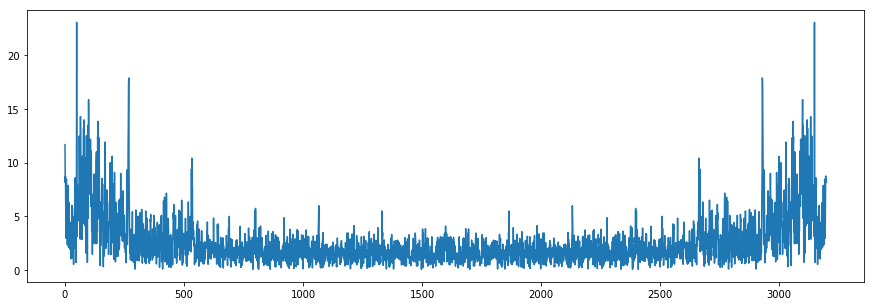

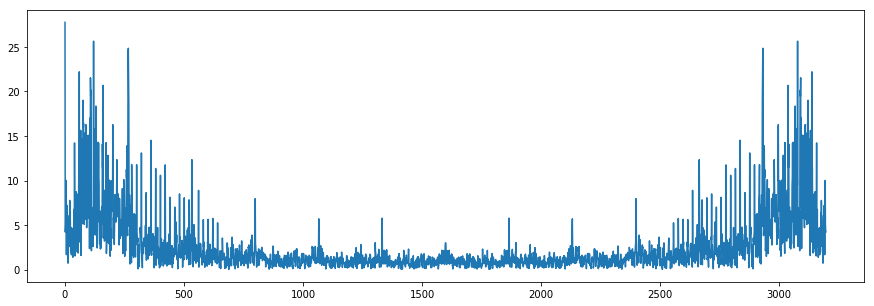

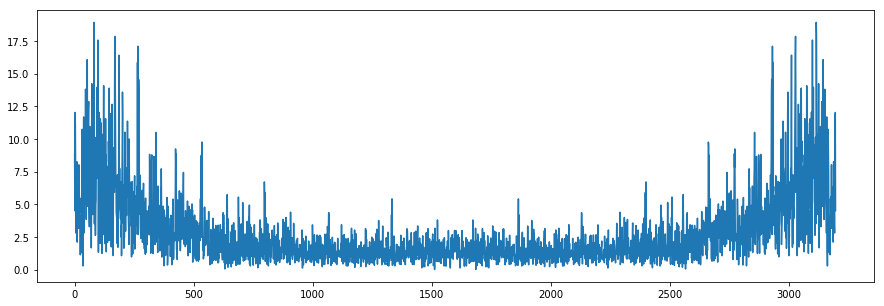

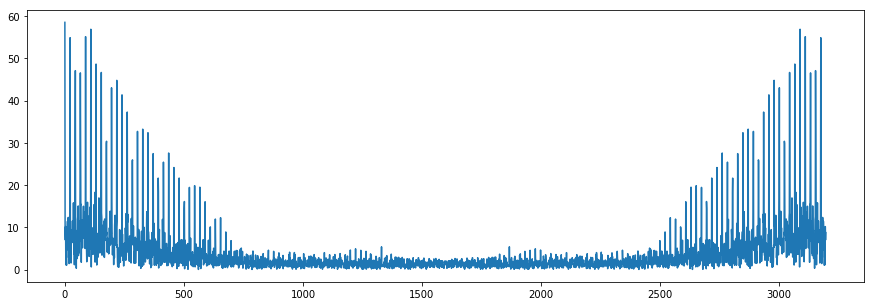

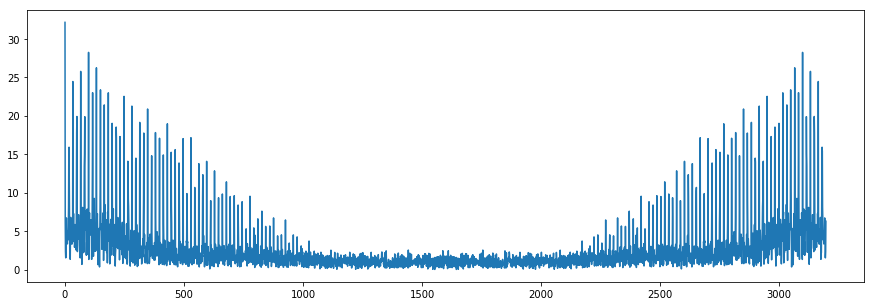

In [26]:
Y_0= X_test.iloc[0]
Y_1= X_test.iloc[1]
Y_2= X_test.iloc[2]
Y_3= X_test.iloc[3]
Y_4= X_test.iloc[4]
X= np.arange(len (Y_0))
plt.figure(figsize=(15,5))
plt.plot(X,Y_0)
plt.show()
plt.figure(figsize=(15,5))
plt.plot(X,Y_1)
plt.show()
plt.figure(figsize=(15,5))
plt.plot(X,Y_2)
plt.show()
plt.figure(figsize=(15,5))
plt.plot(X,Y_3)
plt.show()
plt.figure(figsize=(15,5))
plt.plot(X,Y_4)
plt.show()

Tuning subsample and colsample_bytree


In [52]:
modelsxgb = { 
    
    #'RandomForestClassifier': RandomForestClassifier(),
    #'AdaBoostClassifier': AdaBoostClassifier(),
    'XGBClassifier': xg.XGBClassifier(),
    #'SVC': SVC(),
    #'LinearSVC' : LinearSVC(),
}

paramsxgb = { 
    #'RandomForestClassifier': { 'n_estimators': [16, 32] },
    #'AdaBoostClassifier':  { 'n_estimators': [16, 32] },
    'XGBClassifier': { 'n_estimators': [1000], 'learning_rate': [1.0],'max_depth':[3],
 'min_child_weight':[1], 'gamma':[0.2] , 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]},
    #'SVC': [
     #   {'kernel': ['linear'], 'C': [1, 10]},
      #  {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.001, 0.0001]},
    #],
    #'LinearSVC': {'penalty': ['l2'],
     #         'loss': ['hinge'],
      #        'dual': [True],
       #       'tol': np.arange(0.00008, .00014, 0.00002),
        #3      'C': list(range(100, 220, 20)),
         #     'fit_intercept': [True],
          #    'intercept_scaling': np.arange(10, 130, 30),
           #   'class_weight': [None],
            #  'verbose': [0],
             # 'random_state': [None]}
}

## Ideas from
https://www.kaggle.com/toregil/mystery-planet-99-8-cnn  for convolutional networks.

In [61]:
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, \
BatchNormalization, Input, concatenate, Activation
from keras.optimizers import Adam

ModuleNotFoundError: No module named 'keras'

Ideas from https://www.kaggle.com/aleksod/0-75-precision-0-60-recall-linear-svc

In [85]:
def model_evaluator(X, y, model, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits)
    
    
    bootstrapped_f1s        = list()
    
    
    SMOTE_f1s        = list()
    
    for train_index, test_index in skf.split(X, y):
        X_tr, X_te = X.iloc[train_index], X.iloc[test_index]
        y_tr, y_te = y[train_index], y[test_index]
                
        df_train    = X_tr.join(y_tr)
        df_planet   = df_train[df_train.LABEL == 2].reset_index(drop=True)
        df_noplanet = df_train[df_train.LABEL == 1].reset_index(drop=True)
        df_boot     = df_noplanet
                        
        index = np.arange(0, df_planet.shape[0])
        temp_index = np.random.choice(index, size=df_noplanet.shape[0])
        df_boot = df_boot.append(df_planet.iloc[temp_index])
        
        df_boot = df_boot.reset_index(drop=True)
        X_tr_boot = df_boot.drop('LABEL', axis=1)
        y_tr_boot = df_boot.LABEL
                    
        est_boot = model.fit(X_tr_boot, y_tr_boot)
        y_te_pred = est_boot.predict(X_te)
        
        
        bootstrapped_f1s.append(f1_score(y_te, y_te_pred, pos_label=2))
    
        sm = SMOTE(ratio = 1.0)
        X_tr_sm, y_tr_sm = sm.fit_sample(X_tr, y_tr)
                    
        est_sm = model.fit(X_tr_sm, y_tr_sm)
        y_te_pred = est_sm.predict(X_te)
        
        
        SMOTE_f1s.append(f1_score(y_te, y_te_pred, pos_label=2))
        
    
    print("Average F1:\t\t", "{:0.10f}".format(np.mean(bootstrapped_f1s)),
          '\t', "{:0.10f}".format(np.mean(SMOTE_f1s)))

In [87]:
model_evaluator(X_train, y_train, SVC())

/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/juan_felipe/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/juan_f

Average F1:		 0.3400000000 	 0.4338095238
